### 1. Part - Download and Setup of the WildDeepfake Dataset

**1. Import Libraries and Setup**

In [ ]:
!pip install webdataset
!pip install huggingface_hub[cli]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [InquirerPy]


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import webdataset as wds
from huggingface_hub import HfFileSystem, get_token, hf_hub_url
from PIL import Image
import io
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# GCS Configuration
GCS_BUCKET = "???"
LOCAL_DATA_DIR = "/tmp/wilddeepfake_data"

2025-10-25 14:42:29.071829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-10-25 14:42:35.819912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-25 14:42:35.836736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-25 14:42:35.837108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

**2. Configuration**

In [ ]:
# Image parameters
IMG_SIZE = 112
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2

# Create directories for saving models and results
BASE_PATH = LOCAL_DATA_DIR
os.makedirs(BASE_PATH, exist_ok=True)
RAW_PATH = os.path.join(BASE_PATH, '01_raw_archives')
PROCESSED_PATH = os.path.join(BASE_PATH, '02_processed_data')
METADATA_PATH = os.path.join(BASE_PATH, '03_metadata')

os.makedirs(RAW_PATH, exist_ok=True)
os.makedirs(PROCESSED_PATH, exist_ok=True)
os.makedirs(METADATA_PATH, exist_ok=True)

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

# Define preprocessing functions
def preprocess_image(image, size=IMG_SIZE):
    """Preprocess PIL image to numpy array"""
    # Convert PIL image to RGB if it's not already
    if image.mode != 'RGB':
        image = image.convert('RGB')
    # Resize image
    image = image.resize((size, size), Image.Resampling.LANCZOS)
    # Convert to numpy array and normalize
    image_array = np.array(image, dtype=np.uint8)
    return image_array

def extract_images_and_labels(dataset_split):
    """Extract images and labels from dataset split - handles multiple dataset formats"""
    images = []
    labels = []

    if isinstance(dataset_split, dict) and 'image' in dataset_split:
        print(f"Processing {len(dataset_split['image'])} images...")
        for i, (image, label) in enumerate(zip(dataset_split['image'], dataset_split['label'])):
            try:
                processed_image = preprocess_image(image)
                images.append(processed_image)
                labels.append(label)
                if (i + 1) % 500 == 0:
                    print(f"Processed {i + 1}/{len(dataset_split['image'])} images")
            except Exception as e:
                print(f"Error processing sample {i}: {e}")
                continue
    else:
        print(f"Processing {len(dataset_split)} samples from HuggingFace dataset...")
        for i, sample in enumerate(dataset_split):
            try:
                image = sample['image']
                label = sample['label']
                processed_image = preprocess_image(image)
                images.append(processed_image)
                labels.append(label)
                if (i + 1) % 500 == 0:
                    print(f"Processed {i + 1}/{len(dataset_split)} samples")
            except Exception as e:
                print(f"Error processing sample {i}: {e}")
                continue

    return np.array(images), np.array(labels)

print("Preprocessing functions defined successfully!")

Image size: 112x112
Batch size: 32
Epochs: 50
Preprocessing functions defined successfully!


**3. Load Wild Deepfake Dataset**

In [ ]:
# ====== HUGGINGFACE LOGIN WITH VERIFICATION ======
from huggingface_hub import login, whoami

print("Logging into HuggingFace...")
login()

# Verify login worked
try:
    user_info = whoami()
    print(f"Successfully logged in as: {user_info['name']}")
    print(f"   Email: {user_info.get('email', 'N/A')}")
except Exception as e:
    print(f"Login verification failed: {e}")
    print("   Please check your token and try again")
    raise

Logging into HuggingFace...


Successfully logged in as: benzpk
   Email: ben.zapka@gmail.com


In [ ]:
# ====== DOWNLOAD AND PROCESS ALL ARCHIVES - FULL DATASET ======
import os
import tarfile
import requests
from tqdm import tqdm
import numpy as np
from PIL import Image
import io
import json
import gc
from huggingface_hub import hf_hub_download
import time

print("Starting download and processing FULL dataset...")
print("="*60)

# Verify authentication
from huggingface_hub import whoami
try:
    user = whoami()
    print(f"Authenticated as: {user['name']}")
except:
    print("Not authenticated! Run Cell 3a first.")
    raise Exception("HuggingFace authentication required")

# Setup - SEARCH FOR ALL .tar.gz FILES
fs = HfFileSystem()

print("\nSearching for ALL files in dataset...")
patterns = [
    "hf://datasets/xingjunm/WildDeepfake/**/*.tar.gz",
    "hf://datasets/xingjunm/WildDeepfake/**/fake_train/*.tar.gz",
    "hf://datasets/xingjunm/WildDeepfake/**/fake_test/*.tar.gz",
    "hf://datasets/xingjunm/WildDeepfake/**/real_train/*.tar.gz",
    "hf://datasets/xingjunm/WildDeepfake/**/real_test/*.tar.gz",
]

all_files = []
for pattern in patterns:
    try:
        found = list(fs.glob(pattern))
        print(f"   Pattern '{pattern.split('/')[-2]}': {len(found)} files")
        all_files.extend(found)
    except Exception as e:
        print(f"   Pattern failed: {e}")

# Remove duplicates
files = list(set(all_files))
print(f"\nFound {len(files)} unique archive files")

if len(files) == 0:
    raise Exception("No files found!")

# Show sample
print(f"\nSample of files:")
for f in files[:5]:
    resolved = fs.resolve_path(f)
    print(f"   {resolved.path_in_repo}")

print(f"\nProcessing ALL {len(files)} archives (NO LIMIT on images per archive)")
print("="*60)

batch_num = 0
current_batch_images = []
current_batch_labels = []
total_images = 0
successful_files = 0
failed_files = 0
skipped_files = 0
BATCH_SIZE_PROCESS = 500

# Track statistics
error_types = {
    'download_failed': 0,
    'empty_file': 0,
    'cannot_open_tar': 0,
    'no_images': 0,
    'extraction_failed': 0
}

for i, file_path in enumerate(tqdm(files, desc="Processing archives")):
    file = fs.resolve_path(file_path)
    filename = os.path.basename(file.path_in_repo)
    full_path = file.path_in_repo

    # Determine label from FULL PATH
    path_lower = full_path.lower()
    if 'real' in path_lower:
        label = 0
    elif 'fake' in path_lower:
        label = 1
    else:
        skipped_files += 1
        continue

    try:
        # Download
        downloaded_path = hf_hub_download(
            repo_id=file.repo_id,
            filename=file.path_in_repo,
            repo_type="dataset",
            local_dir=RAW_PATH,
            local_dir_use_symlinks=False
        )

        # Verify file
        if not os.path.exists(downloaded_path):
            error_types['download_failed'] += 1
            failed_files += 1
            continue

        file_size = os.path.getsize(downloaded_path)
        if file_size == 0:
            error_types['empty_file'] += 1
            failed_files += 1
            continue

        # Open tar
        tar = None
        for mode in ['r:gz', 'r', 'r:*', 'r:bz2', 'r:xz']:
            try:
                tar = tarfile.open(downloaded_path, mode)
                break
            except:
                continue

        if tar is None:
            error_types['cannot_open_tar'] += 1
            failed_files += 1
            continue

        # Get ALL image members
        try:
            members = [m for m in tar.getmembers()
                      if m.isfile() and m.name.lower().endswith(('.jpg', '.jpeg', '.png'))]
        except Exception as e:
            tar.close()
            error_types['cannot_open_tar'] += 1
            failed_files += 1
            continue

        if len(members) == 0:
            tar.close()
            error_types['no_images'] += 1
            failed_files += 1
            continue

        images_processed = 0

        # Process ALL images from this archive
        for member in members:
            try:
                f = tar.extractfile(member)
                if f:
                    image = Image.open(f)
                    if image.mode != 'RGB':
                        image = image.convert('RGB')

                    image = image.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
                    img_array = np.array(image).astype(np.uint8)

                    current_batch_images.append(img_array)
                    current_batch_labels.append(label)
                    images_processed += 1
                    total_images += 1

                    # Clean up
                    image.close()
                    del image, img_array

                    # Save batch
                    if len(current_batch_images) >= BATCH_SIZE_PROCESS:
                        batch_file = os.path.join(PROCESSED_PATH, f'batch_{batch_num:05d}.npz')
                        np.savez_compressed(
                            batch_file,
                            images=np.array(current_batch_images),
                            labels=np.array(current_batch_labels)
                        )
                        batch_num += 1
                        current_batch_images = []
                        current_batch_labels = []
                        gc.collect()

                        # Progress update every 100 batches
                        if batch_num % 100 == 0:
                            avg_per_file = total_images / (successful_files + 1) if successful_files > 0 else 0
                            print(f"\n   Progress: {total_images:,} images from {successful_files} archives ({avg_per_file:.0f} avg/file), {batch_num} batches")

            except Exception as e:
                continue

        tar.close()

        if images_processed > 0:
            successful_files += 1
            # Show progress for first few files
            if successful_files <= 5:
                print(f"\n   File {successful_files}: {filename} → {images_processed} images")
        else:
            error_types['extraction_failed'] += 1
            failed_files += 1

        # Clean up downloaded file
        try:
            if os.path.exists(downloaded_path):
                os.remove(downloaded_path)
        except:
            pass

    except Exception as e:
        failed_files += 1
        continue

    # Garbage collection every 20 files
    if i % 20 == 0:
        gc.collect()

# Save final batch
if current_batch_images:
    batch_file = os.path.join(PROCESSED_PATH, f'batch_{batch_num:05d}.npz')
    np.savez_compressed(
        batch_file,
        images=np.array(current_batch_images),
        labels=np.array(current_batch_labels)
    )
    batch_num += 1

print("\n" + "="*60)
print(f"FULL DATASET PROCESSING COMPLETE!")
print(f"   Total files found: {len(files)}")
print(f"   Successful files: {successful_files}/{len(files)}")
print(f"   Failed files: {failed_files}")
print(f"   Skipped files: {skipped_files}")
print(f"   Total images: {total_images:,}")
print(f"   Average images per file: {total_images/successful_files:.0f}")
print(f"   Batches created: {batch_num}")

print(f"\nError breakdown:")
for error_type, count in error_types.items():
    if count > 0:
        print(f"   {error_type}: {count}")

if successful_files == 0:
    print("\nERROR: No files were successfully processed!")
    raise Exception("No files processed successfully")

# Save summary
summary = {
    'total_files_found': len(files),
    'successful_files': successful_files,
    'failed_files': failed_files,
    'skipped_files': skipped_files,
    'total_images': total_images,
    'avg_images_per_file': total_images / successful_files if successful_files > 0 else 0,
    'total_batches': batch_num,
    'error_breakdown': error_types
}

with open(os.path.join(METADATA_PATH, 'processing_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nData saved locally to {PROCESSED_PATH}")
print(f"   Run Cell 4 to convert to memmap and upload to GCS")

Starting download and processing FULL dataset...
Authenticated as: benzpk

Searching for ALL files in dataset...
   Pattern '**': 1120 files
   Pattern 'fake_train': 592 files
   Pattern 'fake_test': 115 files
   Pattern 'real_train': 371 files
   Pattern 'real_test': 42 files

Found 1120 unique archive files

Sample of files:
   deepfake_in_the_wild/fake_train/19.tar.gz
   deepfake_in_the_wild/fake_train/204.tar.gz
   deepfake_in_the_wild/fake_train/271.tar.gz
   deepfake_in_the_wild/fake_train/347.tar.gz
   deepfake_in_the_wild/real_test/66.tar.gz

Processing ALL 1120 archives (NO LIMIT on images per archive)


Processing archives:   0%|          | 0/1120 [00:00<?, ?it/s]

deepfake_in_the_wild/fake_train/19.tar.g(…):   0%|          | 0.00/25.6M [00:00<?, ?B/s]


   File 1: 19.tar.gz → 334 images


Processing archives:   0%|          | 1/1120 [00:02<48:42,  2.61s/it]

deepfake_in_the_wild/fake_train/204.tar.(…):   0%|          | 0.00/108M [00:00<?, ?B/s]

Processing archives:   0%|          | 2/1120 [00:13<2:21:09,  7.58s/it]


   File 2: 204.tar.gz → 1733 images


deepfake_in_the_wild/fake_train/271.tar.(…):   0%|          | 0.00/11.1M [00:00<?, ?B/s]

Processing archives:   0%|          | 3/1120 [00:15<1:30:10,  4.84s/it]


   File 3: 271.tar.gz → 208 images


deepfake_in_the_wild/fake_train/347.tar.(…):   0%|          | 0.00/3.28M [00:00<?, ?B/s]

Processing archives:   0%|          | 4/1120 [00:16<1:02:48,  3.38s/it]


   File 4: 347.tar.gz → 55 images


deepfake_in_the_wild/real_test/66.tar.gz:   0%|          | 0.00/8.28M [00:00<?, ?B/s]

Processing archives:   0%|          | 5/1120 [00:17<48:34,  2.61s/it]  


   File 5: 66.tar.gz → 125 images


deepfake_in_the_wild/fake_train/22.tar.g(…):   0%|          | 0.00/55.0M [00:00<?, ?B/s]

Processing archives:   1%|          | 6/1120 [00:23<1:10:09,  3.78s/it]

deepfake_in_the_wild/fake_test/54.tar.gz:   0%|          | 0.00/202M [00:00<?, ?B/s]

Processing archives:   1%|          | 7/1120 [00:43<2:44:27,  8.87s/it]

deepfake_in_the_wild/real_train/114.tar.(…):   0%|          | 0.00/60.8M [00:00<?, ?B/s]

Processing archives:   1%|          | 8/1120 [00:49<2:29:48,  8.08s/it]

deepfake_in_the_wild/fake_train/268.tar.(…):   0%|          | 0.00/265M [00:00<?, ?B/s]

Processing archives:   1%|          | 9/1120 [01:10<3:43:27, 12.07s/it]

deepfake_in_the_wild/fake_test/96.tar.gz:   0%|          | 0.00/5.40M [00:00<?, ?B/s]

Processing archives:   1%|          | 10/1120 [01:12<2:47:50,  9.07s/it]

deepfake_in_the_wild/real_train/11.tar.g(…):   0%|          | 0.00/35.7M [00:00<?, ?B/s]

Processing archives:   1%|          | 11/1120 [01:16<2:18:53,  7.51s/it]

deepfake_in_the_wild/real_train/477.tar.(…):   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Processing archives:   1%|          | 12/1120 [01:22<2:10:21,  7.06s/it]

deepfake_in_the_wild/real_train/498.tar.(…):   0%|          | 0.00/61.7M [00:00<?, ?B/s]

Processing archives:   1%|          | 13/1120 [01:29<2:07:01,  6.88s/it]

deepfake_in_the_wild/real_train/494.tar.(…):   0%|          | 0.00/58.8M [00:00<?, ?B/s]

Processing archives:   1%|▏         | 14/1120 [01:35<2:06:01,  6.84s/it]

deepfake_in_the_wild/fake_train/445.tar.(…):   0%|          | 0.00/24.9M [00:00<?, ?B/s]

Processing archives:   1%|▏         | 15/1120 [01:37<1:39:35,  5.41s/it]

deepfake_in_the_wild/fake_train/465.tar.(…):   0%|          | 0.00/12.3M [00:00<?, ?B/s]

Processing archives:   1%|▏         | 16/1120 [01:40<1:24:45,  4.61s/it]

deepfake_in_the_wild/real_train/524.tar.(…):   0%|          | 0.00/70.7M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 17/1120 [01:48<1:40:51,  5.49s/it]

deepfake_in_the_wild/fake_train/362.tar.(…):   0%|          | 0.00/15.4M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 18/1120 [01:51<1:26:15,  4.70s/it]

deepfake_in_the_wild/fake_test/92.tar.gz:   0%|          | 0.00/49.6M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 19/1120 [01:55<1:25:10,  4.64s/it]

deepfake_in_the_wild/fake_test/98.tar.gz:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 20/1120 [02:01<1:31:01,  4.96s/it]

deepfake_in_the_wild/fake_train/194.tar.(…):   0%|          | 0.00/94.9M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 21/1120 [02:10<1:55:51,  6.32s/it]

deepfake_in_the_wild/fake_train/358.tar.(…):   0%|          | 0.00/55.6M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 22/1120 [02:16<1:54:14,  6.24s/it]

deepfake_in_the_wild/fake_train/584.tar.(…):   0%|          | 0.00/28.6M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 23/1120 [02:20<1:39:32,  5.44s/it]

deepfake_in_the_wild/real_test/50.tar.gz:   0%|          | 0.00/103M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 24/1120 [02:29<2:00:01,  6.57s/it]

deepfake_in_the_wild/real_train/298.tar.(…):   0%|          | 0.00/63.0M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 25/1120 [02:36<2:02:28,  6.71s/it]

deepfake_in_the_wild/fake_train/14.tar.g(…):   0%|          | 0.00/74.8M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 26/1120 [02:45<2:11:47,  7.23s/it]

deepfake_in_the_wild/real_train/93.tar.g(…):   0%|          | 0.00/68.5M [00:00<?, ?B/s]

Processing archives:   2%|▏         | 27/1120 [02:51<2:08:25,  7.05s/it]

deepfake_in_the_wild/real_train/62.tar.g(…):   0%|          | 0.00/151M [00:00<?, ?B/s]

Processing archives:   2%|▎         | 28/1120 [03:08<2:59:41,  9.87s/it]

deepfake_in_the_wild/fake_train/331.tar.(…):   0%|          | 0.00/64.8M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 29/1120 [03:14<2:38:41,  8.73s/it]

deepfake_in_the_wild/fake_train/159.tar.(…):   0%|          | 0.00/87.4M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 30/1120 [03:23<2:42:39,  8.95s/it]

deepfake_in_the_wild/fake_train/15.tar.g(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 31/1120 [03:50<4:20:28, 14.35s/it]

deepfake_in_the_wild/fake_train/164.tar.(…):   0%|          | 0.00/54.6M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 32/1120 [03:59<3:52:49, 12.84s/it]

deepfake_in_the_wild/fake_train/389.tar.(…):   0%|          | 0.00/4.18M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 33/1120 [04:02<2:55:18,  9.68s/it]

deepfake_in_the_wild/fake_train/41.tar.g(…):   0%|          | 0.00/340M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 34/1120 [04:28<4:24:50, 14.63s/it]

deepfake_in_the_wild/fake_train/98.tar.g(…):   0%|          | 0.00/31.6M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 35/1120 [04:32<3:25:36, 11.37s/it]

deepfake_in_the_wild/fake_test/110.tar.g(…):   0%|          | 0.00/46.6M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 36/1120 [04:39<3:03:13, 10.14s/it]

deepfake_in_the_wild/fake_test/15.tar.gz:   0%|          | 0.00/27.5M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 37/1120 [04:43<2:28:52,  8.25s/it]

deepfake_in_the_wild/fake_train/125.tar.(…):   0%|          | 0.00/79.1M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 38/1120 [04:54<2:43:25,  9.06s/it]

deepfake_in_the_wild/fake_test/53.tar.gz:   0%|          | 0.00/25.5M [00:00<?, ?B/s]

Processing archives:   3%|▎         | 39/1120 [04:59<2:21:15,  7.84s/it]

deepfake_in_the_wild/fake_train/217.tar.(…):   0%|          | 0.00/47.6M [00:00<?, ?B/s]

Processing archives:   4%|▎         | 40/1120 [05:05<2:13:49,  7.43s/it]

deepfake_in_the_wild/fake_train/177.tar.(…):   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Processing archives:   4%|▎         | 41/1120 [05:12<2:08:44,  7.16s/it]

deepfake_in_the_wild/fake_train/279.tar.(…):   0%|          | 0.00/35.0M [00:00<?, ?B/s]

Processing archives:   4%|▍         | 42/1120 [05:15<1:49:48,  6.11s/it]

deepfake_in_the_wild/fake_train/478.tar.(…):   0%|          | 0.00/71.0M [00:00<?, ?B/s]

Processing archives:   4%|▍         | 43/1120 [05:24<2:02:00,  6.80s/it]

deepfake_in_the_wild/fake_train/97.tar.g(…):   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Processing archives:   4%|▍         | 44/1120 [05:26<1:34:53,  5.29s/it]

deepfake_in_the_wild/fake_test/74.tar.gz:   0%|          | 0.00/40.2M [00:00<?, ?B/s]

Processing archives:   4%|▍         | 45/1120 [05:31<1:34:43,  5.29s/it]


   Progress: 50,000 images from 44 archives (1111 avg/file), 100 batches


deepfake_in_the_wild/fake_train/223.tar.(…):   0%|          | 0.00/185M [00:00<?, ?B/s]

Processing archives:   4%|▍         | 46/1120 [05:47<2:30:39,  8.42s/it]

deepfake_in_the_wild/real_train/101.tar.(…):   0%|          | 0.00/6.05M [00:00<?, ?B/s]

Processing archives:   4%|▍         | 47/1120 [05:50<2:03:27,  6.90s/it]

deepfake_in_the_wild/real_train/39.tar.g(…):   0%|          | 0.00/92.3M [00:00<?, ?B/s]

Processing archives:   4%|▍         | 48/1120 [06:01<2:24:26,  8.08s/it]

deepfake_in_the_wild/real_train/547.tar.(…):   0%|          | 0.00/41.4M [00:00<?, ?B/s]

Processing archives:   4%|▍         | 49/1120 [06:07<2:11:29,  7.37s/it]

deepfake_in_the_wild/fake_train/261.tar.(…):   0%|          | 0.00/44.2M [00:00<?, ?B/s]

Processing archives:   4%|▍         | 50/1120 [06:12<2:02:30,  6.87s/it]

deepfake_in_the_wild/fake_train/44.tar.g(…):   0%|          | 0.00/65.4M [00:00<?, ?B/s]

Processing archives:   5%|▍         | 51/1120 [06:22<2:18:51,  7.79s/it]

deepfake_in_the_wild/fake_train/507.tar.(…):   0%|          | 0.00/10.5M [00:00<?, ?B/s]

Processing archives:   5%|▍         | 52/1120 [06:24<1:45:27,  5.92s/it]

deepfake_in_the_wild/real_train/451.tar.(…):   0%|          | 0.00/52.7M [00:00<?, ?B/s]

Processing archives:   5%|▍         | 53/1120 [06:30<1:45:20,  5.92s/it]

deepfake_in_the_wild/real_test/9.tar.gz:   0%|          | 0.00/4.33M [00:00<?, ?B/s]

Processing archives:   5%|▍         | 54/1120 [06:31<1:21:20,  4.58s/it]

deepfake_in_the_wild/real_train/150.tar.(…):   0%|          | 0.00/4.80M [00:00<?, ?B/s]

Processing archives:   5%|▍         | 55/1120 [06:32<1:03:05,  3.55s/it]

deepfake_in_the_wild/real_train/27.tar.g(…):   0%|          | 0.00/45.5M [00:00<?, ?B/s]

Processing archives:   5%|▌         | 56/1120 [06:38<1:12:53,  4.11s/it]

deepfake_in_the_wild/real_train/579.tar.(…):   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Processing archives:   5%|▌         | 57/1120 [06:43<1:17:14,  4.36s/it]

deepfake_in_the_wild/fake_train/77.tar.g(…):   0%|          | 0.00/29.5M [00:00<?, ?B/s]

Processing archives:   5%|▌         | 58/1120 [06:46<1:13:38,  4.16s/it]

deepfake_in_the_wild/real_train/320.tar.(…):   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Processing archives:   5%|▌         | 59/1120 [06:49<1:05:45,  3.72s/it]

deepfake_in_the_wild/real_train/439.tar.(…):   0%|          | 0.00/7.50M [00:00<?, ?B/s]

Processing archives:   5%|▌         | 60/1120 [06:50<52:53,  2.99s/it]  

deepfake_in_the_wild/fake_train/39.tar.g(…):   0%|          | 0.00/40.0M [00:00<?, ?B/s]

Processing archives:   5%|▌         | 61/1120 [06:55<1:02:22,  3.53s/it]

deepfake_in_the_wild/fake_train/205.tar.(…):   0%|          | 0.00/27.2M [00:00<?, ?B/s]

Processing archives:   6%|▌         | 62/1120 [06:59<1:01:47,  3.50s/it]

deepfake_in_the_wild/real_train/181.tar.(…):   0%|          | 0.00/35.2M [00:00<?, ?B/s]

Processing archives:   6%|▌         | 63/1120 [07:04<1:10:07,  3.98s/it]

deepfake_in_the_wild/fake_test/94.tar.gz:   0%|          | 0.00/46.9M [00:00<?, ?B/s]

Processing archives:   6%|▌         | 64/1120 [07:08<1:14:04,  4.21s/it]

deepfake_in_the_wild/fake_train/23.tar.g(…):   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Processing archives:   6%|▌         | 65/1120 [07:12<1:11:08,  4.05s/it]

deepfake_in_the_wild/fake_train/61.tar.g(…):   0%|          | 0.00/29.7M [00:00<?, ?B/s]

Processing archives:   6%|▌         | 66/1120 [07:16<1:08:37,  3.91s/it]

deepfake_in_the_wild/fake_train/105.tar.(…):   0%|          | 0.00/91.6M [00:00<?, ?B/s]

Processing archives:   6%|▌         | 67/1120 [07:27<1:45:55,  6.04s/it]

deepfake_in_the_wild/fake_train/273.tar.(…):   0%|          | 0.00/26.4M [00:00<?, ?B/s]

Processing archives:   6%|▌         | 68/1120 [07:30<1:32:16,  5.26s/it]

deepfake_in_the_wild/fake_train/555.tar.(…):   0%|          | 0.00/25.7M [00:00<?, ?B/s]

Processing archives:   6%|▌         | 69/1120 [07:34<1:22:31,  4.71s/it]

deepfake_in_the_wild/real_train/109.tar.(…):   0%|          | 0.00/111M [00:00<?, ?B/s]

Processing archives:   6%|▋         | 70/1120 [07:43<1:48:37,  6.21s/it]

deepfake_in_the_wild/fake_train/481.tar.(…):   0%|          | 0.00/47.3M [00:00<?, ?B/s]

Processing archives:   6%|▋         | 71/1120 [07:49<1:45:00,  6.01s/it]

deepfake_in_the_wild/real_train/227.tar.(…):   0%|          | 0.00/55.1M [00:00<?, ?B/s]

Processing archives:   6%|▋         | 72/1120 [07:55<1:47:19,  6.14s/it]

deepfake_in_the_wild/fake_train/287.tar.(…):   0%|          | 0.00/107M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 73/1120 [08:06<2:13:13,  7.64s/it]

deepfake_in_the_wild/fake_test/33.tar.gz:   0%|          | 0.00/38.0M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 74/1120 [08:10<1:54:17,  6.56s/it]

deepfake_in_the_wild/fake_train/187.tar.(…):   0%|          | 0.00/16.2M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 75/1120 [08:12<1:28:52,  5.10s/it]

deepfake_in_the_wild/fake_train/96.tar.g(…):   0%|          | 0.00/16.2M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 76/1120 [08:15<1:17:23,  4.45s/it]

deepfake_in_the_wild/real_train/276.tar.(…):   0%|          | 0.00/116M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 77/1120 [08:27<1:54:14,  6.57s/it]

deepfake_in_the_wild/fake_train/121.tar.(…):   0%|          | 0.00/24.7M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 78/1120 [08:30<1:36:36,  5.56s/it]

deepfake_in_the_wild/fake_train/421.tar.(…):   0%|          | 0.00/76.8M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 79/1120 [08:37<1:44:50,  6.04s/it]

deepfake_in_the_wild/real_train/350.tar.(…):   0%|          | 0.00/6.10M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 80/1120 [08:38<1:19:52,  4.61s/it]

deepfake_in_the_wild/fake_train/479.tar.(…):   0%|          | 0.00/41.5M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 81/1120 [08:44<1:26:37,  5.00s/it]

deepfake_in_the_wild/real_train/64.tar.g(…):   0%|          | 0.00/4.92M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 82/1120 [08:45<1:06:28,  3.84s/it]

deepfake_in_the_wild/real_train/38.tar.g(…):   0%|          | 0.00/24.7M [00:00<?, ?B/s]

Processing archives:   7%|▋         | 83/1120 [08:49<1:03:40,  3.68s/it]

deepfake_in_the_wild/fake_train/139.tar.(…):   0%|          | 0.00/29.5M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 84/1120 [08:51<55:39,  3.22s/it]  

deepfake_in_the_wild/fake_train/317.tar.(…):   0%|          | 0.00/88.6M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 85/1120 [09:00<1:25:20,  4.95s/it]

deepfake_in_the_wild/fake_train/422.tar.(…):   0%|          | 0.00/27.2M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 86/1120 [09:03<1:17:41,  4.51s/it]

deepfake_in_the_wild/fake_train/95.tar.g(…):   0%|          | 0.00/729M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 87/1120 [10:01<5:51:06, 20.39s/it]

deepfake_in_the_wild/fake_train/581.tar.(…):   0%|          | 0.00/635M [00:00<?, ?B/s]


   Progress: 100,000 images from 87 archives (1136 avg/file), 200 batches


Processing archives:   8%|▊         | 88/1120 [10:59<9:07:46, 31.85s/it]

deepfake_in_the_wild/fake_test/79.tar.gz:   0%|          | 0.00/57.9M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 89/1120 [11:08<7:07:06, 24.86s/it]

deepfake_in_the_wild/fake_train/582.tar.(…):   0%|          | 0.00/62.1M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 90/1120 [11:16<5:39:23, 19.77s/it]

deepfake_in_the_wild/real_train/311.tar.(…):   0%|          | 0.00/18.7M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 91/1120 [11:18<4:07:09, 14.41s/it]

deepfake_in_the_wild/fake_train/565.tar.(…):   0%|          | 0.00/121M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 92/1120 [11:31<4:00:44, 14.05s/it]

deepfake_in_the_wild/fake_train/519.tar.(…):   0%|          | 0.00/41.0M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 93/1120 [11:35<3:09:53, 11.09s/it]

deepfake_in_the_wild/fake_test/9.tar.gz:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 94/1120 [11:38<2:28:10,  8.67s/it]

deepfake_in_the_wild/fake_train/423.tar.(…):   0%|          | 0.00/107M [00:00<?, ?B/s]

Processing archives:   8%|▊         | 95/1120 [11:47<2:32:33,  8.93s/it]

deepfake_in_the_wild/fake_train/575.tar.(…):   0%|          | 0.00/76.1M [00:00<?, ?B/s]

Processing archives:   9%|▊         | 96/1120 [11:56<2:30:54,  8.84s/it]

deepfake_in_the_wild/fake_train/128.tar.(…):   0%|          | 0.00/21.8M [00:00<?, ?B/s]

Processing archives:   9%|▊         | 97/1120 [11:59<2:02:01,  7.16s/it]

deepfake_in_the_wild/fake_test/73.tar.gz:   0%|          | 0.00/38.7M [00:00<?, ?B/s]

Processing archives:   9%|▉         | 98/1120 [12:04<1:46:42,  6.26s/it]

deepfake_in_the_wild/fake_train/431.tar.(…):   0%|          | 0.00/29.2M [00:00<?, ?B/s]

Processing archives:   9%|▉         | 99/1120 [12:07<1:32:54,  5.46s/it]

deepfake_in_the_wild/fake_train/293.tar.(…):   0%|          | 0.00/34.4M [00:00<?, ?B/s]

Processing archives:   9%|▉         | 100/1120 [12:11<1:22:36,  4.86s/it]

deepfake_in_the_wild/fake_train/238.tar.(…):   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Processing archives:   9%|▉         | 101/1120 [12:13<1:08:56,  4.06s/it]

deepfake_in_the_wild/real_test/37.tar.gz:   0%|          | 0.00/63.8M [00:00<?, ?B/s]

Processing archives:   9%|▉         | 102/1120 [12:21<1:29:14,  5.26s/it]

deepfake_in_the_wild/fake_test/57.tar.gz:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Processing archives:   9%|▉         | 103/1120 [12:24<1:18:50,  4.65s/it]

deepfake_in_the_wild/fake_train/325.tar.(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Processing archives:   9%|▉         | 104/1120 [12:26<1:05:46,  3.88s/it]

deepfake_in_the_wild/fake_train/30.tar.g(…):   0%|          | 0.00/49.0M [00:00<?, ?B/s]

Processing archives:   9%|▉         | 105/1120 [12:32<1:16:26,  4.52s/it]

deepfake_in_the_wild/fake_test/78.tar.gz:   0%|          | 0.00/74.9M [00:00<?, ?B/s]

Processing archives:   9%|▉         | 106/1120 [12:39<1:26:33,  5.12s/it]

deepfake_in_the_wild/fake_train/391.tar.(…):   0%|          | 0.00/61.8M [00:00<?, ?B/s]

Processing archives:  10%|▉         | 107/1120 [12:45<1:32:57,  5.51s/it]

deepfake_in_the_wild/fake_train/12.tar.g(…):   0%|          | 0.00/56.2M [00:00<?, ?B/s]

Processing archives:  10%|▉         | 108/1120 [12:51<1:37:15,  5.77s/it]

deepfake_in_the_wild/fake_train/80.tar.g(…):   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Processing archives:  10%|▉         | 109/1120 [13:00<1:52:25,  6.67s/it]

deepfake_in_the_wild/fake_test/34.tar.gz:   0%|          | 0.00/8.35M [00:00<?, ?B/s]

Processing archives:  10%|▉         | 110/1120 [13:02<1:25:24,  5.07s/it]

deepfake_in_the_wild/fake_test/5.tar.gz:   0%|          | 0.00/9.33M [00:00<?, ?B/s]

Processing archives:  10%|▉         | 111/1120 [13:03<1:07:03,  3.99s/it]

deepfake_in_the_wild/real_train/209.tar.(…):   0%|          | 0.00/40.3M [00:00<?, ?B/s]

Processing archives:  10%|█         | 112/1120 [13:09<1:16:27,  4.55s/it]

deepfake_in_the_wild/real_train/230.tar.(…):   0%|          | 0.00/154M [00:00<?, ?B/s]

Processing archives:  10%|█         | 113/1120 [13:23<2:05:59,  7.51s/it]

deepfake_in_the_wild/real_train/528.tar.(…):   0%|          | 0.00/202M [00:00<?, ?B/s]

Processing archives:  10%|█         | 114/1120 [13:41<2:56:51, 10.55s/it]

deepfake_in_the_wild/fake_test/82.tar.gz:   0%|          | 0.00/27.8M [00:00<?, ?B/s]

Processing archives:  10%|█         | 115/1120 [13:46<2:29:02,  8.90s/it]

deepfake_in_the_wild/fake_train/514.tar.(…):   0%|          | 0.00/2.18G [00:00<?, ?B/s]


   Progress: 150,000 images from 115 archives (1293 avg/file), 300 batches


Processing archives:  10%|█         | 116/1120 [16:56<17:38:26, 63.25s/it]

deepfake_in_the_wild/real_train/474.tar.(…):   0%|          | 0.00/28.0M [00:00<?, ?B/s]

Processing archives:  10%|█         | 117/1120 [17:01<12:45:34, 45.80s/it]

deepfake_in_the_wild/real_train/544.tar.(…):   0%|          | 0.00/93.4M [00:00<?, ?B/s]

Processing archives:  11%|█         | 118/1120 [17:12<9:51:13, 35.40s/it] 

deepfake_in_the_wild/fake_test/58.tar.gz:   0%|          | 0.00/54.0M [00:00<?, ?B/s]

Processing archives:  11%|█         | 119/1120 [17:20<7:33:20, 27.17s/it]

deepfake_in_the_wild/real_test/27.tar.gz:   0%|          | 0.00/89.5M [00:00<?, ?B/s]

Processing archives:  11%|█         | 120/1120 [17:33<6:18:46, 22.73s/it]

deepfake_in_the_wild/real_train/136.tar.(…):   0%|          | 0.00/25.5M [00:00<?, ?B/s]

Processing archives:  11%|█         | 121/1120 [17:38<4:50:20, 17.44s/it]

deepfake_in_the_wild/real_train/379.tar.(…):   0%|          | 0.00/7.58M [00:00<?, ?B/s]

Processing archives:  11%|█         | 122/1120 [17:40<3:33:23, 12.83s/it]

deepfake_in_the_wild/fake_train/242.tar.(…):   0%|          | 0.00/54.0M [00:00<?, ?B/s]

Processing archives:  11%|█         | 123/1120 [17:47<3:07:03, 11.26s/it]

deepfake_in_the_wild/fake_test/2.tar.gz:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

Processing archives:  11%|█         | 124/1120 [17:52<2:36:11,  9.41s/it]

deepfake_in_the_wild/fake_train/303.tar.(…):   0%|          | 0.00/37.1M [00:00<?, ?B/s]

Processing archives:  11%|█         | 125/1120 [17:58<2:14:17,  8.10s/it]

deepfake_in_the_wild/real_train/53.tar.g(…):   0%|          | 0.00/173M [00:00<?, ?B/s]

Processing archives:  11%|█▏        | 126/1120 [18:17<3:09:37, 11.45s/it]

deepfake_in_the_wild/real_train/575.tar.(…):   0%|          | 0.00/92.6M [00:00<?, ?B/s]

Processing archives:  11%|█▏        | 127/1120 [18:28<3:08:59, 11.42s/it]

deepfake_in_the_wild/real_train/576.tar.(…):   0%|          | 0.00/105M [00:00<?, ?B/s]

Processing archives:  11%|█▏        | 128/1120 [18:38<3:01:14, 10.96s/it]

deepfake_in_the_wild/real_train/159.tar.(…):   0%|          | 0.00/115M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 129/1120 [18:50<3:04:53, 11.19s/it]

deepfake_in_the_wild/fake_train/557.tar.(…):   0%|          | 0.00/99.1M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 130/1120 [18:59<2:53:09, 10.49s/it]

deepfake_in_the_wild/fake_train/133.tar.(…):   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 131/1120 [19:03<2:22:39,  8.65s/it]

deepfake_in_the_wild/fake_train/330.tar.(…):   0%|          | 0.00/230M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 132/1120 [19:20<3:04:35, 11.21s/it]

deepfake_in_the_wild/fake_train/539.tar.(…):   0%|          | 0.00/64.5M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 133/1120 [19:26<2:40:23,  9.75s/it]

deepfake_in_the_wild/fake_train/115.tar.(…):   0%|          | 0.00/228M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 134/1120 [19:44<3:17:42, 12.03s/it]

deepfake_in_the_wild/fake_train/112.tar.(…):   0%|          | 0.00/56.9M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 135/1120 [19:50<2:49:34, 10.33s/it]

deepfake_in_the_wild/fake_train/528.tar.(…):   0%|          | 0.00/95.9M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 136/1120 [20:01<2:51:54, 10.48s/it]

deepfake_in_the_wild/fake_train/253.tar.(…):   0%|          | 0.00/9.49M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 137/1120 [20:02<2:06:29,  7.72s/it]

deepfake_in_the_wild/fake_test/11.tar.gz:   0%|          | 0.00/82.6M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 138/1120 [20:11<2:10:59,  8.00s/it]

deepfake_in_the_wild/real_train/369.tar.(…):   0%|          | 0.00/49.8M [00:00<?, ?B/s]

Processing archives:  12%|█▏        | 139/1120 [20:17<2:03:07,  7.53s/it]

deepfake_in_the_wild/fake_train/212.tar.(…):   0%|          | 0.00/93.4M [00:00<?, ?B/s]

Processing archives:  12%|█▎        | 140/1120 [20:26<2:09:22,  7.92s/it]

deepfake_in_the_wild/fake_test/66.tar.gz:   0%|          | 0.00/37.7M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 141/1120 [20:32<1:59:24,  7.32s/it]

deepfake_in_the_wild/real_train/218.tar.(…):   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 142/1120 [20:34<1:33:46,  5.75s/it]

deepfake_in_the_wild/real_train/77.tar.g(…):   0%|          | 0.00/29.5M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 143/1120 [20:39<1:28:43,  5.45s/it]

deepfake_in_the_wild/real_train/132.tar.(…):   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 144/1120 [20:43<1:19:30,  4.89s/it]

deepfake_in_the_wild/real_train/214.tar.(…):   0%|          | 0.00/39.5M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 145/1120 [20:48<1:22:22,  5.07s/it]

deepfake_in_the_wild/fake_train/537.tar.(…):   0%|          | 0.00/80.7M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 146/1120 [20:59<1:49:13,  6.73s/it]

deepfake_in_the_wild/real_train/532.tar.(…):   0%|          | 0.00/203M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 147/1120 [21:19<2:54:11, 10.74s/it]

deepfake_in_the_wild/real_train/145.tar.(…):   0%|          | 0.00/31.8M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 148/1120 [21:22<2:18:53,  8.57s/it]

deepfake_in_the_wild/fake_train/37.tar.g(…):   0%|          | 0.00/78.0M [00:00<?, ?B/s]


   Progress: 200,000 images from 148 archives (1342 avg/file), 400 batches


Processing archives:  13%|█▎        | 149/1120 [21:31<2:17:53,  8.52s/it]

deepfake_in_the_wild/real_test/53.tar.gz:   0%|          | 0.00/112M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 150/1120 [21:43<2:33:50,  9.52s/it]

deepfake_in_the_wild/real_train/26.tar.g(…):   0%|          | 0.00/3.60M [00:00<?, ?B/s]

Processing archives:  13%|█▎        | 151/1120 [21:44<1:52:45,  6.98s/it]

deepfake_in_the_wild/fake_train/490.tar.(…):   0%|          | 0.00/6.38M [00:00<?, ?B/s]

Processing archives:  14%|█▎        | 152/1120 [21:46<1:30:46,  5.63s/it]

deepfake_in_the_wild/real_train/470.tar.(…):   0%|          | 0.00/337M [00:00<?, ?B/s]

Processing archives:  14%|█▎        | 153/1120 [22:14<3:18:31, 12.32s/it]

deepfake_in_the_wild/real_train/519.tar.(…):   0%|          | 0.00/23.1M [00:00<?, ?B/s]

Processing archives:  14%|█▍        | 154/1120 [22:17<2:34:57,  9.62s/it]

deepfake_in_the_wild/fake_train/344.tar.(…):   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Processing archives:  14%|█▍        | 155/1120 [22:20<2:02:49,  7.64s/it]

deepfake_in_the_wild/fake_train/583.tar.(…):   0%|          | 0.00/28.4M [00:00<?, ?B/s]

Processing archives:  14%|█▍        | 156/1120 [22:24<1:42:36,  6.39s/it]

deepfake_in_the_wild/fake_test/6.tar.gz:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Processing archives:  14%|█▍        | 157/1120 [22:25<1:18:34,  4.90s/it]

deepfake_in_the_wild/real_train/493.tar.(…):   0%|          | 0.00/70.2M [00:00<?, ?B/s]

Processing archives:  14%|█▍        | 158/1120 [22:32<1:25:51,  5.35s/it]

deepfake_in_the_wild/fake_train/176.tar.(…):   0%|          | 0.00/108M [00:00<?, ?B/s]

Processing archives:  14%|█▍        | 159/1120 [22:41<1:45:59,  6.62s/it]

deepfake_in_the_wild/fake_train/149.tar.(…):   0%|          | 0.00/16.5M [00:00<?, ?B/s]

Processing archives:  14%|█▍        | 160/1120 [22:44<1:28:19,  5.52s/it]

deepfake_in_the_wild/fake_train/365.tar.(…):   0%|          | 0.00/16.7M [00:00<?, ?B/s]

Processing archives:  14%|█▍        | 161/1120 [22:48<1:18:45,  4.93s/it]

deepfake_in_the_wild/fake_train/107.tar.(…):   0%|          | 0.00/130M [00:00<?, ?B/s]

Processing archives:  14%|█▍        | 162/1120 [23:00<1:52:59,  7.08s/it]

deepfake_in_the_wild/fake_train/375.tar.(…):   0%|          | 0.00/110M [00:00<?, ?B/s]

Processing archives:  15%|█▍        | 163/1120 [23:11<2:12:36,  8.31s/it]

deepfake_in_the_wild/fake_train/108.tar.(…):   0%|          | 0.00/48.4M [00:00<?, ?B/s]

Processing archives:  15%|█▍        | 164/1120 [23:15<1:51:32,  7.00s/it]

deepfake_in_the_wild/fake_train/292.tar.(…):   0%|          | 0.00/16.2M [00:00<?, ?B/s]

Processing archives:  15%|█▍        | 165/1120 [23:17<1:26:10,  5.41s/it]

deepfake_in_the_wild/real_train/502.tar.(…):   0%|          | 0.00/40.6M [00:00<?, ?B/s]

Processing archives:  15%|█▍        | 166/1120 [23:22<1:25:31,  5.38s/it]

deepfake_in_the_wild/fake_train/241.tar.(…):   0%|          | 0.00/41.8M [00:00<?, ?B/s]

Processing archives:  15%|█▍        | 167/1120 [23:26<1:17:40,  4.89s/it]

deepfake_in_the_wild/fake_train/184.tar.(…):   0%|          | 0.00/31.8M [00:00<?, ?B/s]

Processing archives:  15%|█▌        | 168/1120 [23:29<1:11:19,  4.50s/it]

deepfake_in_the_wild/real_test/29.tar.gz:   0%|          | 0.00/185M [00:00<?, ?B/s]

Processing archives:  15%|█▌        | 169/1120 [23:48<2:18:06,  8.71s/it]

deepfake_in_the_wild/real_train/569.tar.(…):   0%|          | 0.00/177M [00:00<?, ?B/s]

Processing archives:  15%|█▌        | 170/1120 [24:07<3:08:03, 11.88s/it]

deepfake_in_the_wild/fake_train/444.tar.(…):   0%|          | 0.00/67.7M [00:00<?, ?B/s]

Processing archives:  15%|█▌        | 171/1120 [24:13<2:41:04, 10.18s/it]

deepfake_in_the_wild/fake_train/337.tar.(…):   0%|          | 0.00/3.99M [00:00<?, ?B/s]

Processing archives:  15%|█▌        | 172/1120 [24:14<1:57:49,  7.46s/it]

deepfake_in_the_wild/fake_test/90.tar.gz:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Processing archives:  15%|█▌        | 173/1120 [24:18<1:38:32,  6.24s/it]

deepfake_in_the_wild/fake_train/2.tar.gz:   0%|          | 0.00/49.6M [00:00<?, ?B/s]

Processing archives:  16%|█▌        | 174/1120 [24:24<1:36:55,  6.15s/it]

deepfake_in_the_wild/real_train/84.tar.g(…):   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Processing archives:  16%|█▌        | 175/1120 [24:26<1:17:20,  4.91s/it]

deepfake_in_the_wild/real_train/6.tar.gz:   0%|          | 0.00/9.67M [00:00<?, ?B/s]

Processing archives:  16%|█▌        | 176/1120 [24:28<1:06:07,  4.20s/it]

deepfake_in_the_wild/fake_train/520.tar.(…):   0%|          | 0.00/71.9M [00:00<?, ?B/s]

Processing archives:  16%|█▌        | 177/1120 [24:35<1:18:56,  5.02s/it]

deepfake_in_the_wild/fake_train/468.tar.(…):   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Processing archives:  16%|█▌        | 178/1120 [24:41<1:21:29,  5.19s/it]

deepfake_in_the_wild/fake_train/136.tar.(…):   0%|          | 0.00/28.4M [00:00<?, ?B/s]

Processing archives:  16%|█▌        | 179/1120 [24:43<1:07:24,  4.30s/it]

deepfake_in_the_wild/fake_train/137.tar.(…):   0%|          | 0.00/3.87M [00:00<?, ?B/s]

Processing archives:  16%|█▌        | 180/1120 [24:45<57:27,  3.67s/it]  

deepfake_in_the_wild/fake_train/454.tar.(…):   0%|          | 0.00/11.2M [00:00<?, ?B/s]

Processing archives:  16%|█▌        | 181/1120 [24:47<48:41,  3.11s/it]

deepfake_in_the_wild/fake_train/505.tar.(…):   0%|          | 0.00/47.8M [00:00<?, ?B/s]

Processing archives:  16%|█▋        | 182/1120 [24:51<54:18,  3.47s/it]

deepfake_in_the_wild/fake_test/111.tar.g(…):   0%|          | 0.00/295M [00:00<?, ?B/s]

Processing archives:  16%|█▋        | 183/1120 [25:24<3:12:09, 12.30s/it]

deepfake_in_the_wild/fake_test/84.tar.gz:   0%|          | 0.00/37.8M [00:00<?, ?B/s]

Processing archives:  16%|█▋        | 184/1120 [25:30<2:40:57, 10.32s/it]

deepfake_in_the_wild/fake_train/54.tar.g(…):   0%|          | 0.00/37.9M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 185/1120 [25:35<2:17:25,  8.82s/it]

deepfake_in_the_wild/fake_train/566.tar.(…):   0%|          | 0.00/28.6M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 186/1120 [25:40<2:00:00,  7.71s/it]

deepfake_in_the_wild/real_test/91.tar.gz:   0%|          | 0.00/8.50M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 187/1120 [25:42<1:30:23,  5.81s/it]

deepfake_in_the_wild/fake_train/472.tar.(…):   0%|          | 0.00/10.5M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 188/1120 [25:46<1:20:34,  5.19s/it]

deepfake_in_the_wild/real_test/19.tar.gz:   0%|          | 0.00/64.3M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 189/1120 [25:52<1:26:40,  5.59s/it]

deepfake_in_the_wild/fake_train/93.tar.g(…):   0%|          | 0.00/74.7M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 190/1120 [26:01<1:42:59,  6.65s/it]

deepfake_in_the_wild/real_test/82.tar.gz:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 191/1120 [26:04<1:24:22,  5.45s/it]

deepfake_in_the_wild/real_train/234.tar.(…):   0%|          | 0.00/96.9M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 192/1120 [26:15<1:49:56,  7.11s/it]

deepfake_in_the_wild/fake_train/449.tar.(…):   0%|          | 0.00/8.55M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 193/1120 [26:17<1:27:12,  5.64s/it]

deepfake_in_the_wild/fake_test/91.tar.gz:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 194/1120 [26:20<1:15:55,  4.92s/it]

deepfake_in_the_wild/real_train/354.tar.(…):   0%|          | 0.00/15.7M [00:00<?, ?B/s]

Processing archives:  17%|█▋        | 195/1120 [26:22<1:01:03,  3.96s/it]

deepfake_in_the_wild/real_test/93.tar.gz:   0%|          | 0.00/62.8M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 196/1120 [26:28<1:12:40,  4.72s/it]

deepfake_in_the_wild/fake_train/102.tar.(…):   0%|          | 0.00/95.7M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 197/1120 [26:37<1:32:18,  6.00s/it]

deepfake_in_the_wild/fake_train/366.tar.(…):   0%|          | 0.00/9.34M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 198/1120 [26:40<1:16:13,  4.96s/it]

deepfake_in_the_wild/fake_train/587.tar.(…):   0%|          | 0.00/48.9M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 199/1120 [26:44<1:12:04,  4.70s/it]

deepfake_in_the_wild/fake_train/21.tar.g(…):   0%|          | 0.00/29.4M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 200/1120 [26:48<1:06:14,  4.32s/it]

deepfake_in_the_wild/real_train/123.tar.(…):   0%|          | 0.00/24.4M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 201/1120 [26:51<1:03:58,  4.18s/it]

deepfake_in_the_wild/real_train/221.tar.(…):   0%|          | 0.00/56.1M [00:00<?, ?B/s]


   Progress: 250,000 images from 201 archives (1238 avg/file), 500 batches


Processing archives:  18%|█▊        | 202/1120 [26:57<1:12:44,  4.75s/it]

deepfake_in_the_wild/real_train/229.tar.(…):   0%|          | 0.00/50.0M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 203/1120 [27:02<1:11:18,  4.67s/it]

deepfake_in_the_wild/real_train/353.tar.(…):   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 204/1120 [27:08<1:16:24,  5.01s/it]

deepfake_in_the_wild/fake_test/86.tar.gz:   0%|          | 0.00/35.6M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 205/1120 [27:12<1:12:34,  4.76s/it]

deepfake_in_the_wild/fake_train/398.tar.(…):   0%|          | 0.00/19.7M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 206/1120 [27:15<1:04:21,  4.22s/it]

deepfake_in_the_wild/fake_train/480.tar.(…):   0%|          | 0.00/200M [00:00<?, ?B/s]

Processing archives:  18%|█▊        | 207/1120 [27:32<2:03:06,  8.09s/it]

deepfake_in_the_wild/fake_test/41.tar.gz:   0%|          | 0.00/33.0M [00:00<?, ?B/s]

Processing archives:  19%|█▊        | 208/1120 [27:36<1:43:46,  6.83s/it]

deepfake_in_the_wild/fake_test/65.tar.gz:   0%|          | 0.00/72.8M [00:00<?, ?B/s]

Processing archives:  19%|█▊        | 209/1120 [27:43<1:44:08,  6.86s/it]

deepfake_in_the_wild/fake_train/314.tar.(…):   0%|          | 0.00/33.4M [00:00<?, ?B/s]

Processing archives:  19%|█▉        | 210/1120 [27:46<1:29:08,  5.88s/it]

deepfake_in_the_wild/real_test/13.tar.gz:   0%|          | 0.00/243M [00:00<?, ?B/s]

Processing archives:  19%|█▉        | 211/1120 [28:07<2:36:11, 10.31s/it]

deepfake_in_the_wild/fake_train/369.tar.(…):   0%|          | 0.00/62.2M [00:00<?, ?B/s]

Processing archives:  19%|█▉        | 212/1120 [28:14<2:21:32,  9.35s/it]

deepfake_in_the_wild/fake_train/101.tar.(…):   0%|          | 0.00/11.8M [00:00<?, ?B/s]

Processing archives:  19%|█▉        | 213/1120 [28:16<1:45:44,  7.00s/it]

deepfake_in_the_wild/real_train/495.tar.(…):   0%|          | 0.00/205M [00:00<?, ?B/s]

Processing archives:  19%|█▉        | 214/1120 [28:34<2:36:03, 10.33s/it]

deepfake_in_the_wild/real_train/510.tar.(…):   0%|          | 0.00/2.74M [00:00<?, ?B/s]

Processing archives:  19%|█▉        | 215/1120 [28:35<1:54:19,  7.58s/it]

deepfake_in_the_wild/real_train/471.tar.(…):   0%|          | 0.00/70.8M [00:00<?, ?B/s]

Processing archives:  19%|█▉        | 216/1120 [28:42<1:50:44,  7.35s/it]

deepfake_in_the_wild/real_train/431.tar.(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Processing archives:  19%|█▉        | 217/1120 [28:43<1:23:17,  5.53s/it]

deepfake_in_the_wild/fake_train/470.tar.(…):   0%|          | 0.00/112M [00:00<?, ?B/s]

Processing archives:  19%|█▉        | 218/1120 [28:54<1:48:02,  7.19s/it]

deepfake_in_the_wild/fake_train/42.tar.g(…):   0%|          | 0.00/106M [00:00<?, ?B/s]

Processing archives:  20%|█▉        | 219/1120 [29:03<1:57:35,  7.83s/it]

deepfake_in_the_wild/fake_train/533.tar.(…):   0%|          | 0.00/28.1M [00:00<?, ?B/s]

Processing archives:  20%|█▉        | 220/1120 [29:07<1:37:55,  6.53s/it]

deepfake_in_the_wild/real_train/428.tar.(…):   0%|          | 0.00/83.7M [00:00<?, ?B/s]

Processing archives:  20%|█▉        | 221/1120 [29:16<1:50:08,  7.35s/it]

deepfake_in_the_wild/real_train/385.tar.(…):   0%|          | 0.00/68.6M [00:00<?, ?B/s]

Processing archives:  20%|█▉        | 222/1120 [29:24<1:53:59,  7.62s/it]

deepfake_in_the_wild/fake_train/372.tar.(…):   0%|          | 0.00/28.2M [00:00<?, ?B/s]

Processing archives:  20%|█▉        | 223/1120 [29:29<1:38:17,  6.57s/it]

deepfake_in_the_wild/fake_train/295.tar.(…):   0%|          | 0.00/81.1M [00:00<?, ?B/s]

Processing archives:  20%|██        | 224/1120 [29:37<1:48:28,  7.26s/it]

deepfake_in_the_wild/fake_test/115.tar.g(…):   0%|          | 0.00/5.28M [00:00<?, ?B/s]

Processing archives:  20%|██        | 225/1120 [29:39<1:21:05,  5.44s/it]

deepfake_in_the_wild/fake_test/80.tar.gz:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

Processing archives:  20%|██        | 226/1120 [29:40<1:03:10,  4.24s/it]

deepfake_in_the_wild/fake_train/591.tar.(…):   0%|          | 0.00/4.03M [00:00<?, ?B/s]

Processing archives:  20%|██        | 227/1120 [29:42<54:41,  3.67s/it]  

deepfake_in_the_wild/fake_train/99.tar.g(…):   0%|          | 0.00/46.4M [00:00<?, ?B/s]

Processing archives:  20%|██        | 228/1120 [29:47<57:08,  3.84s/it]

deepfake_in_the_wild/fake_train/135.tar.(…):   0%|          | 0.00/112M [00:00<?, ?B/s]

Processing archives:  20%|██        | 229/1120 [29:56<1:22:20,  5.54s/it]

deepfake_in_the_wild/real_train/138.tar.(…):   0%|          | 0.00/58.7M [00:00<?, ?B/s]

Processing archives:  21%|██        | 230/1120 [30:02<1:25:15,  5.75s/it]

deepfake_in_the_wild/fake_train/70.tar.g(…):   0%|          | 0.00/33.8M [00:00<?, ?B/s]

Processing archives:  21%|██        | 231/1120 [30:06<1:16:43,  5.18s/it]

deepfake_in_the_wild/real_train/219.tar.(…):   0%|          | 0.00/50.3M [00:00<?, ?B/s]

Processing archives:  21%|██        | 232/1120 [30:12<1:18:53,  5.33s/it]

deepfake_in_the_wild/real_train/340.tar.(…):   0%|          | 0.00/71.2M [00:00<?, ?B/s]

Processing archives:  21%|██        | 233/1120 [30:21<1:33:51,  6.35s/it]

deepfake_in_the_wild/fake_train/69.tar.g(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Processing archives:  21%|██        | 234/1120 [30:22<1:12:12,  4.89s/it]

deepfake_in_the_wild/real_train/421.tar.(…):   0%|          | 0.00/63.2M [00:00<?, ?B/s]

Processing archives:  21%|██        | 235/1120 [30:29<1:22:27,  5.59s/it]

deepfake_in_the_wild/fake_train/116.tar.(…):   0%|          | 0.00/43.1M [00:00<?, ?B/s]

Processing archives:  21%|██        | 236/1120 [30:35<1:20:56,  5.49s/it]

deepfake_in_the_wild/fake_train/430.tar.(…):   0%|          | 0.00/9.69M [00:00<?, ?B/s]

Processing archives:  21%|██        | 237/1120 [30:36<1:02:29,  4.25s/it]

deepfake_in_the_wild/fake_train/318.tar.(…):   0%|          | 0.00/69.3M [00:00<?, ?B/s]

Processing archives:  21%|██▏       | 238/1120 [30:43<1:14:05,  5.04s/it]

deepfake_in_the_wild/fake_train/68.tar.g(…):   0%|          | 0.00/65.2M [00:00<?, ?B/s]

Processing archives:  21%|██▏       | 239/1120 [30:49<1:20:55,  5.51s/it]

deepfake_in_the_wild/fake_train/123.tar.(…):   0%|          | 0.00/57.1M [00:00<?, ?B/s]

Processing archives:  21%|██▏       | 240/1120 [30:56<1:26:28,  5.90s/it]

deepfake_in_the_wild/fake_train/191.tar.(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 241/1120 [31:00<1:15:49,  5.18s/it]

deepfake_in_the_wild/real_train/582.tar.(…):   0%|          | 0.00/93.3M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 242/1120 [31:11<1:41:51,  6.96s/it]

deepfake_in_the_wild/real_train/567.tar.(…):   0%|          | 0.00/55.8M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 243/1120 [31:18<1:41:58,  6.98s/it]

deepfake_in_the_wild/fake_train/113.tar.(…):   0%|          | 0.00/39.1M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 244/1120 [31:25<1:42:11,  7.00s/it]

deepfake_in_the_wild/fake_test/105.tar.g(…):   0%|          | 0.00/47.3M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 245/1120 [31:29<1:30:35,  6.21s/it]

deepfake_in_the_wild/fake_train/140.tar.(…):   0%|          | 0.00/97.4M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 246/1120 [31:41<1:54:21,  7.85s/it]

deepfake_in_the_wild/real_train/105.tar.(…):   0%|          | 0.00/76.1M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 247/1120 [31:50<1:58:17,  8.13s/it]

deepfake_in_the_wild/fake_test/14.tar.gz:   0%|          | 0.00/39.7M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 248/1120 [31:54<1:40:47,  6.94s/it]

deepfake_in_the_wild/fake_train/407.tar.(…):   0%|          | 0.00/72.4M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 249/1120 [32:00<1:38:06,  6.76s/it]

deepfake_in_the_wild/real_train/442.tar.(…):   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 250/1120 [32:04<1:24:57,  5.86s/it]

deepfake_in_the_wild/fake_train/419.tar.(…):   0%|          | 0.00/24.4M [00:00<?, ?B/s]

Processing archives:  22%|██▏       | 251/1120 [32:07<1:13:03,  5.04s/it]

deepfake_in_the_wild/fake_train/440.tar.(…):   0%|          | 0.00/3.19M [00:00<?, ?B/s]

Processing archives:  22%|██▎       | 252/1120 [32:08<55:51,  3.86s/it]  

deepfake_in_the_wild/fake_test/18.tar.gz:   0%|          | 0.00/63.4M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 253/1120 [32:14<1:04:52,  4.49s/it]

deepfake_in_the_wild/fake_train/499.tar.(…):   0%|          | 0.00/44.7M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 254/1120 [32:19<1:04:24,  4.46s/it]

deepfake_in_the_wild/fake_train/145.tar.(…):   0%|          | 0.00/12.7M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 255/1120 [32:20<51:19,  3.56s/it]  

deepfake_in_the_wild/fake_train/553.tar.(…):   0%|          | 0.00/76.7M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 256/1120 [32:27<1:03:55,  4.44s/it]

deepfake_in_the_wild/real_test/8.tar.gz:   0%|          | 0.00/5.88M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 257/1120 [32:28<49:53,  3.47s/it]  

deepfake_in_the_wild/fake_train/82.tar.g(…):   0%|          | 0.00/4.88M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 258/1120 [32:30<45:25,  3.16s/it]


   Progress: 300,000 images from 257 archives (1163 avg/file), 600 batches


deepfake_in_the_wild/real_train/454.tar.(…):   0%|          | 0.00/11.6M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 259/1120 [32:32<37:33,  2.62s/it]

deepfake_in_the_wild/fake_train/34.tar.g(…):   0%|          | 0.00/49.8M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 260/1120 [32:36<44:55,  3.13s/it]

deepfake_in_the_wild/fake_train/412.tar.(…):   0%|          | 0.00/97.5M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 261/1120 [32:47<1:18:39,  5.49s/it]

deepfake_in_the_wild/real_train/402.tar.(…):   0%|          | 0.00/17.3M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 262/1120 [32:49<1:02:22,  4.36s/it]

deepfake_in_the_wild/real_train/110.tar.(…):   0%|          | 0.00/32.6M [00:00<?, ?B/s]

Processing archives:  23%|██▎       | 263/1120 [32:53<1:00:23,  4.23s/it]

deepfake_in_the_wild/fake_train/462.tar.(…):   0%|          | 0.00/66.5M [00:00<?, ?B/s]

Processing archives:  24%|██▎       | 264/1120 [33:00<1:12:47,  5.10s/it]

deepfake_in_the_wild/fake_train/356.tar.(…):   0%|          | 0.00/65.5M [00:00<?, ?B/s]

Processing archives:  24%|██▎       | 265/1120 [33:08<1:25:38,  6.01s/it]

deepfake_in_the_wild/fake_train/254.tar.(…):   0%|          | 0.00/49.6M [00:00<?, ?B/s]

Processing archives:  24%|██▍       | 266/1120 [33:12<1:17:19,  5.43s/it]

deepfake_in_the_wild/fake_train/300.tar.(…):   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Processing archives:  24%|██▍       | 267/1120 [33:15<1:06:29,  4.68s/it]

deepfake_in_the_wild/fake_train/503.tar.(…):   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Processing archives:  24%|██▍       | 268/1120 [33:17<55:43,  3.92s/it]  

deepfake_in_the_wild/fake_train/549.tar.(…):   0%|          | 0.00/10.7M [00:00<?, ?B/s]

Processing archives:  24%|██▍       | 269/1120 [33:20<50:39,  3.57s/it]

deepfake_in_the_wild/real_train/512.tar.(…):   0%|          | 0.00/33.8M [00:00<?, ?B/s]

Processing archives:  24%|██▍       | 270/1120 [33:24<51:43,  3.65s/it]

deepfake_in_the_wild/fake_train/298.tar.(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Processing archives:  24%|██▍       | 271/1120 [33:29<1:00:06,  4.25s/it]

deepfake_in_the_wild/fake_train/45.tar.g(…):   0%|          | 0.00/418M [00:00<?, ?B/s]

Processing archives:  24%|██▍       | 272/1120 [34:01<2:57:11, 12.54s/it]

deepfake_in_the_wild/real_train/394.tar.(…):   0%|          | 0.00/151M [00:00<?, ?B/s]

Processing archives:  24%|██▍       | 273/1120 [34:18<3:16:08, 13.89s/it]

deepfake_in_the_wild/fake_train/199.tar.(…):   0%|          | 0.00/35.6M [00:00<?, ?B/s]

Processing archives:  24%|██▍       | 274/1120 [34:24<2:40:46, 11.40s/it]

deepfake_in_the_wild/fake_train/167.tar.(…):   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Processing archives:  25%|██▍       | 275/1120 [34:28<2:10:57,  9.30s/it]

deepfake_in_the_wild/fake_train/359.tar.(…):   0%|          | 0.00/98.1M [00:00<?, ?B/s]

Processing archives:  25%|██▍       | 276/1120 [34:39<2:18:46,  9.87s/it]

deepfake_in_the_wild/fake_train/493.tar.(…):   0%|          | 0.00/96.1M [00:00<?, ?B/s]

Processing archives:  25%|██▍       | 277/1120 [34:49<2:16:21,  9.71s/it]

deepfake_in_the_wild/real_test/74.tar.gz:   0%|          | 0.00/80.5M [00:00<?, ?B/s]

Processing archives:  25%|██▍       | 278/1120 [34:56<2:06:49,  9.04s/it]

deepfake_in_the_wild/fake_train/592.tar.(…):   0%|          | 0.00/387M [00:00<?, ?B/s]

Processing archives:  25%|██▍       | 279/1120 [35:28<3:41:38, 15.81s/it]

deepfake_in_the_wild/real_train/124.tar.(…):   0%|          | 0.00/4.73M [00:00<?, ?B/s]

Processing archives:  25%|██▌       | 280/1120 [35:29<2:39:43, 11.41s/it]

deepfake_in_the_wild/fake_train/545.tar.(…):   0%|          | 0.00/33.2M [00:00<?, ?B/s]

Processing archives:  25%|██▌       | 281/1120 [35:33<2:09:54,  9.29s/it]

deepfake_in_the_wild/real_train/441.tar.(…):   0%|          | 0.00/18.4M [00:00<?, ?B/s]

Processing archives:  25%|██▌       | 282/1120 [35:36<1:43:53,  7.44s/it]

deepfake_in_the_wild/fake_train/547.tar.(…):   0%|          | 0.00/43.0M [00:00<?, ?B/s]

Processing archives:  25%|██▌       | 283/1120 [35:41<1:31:24,  6.55s/it]

deepfake_in_the_wild/real_train/261.tar.(…):   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Processing archives:  25%|██▌       | 284/1120 [35:47<1:28:20,  6.34s/it]

deepfake_in_the_wild/fake_train/281.tar.(…):   0%|          | 0.00/16.0M [00:00<?, ?B/s]

Processing archives:  25%|██▌       | 285/1120 [35:48<1:08:57,  4.96s/it]

deepfake_in_the_wild/real_train/87.tar.g(…):   0%|          | 0.00/55.4M [00:00<?, ?B/s]

Processing archives:  26%|██▌       | 286/1120 [35:55<1:15:12,  5.41s/it]

deepfake_in_the_wild/real_train/328.tar.(…):   0%|          | 0.00/24.6M [00:00<?, ?B/s]

Processing archives:  26%|██▌       | 287/1120 [35:58<1:07:12,  4.84s/it]

deepfake_in_the_wild/fake_test/97.tar.gz:   0%|          | 0.00/3.88M [00:00<?, ?B/s]

Processing archives:  26%|██▌       | 288/1120 [35:59<51:31,  3.72s/it]  

deepfake_in_the_wild/fake_train/181.tar.(…):   0%|          | 0.00/120M [00:00<?, ?B/s]

Processing archives:  26%|██▌       | 289/1120 [36:11<1:25:27,  6.17s/it]

deepfake_in_the_wild/fake_train/531.tar.(…):   0%|          | 0.00/28.9M [00:00<?, ?B/s]

Processing archives:  26%|██▌       | 290/1120 [36:15<1:13:11,  5.29s/it]

deepfake_in_the_wild/fake_train/426.tar.(…):   0%|          | 0.00/48.4M [00:00<?, ?B/s]

Processing archives:  26%|██▌       | 291/1120 [36:20<1:15:29,  5.46s/it]

deepfake_in_the_wild/fake_train/195.tar.(…):   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Processing archives:  26%|██▌       | 292/1120 [36:22<58:29,  4.24s/it]  

deepfake_in_the_wild/fake_train/262.tar.(…):   0%|          | 0.00/49.1M [00:00<?, ?B/s]

Processing archives:  26%|██▌       | 293/1120 [36:28<1:05:21,  4.74s/it]

deepfake_in_the_wild/fake_train/306.tar.(…):   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Processing archives:  26%|██▋       | 294/1120 [36:29<52:24,  3.81s/it]  

deepfake_in_the_wild/fake_train/463.tar.(…):   0%|          | 0.00/119M [00:00<?, ?B/s]

Processing archives:  26%|██▋       | 295/1120 [36:41<1:23:51,  6.10s/it]

deepfake_in_the_wild/fake_train/247.tar.(…):   0%|          | 0.00/71.1M [00:00<?, ?B/s]

Processing archives:  26%|██▋       | 296/1120 [36:48<1:26:27,  6.30s/it]

deepfake_in_the_wild/fake_train/29.tar.g(…):   0%|          | 0.00/84.3M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 297/1120 [36:56<1:36:47,  7.06s/it]

deepfake_in_the_wild/real_train/398.tar.(…):   0%|          | 0.00/6.75M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 298/1120 [36:58<1:12:36,  5.30s/it]

deepfake_in_the_wild/real_train/104.tar.(…):   0%|          | 0.00/89.9M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 299/1120 [37:06<1:27:06,  6.37s/it]

deepfake_in_the_wild/fake_train/349.tar.(…):   0%|          | 0.00/14.3M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 300/1120 [37:08<1:07:17,  4.92s/it]

deepfake_in_the_wild/fake_train/18.tar.g(…):   0%|          | 0.00/33.0M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 301/1120 [37:12<1:04:54,  4.76s/it]

deepfake_in_the_wild/fake_train/469.tar.(…):   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 302/1120 [37:16<58:32,  4.29s/it]  

deepfake_in_the_wild/real_train/341.tar.(…):   0%|          | 0.00/8.51M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 303/1120 [37:17<45:58,  3.38s/it]

deepfake_in_the_wild/real_train/557.tar.(…):   0%|          | 0.00/26.7M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 304/1120 [37:20<46:39,  3.43s/it]

deepfake_in_the_wild/real_train/574.tar.(…):   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 305/1120 [37:23<44:11,  3.25s/it]

deepfake_in_the_wild/fake_train/249.tar.(…):   0%|          | 0.00/88.0M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 306/1120 [37:30<59:53,  4.41s/it]

deepfake_in_the_wild/fake_train/500.tar.(…):   0%|          | 0.00/36.2M [00:00<?, ?B/s]

Processing archives:  27%|██▋       | 307/1120 [37:34<58:33,  4.32s/it]

deepfake_in_the_wild/real_train/36.tar.g(…):   0%|          | 0.00/12.1M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 308/1120 [37:37<52:09,  3.85s/it]

deepfake_in_the_wild/fake_train/169.tar.(…):   0%|          | 0.00/281M [00:00<?, ?B/s]


   Progress: 350,000 images from 308 archives (1133 avg/file), 700 batches


Processing archives:  28%|██▊       | 309/1120 [38:02<2:17:41, 10.19s/it]

deepfake_in_the_wild/fake_train/172.tar.(…):   0%|          | 0.00/32.5M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 310/1120 [38:06<1:50:17,  8.17s/it]

deepfake_in_the_wild/fake_train/129.tar.(…):   0%|          | 0.00/26.8M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 311/1120 [38:09<1:31:44,  6.80s/it]

deepfake_in_the_wild/fake_train/309.tar.(…):   0%|          | 0.00/128M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 312/1120 [38:20<1:49:13,  8.11s/it]

deepfake_in_the_wild/fake_train/473.tar.(…):   0%|          | 0.00/105M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 313/1120 [38:32<2:01:09,  9.01s/it]

deepfake_in_the_wild/real_train/423.tar.(…):   0%|          | 0.00/84.4M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 314/1120 [38:39<1:53:15,  8.43s/it]

deepfake_in_the_wild/fake_test/85.tar.gz:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 315/1120 [38:45<1:46:13,  7.92s/it]

deepfake_in_the_wild/fake_train/540.tar.(…):   0%|          | 0.00/165M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 316/1120 [39:01<2:15:54, 10.14s/it]

deepfake_in_the_wild/real_train/80.tar.g(…):   0%|          | 0.00/51.8M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 317/1120 [39:07<2:00:37,  9.01s/it]

deepfake_in_the_wild/fake_train/36.tar.g(…):   0%|          | 0.00/56.4M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 318/1120 [39:13<1:49:03,  8.16s/it]

deepfake_in_the_wild/fake_train/203.tar.(…):   0%|          | 0.00/133M [00:00<?, ?B/s]

Processing archives:  28%|██▊       | 319/1120 [39:28<2:13:59, 10.04s/it]

deepfake_in_the_wild/real_train/407.tar.(…):   0%|          | 0.00/36.3M [00:00<?, ?B/s]

Processing archives:  29%|██▊       | 320/1120 [39:31<1:48:57,  8.17s/it]

deepfake_in_the_wild/fake_test/23.tar.gz:   0%|          | 0.00/52.5M [00:00<?, ?B/s]

Processing archives:  29%|██▊       | 321/1120 [39:37<1:36:33,  7.25s/it]

deepfake_in_the_wild/fake_train/378.tar.(…):   0%|          | 0.00/41.9M [00:00<?, ?B/s]

Processing archives:  29%|██▉       | 322/1120 [39:41<1:24:11,  6.33s/it]

deepfake_in_the_wild/fake_test/35.tar.gz:   0%|          | 0.00/183M [00:00<?, ?B/s]

Processing archives:  29%|██▉       | 323/1120 [40:00<2:14:51, 10.15s/it]

deepfake_in_the_wild/fake_train/111.tar.(…):   0%|          | 0.00/42.1M [00:00<?, ?B/s]

Processing archives:  29%|██▉       | 324/1120 [40:04<1:51:30,  8.41s/it]

deepfake_in_the_wild/fake_train/435.tar.(…):   0%|          | 0.00/6.92M [00:00<?, ?B/s]

Processing archives:  29%|██▉       | 325/1120 [40:05<1:22:53,  6.26s/it]

deepfake_in_the_wild/real_train/546.tar.(…):   0%|          | 0.00/52.8M [00:00<?, ?B/s]

Processing archives:  29%|██▉       | 326/1120 [40:12<1:22:17,  6.22s/it]

deepfake_in_the_wild/fake_train/453.tar.(…):   0%|          | 0.00/56.9M [00:00<?, ?B/s]

Processing archives:  29%|██▉       | 327/1120 [40:18<1:22:22,  6.23s/it]

deepfake_in_the_wild/real_train/76.tar.g(…):   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Processing archives:  29%|██▉       | 328/1120 [40:21<1:11:39,  5.43s/it]

deepfake_in_the_wild/fake_test/1.tar.gz:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

Processing archives:  29%|██▉       | 329/1120 [40:28<1:18:15,  5.94s/it]

deepfake_in_the_wild/fake_train/383.tar.(…):   0%|          | 0.00/123M [00:00<?, ?B/s]

Processing archives:  29%|██▉       | 330/1120 [40:41<1:43:11,  7.84s/it]

deepfake_in_the_wild/fake_test/77.tar.gz:   0%|          | 0.00/58.8M [00:00<?, ?B/s]

Processing archives:  30%|██▉       | 331/1120 [40:47<1:37:23,  7.41s/it]

deepfake_in_the_wild/real_train/537.tar.(…):   0%|          | 0.00/40.0M [00:00<?, ?B/s]

Processing archives:  30%|██▉       | 332/1120 [40:51<1:23:48,  6.38s/it]

deepfake_in_the_wild/real_train/161.tar.(…):   0%|          | 0.00/59.2M [00:00<?, ?B/s]

Processing archives:  30%|██▉       | 333/1120 [40:59<1:29:25,  6.82s/it]

deepfake_in_the_wild/fake_train/119.tar.(…):   0%|          | 0.00/106M [00:00<?, ?B/s]

Processing archives:  30%|██▉       | 334/1120 [41:08<1:39:13,  7.57s/it]

deepfake_in_the_wild/fake_train/414.tar.(…):   0%|          | 0.00/25.3M [00:00<?, ?B/s]

Processing archives:  30%|██▉       | 335/1120 [41:11<1:19:58,  6.11s/it]

deepfake_in_the_wild/fake_train/1.tar.gz:   0%|          | 0.00/112M [00:00<?, ?B/s]

Processing archives:  30%|███       | 336/1120 [41:23<1:44:19,  7.98s/it]

deepfake_in_the_wild/real_train/445.tar.(…):   0%|          | 0.00/6.12M [00:00<?, ?B/s]

Processing archives:  30%|███       | 337/1120 [41:25<1:21:11,  6.22s/it]

deepfake_in_the_wild/fake_train/55.tar.g(…):   0%|          | 0.00/60.4M [00:00<?, ?B/s]

Processing archives:  30%|███       | 338/1120 [41:34<1:29:15,  6.85s/it]

deepfake_in_the_wild/real_train/484.tar.(…):   0%|          | 0.00/25.6M [00:00<?, ?B/s]

Processing archives:  30%|███       | 339/1120 [41:39<1:21:04,  6.23s/it]

deepfake_in_the_wild/fake_train/275.tar.(…):   0%|          | 0.00/39.4M [00:00<?, ?B/s]

Processing archives:  30%|███       | 340/1120 [41:44<1:16:42,  5.90s/it]

deepfake_in_the_wild/real_train/99.tar.g(…):   0%|          | 0.00/26.4M [00:00<?, ?B/s]

Processing archives:  30%|███       | 341/1120 [41:48<1:08:37,  5.29s/it]

deepfake_in_the_wild/fake_train/512.tar.(…):   0%|          | 0.00/93.0M [00:00<?, ?B/s]

Processing archives:  31%|███       | 342/1120 [41:57<1:23:17,  6.42s/it]

deepfake_in_the_wild/fake_train/127.tar.(…):   0%|          | 0.00/67.2M [00:00<?, ?B/s]

Processing archives:  31%|███       | 343/1120 [42:03<1:23:24,  6.44s/it]

deepfake_in_the_wild/fake_train/432.tar.(…):   0%|          | 0.00/91.6M [00:00<?, ?B/s]

Processing archives:  31%|███       | 344/1120 [42:14<1:40:34,  7.78s/it]

deepfake_in_the_wild/fake_test/26.tar.gz:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

Processing archives:  31%|███       | 345/1120 [42:21<1:37:16,  7.53s/it]

deepfake_in_the_wild/fake_train/526.tar.(…):   0%|          | 0.00/28.3M [00:00<?, ?B/s]

Processing archives:  31%|███       | 346/1120 [42:25<1:22:27,  6.39s/it]

deepfake_in_the_wild/fake_train/75.tar.g(…):   0%|          | 0.00/46.4M [00:00<?, ?B/s]

Processing archives:  31%|███       | 347/1120 [42:30<1:19:00,  6.13s/it]

deepfake_in_the_wild/fake_train/342.tar.(…):   0%|          | 0.00/52.7M [00:00<?, ?B/s]

Processing archives:  31%|███       | 348/1120 [42:35<1:13:33,  5.72s/it]

deepfake_in_the_wild/fake_train/564.tar.(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Processing archives:  31%|███       | 349/1120 [42:42<1:16:52,  5.98s/it]

deepfake_in_the_wild/real_train/212.tar.(…):   0%|          | 0.00/297M [00:00<?, ?B/s]

Processing archives:  31%|███▏      | 350/1120 [43:08<2:34:07, 12.01s/it]

deepfake_in_the_wild/real_train/323.tar.(…):   0%|          | 0.00/93.9M [00:00<?, ?B/s]

Processing archives:  31%|███▏      | 351/1120 [43:19<2:30:59, 11.78s/it]

deepfake_in_the_wild/fake_test/107.tar.g(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Processing archives:  31%|███▏      | 352/1120 [43:25<2:07:20,  9.95s/it]

deepfake_in_the_wild/fake_train/376.tar.(…):   0%|          | 0.00/156M [00:00<?, ?B/s]


   Progress: 400,000 images from 352 archives (1133 avg/file), 800 batches


Processing archives:  32%|███▏      | 353/1120 [43:39<2:25:23, 11.37s/it]

deepfake_in_the_wild/real_train/291.tar.(…):   0%|          | 0.00/182M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 354/1120 [43:58<2:53:08, 13.56s/it]

deepfake_in_the_wild/fake_train/280.tar.(…):   0%|          | 0.00/71.6M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 355/1120 [44:05<2:27:56, 11.60s/it]

deepfake_in_the_wild/fake_train/106.tar.(…):   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 356/1120 [44:08<1:56:07,  9.12s/it]

deepfake_in_the_wild/real_test/28.tar.gz:   0%|          | 0.00/61.1M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 357/1120 [44:15<1:46:12,  8.35s/it]

deepfake_in_the_wild/real_train/113.tar.(…):   0%|          | 0.00/96.5M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 358/1120 [44:25<1:51:16,  8.76s/it]

deepfake_in_the_wild/real_train/242.tar.(…):   0%|          | 0.00/76.6M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 359/1120 [44:31<1:42:40,  8.10s/it]

deepfake_in_the_wild/real_train/338.tar.(…):   0%|          | 0.00/31.9M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 360/1120 [44:35<1:25:53,  6.78s/it]

deepfake_in_the_wild/fake_train/28.tar.g(…):   0%|          | 0.00/88.0M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 361/1120 [44:44<1:35:58,  7.59s/it]

deepfake_in_the_wild/real_train/386.tar.(…):   0%|          | 0.00/29.5M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 362/1120 [44:49<1:24:40,  6.70s/it]

deepfake_in_the_wild/fake_test/37.tar.gz:   0%|          | 0.00/58.2M [00:00<?, ?B/s]

Processing archives:  32%|███▏      | 363/1120 [44:55<1:23:14,  6.60s/it]

deepfake_in_the_wild/fake_test/67.tar.gz:   0%|          | 0.00/49.9M [00:00<?, ?B/s]

Processing archives:  32%|███▎      | 364/1120 [45:00<1:16:24,  6.06s/it]

deepfake_in_the_wild/fake_train/192.tar.(…):   0%|          | 0.00/274M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 365/1120 [45:25<2:27:00, 11.68s/it]

deepfake_in_the_wild/fake_train/536.tar.(…):   0%|          | 0.00/126M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 366/1120 [45:36<2:26:01, 11.62s/it]

deepfake_in_the_wild/fake_train/334.tar.(…):   0%|          | 0.00/34.9M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 367/1120 [45:40<1:56:18,  9.27s/it]

deepfake_in_the_wild/real_train/308.tar.(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 368/1120 [45:42<1:26:31,  6.90s/it]

deepfake_in_the_wild/real_train/560.tar.(…):   0%|          | 0.00/134M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 369/1120 [45:56<1:53:41,  9.08s/it]

deepfake_in_the_wild/fake_test/56.tar.gz:   0%|          | 0.00/126M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 370/1120 [46:08<2:05:29, 10.04s/it]

deepfake_in_the_wild/fake_train/13.tar.g(…):   0%|          | 0.00/31.2M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 371/1120 [46:12<1:41:51,  8.16s/it]

deepfake_in_the_wild/fake_train/404.tar.(…):   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 372/1120 [46:21<1:44:35,  8.39s/it]

deepfake_in_the_wild/fake_train/436.tar.(…):   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 373/1120 [46:23<1:20:29,  6.47s/it]

deepfake_in_the_wild/fake_train/439.tar.(…):   0%|          | 0.00/32.4M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 374/1120 [46:26<1:10:25,  5.66s/it]

deepfake_in_the_wild/real_train/456.tar.(…):   0%|          | 0.00/40.7M [00:00<?, ?B/s]

Processing archives:  33%|███▎      | 375/1120 [46:32<1:11:08,  5.73s/it]

deepfake_in_the_wild/real_train/392.tar.(…):   0%|          | 0.00/80.5M [00:00<?, ?B/s]

Processing archives:  34%|███▎      | 376/1120 [46:40<1:16:29,  6.17s/it]

deepfake_in_the_wild/fake_train/124.tar.(…):   0%|          | 0.00/3.67M [00:00<?, ?B/s]

Processing archives:  34%|███▎      | 377/1120 [46:41<57:52,  4.67s/it]  

deepfake_in_the_wild/real_train/13.tar.g(…):   0%|          | 0.00/277M [00:00<?, ?B/s]

Processing archives:  34%|███▍      | 378/1120 [47:10<2:28:05, 11.97s/it]

deepfake_in_the_wild/fake_train/364.tar.(…):   0%|          | 0.00/24.7M [00:00<?, ?B/s]

Processing archives:  34%|███▍      | 379/1120 [47:14<2:00:31,  9.76s/it]

deepfake_in_the_wild/real_train/504.tar.(…):   0%|          | 0.00/121M [00:00<?, ?B/s]

Processing archives:  34%|███▍      | 380/1120 [47:26<2:08:32, 10.42s/it]

deepfake_in_the_wild/real_train/427.tar.(…):   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Processing archives:  34%|███▍      | 381/1120 [47:32<1:49:11,  8.87s/it]

deepfake_in_the_wild/real_train/331.tar.(…):   0%|          | 0.00/68.1M [00:00<?, ?B/s]

Processing archives:  34%|███▍      | 382/1120 [47:40<1:49:30,  8.90s/it]

deepfake_in_the_wild/real_test/17.tar.gz:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Processing archives:  34%|███▍      | 383/1120 [47:46<1:37:22,  7.93s/it]

deepfake_in_the_wild/fake_train/189.tar.(…):   0%|          | 0.00/54.7M [00:00<?, ?B/s]

Processing archives:  34%|███▍      | 384/1120 [47:54<1:38:21,  8.02s/it]

deepfake_in_the_wild/fake_train/321.tar.(…):   0%|          | 0.00/26.9M [00:00<?, ?B/s]

Processing archives:  34%|███▍      | 385/1120 [47:58<1:20:37,  6.58s/it]

deepfake_in_the_wild/fake_test/12.tar.gz:   0%|          | 0.00/47.9M [00:00<?, ?B/s]

Processing archives:  34%|███▍      | 386/1120 [48:02<1:13:08,  5.98s/it]

deepfake_in_the_wild/real_train/543.tar.(…):   0%|          | 0.00/32.9M [00:00<?, ?B/s]

Processing archives:  35%|███▍      | 387/1120 [48:06<1:04:05,  5.25s/it]

deepfake_in_the_wild/fake_train/210.tar.(…):   0%|          | 0.00/80.4M [00:00<?, ?B/s]

Processing archives:  35%|███▍      | 388/1120 [48:14<1:16:48,  6.30s/it]

deepfake_in_the_wild/real_train/549.tar.(…):   0%|          | 0.00/17.4M [00:00<?, ?B/s]

Processing archives:  35%|███▍      | 389/1120 [48:16<1:01:06,  5.02s/it]

deepfake_in_the_wild/real_train/283.tar.(…):   0%|          | 0.00/13.8M [00:00<?, ?B/s]

Processing archives:  35%|███▍      | 390/1120 [48:19<53:29,  4.40s/it]  

deepfake_in_the_wild/fake_train/409.tar.(…):   0%|          | 0.00/62.8M [00:00<?, ?B/s]

Processing archives:  35%|███▍      | 391/1120 [48:26<1:00:33,  4.98s/it]

deepfake_in_the_wild/fake_train/456.tar.(…):   0%|          | 0.00/73.1M [00:00<?, ?B/s]

Processing archives:  35%|███▌      | 392/1120 [48:33<1:09:03,  5.69s/it]

deepfake_in_the_wild/fake_train/182.tar.(…):   0%|          | 0.00/78.6M [00:00<?, ?B/s]

Processing archives:  35%|███▌      | 393/1120 [48:40<1:12:13,  5.96s/it]

deepfake_in_the_wild/fake_train/394.tar.(…):   0%|          | 0.00/46.6M [00:00<?, ?B/s]

Processing archives:  35%|███▌      | 394/1120 [48:46<1:12:09,  5.96s/it]

deepfake_in_the_wild/fake_train/4.tar.gz:   0%|          | 0.00/68.1M [00:00<?, ?B/s]

Processing archives:  35%|███▌      | 395/1120 [48:53<1:15:51,  6.28s/it]

deepfake_in_the_wild/real_train/259.tar.(…):   0%|          | 0.00/49.0M [00:00<?, ?B/s]

Processing archives:  35%|███▌      | 396/1120 [49:00<1:18:35,  6.51s/it]

deepfake_in_the_wild/real_train/255.tar.(…):   0%|          | 0.00/17.4M [00:00<?, ?B/s]

Processing archives:  35%|███▌      | 397/1120 [49:02<1:01:59,  5.14s/it]

deepfake_in_the_wild/real_train/295.tar.(…):   0%|          | 0.00/29.3M [00:00<?, ?B/s]


   Progress: 450,000 images from 397 archives (1131 avg/file), 900 batches


Processing archives:  36%|███▌      | 398/1120 [49:06<57:14,  4.76s/it]  

deepfake_in_the_wild/fake_train/150.tar.(…):   0%|          | 0.00/31.6M [00:00<?, ?B/s]

Processing archives:  36%|███▌      | 399/1120 [49:11<59:36,  4.96s/it]

deepfake_in_the_wild/fake_train/448.tar.(…):   0%|          | 0.00/118M [00:00<?, ?B/s]

Processing archives:  36%|███▌      | 400/1120 [49:22<1:19:45,  6.65s/it]

deepfake_in_the_wild/real_train/51.tar.g(…):   0%|          | 0.00/17.3M [00:00<?, ?B/s]

Processing archives:  36%|███▌      | 401/1120 [49:25<1:07:58,  5.67s/it]

deepfake_in_the_wild/fake_train/288.tar.(…):   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Processing archives:  36%|███▌      | 402/1120 [49:29<1:00:28,  5.05s/it]

deepfake_in_the_wild/real_train/108.tar.(…):   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Processing archives:  36%|███▌      | 403/1120 [49:38<1:16:56,  6.44s/it]

deepfake_in_the_wild/fake_test/87.tar.gz:   0%|          | 0.00/48.1M [00:00<?, ?B/s]

Processing archives:  36%|███▌      | 404/1120 [49:43<1:11:41,  6.01s/it]

deepfake_in_the_wild/fake_train/33.tar.g(…):   0%|          | 0.00/25.5M [00:00<?, ?B/s]

Processing archives:  36%|███▌      | 405/1120 [49:46<1:01:12,  5.14s/it]

deepfake_in_the_wild/fake_train/382.tar.(…):   0%|          | 0.00/37.5M [00:00<?, ?B/s]

Processing archives:  36%|███▋      | 406/1120 [49:51<58:06,  4.88s/it]  

deepfake_in_the_wild/fake_test/83.tar.gz:   0%|          | 0.00/61.6M [00:00<?, ?B/s]

Processing archives:  36%|███▋      | 407/1120 [49:57<1:03:27,  5.34s/it]

deepfake_in_the_wild/real_train/466.tar.(…):   0%|          | 0.00/52.8M [00:00<?, ?B/s]

Processing archives:  36%|███▋      | 408/1120 [50:03<1:06:18,  5.59s/it]

deepfake_in_the_wild/real_test/104.tar.g(…):   0%|          | 0.00/95.5M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 409/1120 [50:13<1:20:28,  6.79s/it]

deepfake_in_the_wild/real_train/286.tar.(…):   0%|          | 0.00/224M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 410/1120 [50:34<2:12:40, 11.21s/it]

deepfake_in_the_wild/fake_train/230.tar.(…):   0%|          | 0.00/89.0M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 411/1120 [50:44<2:06:14, 10.68s/it]

deepfake_in_the_wild/fake_train/339.tar.(…):   0%|          | 0.00/25.7M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 412/1120 [50:48<1:41:29,  8.60s/it]

deepfake_in_the_wild/fake_train/170.tar.(…):   0%|          | 0.00/9.13M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 413/1120 [50:49<1:15:57,  6.45s/it]

deepfake_in_the_wild/fake_train/56.tar.g(…):   0%|          | 0.00/45.0M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 414/1120 [50:54<1:12:30,  6.16s/it]

deepfake_in_the_wild/fake_test/20.tar.gz:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 415/1120 [50:56<55:22,  4.71s/it]  

deepfake_in_the_wild/fake_train/521.tar.(…):   0%|          | 0.00/113M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 416/1120 [51:07<1:18:16,  6.67s/it]

deepfake_in_the_wild/real_train/222.tar.(…):   0%|          | 0.00/32.1M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 417/1120 [51:11<1:07:46,  5.78s/it]

deepfake_in_the_wild/real_train/148.tar.(…):   0%|          | 0.00/66.8M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 418/1120 [51:16<1:04:23,  5.50s/it]

deepfake_in_the_wild/real_train/368.tar.(…):   0%|          | 0.00/182M [00:00<?, ?B/s]

Processing archives:  37%|███▋      | 419/1120 [51:33<1:45:16,  9.01s/it]

deepfake_in_the_wild/fake_train/415.tar.(…):   0%|          | 0.00/67.8M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 420/1120 [51:39<1:36:54,  8.31s/it]

deepfake_in_the_wild/real_test/26.tar.gz:   0%|          | 0.00/44.2M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 421/1120 [51:44<1:24:46,  7.28s/it]

deepfake_in_the_wild/real_train/67.tar.g(…):   0%|          | 0.00/64.0M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 422/1120 [51:51<1:21:58,  7.05s/it]

deepfake_in_the_wild/fake_test/104.tar.g(…):   0%|          | 0.00/43.9M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 423/1120 [51:57<1:17:43,  6.69s/it]

deepfake_in_the_wild/fake_train/104.tar.(…):   0%|          | 0.00/31.7M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 424/1120 [52:00<1:07:25,  5.81s/it]

deepfake_in_the_wild/fake_test/61.tar.gz:   0%|          | 0.00/51.3M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 425/1120 [52:06<1:07:46,  5.85s/it]

deepfake_in_the_wild/fake_train/67.tar.g(…):   0%|          | 0.00/37.6M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 426/1120 [52:10<1:01:20,  5.30s/it]

deepfake_in_the_wild/fake_train/10.tar.g(…):   0%|          | 0.00/8.95M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 427/1120 [52:12<47:41,  4.13s/it]  

deepfake_in_the_wild/real_train/288.tar.(…):   0%|          | 0.00/12.6M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 428/1120 [52:15<43:20,  3.76s/it]

deepfake_in_the_wild/real_train/440.tar.(…):   0%|          | 0.00/2.26M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 429/1120 [52:16<33:53,  2.94s/it]

deepfake_in_the_wild/real_train/588.tar.(…):   0%|          | 0.00/20.7M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 430/1120 [52:19<35:05,  3.05s/it]

deepfake_in_the_wild/fake_train/554.tar.(…):   0%|          | 0.00/17.4M [00:00<?, ?B/s]

Processing archives:  38%|███▊      | 431/1120 [52:21<30:35,  2.66s/it]

deepfake_in_the_wild/real_train/359.tar.(…):   0%|          | 0.00/103M [00:00<?, ?B/s]

Processing archives:  39%|███▊      | 432/1120 [52:33<1:04:46,  5.65s/it]

deepfake_in_the_wild/real_train/270.tar.(…):   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Processing archives:  39%|███▊      | 433/1120 [52:38<1:00:49,  5.31s/it]

deepfake_in_the_wild/fake_train/213.tar.(…):   0%|          | 0.00/98.7M [00:00<?, ?B/s]

Processing archives:  39%|███▉      | 434/1120 [52:50<1:23:15,  7.28s/it]

deepfake_in_the_wild/fake_train/291.tar.(…):   0%|          | 0.00/58.7M [00:00<?, ?B/s]

Processing archives:  39%|███▉      | 435/1120 [52:59<1:28:01,  7.71s/it]

deepfake_in_the_wild/fake_train/48.tar.g(…):   0%|          | 0.00/115M [00:00<?, ?B/s]

Processing archives:  39%|███▉      | 436/1120 [53:12<1:48:36,  9.53s/it]

deepfake_in_the_wild/real_train/170.tar.(…):   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Processing archives:  39%|███▉      | 437/1120 [53:14<1:22:11,  7.22s/it]

deepfake_in_the_wild/real_train/143.tar.(…):   0%|          | 0.00/36.9M [00:00<?, ?B/s]

Processing archives:  39%|███▉      | 438/1120 [53:22<1:23:08,  7.31s/it]

deepfake_in_the_wild/fake_train/586.tar.(…):   0%|          | 0.00/32.2M [00:00<?, ?B/s]

Processing archives:  39%|███▉      | 439/1120 [53:27<1:16:27,  6.74s/it]

deepfake_in_the_wild/fake_train/355.tar.(…):   0%|          | 0.00/16.7M [00:00<?, ?B/s]

Processing archives:  39%|███▉      | 440/1120 [53:30<1:03:10,  5.57s/it]

deepfake_in_the_wild/fake_train/52.tar.g(…):   0%|          | 0.00/47.9M [00:00<?, ?B/s]

Processing archives:  39%|███▉      | 441/1120 [53:37<1:06:26,  5.87s/it]

deepfake_in_the_wild/fake_train/196.tar.(…):   0%|          | 0.00/66.0M [00:00<?, ?B/s]

Processing archives:  40%|███▉      | 443/1120 [53:58<1:34:08,  8.34s/it]

deepfake_in_the_wild/fake_train/304.tar.(…):   0%|          | 0.00/316M [00:00<?, ?B/s]

Processing archives:  40%|███▉      | 444/1120 [54:24<2:34:26, 13.71s/it]

deepfake_in_the_wild/real_train/387.tar.(…):   0%|          | 0.00/43.4M [00:00<?, ?B/s]

Processing archives:  40%|███▉      | 445/1120 [54:30<2:07:53, 11.37s/it]

deepfake_in_the_wild/fake_train/92.tar.g(…):   0%|          | 0.00/33.2M [00:00<?, ?B/s]

Processing archives:  40%|███▉      | 446/1120 [54:34<1:41:41,  9.05s/it]

deepfake_in_the_wild/fake_train/158.tar.(…):   0%|          | 0.00/79.3M [00:00<?, ?B/s]

Processing archives:  40%|███▉      | 447/1120 [54:41<1:34:52,  8.46s/it]

deepfake_in_the_wild/fake_test/72.tar.gz:   0%|          | 0.00/23.6M [00:00<?, ?B/s]

Processing archives:  40%|████      | 448/1120 [54:45<1:18:06,  6.97s/it]

deepfake_in_the_wild/fake_train/94.tar.g(…):   0%|          | 0.00/79.6M [00:00<?, ?B/s]

Processing archives:  40%|████      | 449/1120 [54:53<1:23:34,  7.47s/it]

deepfake_in_the_wild/real_test/57.tar.gz:   0%|          | 0.00/68.1M [00:00<?, ?B/s]


   Progress: 500,000 images from 448 archives (1114 avg/file), 1000 batches


Processing archives:  40%|████      | 450/1120 [55:00<1:21:39,  7.31s/it]

deepfake_in_the_wild/fake_train/236.tar.(…):   0%|          | 0.00/39.0M [00:00<?, ?B/s]

Processing archives:  40%|████      | 451/1120 [55:05<1:14:46,  6.71s/it]

deepfake_in_the_wild/real_test/6.tar.gz:   0%|          | 0.00/57.3M [00:00<?, ?B/s]

Processing archives:  40%|████      | 452/1120 [55:10<1:08:10,  6.12s/it]

deepfake_in_the_wild/real_test/84.tar.gz:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

Processing archives:  40%|████      | 453/1120 [55:13<57:34,  5.18s/it]  

deepfake_in_the_wild/real_train/269.tar.(…):   0%|          | 0.00/30.9M [00:00<?, ?B/s]

Processing archives:  41%|████      | 454/1120 [55:17<53:05,  4.78s/it]

deepfake_in_the_wild/real_train/413.tar.(…):   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Processing archives:  41%|████      | 455/1120 [55:19<42:05,  3.80s/it]

deepfake_in_the_wild/real_train/455.tar.(…):   0%|          | 0.00/59.4M [00:00<?, ?B/s]

Processing archives:  41%|████      | 456/1120 [55:27<56:12,  5.08s/it]

deepfake_in_the_wild/fake_train/66.tar.g(…):   0%|          | 0.00/12.1M [00:00<?, ?B/s]

Processing archives:  41%|████      | 457/1120 [55:28<44:02,  3.99s/it]

deepfake_in_the_wild/fake_train/562.tar.(…):   0%|          | 0.00/97.4M [00:00<?, ?B/s]

Processing archives:  41%|████      | 458/1120 [55:38<1:01:58,  5.62s/it]

deepfake_in_the_wild/fake_train/402.tar.(…):   0%|          | 0.00/169M [00:00<?, ?B/s]

Processing archives:  41%|████      | 459/1120 [55:52<1:32:00,  8.35s/it]

deepfake_in_the_wild/fake_train/227.tar.(…):   0%|          | 0.00/43.9M [00:00<?, ?B/s]

Processing archives:  41%|████      | 460/1120 [55:58<1:23:38,  7.60s/it]

deepfake_in_the_wild/real_train/184.tar.(…):   0%|          | 0.00/31.5M [00:00<?, ?B/s]

Processing archives:  41%|████      | 461/1120 [56:04<1:17:09,  7.02s/it]

deepfake_in_the_wild/fake_train/460.tar.(…):   0%|          | 0.00/93.2M [00:00<?, ?B/s]

Processing archives:  41%|████▏     | 462/1120 [56:13<1:24:29,  7.70s/it]

deepfake_in_the_wild/real_train/344.tar.(…):   0%|          | 0.00/97.2M [00:00<?, ?B/s]

Processing archives:  41%|████▏     | 463/1120 [56:21<1:24:03,  7.68s/it]

deepfake_in_the_wild/real_train/486.tar.(…):   0%|          | 0.00/3.25M [00:00<?, ?B/s]

Processing archives:  41%|████▏     | 464/1120 [56:23<1:06:54,  6.12s/it]

deepfake_in_the_wild/real_test/81.tar.gz:   0%|          | 0.00/123M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 465/1120 [56:33<1:18:28,  7.19s/it]

deepfake_in_the_wild/real_train/157.tar.(…):   0%|          | 0.00/46.1M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 466/1120 [56:39<1:14:17,  6.82s/it]

deepfake_in_the_wild/fake_train/579.tar.(…):   0%|          | 0.00/43.3M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 467/1120 [56:43<1:05:34,  6.03s/it]

deepfake_in_the_wild/fake_train/178.tar.(…):   0%|          | 0.00/61.5M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 468/1120 [56:49<1:05:56,  6.07s/it]

deepfake_in_the_wild/real_train/122.tar.(…):   0%|          | 0.00/38.1M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 469/1120 [56:53<59:00,  5.44s/it]  

deepfake_in_the_wild/real_train/85.tar.g(…):   0%|          | 0.00/19.5M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 470/1120 [56:56<51:00,  4.71s/it]

deepfake_in_the_wild/fake_test/32.tar.gz:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 471/1120 [57:00<47:06,  4.35s/it]

deepfake_in_the_wild/real_train/189.tar.(…):   0%|          | 0.00/63.8M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 472/1120 [57:06<54:44,  5.07s/it]

deepfake_in_the_wild/fake_train/153.tar.(…):   0%|          | 0.00/15.9M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 473/1120 [57:09<47:38,  4.42s/it]

deepfake_in_the_wild/fake_train/216.tar.(…):   0%|          | 0.00/44.1M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 474/1120 [57:14<46:59,  4.37s/it]

deepfake_in_the_wild/fake_test/38.tar.gz:   0%|          | 0.00/48.1M [00:00<?, ?B/s]

Processing archives:  42%|████▏     | 475/1120 [57:21<57:53,  5.38s/it]

deepfake_in_the_wild/fake_train/384.tar.(…):   0%|          | 0.00/51.4M [00:00<?, ?B/s]

Processing archives:  42%|████▎     | 476/1120 [57:27<59:35,  5.55s/it]

deepfake_in_the_wild/fake_train/395.tar.(…):   0%|          | 0.00/81.5M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 477/1120 [57:39<1:18:04,  7.29s/it]

deepfake_in_the_wild/fake_train/428.tar.(…):   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 478/1120 [57:41<1:01:58,  5.79s/it]

deepfake_in_the_wild/fake_train/400.tar.(…):   0%|          | 0.00/43.6M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 479/1120 [57:48<1:06:45,  6.25s/it]

deepfake_in_the_wild/real_train/520.tar.(…):   0%|          | 0.00/96.0M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 480/1120 [57:58<1:17:19,  7.25s/it]

deepfake_in_the_wild/fake_train/319.tar.(…):   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 481/1120 [58:04<1:15:07,  7.05s/it]

deepfake_in_the_wild/real_train/296.tar.(…):   0%|          | 0.00/86.4M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 482/1120 [58:12<1:16:32,  7.20s/it]

deepfake_in_the_wild/real_train/32.tar.g(…):   0%|          | 0.00/230M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 483/1120 [58:34<2:04:01, 11.68s/it]

deepfake_in_the_wild/real_train/571.tar.(…):   0%|          | 0.00/41.7M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 484/1120 [58:40<1:45:35,  9.96s/it]

deepfake_in_the_wild/fake_train/379.tar.(…):   0%|          | 0.00/12.2M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 485/1120 [58:42<1:18:41,  7.44s/it]

deepfake_in_the_wild/fake_train/7.tar.gz:   0%|          | 0.00/224M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 486/1120 [59:01<1:55:29, 10.93s/it]

deepfake_in_the_wild/fake_train/46.tar.g(…):   0%|          | 0.00/10.0M [00:00<?, ?B/s]

Processing archives:  43%|████▎     | 487/1120 [59:03<1:28:22,  8.38s/it]

deepfake_in_the_wild/real_train/17.tar.g(…):   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Processing archives:  44%|████▎     | 488/1120 [59:08<1:16:12,  7.24s/it]

deepfake_in_the_wild/fake_train/126.tar.(…):   0%|          | 0.00/25.0M [00:00<?, ?B/s]

Processing archives:  44%|████▎     | 489/1120 [59:12<1:08:02,  6.47s/it]

deepfake_in_the_wild/fake_train/427.tar.(…):   0%|          | 0.00/63.5M [00:00<?, ?B/s]

Processing archives:  44%|████▍     | 490/1120 [59:21<1:15:46,  7.22s/it]

deepfake_in_the_wild/fake_train/229.tar.(…):   0%|          | 0.00/115M [00:00<?, ?B/s]

Processing archives:  44%|████▍     | 491/1120 [59:33<1:29:13,  8.51s/it]

deepfake_in_the_wild/fake_test/30.tar.gz:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

Processing archives:  44%|████▍     | 492/1120 [59:40<1:24:19,  8.06s/it]

deepfake_in_the_wild/fake_train/405.tar.(…):   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Processing archives:  44%|████▍     | 493/1120 [59:44<1:12:23,  6.93s/it]

deepfake_in_the_wild/fake_train/410.tar.(…):   0%|          | 0.00/26.0M [00:00<?, ?B/s]

Processing archives:  44%|████▍     | 494/1120 [59:49<1:05:24,  6.27s/it]

deepfake_in_the_wild/real_train/175.tar.(…):   0%|          | 0.00/38.7M [00:00<?, ?B/s]

Processing archives:  44%|████▍     | 495/1120 [59:53<57:34,  5.53s/it]  

deepfake_in_the_wild/fake_train/508.tar.(…):   0%|          | 0.00/93.8M [00:00<?, ?B/s]

Processing archives:  44%|████▍     | 496/1120 [1:00:00<1:03:19,  6.09s/it]

deepfake_in_the_wild/fake_train/390.tar.(…):   0%|          | 0.00/378M [00:00<?, ?B/s]

Processing archives:  44%|████▍     | 497/1120 [1:00:32<2:22:58, 13.77s/it]

deepfake_in_the_wild/fake_train/455.tar.(…):   0%|          | 0.00/16.8M [00:00<?, ?B/s]

Processing archives:  44%|████▍     | 498/1120 [1:00:33<1:45:25, 10.17s/it]

deepfake_in_the_wild/real_train/551.tar.(…):   0%|          | 0.00/124M [00:00<?, ?B/s]


   Progress: 550,000 images from 497 archives (1104 avg/file), 1100 batches


Processing archives:  45%|████▍     | 499/1120 [1:00:45<1:50:35, 10.69s/it]

deepfake_in_the_wild/real_train/4.tar.gz:   0%|          | 0.00/226M [00:00<?, ?B/s]

Processing archives:  45%|████▍     | 500/1120 [1:01:05<2:18:06, 13.37s/it]

deepfake_in_the_wild/fake_train/5.tar.gz:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

Processing archives:  45%|████▍     | 501/1120 [1:01:06<1:41:11,  9.81s/it]

deepfake_in_the_wild/fake_test/93.tar.gz:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Processing archives:  45%|████▍     | 502/1120 [1:01:10<1:22:32,  8.01s/it]

deepfake_in_the_wild/fake_test/59.tar.gz:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

Processing archives:  45%|████▍     | 503/1120 [1:01:14<1:09:24,  6.75s/it]

deepfake_in_the_wild/fake_train/263.tar.(…):   0%|          | 0.00/19.4M [00:00<?, ?B/s]

Processing archives:  45%|████▌     | 504/1120 [1:01:16<54:07,  5.27s/it]  

deepfake_in_the_wild/fake_train/228.tar.(…):   0%|          | 0.00/53.0M [00:00<?, ?B/s]

Processing archives:  45%|████▌     | 505/1120 [1:01:22<56:41,  5.53s/it]

deepfake_in_the_wild/real_train/226.tar.(…):   0%|          | 0.00/144M [00:00<?, ?B/s]

Processing archives:  45%|████▌     | 506/1120 [1:01:37<1:25:19,  8.34s/it]

deepfake_in_the_wild/fake_train/466.tar.(…):   0%|          | 0.00/77.6M [00:00<?, ?B/s]

Processing archives:  45%|████▌     | 507/1120 [1:01:48<1:34:10,  9.22s/it]

deepfake_in_the_wild/fake_train/360.tar.(…):   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Processing archives:  45%|████▌     | 508/1120 [1:01:54<1:22:26,  8.08s/it]

deepfake_in_the_wild/real_train/382.tar.(…):   0%|          | 0.00/21.2M [00:00<?, ?B/s]

Processing archives:  45%|████▌     | 509/1120 [1:01:57<1:06:34,  6.54s/it]

deepfake_in_the_wild/real_train/475.tar.(…):   0%|          | 0.00/148M [00:00<?, ?B/s]

Processing archives:  46%|████▌     | 510/1120 [1:02:15<1:42:35, 10.09s/it]

deepfake_in_the_wild/fake_train/209.tar.(…):   0%|          | 0.00/118M [00:00<?, ?B/s]

Processing archives:  46%|████▌     | 511/1120 [1:02:27<1:49:51, 10.82s/it]

deepfake_in_the_wild/fake_test/10.tar.gz:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Processing archives:  46%|████▌     | 512/1120 [1:02:30<1:25:31,  8.44s/it]

deepfake_in_the_wild/fake_train/147.tar.(…):   0%|          | 0.00/67.9M [00:00<?, ?B/s]

Processing archives:  46%|████▌     | 513/1120 [1:02:37<1:21:03,  8.01s/it]

deepfake_in_the_wild/fake_test/60.tar.gz:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

Processing archives:  46%|████▌     | 514/1120 [1:02:40<1:05:03,  6.44s/it]

deepfake_in_the_wild/real_train/299.tar.(…):   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Processing archives:  46%|████▌     | 515/1120 [1:02:42<50:25,  5.00s/it]  

deepfake_in_the_wild/fake_train/282.tar.(…):   0%|          | 0.00/6.63M [00:00<?, ?B/s]

Processing archives:  46%|████▌     | 516/1120 [1:02:43<38:47,  3.85s/it]

deepfake_in_the_wild/fake_train/338.tar.(…):   0%|          | 0.00/17.0M [00:00<?, ?B/s]

Processing archives:  46%|████▌     | 517/1120 [1:02:46<36:03,  3.59s/it]

deepfake_in_the_wild/fake_train/506.tar.(…):   0%|          | 0.00/9.63M [00:00<?, ?B/s]

Processing archives:  46%|████▋     | 518/1120 [1:02:47<29:17,  2.92s/it]

deepfake_in_the_wild/fake_train/57.tar.g(…):   0%|          | 0.00/48.7M [00:00<?, ?B/s]

Processing archives:  46%|████▋     | 519/1120 [1:02:53<37:37,  3.76s/it]

deepfake_in_the_wild/real_train/237.tar.(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Processing archives:  46%|████▋     | 520/1120 [1:02:57<39:19,  3.93s/it]

deepfake_in_the_wild/real_train/16.tar.g(…):   0%|          | 0.00/101M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 521/1120 [1:03:07<57:13,  5.73s/it]

deepfake_in_the_wild/real_train/265.tar.(…):   0%|          | 0.00/34.7M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 522/1120 [1:03:11<51:33,  5.17s/it]

deepfake_in_the_wild/real_train/2.tar.gz:   0%|          | 0.00/252M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 523/1120 [1:03:33<1:41:31, 10.20s/it]

deepfake_in_the_wild/real_train/483.tar.(…):   0%|          | 0.00/79.5M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 524/1120 [1:03:41<1:33:49,  9.45s/it]

deepfake_in_the_wild/fake_train/171.tar.(…):   0%|          | 0.00/22.2M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 525/1120 [1:03:44<1:15:15,  7.59s/it]

deepfake_in_the_wild/fake_train/301.tar.(…):   0%|          | 0.00/114M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 526/1120 [1:03:56<1:26:46,  8.77s/it]

deepfake_in_the_wild/fake_train/495.tar.(…):   0%|          | 0.00/119M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 527/1120 [1:04:07<1:34:11,  9.53s/it]

deepfake_in_the_wild/real_train/458.tar.(…):   0%|          | 0.00/9.41M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 528/1120 [1:04:08<1:10:04,  7.10s/it]

deepfake_in_the_wild/fake_train/497.tar.(…):   0%|          | 0.00/33.1M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 529/1120 [1:04:12<1:01:13,  6.22s/it]

deepfake_in_the_wild/fake_train/131.tar.(…):   0%|          | 0.00/160M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 530/1120 [1:04:28<1:27:32,  8.90s/it]

deepfake_in_the_wild/fake_train/552.tar.(…):   0%|          | 0.00/4.97M [00:00<?, ?B/s]

Processing archives:  47%|████▋     | 531/1120 [1:04:29<1:04:51,  6.61s/it]

deepfake_in_the_wild/fake_train/188.tar.(…):   0%|          | 0.00/46.6M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 532/1120 [1:04:35<1:03:02,  6.43s/it]

deepfake_in_the_wild/fake_train/221.tar.(…):   0%|          | 0.00/55.6M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 533/1120 [1:04:41<1:01:52,  6.32s/it]

deepfake_in_the_wild/fake_train/11.tar.g(…):   0%|          | 0.00/18.7M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 534/1120 [1:04:44<51:57,  5.32s/it]  

deepfake_in_the_wild/fake_train/312.tar.(…):   0%|          | 0.00/4.00M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 535/1120 [1:04:45<39:21,  4.04s/it]

deepfake_in_the_wild/real_train/303.tar.(…):   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 536/1120 [1:04:47<32:23,  3.33s/it]

deepfake_in_the_wild/real_train/437.tar.(…):   0%|          | 0.00/36.6M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 537/1120 [1:04:52<37:26,  3.85s/it]

deepfake_in_the_wild/fake_train/397.tar.(…):   0%|          | 0.00/35.1M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 538/1120 [1:04:55<36:50,  3.80s/it]

deepfake_in_the_wild/fake_train/513.tar.(…):   0%|          | 0.00/103M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 539/1120 [1:05:03<48:34,  5.02s/it]

deepfake_in_the_wild/fake_test/21.tar.gz:   0%|          | 0.00/101M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 540/1120 [1:05:12<1:00:26,  6.25s/it]

deepfake_in_the_wild/real_train/243.tar.(…):   0%|          | 0.00/69.4M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 541/1120 [1:05:20<1:03:04,  6.54s/it]

deepfake_in_the_wild/real_train/539.tar.(…):   0%|          | 0.00/115M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 542/1120 [1:05:31<1:17:56,  8.09s/it]

deepfake_in_the_wild/fake_train/578.tar.(…):   0%|          | 0.00/89.4M [00:00<?, ?B/s]

Processing archives:  48%|████▊     | 543/1120 [1:05:40<1:20:28,  8.37s/it]

deepfake_in_the_wild/fake_test/63.tar.gz:   0%|          | 0.00/56.5M [00:00<?, ?B/s]

Processing archives:  49%|████▊     | 544/1120 [1:05:46<1:12:56,  7.60s/it]

deepfake_in_the_wild/real_train/194.tar.(…):   0%|          | 0.00/249M [00:00<?, ?B/s]


   Progress: 600,000 images from 543 archives (1103 avg/file), 1200 batches


Processing archives:  49%|████▊     | 545/1120 [1:06:16<2:16:36, 14.25s/it]

deepfake_in_the_wild/real_train/378.tar.(…):   0%|          | 0.00/4.04M [00:00<?, ?B/s]

Processing archives:  49%|████▉     | 546/1120 [1:06:18<1:41:20, 10.59s/it]

deepfake_in_the_wild/real_train/399.tar.(…):   0%|          | 0.00/207M [00:00<?, ?B/s]

Processing archives:  49%|████▉     | 547/1120 [1:06:37<2:05:24, 13.13s/it]

deepfake_in_the_wild/fake_train/256.tar.(…):   0%|          | 0.00/19.7M [00:00<?, ?B/s]

Processing archives:  49%|████▉     | 548/1120 [1:06:42<1:40:49, 10.58s/it]

deepfake_in_the_wild/fake_train/252.tar.(…):   0%|          | 0.00/150M [00:00<?, ?B/s]

Processing archives:  49%|████▉     | 549/1120 [1:06:58<1:57:52, 12.39s/it]

deepfake_in_the_wild/fake_train/277.tar.(…):   0%|          | 0.00/120M [00:00<?, ?B/s]

Processing archives:  49%|████▉     | 550/1120 [1:07:10<1:56:39, 12.28s/it]

deepfake_in_the_wild/fake_train/354.tar.(…):   0%|          | 0.00/7.99M [00:00<?, ?B/s]

Processing archives:  49%|████▉     | 551/1120 [1:07:12<1:25:00,  8.96s/it]

deepfake_in_the_wild/real_train/284.tar.(…):   0%|          | 0.00/56.4M [00:00<?, ?B/s]

Processing archives:  49%|████▉     | 552/1120 [1:07:18<1:16:54,  8.12s/it]

deepfake_in_the_wild/fake_train/294.tar.(…):   0%|          | 0.00/27.2M [00:00<?, ?B/s]

Processing archives:  49%|████▉     | 553/1120 [1:07:21<1:03:19,  6.70s/it]

deepfake_in_the_wild/real_train/294.tar.(…):   0%|          | 0.00/11.5M [00:00<?, ?B/s]

Processing archives:  49%|████▉     | 554/1120 [1:07:22<48:11,  5.11s/it]  

deepfake_in_the_wild/fake_train/484.tar.(…):   0%|          | 0.00/26.1M [00:00<?, ?B/s]

Processing archives:  50%|████▉     | 555/1120 [1:07:26<43:57,  4.67s/it]

deepfake_in_the_wild/fake_test/22.tar.gz:   0%|          | 0.00/176M [00:00<?, ?B/s]

Processing archives:  50%|████▉     | 556/1120 [1:07:42<1:16:38,  8.15s/it]

deepfake_in_the_wild/fake_train/207.tar.(…):   0%|          | 0.00/282M [00:00<?, ?B/s]

Processing archives:  50%|████▉     | 557/1120 [1:08:05<1:57:48, 12.55s/it]

deepfake_in_the_wild/fake_train/302.tar.(…):   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Processing archives:  50%|████▉     | 558/1120 [1:08:08<1:29:10,  9.52s/it]

deepfake_in_the_wild/fake_train/142.tar.(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

Processing archives:  50%|████▉     | 559/1120 [1:08:31<2:09:02, 13.80s/it]

deepfake_in_the_wild/fake_train/305.tar.(…):   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Processing archives:  50%|█████     | 560/1120 [1:08:35<1:38:54, 10.60s/it]

deepfake_in_the_wild/fake_train/38.tar.g(…):   0%|          | 0.00/18.6M [00:00<?, ?B/s]

Processing archives:  50%|█████     | 561/1120 [1:08:37<1:15:45,  8.13s/it]

deepfake_in_the_wild/real_test/52.tar.gz:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

Processing archives:  50%|█████     | 562/1120 [1:08:40<1:01:04,  6.57s/it]

deepfake_in_the_wild/fake_train/202.tar.(…):   0%|          | 0.00/15.7M [00:00<?, ?B/s]

Processing archives:  50%|█████     | 563/1120 [1:08:43<50:26,  5.43s/it]  

deepfake_in_the_wild/real_train/180.tar.(…):   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Processing archives:  50%|█████     | 564/1120 [1:08:45<40:35,  4.38s/it]

deepfake_in_the_wild/fake_test/46.tar.gz:   0%|          | 0.00/74.6M [00:00<?, ?B/s]

Processing archives:  50%|█████     | 565/1120 [1:08:53<52:47,  5.71s/it]

deepfake_in_the_wild/real_train/250.tar.(…):   0%|          | 0.00/3.10M [00:00<?, ?B/s]

Processing archives:  51%|█████     | 566/1120 [1:08:54<39:59,  4.33s/it]

deepfake_in_the_wild/fake_train/211.tar.(…):   0%|          | 0.00/65.5M [00:00<?, ?B/s]

Processing archives:  51%|█████     | 567/1120 [1:09:01<44:58,  4.88s/it]

deepfake_in_the_wild/real_train/363.tar.(…):   0%|          | 0.00/351M [00:00<?, ?B/s]

Processing archives:  51%|█████     | 568/1120 [1:09:28<1:46:57, 11.63s/it]

deepfake_in_the_wild/real_train/529.tar.(…):   0%|          | 0.00/54.4M [00:00<?, ?B/s]

Processing archives:  51%|█████     | 569/1120 [1:09:33<1:28:30,  9.64s/it]

deepfake_in_the_wild/real_train/335.tar.(…):   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Processing archives:  51%|█████     | 570/1120 [1:09:37<1:12:19,  7.89s/it]

deepfake_in_the_wild/real_train/561.tar.(…):   0%|          | 0.00/30.5M [00:00<?, ?B/s]

Processing archives:  51%|█████     | 571/1120 [1:09:42<1:04:47,  7.08s/it]

deepfake_in_the_wild/fake_train/308.tar.(…):   0%|          | 0.00/11.8M [00:00<?, ?B/s]

Processing archives:  51%|█████     | 572/1120 [1:09:46<54:59,  6.02s/it]  

deepfake_in_the_wild/fake_train/393.tar.(…):   0%|          | 0.00/34.5M [00:00<?, ?B/s]

Processing archives:  51%|█████     | 573/1120 [1:09:51<53:24,  5.86s/it]

deepfake_in_the_wild/real_train/156.tar.(…):   0%|          | 0.00/12.7M [00:00<?, ?B/s]

Processing archives:  51%|█████▏    | 574/1120 [1:09:55<47:54,  5.26s/it]

deepfake_in_the_wild/real_train/526.tar.(…):   0%|          | 0.00/364M [00:00<?, ?B/s]

Processing archives:  51%|█████▏    | 575/1120 [1:10:29<2:07:40, 14.06s/it]

deepfake_in_the_wild/fake_train/486.tar.(…):   0%|          | 0.00/59.4M [00:00<?, ?B/s]

Processing archives:  51%|█████▏    | 576/1120 [1:10:37<1:50:53, 12.23s/it]

deepfake_in_the_wild/fake_train/361.tar.(…):   0%|          | 0.00/11.2M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 577/1120 [1:10:41<1:27:55,  9.72s/it]

deepfake_in_the_wild/fake_test/24.tar.gz:   0%|          | 0.00/72.2M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 578/1120 [1:10:48<1:19:45,  8.83s/it]

deepfake_in_the_wild/real_train/220.tar.(…):   0%|          | 0.00/164M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 579/1120 [1:11:07<1:45:42, 11.72s/it]

deepfake_in_the_wild/fake_train/550.tar.(…):   0%|          | 0.00/41.9M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 580/1120 [1:11:12<1:29:43,  9.97s/it]

deepfake_in_the_wild/real_train/343.tar.(…):   0%|          | 0.00/42.7M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 581/1120 [1:11:19<1:19:28,  8.85s/it]

deepfake_in_the_wild/fake_train/8.tar.gz:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 582/1120 [1:11:23<1:06:17,  7.39s/it]

deepfake_in_the_wild/real_train/112.tar.(…):   0%|          | 0.00/141M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 583/1120 [1:11:37<1:25:07,  9.51s/it]

deepfake_in_the_wild/fake_train/406.tar.(…):   0%|          | 0.00/112M [00:00<?, ?B/s]


   Progress: 650,000 images from 582 archives (1115 avg/file), 1300 batches


Processing archives:  52%|█████▏    | 584/1120 [1:11:50<1:32:44, 10.38s/it]

deepfake_in_the_wild/fake_train/260.tar.(…):   0%|          | 0.00/93.9M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 585/1120 [1:12:00<1:34:03, 10.55s/it]

deepfake_in_the_wild/real_train/43.tar.g(…):   0%|          | 0.00/32.6M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 586/1120 [1:12:05<1:18:51,  8.86s/it]

deepfake_in_the_wild/fake_train/190.tar.(…):   0%|          | 0.00/522M [00:00<?, ?B/s]

Processing archives:  52%|█████▏    | 587/1120 [1:12:50<2:52:41, 19.44s/it]

deepfake_in_the_wild/real_train/54.tar.g(…):   0%|          | 0.00/19.7M [00:00<?, ?B/s]

Processing archives:  52%|█████▎    | 588/1120 [1:12:53<2:08:45, 14.52s/it]

deepfake_in_the_wild/fake_train/429.tar.(…):   0%|          | 0.00/119M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 589/1120 [1:13:03<1:56:44, 13.19s/it]

deepfake_in_the_wild/real_train/433.tar.(…):   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 590/1120 [1:13:06<1:31:01, 10.30s/it]

deepfake_in_the_wild/fake_train/494.tar.(…):   0%|          | 0.00/41.7M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 591/1120 [1:13:12<1:18:20,  8.89s/it]

deepfake_in_the_wild/fake_train/324.tar.(…):   0%|          | 0.00/61.2M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 592/1120 [1:13:18<1:11:31,  8.13s/it]

deepfake_in_the_wild/real_train/1.tar.gz:   0%|          | 0.00/29.5M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 593/1120 [1:13:21<58:45,  6.69s/it]  

deepfake_in_the_wild/fake_test/42.tar.gz:   0%|          | 0.00/18.2M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 594/1120 [1:13:23<45:58,  5.24s/it]

deepfake_in_the_wild/real_train/521.tar.(…):   0%|          | 0.00/45.6M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 595/1120 [1:13:28<43:05,  4.93s/it]

deepfake_in_the_wild/real_train/165.tar.(…):   0%|          | 0.00/67.2M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 596/1120 [1:13:34<47:08,  5.40s/it]

deepfake_in_the_wild/fake_train/143.tar.(…):   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 597/1120 [1:13:37<40:26,  4.64s/it]

deepfake_in_the_wild/fake_train/163.tar.(…):   0%|          | 0.00/81.6M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 598/1120 [1:13:44<47:36,  5.47s/it]

deepfake_in_the_wild/fake_train/27.tar.g(…):   0%|          | 0.00/54.1M [00:00<?, ?B/s]

Processing archives:  53%|█████▎    | 599/1120 [1:13:50<48:56,  5.64s/it]

deepfake_in_the_wild/fake_test/99.tar.gz:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Processing archives:  54%|█████▎    | 600/1120 [1:13:56<49:13,  5.68s/it]

deepfake_in_the_wild/fake_train/200.tar.(…):   0%|          | 0.00/73.8M [00:00<?, ?B/s]

Processing archives:  54%|█████▎    | 601/1120 [1:14:06<59:56,  6.93s/it]

deepfake_in_the_wild/fake_train/185.tar.(…):   0%|          | 0.00/272M [00:00<?, ?B/s]

Processing archives:  54%|█████▍    | 602/1120 [1:14:32<1:50:03, 12.75s/it]

deepfake_in_the_wild/fake_train/270.tar.(…):   0%|          | 0.00/33.3M [00:00<?, ?B/s]

Processing archives:  54%|█████▍    | 603/1120 [1:14:38<1:30:47, 10.54s/it]

deepfake_in_the_wild/fake_test/106.tar.g(…):   0%|          | 0.00/26.6M [00:00<?, ?B/s]

Processing archives:  54%|█████▍    | 604/1120 [1:14:43<1:16:38,  8.91s/it]

deepfake_in_the_wild/fake_train/411.tar.(…):   0%|          | 0.00/405M [00:00<?, ?B/s]

Processing archives:  54%|█████▍    | 605/1120 [1:15:17<2:22:52, 16.65s/it]

deepfake_in_the_wild/fake_train/49.tar.g(…):   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Processing archives:  54%|█████▍    | 606/1120 [1:15:22<1:52:08, 13.09s/it]

deepfake_in_the_wild/fake_train/110.tar.(…):   0%|          | 0.00/24.9M [00:00<?, ?B/s]

Processing archives:  54%|█████▍    | 607/1120 [1:15:27<1:29:33, 10.47s/it]

deepfake_in_the_wild/fake_train/471.tar.(…):   0%|          | 0.00/18.1M [00:00<?, ?B/s]

Processing archives:  54%|█████▍    | 608/1120 [1:15:28<1:06:38,  7.81s/it]

deepfake_in_the_wild/fake_train/487.tar.(…):   0%|          | 0.00/4.03M [00:00<?, ?B/s]

Processing archives:  54%|█████▍    | 609/1120 [1:15:29<49:11,  5.78s/it]  

deepfake_in_the_wild/fake_train/86.tar.g(…):   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Processing archives:  54%|█████▍    | 610/1120 [1:15:32<42:17,  4.97s/it]

deepfake_in_the_wild/real_train/377.tar.(…):   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Processing archives:  55%|█████▍    | 611/1120 [1:15:34<33:14,  3.92s/it]

deepfake_in_the_wild/fake_train/272.tar.(…):   0%|          | 0.00/27.0M [00:00<?, ?B/s]

Processing archives:  55%|█████▍    | 612/1120 [1:15:39<35:32,  4.20s/it]

deepfake_in_the_wild/fake_train/542.tar.(…):   0%|          | 0.00/113M [00:00<?, ?B/s]

Processing archives:  55%|█████▍    | 613/1120 [1:15:49<49:58,  5.91s/it]

deepfake_in_the_wild/fake_train/166.tar.(…):   0%|          | 0.00/31.9M [00:00<?, ?B/s]

Processing archives:  55%|█████▍    | 614/1120 [1:15:52<43:54,  5.21s/it]

deepfake_in_the_wild/fake_train/401.tar.(…):   0%|          | 0.00/11.5M [00:00<?, ?B/s]

Processing archives:  55%|█████▍    | 615/1120 [1:15:55<37:29,  4.45s/it]

deepfake_in_the_wild/real_train/18.tar.g(…):   0%|          | 0.00/49.6M [00:00<?, ?B/s]

Processing archives:  55%|█████▌    | 616/1120 [1:16:00<37:59,  4.52s/it]

deepfake_in_the_wild/real_train/461.tar.(…):   0%|          | 0.00/109M [00:00<?, ?B/s]

Processing archives:  55%|█████▌    | 617/1120 [1:16:13<59:20,  7.08s/it]

deepfake_in_the_wild/real_train/59.tar.g(…):   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Processing archives:  55%|█████▌    | 618/1120 [1:16:14<45:48,  5.48s/it]

deepfake_in_the_wild/real_train/279.tar.(…):   0%|          | 0.00/120M [00:00<?, ?B/s]

Processing archives:  55%|█████▌    | 619/1120 [1:16:26<1:00:22,  7.23s/it]

deepfake_in_the_wild/fake_train/219.tar.(…):   0%|          | 0.00/97.4M [00:00<?, ?B/s]

Processing archives:  55%|█████▌    | 620/1120 [1:16:35<1:05:41,  7.88s/it]

deepfake_in_the_wild/fake_train/352.tar.(…):   0%|          | 0.00/98.9M [00:00<?, ?B/s]

Processing archives:  55%|█████▌    | 621/1120 [1:16:43<1:06:50,  8.04s/it]

deepfake_in_the_wild/fake_test/64.tar.gz:   0%|          | 0.00/67.3M [00:00<?, ?B/s]

Processing archives:  56%|█████▌    | 622/1120 [1:16:50<1:03:46,  7.68s/it]

deepfake_in_the_wild/fake_train/117.tar.(…):   0%|          | 0.00/60.5M [00:00<?, ?B/s]

Processing archives:  56%|█████▌    | 623/1120 [1:16:56<59:42,  7.21s/it]  

deepfake_in_the_wild/real_train/420.tar.(…):   0%|          | 0.00/28.6M [00:00<?, ?B/s]

Processing archives:  56%|█████▌    | 624/1120 [1:17:01<51:59,  6.29s/it]

deepfake_in_the_wild/real_train/490.tar.(…):   0%|          | 0.00/16.1M [00:00<?, ?B/s]

Processing archives:  56%|█████▌    | 625/1120 [1:17:04<44:01,  5.34s/it]

deepfake_in_the_wild/fake_train/157.tar.(…):   0%|          | 0.00/16.4M [00:00<?, ?B/s]

Processing archives:  56%|█████▌    | 626/1120 [1:17:06<37:46,  4.59s/it]

deepfake_in_the_wild/fake_train/307.tar.(…):   0%|          | 0.00/23.2M [00:00<?, ?B/s]

Processing archives:  56%|█████▌    | 627/1120 [1:17:08<30:39,  3.73s/it]

deepfake_in_the_wild/fake_train/179.tar.(…):   0%|          | 0.00/231M [00:00<?, ?B/s]


   Progress: 700,000 images from 626 archives (1116 avg/file), 1400 batches


Processing archives:  56%|█████▌    | 628/1120 [1:17:28<1:09:40,  8.50s/it]

deepfake_in_the_wild/fake_train/151.tar.(…):   0%|          | 0.00/91.1M [00:00<?, ?B/s]

Processing archives:  56%|█████▌    | 629/1120 [1:17:35<1:07:06,  8.20s/it]

deepfake_in_the_wild/fake_train/488.tar.(…):   0%|          | 0.00/15.1M [00:00<?, ?B/s]

Processing archives:  56%|█████▋    | 630/1120 [1:17:38<54:08,  6.63s/it]  

deepfake_in_the_wild/fake_train/74.tar.g(…):   0%|          | 0.00/8.51M [00:00<?, ?B/s]

Processing archives:  56%|█████▋    | 631/1120 [1:17:40<40:58,  5.03s/it]

deepfake_in_the_wild/fake_train/434.tar.(…):   0%|          | 0.00/23.6M [00:00<?, ?B/s]

Processing archives:  56%|█████▋    | 632/1120 [1:17:43<36:38,  4.51s/it]

deepfake_in_the_wild/fake_train/84.tar.g(…):   0%|          | 0.00/88.4M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 633/1120 [1:17:52<46:35,  5.74s/it]

deepfake_in_the_wild/fake_train/201.tar.(…):   0%|          | 0.00/132M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 634/1120 [1:18:04<1:02:55,  7.77s/it]

deepfake_in_the_wild/real_train/322.tar.(…):   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 635/1120 [1:18:11<59:44,  7.39s/it]  

deepfake_in_the_wild/fake_train/332.tar.(…):   0%|          | 0.00/91.0M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 636/1120 [1:18:22<1:08:51,  8.54s/it]

deepfake_in_the_wild/fake_train/424.tar.(…):   0%|          | 0.00/236M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 637/1120 [1:18:42<1:36:55, 12.04s/it]

deepfake_in_the_wild/real_train/121.tar.(…):   0%|          | 0.00/11.7M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 638/1120 [1:18:43<1:10:58,  8.83s/it]

deepfake_in_the_wild/real_train/346.tar.(…):   0%|          | 0.00/120M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 639/1120 [1:18:55<1:17:29,  9.67s/it]

deepfake_in_the_wild/fake_train/53.tar.g(…):   0%|          | 0.00/104M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 640/1120 [1:19:04<1:17:05,  9.64s/it]

deepfake_in_the_wild/fake_train/522.tar.(…):   0%|          | 0.00/29.2M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 641/1120 [1:19:09<1:03:43,  7.98s/it]

deepfake_in_the_wild/real_train/272.tar.(…):   0%|          | 0.00/8.02M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 642/1120 [1:19:11<50:30,  6.34s/it]  

deepfake_in_the_wild/real_train/70.tar.g(…):   0%|          | 0.00/31.9M [00:00<?, ?B/s]

Processing archives:  57%|█████▋    | 643/1120 [1:19:15<44:30,  5.60s/it]

deepfake_in_the_wild/real_train/199.tar.(…):   0%|          | 0.00/46.6M [00:00<?, ?B/s]

Processing archives:  57%|█████▊    | 644/1120 [1:19:21<44:31,  5.61s/it]

deepfake_in_the_wild/real_train/146.tar.(…):   0%|          | 0.00/245M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 645/1120 [1:19:43<1:25:05, 10.75s/it]

deepfake_in_the_wild/fake_train/310.tar.(…):   0%|          | 0.00/33.3M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 646/1120 [1:19:47<1:08:00,  8.61s/it]

deepfake_in_the_wild/fake_train/265.tar.(…):   0%|          | 0.00/295M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 647/1120 [1:20:13<1:49:40, 13.91s/it]

deepfake_in_the_wild/fake_train/257.tar.(…):   0%|          | 0.00/57.8M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 648/1120 [1:20:20<1:32:09, 11.72s/it]

deepfake_in_the_wild/fake_train/367.tar.(…):   0%|          | 0.00/8.62M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 649/1120 [1:20:21<1:07:22,  8.58s/it]

deepfake_in_the_wild/real_train/260.tar.(…):   0%|          | 0.00/106M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 650/1120 [1:20:32<1:13:14,  9.35s/it]

deepfake_in_the_wild/fake_train/442.tar.(…):   0%|          | 0.00/10.7M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 651/1120 [1:20:34<55:53,  7.15s/it]  

deepfake_in_the_wild/fake_train/543.tar.(…):   0%|          | 0.00/185M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 652/1120 [1:20:52<1:19:41, 10.22s/it]

deepfake_in_the_wild/fake_train/160.tar.(…):   0%|          | 0.00/59.0M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 653/1120 [1:20:56<1:06:22,  8.53s/it]

deepfake_in_the_wild/fake_train/346.tar.(…):   0%|          | 0.00/62.2M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 654/1120 [1:21:04<1:05:20,  8.41s/it]

deepfake_in_the_wild/fake_train/573.tar.(…):   0%|          | 0.00/33.8M [00:00<?, ?B/s]

Processing archives:  58%|█████▊    | 655/1120 [1:21:08<54:54,  7.08s/it]  

deepfake_in_the_wild/real_train/183.tar.(…):   0%|          | 0.00/19.5M [00:00<?, ?B/s]

Processing archives:  59%|█████▊    | 656/1120 [1:21:11<45:21,  5.87s/it]

deepfake_in_the_wild/real_train/20.tar.g(…):   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Processing archives:  59%|█████▊    | 657/1120 [1:21:13<35:56,  4.66s/it]

deepfake_in_the_wild/fake_train/91.tar.g(…):   0%|          | 0.00/22.4M [00:00<?, ?B/s]

Processing archives:  59%|█████▉    | 658/1120 [1:21:16<32:13,  4.19s/it]

deepfake_in_the_wild/fake_train/225.tar.(…):   0%|          | 0.00/59.3M [00:00<?, ?B/s]

Processing archives:  59%|█████▉    | 659/1120 [1:21:23<37:13,  4.85s/it]

deepfake_in_the_wild/fake_train/425.tar.(…):   0%|          | 0.00/118M [00:00<?, ?B/s]

Processing archives:  59%|█████▉    | 660/1120 [1:21:36<56:52,  7.42s/it]

deepfake_in_the_wild/real_train/430.tar.(…):   0%|          | 0.00/38.4M [00:00<?, ?B/s]

Processing archives:  59%|█████▉    | 661/1120 [1:21:42<53:42,  7.02s/it]

deepfake_in_the_wild/real_train/500.tar.(…):   0%|          | 0.00/25.4M [00:00<?, ?B/s]

Processing archives:  59%|█████▉    | 662/1120 [1:21:47<48:16,  6.32s/it]

deepfake_in_the_wild/real_train/556.tar.(…):   0%|          | 0.00/28.5M [00:00<?, ?B/s]

Processing archives:  59%|█████▉    | 663/1120 [1:21:52<44:40,  5.87s/it]

deepfake_in_the_wild/fake_train/59.tar.g(…):   0%|          | 0.00/52.8M [00:00<?, ?B/s]

Processing archives:  59%|█████▉    | 664/1120 [1:21:58<45:47,  6.03s/it]

deepfake_in_the_wild/real_train/232.tar.(…):   0%|          | 0.00/116M [00:00<?, ?B/s]

Processing archives:  59%|█████▉    | 665/1120 [1:22:12<1:02:35,  8.25s/it]

deepfake_in_the_wild/fake_train/572.tar.(…):   0%|          | 0.00/10.5M [00:00<?, ?B/s]

Processing archives:  59%|█████▉    | 666/1120 [1:22:13<46:51,  6.19s/it]  

deepfake_in_the_wild/real_train/530.tar.(…):   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Processing archives:  60%|█████▉    | 667/1120 [1:22:19<45:45,  6.06s/it]

deepfake_in_the_wild/fake_test/113.tar.g(…):   0%|          | 0.00/36.5M [00:00<?, ?B/s]

Processing archives:  60%|█████▉    | 668/1120 [1:22:23<40:55,  5.43s/it]

deepfake_in_the_wild/real_train/117.tar.(…):   0%|          | 0.00/23.1M [00:00<?, ?B/s]

Processing archives:  60%|█████▉    | 669/1120 [1:22:25<32:56,  4.38s/it]

deepfake_in_the_wild/real_train/505.tar.(…):   0%|          | 0.00/15.3M [00:00<?, ?B/s]

Processing archives:  60%|█████▉    | 670/1120 [1:22:27<29:18,  3.91s/it]

deepfake_in_the_wild/real_train/68.tar.g(…):   0%|          | 0.00/53.4M [00:00<?, ?B/s]

Processing archives:  60%|█████▉    | 671/1120 [1:22:34<34:34,  4.62s/it]

deepfake_in_the_wild/real_train/139.tar.(…):   0%|          | 0.00/37.6M [00:00<?, ?B/s]

Processing archives:  60%|██████    | 672/1120 [1:22:38<32:43,  4.38s/it]

deepfake_in_the_wild/fake_test/103.tar.g(…):   0%|          | 0.00/61.3M [00:00<?, ?B/s]


   Progress: 750,000 images from 671 archives (1116 avg/file), 1500 batches


Processing archives:  60%|██████    | 673/1120 [1:22:44<37:00,  4.97s/it]

deepfake_in_the_wild/fake_train/516.tar.(…):   0%|          | 0.00/85.7M [00:00<?, ?B/s]

Processing archives:  60%|██████    | 674/1120 [1:22:51<42:36,  5.73s/it]

deepfake_in_the_wild/fake_test/39.tar.gz:   0%|          | 0.00/5.29M [00:00<?, ?B/s]

Processing archives:  60%|██████    | 675/1120 [1:22:53<32:27,  4.38s/it]

deepfake_in_the_wild/fake_train/220.tar.(…):   0%|          | 0.00/56.1M [00:00<?, ?B/s]

Processing archives:  60%|██████    | 676/1120 [1:22:59<36:27,  4.93s/it]

deepfake_in_the_wild/fake_train/83.tar.g(…):   0%|          | 0.00/103M [00:00<?, ?B/s]

Processing archives:  60%|██████    | 677/1120 [1:23:10<49:54,  6.76s/it]

deepfake_in_the_wild/fake_test/44.tar.gz:   0%|          | 0.00/68.4M [00:00<?, ?B/s]

Processing archives:  61%|██████    | 678/1120 [1:23:17<50:35,  6.87s/it]

deepfake_in_the_wild/fake_train/24.tar.g(…):   0%|          | 0.00/23.6M [00:00<?, ?B/s]

Processing archives:  61%|██████    | 679/1120 [1:23:20<42:34,  5.79s/it]

deepfake_in_the_wild/fake_train/510.tar.(…):   0%|          | 0.00/16.3M [00:00<?, ?B/s]

Processing archives:  61%|██████    | 680/1120 [1:23:22<33:22,  4.55s/it]

deepfake_in_the_wild/fake_train/79.tar.g(…):   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Processing archives:  61%|██████    | 681/1120 [1:23:26<31:41,  4.33s/it]

deepfake_in_the_wild/fake_train/245.tar.(…):   0%|          | 0.00/28.9M [00:00<?, ?B/s]

Processing archives:  61%|██████    | 682/1120 [1:23:29<29:39,  4.06s/it]

deepfake_in_the_wild/real_train/245.tar.(…):   0%|          | 0.00/36.2M [00:00<?, ?B/s]

Processing archives:  61%|██████    | 683/1120 [1:23:33<29:24,  4.04s/it]

deepfake_in_the_wild/real_train/339.tar.(…):   0%|          | 0.00/42.6M [00:00<?, ?B/s]

Processing archives:  61%|██████    | 684/1120 [1:23:39<33:04,  4.55s/it]

deepfake_in_the_wild/real_train/380.tar.(…):   0%|          | 0.00/24.6M [00:00<?, ?B/s]

Processing archives:  61%|██████    | 685/1120 [1:23:42<30:08,  4.16s/it]

deepfake_in_the_wild/fake_train/17.tar.g(…):   0%|          | 0.00/37.4M [00:00<?, ?B/s]

Processing archives:  61%|██████▏   | 686/1120 [1:23:46<29:14,  4.04s/it]

deepfake_in_the_wild/fake_train/244.tar.(…):   0%|          | 0.00/68.6M [00:00<?, ?B/s]

Processing archives:  61%|██████▏   | 687/1120 [1:23:52<34:13,  4.74s/it]

deepfake_in_the_wild/fake_train/576.tar.(…):   0%|          | 0.00/94.9M [00:00<?, ?B/s]

Processing archives:  61%|██████▏   | 688/1120 [1:24:01<43:51,  6.09s/it]

deepfake_in_the_wild/real_train/432.tar.(…):   0%|          | 0.00/6.51M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 689/1120 [1:24:03<33:30,  4.67s/it]

deepfake_in_the_wild/real_train/58.tar.g(…):   0%|          | 0.00/140M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 690/1120 [1:24:17<54:45,  7.64s/it]

deepfake_in_the_wild/fake_train/525.tar.(…):   0%|          | 0.00/17.4M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 691/1120 [1:24:20<44:39,  6.25s/it]

deepfake_in_the_wild/real_train/585.tar.(…):   0%|          | 0.00/40.7M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 692/1120 [1:24:24<38:55,  5.46s/it]

deepfake_in_the_wild/fake_train/459.tar.(…):   0%|          | 0.00/66.9M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 693/1120 [1:24:31<42:15,  5.94s/it]

deepfake_in_the_wild/real_train/280.tar.(…):   0%|          | 0.00/91.0M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 694/1120 [1:24:40<48:37,  6.85s/it]

deepfake_in_the_wild/real_train/223.tar.(…):   0%|          | 0.00/205M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 695/1120 [1:24:58<1:11:29, 10.09s/it]

deepfake_in_the_wild/real_train/200.tar.(…):   0%|          | 0.00/79.1M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 696/1120 [1:25:08<1:12:26, 10.25s/it]

deepfake_in_the_wild/fake_train/193.tar.(…):   0%|          | 0.00/176M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 697/1120 [1:25:26<1:28:26, 12.55s/it]

deepfake_in_the_wild/fake_train/226.tar.(…):   0%|          | 0.00/74.6M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 698/1120 [1:25:37<1:23:47, 11.91s/it]

deepfake_in_the_wild/real_train/447.tar.(…):   0%|          | 0.00/112M [00:00<?, ?B/s]

Processing archives:  62%|██████▏   | 699/1120 [1:25:46<1:19:04, 11.27s/it]

deepfake_in_the_wild/fake_train/326.tar.(…):   0%|          | 0.00/9.90M [00:00<?, ?B/s]

Processing archives:  62%|██████▎   | 700/1120 [1:25:49<1:00:49,  8.69s/it]

deepfake_in_the_wild/fake_train/47.tar.g(…):   0%|          | 0.00/70.1M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 701/1120 [1:25:57<58:03,  8.31s/it]  

deepfake_in_the_wild/fake_train/206.tar.(…):   0%|          | 0.00/16.7M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 702/1120 [1:25:58<44:20,  6.37s/it]

deepfake_in_the_wild/fake_train/567.tar.(…):   0%|          | 0.00/15.9M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 703/1120 [1:26:01<36:50,  5.30s/it]

deepfake_in_the_wild/real_train/176.tar.(…):   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 704/1120 [1:26:07<38:21,  5.53s/it]

deepfake_in_the_wild/real_train/97.tar.g(…):   0%|          | 0.00/41.7M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 705/1120 [1:26:11<35:07,  5.08s/it]

deepfake_in_the_wild/fake_train/165.tar.(…):   0%|          | 0.00/87.2M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 706/1120 [1:26:20<42:57,  6.23s/it]

deepfake_in_the_wild/fake_train/320.tar.(…):   0%|          | 0.00/40.6M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 707/1120 [1:26:24<38:07,  5.54s/it]

deepfake_in_the_wild/fake_train/329.tar.(…):   0%|          | 0.00/99.0M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 708/1120 [1:26:34<46:31,  6.78s/it]

deepfake_in_the_wild/fake_train/246.tar.(…):   0%|          | 0.00/25.0M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 709/1120 [1:26:37<39:19,  5.74s/it]

deepfake_in_the_wild/fake_train/269.tar.(…):   0%|          | 0.00/72.2M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 710/1120 [1:26:44<41:51,  6.12s/it]

deepfake_in_the_wild/fake_train/385.tar.(…):   0%|          | 0.00/63.3M [00:00<?, ?B/s]

Processing archives:  63%|██████▎   | 711/1120 [1:26:51<42:43,  6.27s/it]

deepfake_in_the_wild/fake_train/259.tar.(…):   0%|          | 0.00/36.2M [00:00<?, ?B/s]

Processing archives:  64%|██████▎   | 712/1120 [1:26:57<42:47,  6.29s/it]

deepfake_in_the_wild/fake_train/43.tar.g(…):   0%|          | 0.00/31.9M [00:00<?, ?B/s]

Processing archives:  64%|██████▎   | 713/1120 [1:27:01<37:24,  5.51s/it]

deepfake_in_the_wild/fake_test/19.tar.gz:   0%|          | 0.00/35.3M [00:00<?, ?B/s]

Processing archives:  64%|██████▍   | 714/1120 [1:27:05<34:10,  5.05s/it]

deepfake_in_the_wild/fake_train/443.tar.(…):   0%|          | 0.00/5.99M [00:00<?, ?B/s]

Processing archives:  64%|██████▍   | 715/1120 [1:27:06<26:17,  3.90s/it]

deepfake_in_the_wild/fake_train/447.tar.(…):   0%|          | 0.00/37.8M [00:00<?, ?B/s]

Processing archives:  64%|██████▍   | 716/1120 [1:27:10<26:14,  3.90s/it]

deepfake_in_the_wild/fake_train/197.tar.(…):   0%|          | 0.00/10.6M [00:00<?, ?B/s]

Processing archives:  64%|██████▍   | 717/1120 [1:27:13<23:42,  3.53s/it]

deepfake_in_the_wild/fake_train/482.tar.(…):   0%|          | 0.00/55.6M [00:00<?, ?B/s]

Processing archives:  64%|██████▍   | 718/1120 [1:27:18<26:52,  4.01s/it]

deepfake_in_the_wild/real_test/86.tar.gz:   0%|          | 0.00/92.0M [00:00<?, ?B/s]

Processing archives:  64%|██████▍   | 719/1120 [1:27:29<40:37,  6.08s/it]

deepfake_in_the_wild/fake_test/108.tar.g(…):   0%|          | 0.00/24.7M [00:00<?, ?B/s]

Processing archives:  64%|██████▍   | 720/1120 [1:27:31<32:33,  4.88s/it]

deepfake_in_the_wild/fake_train/413.tar.(…):   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Processing archives:  64%|██████▍   | 721/1120 [1:27:35<30:33,  4.60s/it]

deepfake_in_the_wild/fake_train/489.tar.(…):   0%|          | 0.00/28.6M [00:00<?, ?B/s]

Processing archives:  64%|██████▍   | 722/1120 [1:27:38<28:03,  4.23s/it]

deepfake_in_the_wild/fake_train/50.tar.g(…):   0%|          | 0.00/12.2M [00:00<?, ?B/s]

Processing archives:  65%|██████▍   | 723/1120 [1:27:41<25:03,  3.79s/it]

deepfake_in_the_wild/real_test/79.tar.gz:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

Processing archives:  65%|██████▍   | 724/1120 [1:27:47<30:23,  4.60s/it]

deepfake_in_the_wild/real_train/71.tar.g(…):   0%|          | 0.00/19.9M [00:00<?, ?B/s]

Processing archives:  65%|██████▍   | 725/1120 [1:27:50<27:19,  4.15s/it]

deepfake_in_the_wild/fake_test/71.tar.gz:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

Processing archives:  65%|██████▍   | 726/1120 [1:27:52<22:29,  3.43s/it]

deepfake_in_the_wild/real_train/216.tar.(…):   0%|          | 0.00/43.1M [00:00<?, ?B/s]

Processing archives:  65%|██████▍   | 727/1120 [1:27:56<23:12,  3.54s/it]

deepfake_in_the_wild/real_test/44.tar.gz:   0%|          | 0.00/495M [00:00<?, ?B/s]


   Progress: 800,000 images from 726 archives (1100 avg/file), 1600 batches


Processing archives:  65%|██████▌   | 728/1120 [1:28:42<1:47:04, 16.39s/it]

deepfake_in_the_wild/real_train/417.tar.(…):   0%|          | 0.00/108M [00:00<?, ?B/s]

Processing archives:  65%|██████▌   | 729/1120 [1:28:55<1:38:52, 15.17s/it]

deepfake_in_the_wild/fake_test/28.tar.gz:   0%|          | 0.00/32.2M [00:00<?, ?B/s]

Processing archives:  65%|██████▌   | 730/1120 [1:28:58<1:16:29, 11.77s/it]

deepfake_in_the_wild/fake_train/551.tar.(…):   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Processing archives:  65%|██████▌   | 731/1120 [1:29:08<1:11:41, 11.06s/it]

deepfake_in_the_wild/real_train/190.tar.(…):   0%|          | 0.00/8.57M [00:00<?, ?B/s]

Processing archives:  65%|██████▌   | 732/1120 [1:29:10<55:11,  8.53s/it]  

deepfake_in_the_wild/real_train/204.tar.(…):   0%|          | 0.00/156M [00:00<?, ?B/s]

Processing archives:  65%|██████▌   | 733/1120 [1:29:23<1:03:43,  9.88s/it]

deepfake_in_the_wild/fake_train/134.tar.(…):   0%|          | 0.00/52.2M [00:00<?, ?B/s]

Processing archives:  66%|██████▌   | 734/1120 [1:29:29<56:06,  8.72s/it]  

deepfake_in_the_wild/real_train/23.tar.g(…):   0%|          | 0.00/10.5M [00:00<?, ?B/s]

Processing archives:  66%|██████▌   | 735/1120 [1:29:31<41:58,  6.54s/it]

deepfake_in_the_wild/real_train/55.tar.g(…):   0%|          | 0.00/39.9M [00:00<?, ?B/s]

Processing archives:  66%|██████▌   | 736/1120 [1:29:36<39:59,  6.25s/it]

deepfake_in_the_wild/real_train/425.tar.(…):   0%|          | 0.00/102M [00:00<?, ?B/s]

Processing archives:  66%|██████▌   | 737/1120 [1:29:46<46:05,  7.22s/it]

deepfake_in_the_wild/fake_test/27.tar.gz:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

Processing archives:  66%|██████▌   | 738/1120 [1:29:57<53:30,  8.40s/it]

deepfake_in_the_wild/real_train/263.tar.(…):   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Processing archives:  66%|██████▌   | 739/1120 [1:30:00<43:25,  6.84s/it]

deepfake_in_the_wild/real_train/329.tar.(…):   0%|          | 0.00/109M [00:00<?, ?B/s]

Processing archives:  66%|██████▌   | 740/1120 [1:30:14<57:09,  9.03s/it]

deepfake_in_the_wild/real_train/563.tar.(…):   0%|          | 0.00/47.6M [00:00<?, ?B/s]

Processing archives:  66%|██████▌   | 741/1120 [1:30:22<53:19,  8.44s/it]

deepfake_in_the_wild/fake_train/186.tar.(…):   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Processing archives:  66%|██████▋   | 742/1120 [1:30:29<51:16,  8.14s/it]

deepfake_in_the_wild/fake_train/266.tar.(…):   0%|          | 0.00/67.4M [00:00<?, ?B/s]

Processing archives:  66%|██████▋   | 743/1120 [1:30:36<48:33,  7.73s/it]

deepfake_in_the_wild/real_train/251.tar.(…):   0%|          | 0.00/34.5M [00:00<?, ?B/s]

Processing archives:  66%|██████▋   | 744/1120 [1:30:40<41:16,  6.59s/it]

deepfake_in_the_wild/fake_train/120.tar.(…):   0%|          | 0.00/62.2M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 745/1120 [1:30:46<41:02,  6.57s/it]

deepfake_in_the_wild/real_train/381.tar.(…):   0%|          | 0.00/59.7M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 746/1120 [1:30:53<41:26,  6.65s/it]

deepfake_in_the_wild/real_train/429.tar.(…):   0%|          | 0.00/211M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 747/1120 [1:31:15<1:09:54, 11.24s/it]

deepfake_in_the_wild/real_train/98.tar.g(…):   0%|          | 0.00/11.6M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 748/1120 [1:31:17<53:18,  8.60s/it]  

deepfake_in_the_wild/real_train/452.tar.(…):   0%|          | 0.00/114M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 749/1120 [1:31:31<1:02:57, 10.18s/it]

deepfake_in_the_wild/real_train/239.tar.(…):   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 750/1120 [1:31:36<51:57,  8.43s/it]  

deepfake_in_the_wild/fake_train/467.tar.(…):   0%|          | 0.00/108M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 751/1120 [1:31:48<59:17,  9.64s/it]

deepfake_in_the_wild/fake_test/51.tar.gz:   0%|          | 0.00/48.7M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 752/1120 [1:31:54<52:11,  8.51s/it]

deepfake_in_the_wild/fake_train/154.tar.(…):   0%|          | 0.00/104M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 753/1120 [1:32:04<54:08,  8.85s/it]

deepfake_in_the_wild/real_train/481.tar.(…):   0%|          | 0.00/128M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 754/1120 [1:32:15<59:02,  9.68s/it]

deepfake_in_the_wild/fake_train/544.tar.(…):   0%|          | 0.00/11.7M [00:00<?, ?B/s]

Processing archives:  67%|██████▋   | 755/1120 [1:32:17<43:57,  7.23s/it]

deepfake_in_the_wild/fake_train/485.tar.(…):   0%|          | 0.00/30.2M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 756/1120 [1:32:20<37:34,  6.19s/it]

deepfake_in_the_wild/fake_train/546.tar.(…):   0%|          | 0.00/133M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 757/1120 [1:32:33<48:07,  7.96s/it]

deepfake_in_the_wild/fake_train/530.tar.(…):   0%|          | 0.00/111M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 758/1120 [1:32:44<54:43,  9.07s/it]

deepfake_in_the_wild/real_train/225.tar.(…):   0%|          | 0.00/3.34M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 759/1120 [1:32:45<40:12,  6.68s/it]

deepfake_in_the_wild/real_train/306.tar.(…):   0%|          | 0.00/114M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 760/1120 [1:32:57<49:08,  8.19s/it]

deepfake_in_the_wild/fake_train/561.tar.(…):   0%|          | 0.00/67.0M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 761/1120 [1:33:07<53:01,  8.86s/it]

deepfake_in_the_wild/fake_train/274.tar.(…):   0%|          | 0.00/123M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 762/1120 [1:33:22<1:02:54, 10.54s/it]

deepfake_in_the_wild/fake_train/327.tar.(…):   0%|          | 0.00/111M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 763/1120 [1:33:36<1:08:45, 11.56s/it]

deepfake_in_the_wild/real_train/391.tar.(…):   0%|          | 0.00/28.6M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 764/1120 [1:33:41<56:48,  9.57s/it]  

deepfake_in_the_wild/real_train/236.tar.(…):   0%|          | 0.00/19.9M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 765/1120 [1:33:44<45:27,  7.68s/it]

deepfake_in_the_wild/fake_train/278.tar.(…):   0%|          | 0.00/76.0M [00:00<?, ?B/s]

Processing archives:  68%|██████▊   | 766/1120 [1:33:54<48:45,  8.26s/it]

deepfake_in_the_wild/real_train/130.tar.(…):   0%|          | 0.00/29.7M [00:00<?, ?B/s]


   Progress: 850,000 images from 765 archives (1110 avg/file), 1700 batches


Processing archives:  68%|██████▊   | 767/1120 [1:33:59<42:44,  7.27s/it]

deepfake_in_the_wild/real_train/273.tar.(…):   0%|          | 0.00/3.18M [00:00<?, ?B/s]

Processing archives:  69%|██████▊   | 768/1120 [1:34:02<35:22,  6.03s/it]

deepfake_in_the_wild/fake_train/517.tar.(…):   0%|          | 0.00/133M [00:00<?, ?B/s]

Processing archives:  69%|██████▊   | 769/1120 [1:34:15<47:06,  8.05s/it]

deepfake_in_the_wild/fake_test/47.tar.gz:   0%|          | 0.00/146M [00:00<?, ?B/s]

Processing archives:  69%|██████▉   | 770/1120 [1:34:30<59:43, 10.24s/it]

deepfake_in_the_wild/fake_train/235.tar.(…):   0%|          | 0.00/26.7M [00:00<?, ?B/s]

Processing archives:  69%|██████▉   | 771/1120 [1:34:33<47:43,  8.21s/it]

deepfake_in_the_wild/fake_train/363.tar.(…):   0%|          | 0.00/78.0M [00:00<?, ?B/s]

Processing archives:  69%|██████▉   | 772/1120 [1:34:40<44:31,  7.68s/it]

deepfake_in_the_wild/fake_train/388.tar.(…):   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Processing archives:  69%|██████▉   | 773/1120 [1:34:47<42:46,  7.40s/it]

deepfake_in_the_wild/real_train/374.tar.(…):   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Processing archives:  69%|██████▉   | 774/1120 [1:34:48<33:00,  5.72s/it]

deepfake_in_the_wild/fake_train/477.tar.(…):   0%|          | 0.00/25.8M [00:00<?, ?B/s]

Processing archives:  69%|██████▉   | 775/1120 [1:34:52<28:36,  4.98s/it]

deepfake_in_the_wild/real_train/552.tar.(…):   0%|          | 0.00/6.09M [00:00<?, ?B/s]

Processing archives:  69%|██████▉   | 776/1120 [1:34:53<22:07,  3.86s/it]

deepfake_in_the_wild/real_train/90.tar.g(…):   0%|          | 0.00/52.4M [00:00<?, ?B/s]

Processing archives:  69%|██████▉   | 777/1120 [1:34:59<26:16,  4.60s/it]

deepfake_in_the_wild/fake_train/208.tar.(…):   0%|          | 0.00/25.7M [00:00<?, ?B/s]

Processing archives:  69%|██████▉   | 778/1120 [1:35:03<24:37,  4.32s/it]

deepfake_in_the_wild/fake_train/452.tar.(…):   0%|          | 0.00/76.3M [00:00<?, ?B/s]

Processing archives:  70%|██████▉   | 779/1120 [1:35:12<32:30,  5.72s/it]

deepfake_in_the_wild/real_train/555.tar.(…):   0%|          | 0.00/4.61M [00:00<?, ?B/s]

Processing archives:  70%|██████▉   | 780/1120 [1:35:13<25:08,  4.44s/it]

deepfake_in_the_wild/fake_train/35.tar.g(…):   0%|          | 0.00/10.4M [00:00<?, ?B/s]

Processing archives:  70%|██████▉   | 781/1120 [1:35:15<21:06,  3.73s/it]

deepfake_in_the_wild/real_test/51.tar.gz:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Processing archives:  70%|██████▉   | 782/1120 [1:35:21<24:42,  4.39s/it]

deepfake_in_the_wild/real_train/589.tar.(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

Processing archives:  70%|██████▉   | 783/1120 [1:35:38<45:43,  8.14s/it]

deepfake_in_the_wild/fake_train/377.tar.(…):   0%|          | 0.00/8.53M [00:00<?, ?B/s]

Processing archives:  70%|███████   | 784/1120 [1:35:40<35:34,  6.35s/it]

deepfake_in_the_wild/real_train/522.tar.(…):   0%|          | 0.00/137M [00:00<?, ?B/s]

Processing archives:  70%|███████   | 785/1120 [1:35:57<52:22,  9.38s/it]

deepfake_in_the_wild/fake_train/161.tar.(…):   0%|          | 0.00/19.7M [00:00<?, ?B/s]

Processing archives:  70%|███████   | 786/1120 [1:36:00<41:47,  7.51s/it]

deepfake_in_the_wild/fake_train/577.tar.(…):   0%|          | 0.00/42.1M [00:00<?, ?B/s]

Processing archives:  70%|███████   | 787/1120 [1:36:04<36:28,  6.57s/it]

deepfake_in_the_wild/real_train/208.tar.(…):   0%|          | 0.00/37.6M [00:00<?, ?B/s]

Processing archives:  70%|███████   | 788/1120 [1:36:10<35:04,  6.34s/it]

deepfake_in_the_wild/real_train/240.tar.(…):   0%|          | 0.00/11.1M [00:00<?, ?B/s]

Processing archives:  70%|███████   | 789/1120 [1:36:12<27:07,  4.92s/it]

deepfake_in_the_wild/fake_train/81.tar.g(…):   0%|          | 0.00/112M [00:00<?, ?B/s]

Processing archives:  71%|███████   | 790/1120 [1:36:26<41:59,  7.64s/it]

deepfake_in_the_wild/fake_train/483.tar.(…):   0%|          | 0.00/40.4M [00:00<?, ?B/s]

Processing archives:  71%|███████   | 791/1120 [1:36:30<36:18,  6.62s/it]

deepfake_in_the_wild/real_train/364.tar.(…):   0%|          | 0.00/12.5M [00:00<?, ?B/s]

Processing archives:  71%|███████   | 792/1120 [1:36:33<30:16,  5.54s/it]

deepfake_in_the_wild/fake_train/345.tar.(…):   0%|          | 0.00/31.8M [00:00<?, ?B/s]

Processing archives:  71%|███████   | 793/1120 [1:36:37<27:01,  4.96s/it]

deepfake_in_the_wild/fake_train/368.tar.(…):   0%|          | 0.00/53.6M [00:00<?, ?B/s]

Processing archives:  71%|███████   | 794/1120 [1:36:41<26:33,  4.89s/it]

deepfake_in_the_wild/fake_test/88.tar.gz:   0%|          | 0.00/105M [00:00<?, ?B/s]

Processing archives:  71%|███████   | 795/1120 [1:36:51<34:04,  6.29s/it]

deepfake_in_the_wild/real_train/473.tar.(…):   0%|          | 0.00/11.5M [00:00<?, ?B/s]

Processing archives:  71%|███████   | 796/1120 [1:36:54<28:09,  5.21s/it]

deepfake_in_the_wild/fake_train/475.tar.(…):   0%|          | 0.00/192M [00:00<?, ?B/s]

Processing archives:  71%|███████   | 797/1120 [1:37:13<51:37,  9.59s/it]

deepfake_in_the_wild/fake_train/248.tar.(…):   0%|          | 0.00/68.4M [00:00<?, ?B/s]

Processing archives:  71%|███████▏  | 798/1120 [1:37:21<47:37,  8.88s/it]

deepfake_in_the_wild/fake_train/416.tar.(…):   0%|          | 0.00/9.89M [00:00<?, ?B/s]

Processing archives:  71%|███████▏  | 799/1120 [1:37:23<37:11,  6.95s/it]

deepfake_in_the_wild/fake_train/63.tar.g(…):   0%|          | 0.00/33.4M [00:00<?, ?B/s]

Processing archives:  71%|███████▏  | 800/1120 [1:37:28<33:51,  6.35s/it]

deepfake_in_the_wild/fake_test/4.tar.gz:   0%|          | 0.00/35.1M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 801/1120 [1:37:34<33:06,  6.23s/it]

deepfake_in_the_wild/real_train/167.tar.(…):   0%|          | 0.00/11.7M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 802/1120 [1:37:38<29:25,  5.55s/it]

deepfake_in_the_wild/real_train/372.tar.(…):   0%|          | 0.00/64.9M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 803/1120 [1:37:48<37:17,  7.06s/it]

deepfake_in_the_wild/real_train/515.tar.(…):   0%|          | 0.00/37.6M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 804/1120 [1:37:54<34:27,  6.54s/it]

deepfake_in_the_wild/fake_train/451.tar.(…):   0%|          | 0.00/9.19M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 805/1120 [1:37:56<26:43,  5.09s/it]

deepfake_in_the_wild/fake_train/26.tar.g(…):   0%|          | 0.00/32.5M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 806/1120 [1:37:59<24:24,  4.66s/it]

deepfake_in_the_wild/fake_train/231.tar.(…):   0%|          | 0.00/41.8M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 807/1120 [1:38:05<25:57,  4.98s/it]

deepfake_in_the_wild/real_test/72.tar.gz:   0%|          | 0.00/67.2M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 808/1120 [1:38:14<32:37,  6.27s/it]

deepfake_in_the_wild/fake_train/283.tar.(…):   0%|          | 0.00/93.4M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 809/1120 [1:38:24<38:12,  7.37s/it]

deepfake_in_the_wild/real_train/202.tar.(…):   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 810/1120 [1:38:27<31:11,  6.04s/it]

deepfake_in_the_wild/real_train/342.tar.(…):   0%|          | 0.00/15.9M [00:00<?, ?B/s]

Processing archives:  72%|███████▏  | 811/1120 [1:38:29<24:12,  4.70s/it]

deepfake_in_the_wild/fake_train/240.tar.(…):   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Processing archives:  72%|███████▎  | 812/1120 [1:38:32<21:36,  4.21s/it]

deepfake_in_the_wild/fake_test/48.tar.gz:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 813/1120 [1:38:35<20:28,  4.00s/it]

deepfake_in_the_wild/fake_train/264.tar.(…):   0%|          | 0.00/24.7M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 814/1120 [1:38:37<17:43,  3.48s/it]

deepfake_in_the_wild/fake_train/267.tar.(…):   0%|          | 0.00/8.86M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 815/1120 [1:38:40<16:15,  3.20s/it]

deepfake_in_the_wild/real_train/448.tar.(…):   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 816/1120 [1:38:44<18:02,  3.56s/it]

deepfake_in_the_wild/real_train/48.tar.g(…):   0%|          | 0.00/108M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 817/1120 [1:38:56<29:50,  5.91s/it]

deepfake_in_the_wild/real_train/65.tar.g(…):   0%|          | 0.00/64.3M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 818/1120 [1:39:03<31:34,  6.27s/it]

deepfake_in_the_wild/fake_train/509.tar.(…):   0%|          | 0.00/98.5M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 819/1120 [1:39:15<40:24,  8.05s/it]

deepfake_in_the_wild/fake_train/251.tar.(…):   0%|          | 0.00/45.7M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 820/1120 [1:39:21<37:09,  7.43s/it]

deepfake_in_the_wild/fake_train/60.tar.g(…):   0%|          | 0.00/39.5M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 821/1120 [1:39:25<32:19,  6.49s/it]

deepfake_in_the_wild/fake_train/476.tar.(…):   0%|          | 0.00/96.5M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 822/1120 [1:39:35<37:34,  7.57s/it]

deepfake_in_the_wild/fake_train/396.tar.(…):   0%|          | 0.00/97.9M [00:00<?, ?B/s]

Processing archives:  73%|███████▎  | 823/1120 [1:39:47<43:20,  8.75s/it]

deepfake_in_the_wild/fake_train/62.tar.g(…):   0%|          | 0.00/24.5M [00:00<?, ?B/s]


   Progress: 900,000 images from 822 archives (1094 avg/file), 1800 batches


Processing archives:  74%|███████▎  | 824/1120 [1:39:52<37:32,  7.61s/it]

deepfake_in_the_wild/fake_train/588.tar.(…):   0%|          | 0.00/26.6M [00:00<?, ?B/s]

Processing archives:  74%|███████▎  | 825/1120 [1:39:57<33:34,  6.83s/it]

deepfake_in_the_wild/fake_train/155.tar.(…):   0%|          | 0.00/24.3M [00:00<?, ?B/s]

Processing archives:  74%|███████▍  | 826/1120 [1:40:01<29:43,  6.07s/it]

deepfake_in_the_wild/real_train/564.tar.(…):   0%|          | 0.00/126M [00:00<?, ?B/s]

Processing archives:  74%|███████▍  | 827/1120 [1:40:21<49:34, 10.15s/it]

deepfake_in_the_wild/fake_train/381.tar.(…):   0%|          | 0.00/59.9M [00:00<?, ?B/s]

Processing archives:  74%|███████▍  | 828/1120 [1:40:32<50:56, 10.47s/it]

deepfake_in_the_wild/real_train/56.tar.g(…):   0%|          | 0.00/56.0M [00:00<?, ?B/s]

Processing archives:  74%|███████▍  | 829/1120 [1:40:39<44:58,  9.27s/it]

deepfake_in_the_wild/fake_train/3.tar.gz:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Processing archives:  74%|███████▍  | 830/1120 [1:40:43<37:43,  7.81s/it]

deepfake_in_the_wild/real_test/69.tar.gz:   0%|          | 0.00/272M [00:00<?, ?B/s]

Processing archives:  74%|███████▍  | 831/1120 [1:41:10<1:05:31, 13.61s/it]

deepfake_in_the_wild/real_train/253.tar.(…):   0%|          | 0.00/108M [00:00<?, ?B/s]

Processing archives:  74%|███████▍  | 832/1120 [1:41:21<1:01:08, 12.74s/it]

deepfake_in_the_wild/real_train/107.tar.(…):   0%|          | 0.00/437M [00:00<?, ?B/s]

Processing archives:  74%|███████▍  | 833/1120 [1:42:03<1:43:40, 21.68s/it]

deepfake_in_the_wild/real_train/63.tar.g(…):   0%|          | 0.00/27.9M [00:00<?, ?B/s]

Processing archives:  74%|███████▍  | 834/1120 [1:42:07<1:17:47, 16.32s/it]

deepfake_in_the_wild/fake_train/32.tar.g(…):   0%|          | 0.00/97.9M [00:00<?, ?B/s]

Processing archives:  75%|███████▍  | 835/1120 [1:42:17<1:08:11, 14.36s/it]

deepfake_in_the_wild/fake_train/534.tar.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

Processing archives:  75%|███████▍  | 836/1120 [1:42:21<52:42, 11.14s/it]  

deepfake_in_the_wild/fake_train/492.tar.(…):   0%|          | 0.00/83.1M [00:00<?, ?B/s]

Processing archives:  75%|███████▍  | 837/1120 [1:42:29<49:15, 10.44s/it]

deepfake_in_the_wild/real_train/44.tar.g(…):   0%|          | 0.00/32.9M [00:00<?, ?B/s]

Processing archives:  75%|███████▍  | 838/1120 [1:42:33<39:39,  8.44s/it]

deepfake_in_the_wild/fake_train/458.tar.(…):   0%|          | 0.00/20.2M [00:00<?, ?B/s]

Processing archives:  75%|███████▍  | 839/1120 [1:42:35<30:27,  6.50s/it]

deepfake_in_the_wild/real_train/21.tar.g(…):   0%|          | 0.00/219M [00:00<?, ?B/s]

Processing archives:  75%|███████▌  | 840/1120 [1:42:59<54:53, 11.76s/it]

deepfake_in_the_wild/real_train/287.tar.(…):   0%|          | 0.00/45.6M [00:00<?, ?B/s]

Processing archives:  75%|███████▌  | 841/1120 [1:43:06<47:27, 10.21s/it]

deepfake_in_the_wild/fake_train/250.tar.(…):   0%|          | 0.00/5.78M [00:00<?, ?B/s]

Processing archives:  75%|███████▌  | 842/1120 [1:43:07<34:49,  7.52s/it]

deepfake_in_the_wild/real_train/160.tar.(…):   0%|          | 0.00/81.0M [00:00<?, ?B/s]

Processing archives:  75%|███████▌  | 843/1120 [1:43:14<34:04,  7.38s/it]

deepfake_in_the_wild/fake_train/340.tar.(…):   0%|          | 0.00/44.7M [00:00<?, ?B/s]

Processing archives:  75%|███████▌  | 844/1120 [1:43:20<31:53,  6.93s/it]

deepfake_in_the_wild/fake_test/52.tar.gz:   0%|          | 0.00/59.2M [00:00<?, ?B/s]

Processing archives:  75%|███████▌  | 845/1120 [1:43:26<31:04,  6.78s/it]

deepfake_in_the_wild/real_train/12.tar.g(…):   0%|          | 0.00/7.87M [00:00<?, ?B/s]

Processing archives:  76%|███████▌  | 846/1120 [1:43:28<23:26,  5.13s/it]

deepfake_in_the_wild/real_train/465.tar.(…):   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Processing archives:  76%|███████▌  | 847/1120 [1:43:31<20:37,  4.53s/it]

deepfake_in_the_wild/real_train/297.tar.(…):   0%|          | 0.00/68.2M [00:00<?, ?B/s]

Processing archives:  76%|███████▌  | 848/1120 [1:43:38<23:44,  5.24s/it]

deepfake_in_the_wild/fake_train/408.tar.(…):   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Processing archives:  76%|███████▌  | 849/1120 [1:43:39<18:44,  4.15s/it]

deepfake_in_the_wild/real_train/83.tar.g(…):   0%|          | 0.00/34.5M [00:00<?, ?B/s]

Processing archives:  76%|███████▌  | 850/1120 [1:43:43<18:00,  4.00s/it]

deepfake_in_the_wild/fake_train/323.tar.(…):   0%|          | 0.00/103M [00:00<?, ?B/s]

Processing archives:  76%|███████▌  | 851/1120 [1:43:52<25:21,  5.66s/it]

deepfake_in_the_wild/real_test/46.tar.gz:   0%|          | 0.00/71.3M [00:00<?, ?B/s]

Processing archives:  76%|███████▌  | 852/1120 [1:44:01<29:35,  6.62s/it]

deepfake_in_the_wild/real_train/281.tar.(…):   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Processing archives:  76%|███████▌  | 853/1120 [1:44:04<24:35,  5.53s/it]

deepfake_in_the_wild/real_train/558.tar.(…):   0%|          | 0.00/41.7M [00:00<?, ?B/s]

Processing archives:  76%|███████▋  | 854/1120 [1:44:11<25:30,  5.75s/it]

deepfake_in_the_wild/fake_train/218.tar.(…):   0%|          | 0.00/45.5M [00:00<?, ?B/s]

Processing archives:  76%|███████▋  | 855/1120 [1:44:15<24:14,  5.49s/it]

deepfake_in_the_wild/fake_train/100.tar.(…):   0%|          | 0.00/23.6M [00:00<?, ?B/s]

Processing archives:  76%|███████▋  | 856/1120 [1:44:19<21:13,  4.82s/it]

deepfake_in_the_wild/fake_train/9.tar.gz:   0%|          | 0.00/68.5M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 857/1120 [1:44:26<23:55,  5.46s/it]

deepfake_in_the_wild/real_train/453.tar.(…):   0%|          | 0.00/35.9M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 858/1120 [1:44:30<22:15,  5.10s/it]

deepfake_in_the_wild/fake_test/13.tar.gz:   0%|          | 0.00/211M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 859/1120 [1:44:49<40:43,  9.36s/it]

deepfake_in_the_wild/real_train/459.tar.(…):   0%|          | 0.00/25.5M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 860/1120 [1:44:54<34:40,  8.00s/it]

deepfake_in_the_wild/fake_train/524.tar.(…):   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 861/1120 [1:44:58<29:01,  6.72s/it]

deepfake_in_the_wild/fake_train/90.tar.g(…):   0%|          | 0.00/51.0M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 862/1120 [1:45:04<27:52,  6.48s/it]

deepfake_in_the_wild/real_train/119.tar.(…):   0%|          | 0.00/18.4M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 863/1120 [1:45:05<21:30,  5.02s/it]

deepfake_in_the_wild/fake_test/109.tar.g(…):   0%|          | 0.00/33.2M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 864/1120 [1:45:09<19:41,  4.62s/it]

deepfake_in_the_wild/fake_train/130.tar.(…):   0%|          | 0.00/33.1M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 865/1120 [1:45:14<20:25,  4.81s/it]

deepfake_in_the_wild/fake_train/109.tar.(…):   0%|          | 0.00/91.1M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 866/1120 [1:45:22<23:55,  5.65s/it]

deepfake_in_the_wild/fake_train/450.tar.(…):   0%|          | 0.00/9.87M [00:00<?, ?B/s]

Processing archives:  77%|███████▋  | 867/1120 [1:45:23<18:38,  4.42s/it]

deepfake_in_the_wild/fake_train/64.tar.g(…):   0%|          | 0.00/40.0M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 868/1120 [1:45:27<17:59,  4.28s/it]

deepfake_in_the_wild/real_train/336.tar.(…):   0%|          | 0.00/46.1M [00:00<?, ?B/s]


   Progress: 950,000 images from 867 archives (1094 avg/file), 1900 batches


Processing archives:  78%|███████▊  | 869/1120 [1:45:35<21:55,  5.24s/it]

deepfake_in_the_wild/fake_test/68.tar.gz:   0%|          | 0.00/50.4M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 870/1120 [1:45:43<24:56,  5.99s/it]

deepfake_in_the_wild/real_train/422.tar.(…):   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 871/1120 [1:45:49<25:28,  6.14s/it]

deepfake_in_the_wild/fake_train/569.tar.(…):   0%|          | 0.00/29.7M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 872/1120 [1:45:54<23:53,  5.78s/it]

deepfake_in_the_wild/real_train/321.tar.(…):   0%|          | 0.00/30.7M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 873/1120 [1:45:59<22:40,  5.51s/it]

deepfake_in_the_wild/fake_train/333.tar.(…):   0%|          | 0.00/60.8M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 874/1120 [1:46:05<23:35,  5.76s/it]

deepfake_in_the_wild/fake_test/102.tar.g(…):   0%|          | 0.00/27.7M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 875/1120 [1:46:09<20:53,  5.12s/it]

deepfake_in_the_wild/real_train/30.tar.g(…):   0%|          | 0.00/43.0M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 876/1120 [1:46:13<19:34,  4.81s/it]

deepfake_in_the_wild/real_train/476.tar.(…):   0%|          | 0.00/95.1M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 877/1120 [1:46:23<25:14,  6.23s/it]

deepfake_in_the_wild/fake_train/501.tar.(…):   0%|          | 0.00/22.6M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 878/1120 [1:46:26<21:29,  5.33s/it]

deepfake_in_the_wild/fake_train/502.tar.(…):   0%|          | 0.00/33.4M [00:00<?, ?B/s]

Processing archives:  78%|███████▊  | 879/1120 [1:46:30<19:33,  4.87s/it]

deepfake_in_the_wild/fake_train/276.tar.(…):   0%|          | 0.00/147M [00:00<?, ?B/s]

Processing archives:  79%|███████▊  | 880/1120 [1:46:46<32:48,  8.20s/it]

deepfake_in_the_wild/fake_train/89.tar.g(…):   0%|          | 0.00/64.5M [00:00<?, ?B/s]

Processing archives:  79%|███████▊  | 881/1120 [1:46:53<32:10,  8.08s/it]

deepfake_in_the_wild/real_train/326.tar.(…):   0%|          | 0.00/55.4M [00:00<?, ?B/s]

Processing archives:  79%|███████▉  | 882/1120 [1:46:59<29:34,  7.46s/it]

deepfake_in_the_wild/real_train/511.tar.(…):   0%|          | 0.00/169M [00:00<?, ?B/s]

Processing archives:  79%|███████▉  | 883/1120 [1:47:17<41:36, 10.53s/it]

deepfake_in_the_wild/fake_train/498.tar.(…):   0%|          | 0.00/150M [00:00<?, ?B/s]

Processing archives:  79%|███████▉  | 884/1120 [1:47:33<47:17, 12.02s/it]

deepfake_in_the_wild/real_train/188.tar.(…):   0%|          | 0.00/30.1M [00:00<?, ?B/s]

Processing archives:  79%|███████▉  | 885/1120 [1:47:37<38:32,  9.84s/it]

deepfake_in_the_wild/fake_test/114.tar.g(…):   0%|          | 0.00/19.7M [00:00<?, ?B/s]

Processing archives:  79%|███████▉  | 886/1120 [1:47:42<32:00,  8.21s/it]

deepfake_in_the_wild/fake_train/570.tar.(…):   0%|          | 0.00/22.7M [00:00<?, ?B/s]

Processing archives:  79%|███████▉  | 887/1120 [1:47:46<27:35,  7.10s/it]

deepfake_in_the_wild/fake_train/585.tar.(…):   0%|          | 0.00/63.6M [00:00<?, ?B/s]

Processing archives:  79%|███████▉  | 888/1120 [1:47:53<27:08,  7.02s/it]

deepfake_in_the_wild/fake_test/45.tar.gz:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Processing archives:  79%|███████▉  | 889/1120 [1:47:58<25:11,  6.54s/it]

deepfake_in_the_wild/fake_train/214.tar.(…):   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Processing archives:  79%|███████▉  | 890/1120 [1:48:03<22:19,  5.82s/it]

deepfake_in_the_wild/real_train/241.tar.(…):   0%|          | 0.00/49.6M [00:00<?, ?B/s]

Processing archives:  80%|███████▉  | 891/1120 [1:48:09<22:27,  5.89s/it]

deepfake_in_the_wild/real_train/482.tar.(…):   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Processing archives:  80%|███████▉  | 892/1120 [1:48:13<20:30,  5.40s/it]

deepfake_in_the_wild/real_train/317.tar.(…):   0%|          | 0.00/47.9M [00:00<?, ?B/s]

Processing archives:  80%|███████▉  | 893/1120 [1:48:21<23:21,  6.17s/it]

deepfake_in_the_wild/fake_train/144.tar.(…):   0%|          | 0.00/77.3M [00:00<?, ?B/s]

Processing archives:  80%|███████▉  | 894/1120 [1:48:30<26:48,  7.12s/it]

deepfake_in_the_wild/fake_test/49.tar.gz:   0%|          | 0.00/61.0M [00:00<?, ?B/s]

Processing archives:  80%|███████▉  | 895/1120 [1:48:37<25:58,  6.93s/it]

deepfake_in_the_wild/real_train/316.tar.(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

Processing archives:  80%|████████  | 896/1120 [1:48:49<32:20,  8.66s/it]

deepfake_in_the_wild/real_train/570.tar.(…):   0%|          | 0.00/23.2M [00:00<?, ?B/s]

Processing archives:  80%|████████  | 897/1120 [1:48:53<26:23,  7.10s/it]

deepfake_in_the_wild/real_train/282.tar.(…):   0%|          | 0.00/27.7M [00:00<?, ?B/s]

Processing archives:  80%|████████  | 898/1120 [1:48:56<22:06,  5.97s/it]

deepfake_in_the_wild/fake_train/373.tar.(…):   0%|          | 0.00/75.7M [00:00<?, ?B/s]

Processing archives:  80%|████████  | 899/1120 [1:49:03<23:25,  6.36s/it]

deepfake_in_the_wild/fake_train/417.tar.(…):   0%|          | 0.00/60.8M [00:00<?, ?B/s]

Processing archives:  80%|████████  | 900/1120 [1:49:10<23:21,  6.37s/it]

deepfake_in_the_wild/real_train/153.tar.(…):   0%|          | 0.00/5.63M [00:00<?, ?B/s]

Processing archives:  80%|████████  | 901/1120 [1:49:12<18:14,  5.00s/it]

deepfake_in_the_wild/fake_train/16.tar.g(…):   0%|          | 0.00/105M [00:00<?, ?B/s]

Processing archives:  81%|████████  | 902/1120 [1:49:23<25:21,  6.98s/it]

deepfake_in_the_wild/real_train/173.tar.(…):   0%|          | 0.00/124M [00:00<?, ?B/s]

Processing archives:  81%|████████  | 903/1120 [1:49:35<30:40,  8.48s/it]

deepfake_in_the_wild/fake_train/146.tar.(…):   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Processing archives:  81%|████████  | 904/1120 [1:49:43<29:49,  8.28s/it]

deepfake_in_the_wild/real_train/198.tar.(…):   0%|          | 0.00/19.8M [00:00<?, ?B/s]

Processing archives:  81%|████████  | 905/1120 [1:49:46<23:51,  6.66s/it]

deepfake_in_the_wild/real_train/542.tar.(…):   0%|          | 0.00/273M [00:00<?, ?B/s]

Processing archives:  81%|████████  | 906/1120 [1:50:13<45:17, 12.70s/it]

deepfake_in_the_wild/real_train/488.tar.(…):   0%|          | 0.00/4.96M [00:00<?, ?B/s]

Processing archives:  81%|████████  | 907/1120 [1:50:14<32:43,  9.22s/it]

deepfake_in_the_wild/fake_train/353.tar.(…):   0%|          | 0.00/45.6M [00:00<?, ?B/s]

Processing archives:  81%|████████  | 908/1120 [1:50:18<27:42,  7.84s/it]

deepfake_in_the_wild/fake_train/239.tar.(…):   0%|          | 0.00/19.8M [00:00<?, ?B/s]

Processing archives:  81%|████████  | 909/1120 [1:50:22<23:03,  6.56s/it]

deepfake_in_the_wild/fake_test/3.tar.gz:   0%|          | 0.00/36.5M [00:00<?, ?B/s]

Processing archives:  81%|████████▏ | 910/1120 [1:50:27<21:46,  6.22s/it]

deepfake_in_the_wild/fake_train/446.tar.(…):   0%|          | 0.00/10.7M [00:00<?, ?B/s]

Processing archives:  81%|████████▏ | 911/1120 [1:50:29<16:44,  4.81s/it]

deepfake_in_the_wild/real_train/367.tar.(…):   0%|          | 0.00/6.05M [00:00<?, ?B/s]

Processing archives:  81%|████████▏ | 912/1120 [1:50:30<12:50,  3.70s/it]

deepfake_in_the_wild/real_train/406.tar.(…):   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 913/1120 [1:50:34<12:48,  3.71s/it]

deepfake_in_the_wild/fake_train/156.tar.(…):   0%|          | 0.00/20.4M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 914/1120 [1:50:36<10:57,  3.19s/it]

deepfake_in_the_wild/real_train/166.tar.(…):   0%|          | 0.00/37.6M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 915/1120 [1:50:40<11:34,  3.39s/it]

deepfake_in_the_wild/real_train/174.tar.(…):   0%|          | 0.00/6.48M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 916/1120 [1:50:42<10:47,  3.18s/it]

deepfake_in_the_wild/fake_train/25.tar.g(…):   0%|          | 0.00/72.6M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 917/1120 [1:50:51<16:37,  4.91s/it]

deepfake_in_the_wild/fake_test/89.tar.gz:   0%|          | 0.00/87.4M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 918/1120 [1:51:02<22:41,  6.74s/it]

deepfake_in_the_wild/fake_train/51.tar.g(…):   0%|          | 0.00/15.4M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 919/1120 [1:51:05<18:28,  5.51s/it]

deepfake_in_the_wild/real_test/83.tar.gz:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 920/1120 [1:51:13<20:55,  6.28s/it]

deepfake_in_the_wild/fake_test/101.tar.g(…):   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 921/1120 [1:51:15<16:11,  4.88s/it]

deepfake_in_the_wild/fake_train/76.tar.g(…):   0%|          | 0.00/67.6M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 922/1120 [1:51:24<20:28,  6.21s/it]

deepfake_in_the_wild/real_test/78.tar.gz:   0%|          | 0.00/129M [00:00<?, ?B/s]

Processing archives:  82%|████████▏ | 923/1120 [1:51:34<24:02,  7.32s/it]

deepfake_in_the_wild/fake_test/70.tar.gz:   0%|          | 0.00/80.8M [00:00<?, ?B/s]


   Progress: 1,000,000 images from 922 archives (1083 avg/file), 2000 batches


Processing archives:  82%|████████▎ | 924/1120 [1:51:43<25:29,  7.80s/it]

deepfake_in_the_wild/real_train/196.tar.(…):   0%|          | 0.00/66.9M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 925/1120 [1:51:48<22:36,  6.96s/it]

deepfake_in_the_wild/fake_train/568.tar.(…):   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 926/1120 [1:51:51<18:41,  5.78s/it]

deepfake_in_the_wild/fake_train/322.tar.(…):   0%|          | 0.00/48.4M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 927/1120 [1:51:57<18:57,  5.89s/it]

deepfake_in_the_wild/fake_train/548.tar.(…):   0%|          | 0.00/29.2M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 928/1120 [1:52:00<16:27,  5.15s/it]

deepfake_in_the_wild/fake_test/81.tar.gz:   0%|          | 0.00/72.5M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 929/1120 [1:52:07<18:12,  5.72s/it]

deepfake_in_the_wild/fake_train/299.tar.(…):   0%|          | 0.00/15.5M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 930/1120 [1:52:09<14:12,  4.49s/it]

deepfake_in_the_wild/fake_train/31.tar.g(…):   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 931/1120 [1:52:12<13:02,  4.14s/it]

deepfake_in_the_wild/fake_train/141.tar.(…):   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 932/1120 [1:52:18<14:36,  4.66s/it]

deepfake_in_the_wild/fake_train/403.tar.(…):   0%|          | 0.00/108M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 933/1120 [1:52:28<19:20,  6.21s/it]

deepfake_in_the_wild/real_train/262.tar.(…):   0%|          | 0.00/111M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 934/1120 [1:52:38<22:41,  7.32s/it]

deepfake_in_the_wild/real_train/472.tar.(…):   0%|          | 0.00/16.1M [00:00<?, ?B/s]

Processing archives:  83%|████████▎ | 935/1120 [1:52:42<19:46,  6.41s/it]

deepfake_in_the_wild/fake_test/100.tar.g(…):   0%|          | 0.00/28.2M [00:00<?, ?B/s]

Processing archives:  84%|████████▎ | 936/1120 [1:52:47<18:25,  6.01s/it]

deepfake_in_the_wild/fake_train/350.tar.(…):   0%|          | 0.00/12.2M [00:00<?, ?B/s]

Processing archives:  84%|████████▎ | 937/1120 [1:52:50<15:05,  4.95s/it]

deepfake_in_the_wild/fake_train/255.tar.(…):   0%|          | 0.00/80.1M [00:00<?, ?B/s]

Processing archives:  84%|████████▍ | 938/1120 [1:52:59<18:55,  6.24s/it]

deepfake_in_the_wild/fake_train/73.tar.g(…):   0%|          | 0.00/9.97M [00:00<?, ?B/s]

Processing archives:  84%|████████▍ | 939/1120 [1:53:03<16:34,  5.49s/it]

deepfake_in_the_wild/fake_test/75.tar.gz:   0%|          | 0.00/93.3M [00:00<?, ?B/s]

Processing archives:  84%|████████▍ | 940/1120 [1:53:12<20:04,  6.69s/it]

deepfake_in_the_wild/fake_train/174.tar.(…):   0%|          | 0.00/34.0M [00:00<?, ?B/s]

Processing archives:  84%|████████▍ | 941/1120 [1:53:18<19:12,  6.44s/it]

deepfake_in_the_wild/real_train/29.tar.g(…):   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Processing archives:  84%|████████▍ | 942/1120 [1:53:29<23:23,  7.89s/it]

deepfake_in_the_wild/fake_train/491.tar.(…):   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Processing archives:  84%|████████▍ | 943/1120 [1:53:32<18:29,  6.27s/it]

deepfake_in_the_wild/fake_train/380.tar.(…):   0%|          | 0.00/45.0M [00:00<?, ?B/s]

Processing archives:  84%|████████▍ | 944/1120 [1:53:39<19:32,  6.66s/it]

deepfake_in_the_wild/real_train/28.tar.g(…):   0%|          | 0.00/7.19M [00:00<?, ?B/s]

Processing archives:  84%|████████▍ | 945/1120 [1:53:41<14:39,  5.03s/it]

deepfake_in_the_wild/fake_train/357.tar.(…):   0%|          | 0.00/76.2M [00:00<?, ?B/s]

Processing archives:  84%|████████▍ | 946/1120 [1:53:50<18:03,  6.23s/it]

deepfake_in_the_wild/real_train/333.tar.(…):   0%|          | 0.00/6.28M [00:00<?, ?B/s]

Processing archives:  85%|████████▍ | 947/1120 [1:53:51<13:34,  4.71s/it]

deepfake_in_the_wild/fake_train/243.tar.(…):   0%|          | 0.00/45.4M [00:00<?, ?B/s]

Processing archives:  85%|████████▍ | 948/1120 [1:53:55<13:04,  4.56s/it]

deepfake_in_the_wild/real_train/147.tar.(…):   0%|          | 0.00/28.9M [00:00<?, ?B/s]

Processing archives:  85%|████████▍ | 949/1120 [1:53:59<12:23,  4.35s/it]

deepfake_in_the_wild/real_train/573.tar.(…):   0%|          | 0.00/29.7M [00:00<?, ?B/s]

Processing archives:  85%|████████▍ | 950/1120 [1:54:03<11:50,  4.18s/it]

deepfake_in_the_wild/fake_train/237.tar.(…):   0%|          | 0.00/64.1M [00:00<?, ?B/s]

Processing archives:  85%|████████▍ | 951/1120 [1:54:11<15:00,  5.33s/it]

deepfake_in_the_wild/real_train/140.tar.(…):   0%|          | 0.00/32.8M [00:00<?, ?B/s]

Processing archives:  85%|████████▌ | 952/1120 [1:54:15<13:39,  4.88s/it]

deepfake_in_the_wild/fake_train/162.tar.(…):   0%|          | 0.00/37.3M [00:00<?, ?B/s]

Processing archives:  85%|████████▌ | 953/1120 [1:54:19<13:16,  4.77s/it]

deepfake_in_the_wild/fake_train/313.tar.(…):   0%|          | 0.00/11.5M [00:00<?, ?B/s]

Processing archives:  85%|████████▌ | 954/1120 [1:54:21<10:30,  3.80s/it]

deepfake_in_the_wild/fake_test/50.tar.gz:   0%|          | 0.00/51.4M [00:00<?, ?B/s]

Processing archives:  85%|████████▌ | 955/1120 [1:54:27<12:18,  4.48s/it]

deepfake_in_the_wild/fake_train/297.tar.(…):   0%|          | 0.00/80.4M [00:00<?, ?B/s]

Processing archives:  85%|████████▌ | 956/1120 [1:54:34<14:35,  5.34s/it]

deepfake_in_the_wild/fake_train/437.tar.(…):   0%|          | 0.00/37.7M [00:00<?, ?B/s]

Processing archives:  85%|████████▌ | 957/1120 [1:54:39<14:29,  5.34s/it]

deepfake_in_the_wild/real_train/324.tar.(…):   0%|          | 0.00/76.6M [00:00<?, ?B/s]

Processing archives:  86%|████████▌ | 958/1120 [1:54:47<16:04,  5.95s/it]

deepfake_in_the_wild/fake_train/474.tar.(…):   0%|          | 0.00/5.79M [00:00<?, ?B/s]

Processing archives:  86%|████████▌ | 959/1120 [1:54:49<13:09,  4.90s/it]

deepfake_in_the_wild/fake_train/180.tar.(…):   0%|          | 0.00/23.3M [00:00<?, ?B/s]

Processing archives:  86%|████████▌ | 960/1120 [1:54:51<10:45,  4.04s/it]

deepfake_in_the_wild/fake_train/183.tar.(…):   0%|          | 0.00/58.8M [00:00<?, ?B/s]

Processing archives:  86%|████████▌ | 961/1120 [1:54:58<12:51,  4.85s/it]

deepfake_in_the_wild/fake_train/370.tar.(…):   0%|          | 0.00/354M [00:00<?, ?B/s]

Processing archives:  86%|████████▌ | 962/1120 [1:55:30<33:53, 12.87s/it]

deepfake_in_the_wild/real_train/312.tar.(…):   0%|          | 0.00/6.46M [00:00<?, ?B/s]

Processing archives:  86%|████████▌ | 963/1120 [1:55:32<25:39,  9.81s/it]

deepfake_in_the_wild/real_train/152.tar.(…):   0%|          | 0.00/46.4M [00:00<?, ?B/s]

Processing archives:  86%|████████▌ | 964/1120 [1:55:37<21:21,  8.21s/it]

deepfake_in_the_wild/fake_test/36.tar.gz:   0%|          | 0.00/82.6M [00:00<?, ?B/s]

Processing archives:  86%|████████▌ | 965/1120 [1:55:46<21:41,  8.40s/it]

deepfake_in_the_wild/real_train/37.tar.g(…):   0%|          | 0.00/11.2M [00:00<?, ?B/s]

Processing archives:  86%|████████▋ | 966/1120 [1:55:47<16:09,  6.29s/it]

deepfake_in_the_wild/fake_train/441.tar.(…):   0%|          | 0.00/53.9M [00:00<?, ?B/s]

Processing archives:  86%|████████▋ | 967/1120 [1:55:53<16:01,  6.28s/it]

deepfake_in_the_wild/fake_train/496.tar.(…):   0%|          | 0.00/56.9M [00:00<?, ?B/s]

Processing archives:  86%|████████▋ | 968/1120 [1:55:59<15:54,  6.28s/it]

deepfake_in_the_wild/fake_train/290.tar.(…):   0%|          | 0.00/4.24M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 969/1120 [1:56:01<11:52,  4.72s/it]

deepfake_in_the_wild/real_train/128.tar.(…):   0%|          | 0.00/34.1M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 970/1120 [1:56:05<11:15,  4.51s/it]

deepfake_in_the_wild/fake_train/65.tar.g(…):   0%|          | 0.00/36.9M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 971/1120 [1:56:09<10:49,  4.36s/it]

deepfake_in_the_wild/real_train/133.tar.(…):   0%|          | 0.00/19.8M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 972/1120 [1:56:12<09:50,  3.99s/it]

deepfake_in_the_wild/real_train/460.tar.(…):   0%|          | 0.00/80.6M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 973/1120 [1:56:21<14:00,  5.72s/it]

deepfake_in_the_wild/real_test/45.tar.gz:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 974/1120 [1:56:28<14:17,  5.87s/it]

deepfake_in_the_wild/fake_train/523.tar.(…):   0%|          | 0.00/23.6M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 975/1120 [1:56:31<12:21,  5.11s/it]

deepfake_in_the_wild/fake_train/418.tar.(…):   0%|          | 0.00/26.3M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 976/1120 [1:56:36<12:11,  5.08s/it]

deepfake_in_the_wild/fake_train/258.tar.(…):   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 977/1120 [1:56:40<11:39,  4.89s/it]

deepfake_in_the_wild/fake_train/464.tar.(…):   0%|          | 0.00/81.1M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 978/1120 [1:56:48<13:47,  5.83s/it]

deepfake_in_the_wild/real_train/86.tar.g(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Processing archives:  87%|████████▋ | 979/1120 [1:56:56<15:02,  6.40s/it]

deepfake_in_the_wild/fake_train/420.tar.(…):   0%|          | 0.00/55.1M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 980/1120 [1:57:04<16:14,  6.96s/it]

deepfake_in_the_wild/real_train/523.tar.(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 981/1120 [1:57:08<13:49,  5.97s/it]

deepfake_in_the_wild/real_train/492.tar.(…):   0%|          | 0.00/114M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 982/1120 [1:57:21<18:48,  8.17s/it]

deepfake_in_the_wild/fake_train/438.tar.(…):   0%|          | 0.00/55.7M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 983/1120 [1:57:29<18:27,  8.08s/it]

deepfake_in_the_wild/fake_train/85.tar.g(…):   0%|          | 0.00/13.9M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 984/1120 [1:57:32<14:39,  6.46s/it]

deepfake_in_the_wild/fake_train/6.tar.gz:   0%|          | 0.00/3.55M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 985/1120 [1:57:34<11:25,  5.08s/it]

deepfake_in_the_wild/fake_train/88.tar.g(…):   0%|          | 0.00/27.5M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 986/1120 [1:57:37<10:18,  4.61s/it]

deepfake_in_the_wild/fake_train/392.tar.(…):   0%|          | 0.00/20.0M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 987/1120 [1:57:40<09:12,  4.15s/it]

deepfake_in_the_wild/fake_train/571.tar.(…):   0%|          | 0.00/28.0M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 988/1120 [1:57:44<08:42,  3.96s/it]

deepfake_in_the_wild/real_train/533.tar.(…):   0%|          | 0.00/13.4M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 989/1120 [1:57:45<07:01,  3.22s/it]

deepfake_in_the_wild/real_train/203.tar.(…):   0%|          | 0.00/117M [00:00<?, ?B/s]


   Progress: 1,050,000 images from 988 archives (1062 avg/file), 2100 batches


Processing archives:  88%|████████▊ | 990/1120 [1:57:57<12:08,  5.61s/it]

deepfake_in_the_wild/fake_test/55.tar.gz:   0%|          | 0.00/24.6M [00:00<?, ?B/s]

Processing archives:  88%|████████▊ | 991/1120 [1:58:00<10:48,  5.02s/it]

deepfake_in_the_wild/fake_train/71.tar.g(…):   0%|          | 0.00/17.3M [00:00<?, ?B/s]

Processing archives:  89%|████████▊ | 992/1120 [1:58:02<08:31,  4.00s/it]

deepfake_in_the_wild/fake_train/560.tar.(…):   0%|          | 0.00/69.2M [00:00<?, ?B/s]

Processing archives:  89%|████████▊ | 993/1120 [1:58:13<12:40,  5.99s/it]

deepfake_in_the_wild/fake_train/504.tar.(…):   0%|          | 0.00/66.7M [00:00<?, ?B/s]

Processing archives:  89%|████████▉ | 994/1120 [1:58:19<13:10,  6.28s/it]

deepfake_in_the_wild/fake_test/95.tar.gz:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Processing archives:  89%|████████▉ | 995/1120 [1:58:21<10:18,  4.95s/it]

deepfake_in_the_wild/real_train/412.tar.(…):   0%|          | 0.00/61.5M [00:00<?, ?B/s]

Processing archives:  89%|████████▉ | 996/1120 [1:58:28<11:11,  5.41s/it]

deepfake_in_the_wild/real_train/31.tar.g(…):   0%|          | 0.00/4.07M [00:00<?, ?B/s]

Processing archives:  89%|████████▉ | 997/1120 [1:58:30<09:09,  4.47s/it]

deepfake_in_the_wild/real_test/92.tar.gz:   0%|          | 0.00/174M [00:00<?, ?B/s]

Processing archives:  89%|████████▉ | 998/1120 [1:58:46<15:46,  7.76s/it]

deepfake_in_the_wild/fake_train/132.tar.(…):   0%|          | 0.00/12.7M [00:00<?, ?B/s]

Processing archives:  89%|████████▉ | 999/1120 [1:58:47<11:48,  5.86s/it]

deepfake_in_the_wild/real_train/46.tar.g(…):   0%|          | 0.00/34.3M [00:00<?, ?B/s]

Processing archives:  89%|████████▉ | 1000/1120 [1:58:52<11:26,  5.72s/it]

deepfake_in_the_wild/fake_train/232.tar.(…):   0%|          | 0.00/56.7M [00:00<?, ?B/s]

Processing archives:  89%|████████▉ | 1001/1120 [1:58:58<11:09,  5.63s/it]

deepfake_in_the_wild/fake_train/215.tar.(…):   0%|          | 0.00/41.5M [00:00<?, ?B/s]

Processing archives:  89%|████████▉ | 1002/1120 [1:59:04<11:09,  5.67s/it]

deepfake_in_the_wild/real_test/15.tar.gz:   0%|          | 0.00/110M [00:00<?, ?B/s]

Processing archives:  90%|████████▉ | 1003/1120 [1:59:15<14:36,  7.49s/it]

deepfake_in_the_wild/fake_train/515.tar.(…):   0%|          | 0.00/35.2M [00:00<?, ?B/s]

Processing archives:  90%|████████▉ | 1004/1120 [1:59:20<12:36,  6.52s/it]

deepfake_in_the_wild/fake_train/580.tar.(…):   0%|          | 0.00/4.71M [00:00<?, ?B/s]

Processing archives:  90%|████████▉ | 1005/1120 [1:59:21<09:24,  4.91s/it]

deepfake_in_the_wild/real_train/256.tar.(…):   0%|          | 0.00/173M [00:00<?, ?B/s]

Processing archives:  90%|████████▉ | 1006/1120 [1:59:39<16:42,  8.79s/it]

deepfake_in_the_wild/real_train/318.tar.(…):   0%|          | 0.00/16.0M [00:00<?, ?B/s]

Processing archives:  90%|████████▉ | 1007/1120 [1:59:42<13:26,  7.14s/it]

deepfake_in_the_wild/fake_train/103.tar.(…):   0%|          | 0.00/51.4M [00:00<?, ?B/s]

Processing archives:  90%|█████████ | 1008/1120 [1:59:47<12:08,  6.51s/it]

deepfake_in_the_wild/fake_train/559.tar.(…):   0%|          | 0.00/24.5M [00:00<?, ?B/s]

Processing archives:  90%|█████████ | 1009/1120 [1:59:50<10:15,  5.54s/it]

deepfake_in_the_wild/fake_test/76.tar.gz:   0%|          | 0.00/205M [00:00<?, ?B/s]

Processing archives:  90%|█████████ | 1010/1120 [2:00:07<16:35,  9.05s/it]

deepfake_in_the_wild/fake_test/43.tar.gz:   0%|          | 0.00/50.1M [00:00<?, ?B/s]

Processing archives:  90%|█████████ | 1011/1120 [2:00:13<14:40,  8.08s/it]

deepfake_in_the_wild/fake_train/538.tar.(…):   0%|          | 0.00/57.6M [00:00<?, ?B/s]

Processing archives:  90%|█████████ | 1012/1120 [2:00:20<13:47,  7.66s/it]

deepfake_in_the_wild/fake_train/72.tar.g(…):   0%|          | 0.00/51.9M [00:00<?, ?B/s]

Processing archives:  90%|█████████ | 1013/1120 [2:00:25<12:12,  6.85s/it]

deepfake_in_the_wild/real_test/16.tar.gz:   0%|          | 0.00/39.5M [00:00<?, ?B/s]

Processing archives:  91%|█████████ | 1014/1120 [2:00:31<11:29,  6.51s/it]

deepfake_in_the_wild/fake_test/112.tar.g(…):   0%|          | 0.00/53.0M [00:00<?, ?B/s]

Processing archives:  91%|█████████ | 1015/1120 [2:00:37<11:12,  6.41s/it]

deepfake_in_the_wild/fake_train/198.tar.(…):   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Processing archives:  91%|█████████ | 1016/1120 [2:00:38<08:36,  4.96s/it]

deepfake_in_the_wild/fake_train/529.tar.(…):   0%|          | 0.00/7.34M [00:00<?, ?B/s]

Processing archives:  91%|█████████ | 1017/1120 [2:00:41<07:18,  4.26s/it]

deepfake_in_the_wild/real_train/403.tar.(…):   0%|          | 0.00/90.2M [00:00<?, ?B/s]

Processing archives:  91%|█████████ | 1018/1120 [2:00:49<08:56,  5.26s/it]

deepfake_in_the_wild/fake_train/461.tar.(…):   0%|          | 0.00/57.9M [00:00<?, ?B/s]

Processing archives:  91%|█████████ | 1019/1120 [2:00:56<10:11,  6.05s/it]

deepfake_in_the_wild/fake_train/399.tar.(…):   0%|          | 0.00/52.3M [00:00<?, ?B/s]

Processing archives:  91%|█████████ | 1020/1120 [2:01:01<09:17,  5.57s/it]

deepfake_in_the_wild/fake_train/289.tar.(…):   0%|          | 0.00/6.95M [00:00<?, ?B/s]

Processing archives:  91%|█████████ | 1021/1120 [2:01:03<07:16,  4.41s/it]

deepfake_in_the_wild/fake_train/341.tar.(…):   0%|          | 0.00/27.3M [00:00<?, ?B/s]

Processing archives:  91%|█████████▏| 1022/1120 [2:01:06<06:41,  4.09s/it]

deepfake_in_the_wild/fake_train/387.tar.(…):   0%|          | 0.00/105M [00:00<?, ?B/s]

Processing archives:  91%|█████████▏| 1023/1120 [2:01:17<10:10,  6.30s/it]

deepfake_in_the_wild/fake_test/7.tar.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

Processing archives:  91%|█████████▏| 1024/1120 [2:01:41<18:19, 11.45s/it]

deepfake_in_the_wild/real_train/469.tar.(…):   0%|          | 0.00/18.6M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1025/1120 [2:01:44<14:12,  8.97s/it]

deepfake_in_the_wild/real_train/457.tar.(…):   0%|          | 0.00/16.5M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1026/1120 [2:01:46<10:42,  6.83s/it]

deepfake_in_the_wild/real_test/12.tar.gz:   0%|          | 0.00/80.6M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1027/1120 [2:01:55<11:27,  7.40s/it]

deepfake_in_the_wild/real_train/60.tar.g(…):   0%|          | 0.00/116M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1028/1120 [2:02:04<12:25,  8.10s/it]

deepfake_in_the_wild/fake_train/518.tar.(…):   0%|          | 0.00/64.0M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1029/1120 [2:02:11<11:31,  7.60s/it]

deepfake_in_the_wild/real_train/501.tar.(…):   0%|          | 0.00/80.6M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1030/1120 [2:02:18<11:20,  7.56s/it]

deepfake_in_the_wild/real_train/435.tar.(…):   0%|          | 0.00/7.07M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1031/1120 [2:02:21<09:08,  6.16s/it]

deepfake_in_the_wild/fake_train/222.tar.(…):   0%|          | 0.00/54.1M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1032/1120 [2:02:27<09:07,  6.22s/it]

deepfake_in_the_wild/fake_test/31.tar.gz:   0%|          | 0.00/58.1M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1033/1120 [2:02:34<09:10,  6.32s/it]

deepfake_in_the_wild/real_train/102.tar.(…):   0%|          | 0.00/3.36M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1034/1120 [2:02:35<06:49,  4.76s/it]

deepfake_in_the_wild/fake_train/374.tar.(…):   0%|          | 0.00/73.5M [00:00<?, ?B/s]

Processing archives:  92%|█████████▏| 1035/1120 [2:02:43<07:51,  5.54s/it]

deepfake_in_the_wild/fake_train/574.tar.(…):   0%|          | 0.00/33.9M [00:00<?, ?B/s]

Processing archives:  92%|█████████▎| 1036/1120 [2:02:48<07:42,  5.51s/it]

deepfake_in_the_wild/fake_test/17.tar.gz:   0%|          | 0.00/42.2M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1037/1120 [2:02:55<08:16,  5.98s/it]

deepfake_in_the_wild/fake_test/40.tar.gz:   0%|          | 0.00/159M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1038/1120 [2:03:12<12:35,  9.21s/it]

deepfake_in_the_wild/fake_train/511.tar.(…):   0%|          | 0.00/105M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1039/1120 [2:03:22<12:39,  9.37s/it]

deepfake_in_the_wild/fake_train/532.tar.(…):   0%|          | 0.00/58.0M [00:00<?, ?B/s]


   Progress: 1,100,000 images from 1038 archives (1059 avg/file), 2200 batches


Processing archives:  93%|█████████▎| 1040/1120 [2:03:28<11:23,  8.55s/it]

deepfake_in_the_wild/fake_train/558.tar.(…):   0%|          | 0.00/31.9M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1041/1120 [2:03:33<09:39,  7.33s/it]

deepfake_in_the_wild/real_train/228.tar.(…):   0%|          | 0.00/6.75M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1042/1120 [2:03:34<07:07,  5.49s/it]

deepfake_in_the_wild/real_train/496.tar.(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1043/1120 [2:03:47<10:11,  7.94s/it]

deepfake_in_the_wild/fake_train/168.tar.(…):   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1044/1120 [2:03:51<08:26,  6.67s/it]

deepfake_in_the_wild/fake_train/284.tar.(…):   0%|          | 0.00/77.0M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1045/1120 [2:03:59<08:38,  6.91s/it]

deepfake_in_the_wild/fake_train/590.tar.(…):   0%|          | 0.00/57.5M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1046/1120 [2:04:05<08:15,  6.70s/it]

deepfake_in_the_wild/real_test/73.tar.gz:   0%|          | 0.00/85.8M [00:00<?, ?B/s]

Processing archives:  93%|█████████▎| 1047/1120 [2:04:16<09:50,  8.09s/it]

deepfake_in_the_wild/real_train/213.tar.(…):   0%|          | 0.00/18.2M [00:00<?, ?B/s]

Processing archives:  94%|█████████▎| 1048/1120 [2:04:18<07:30,  6.25s/it]

deepfake_in_the_wild/real_train/357.tar.(…):   0%|          | 0.00/106M [00:00<?, ?B/s]

Processing archives:  94%|█████████▎| 1049/1120 [2:04:30<09:24,  7.95s/it]

deepfake_in_the_wild/real_train/195.tar.(…):   0%|          | 0.00/11.7M [00:00<?, ?B/s]

Processing archives:  94%|█████████▍| 1050/1120 [2:04:33<07:27,  6.39s/it]

deepfake_in_the_wild/real_train/499.tar.(…):   0%|          | 0.00/3.61M [00:00<?, ?B/s]

Processing archives:  94%|█████████▍| 1051/1120 [2:04:34<05:30,  4.79s/it]

deepfake_in_the_wild/fake_train/316.tar.(…):   0%|          | 0.00/101M [00:00<?, ?B/s]

Processing archives:  94%|█████████▍| 1052/1120 [2:04:44<07:04,  6.24s/it]

deepfake_in_the_wild/fake_train/386.tar.(…):   0%|          | 0.00/29.5M [00:00<?, ?B/s]

Processing archives:  94%|█████████▍| 1053/1120 [2:04:47<06:09,  5.52s/it]

deepfake_in_the_wild/fake_train/118.tar.(…):   0%|          | 0.00/6.84M [00:00<?, ?B/s]

Processing archives:  94%|█████████▍| 1054/1120 [2:04:49<04:38,  4.23s/it]

deepfake_in_the_wild/fake_train/148.tar.(…):   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Processing archives:  94%|█████████▍| 1055/1120 [2:04:52<04:22,  4.03s/it]

deepfake_in_the_wild/fake_train/348.tar.(…):   0%|          | 0.00/10.1M [00:00<?, ?B/s]

Processing archives:  94%|█████████▍| 1056/1120 [2:04:54<03:28,  3.25s/it]

deepfake_in_the_wild/real_test/41.tar.gz:   0%|          | 0.00/7.63M [00:00<?, ?B/s]

Processing archives:  94%|█████████▍| 1057/1120 [2:04:56<03:13,  3.07s/it]

deepfake_in_the_wild/real_train/162.tar.(…):   0%|          | 0.00/130M [00:00<?, ?B/s]

Processing archives:  94%|█████████▍| 1058/1120 [2:05:09<06:06,  5.91s/it]

deepfake_in_the_wild/fake_train/224.tar.(…):   0%|          | 0.00/28.2M [00:00<?, ?B/s]

Processing archives:  95%|█████████▍| 1059/1120 [2:05:12<05:16,  5.19s/it]

deepfake_in_the_wild/fake_train/286.tar.(…):   0%|          | 0.00/669M [00:00<?, ?B/s]

Processing archives:  95%|█████████▍| 1060/1120 [2:06:13<21:56, 21.94s/it]

deepfake_in_the_wild/fake_test/8.tar.gz:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

Processing archives:  95%|█████████▍| 1061/1120 [2:06:17<16:12, 16.49s/it]

deepfake_in_the_wild/fake_train/457.tar.(…):   0%|          | 0.00/24.7M [00:00<?, ?B/s]

Processing archives:  95%|█████████▍| 1062/1120 [2:06:22<12:33, 12.98s/it]

deepfake_in_the_wild/real_train/89.tar.g(…):   0%|          | 0.00/68.7M [00:00<?, ?B/s]

Processing archives:  95%|█████████▍| 1063/1120 [2:06:32<11:23, 11.99s/it]

deepfake_in_the_wild/real_train/508.tar.(…):   0%|          | 0.00/178M [00:00<?, ?B/s]

Processing archives:  95%|█████████▌| 1064/1120 [2:06:48<12:32, 13.44s/it]

deepfake_in_the_wild/fake_train/527.tar.(…):   0%|          | 0.00/40.6M [00:00<?, ?B/s]

Processing archives:  95%|█████████▌| 1065/1120 [2:06:55<10:32, 11.50s/it]

deepfake_in_the_wild/real_train/144.tar.(…):   0%|          | 0.00/10.1M [00:00<?, ?B/s]

Processing archives:  95%|█████████▌| 1066/1120 [2:06:58<07:51,  8.73s/it]

deepfake_in_the_wild/fake_train/371.tar.(…):   0%|          | 0.00/21.6M [00:00<?, ?B/s]

Processing archives:  95%|█████████▌| 1067/1120 [2:07:02<06:32,  7.41s/it]

deepfake_in_the_wild/fake_train/343.tar.(…):   0%|          | 0.00/19.8M [00:00<?, ?B/s]

Processing archives:  95%|█████████▌| 1068/1120 [2:07:05<05:17,  6.11s/it]

deepfake_in_the_wild/fake_test/62.tar.gz:   0%|          | 0.00/51.4M [00:00<?, ?B/s]

Processing archives:  95%|█████████▌| 1069/1120 [2:07:13<05:35,  6.57s/it]

deepfake_in_the_wild/real_train/538.tar.(…):   0%|          | 0.00/62.8M [00:00<?, ?B/s]

Processing archives:  96%|█████████▌| 1070/1120 [2:07:21<05:59,  7.19s/it]

deepfake_in_the_wild/real_train/565.tar.(…):   0%|          | 0.00/25.1M [00:00<?, ?B/s]

Processing archives:  96%|█████████▌| 1071/1120 [2:07:25<04:56,  6.05s/it]

deepfake_in_the_wild/real_train/91.tar.g(…):   0%|          | 0.00/3.87M [00:00<?, ?B/s]

Processing archives:  96%|█████████▌| 1072/1120 [2:07:26<03:40,  4.59s/it]

deepfake_in_the_wild/fake_train/78.tar.g(…):   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Processing archives:  96%|█████████▌| 1073/1120 [2:07:35<04:41,  5.99s/it]

deepfake_in_the_wild/fake_train/233.tar.(…):   0%|          | 0.00/25.2M [00:00<?, ?B/s]

Processing archives:  96%|█████████▌| 1074/1120 [2:07:38<03:58,  5.18s/it]

deepfake_in_the_wild/real_train/57.tar.g(…):   0%|          | 0.00/9.01M [00:00<?, ?B/s]

Processing archives:  96%|█████████▌| 1075/1120 [2:07:40<03:00,  4.01s/it]

deepfake_in_the_wild/real_train/388.tar.(…):   0%|          | 0.00/77.1M [00:00<?, ?B/s]

Processing archives:  96%|█████████▌| 1076/1120 [2:07:49<04:10,  5.70s/it]

deepfake_in_the_wild/fake_test/69.tar.gz:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Processing archives:  96%|█████████▌| 1077/1120 [2:07:56<04:15,  5.93s/it]

deepfake_in_the_wild/fake_train/234.tar.(…):   0%|          | 0.00/20.6M [00:00<?, ?B/s]

Processing archives:  96%|█████████▋| 1078/1120 [2:07:59<03:33,  5.08s/it]

deepfake_in_the_wild/fake_train/175.tar.(…):   0%|          | 0.00/59.6M [00:00<?, ?B/s]

Processing archives:  96%|█████████▋| 1079/1120 [2:08:05<03:43,  5.45s/it]

deepfake_in_the_wild/fake_train/328.tar.(…):   0%|          | 0.00/24.3M [00:00<?, ?B/s]

Processing archives:  96%|█████████▋| 1080/1120 [2:08:09<03:14,  4.85s/it]

deepfake_in_the_wild/fake_train/87.tar.g(…):   0%|          | 0.00/62.8M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1081/1120 [2:08:16<03:40,  5.65s/it]

deepfake_in_the_wild/real_train/356.tar.(…):   0%|          | 0.00/3.12M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1082/1120 [2:08:17<02:42,  4.28s/it]

deepfake_in_the_wild/fake_train/40.tar.g(…):   0%|          | 0.00/125M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1083/1120 [2:08:30<04:07,  6.68s/it]

deepfake_in_the_wild/fake_train/285.tar.(…):   0%|          | 0.00/28.6M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1084/1120 [2:08:34<03:37,  6.04s/it]

deepfake_in_the_wild/real_train/352.tar.(…):   0%|          | 0.00/151M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1085/1120 [2:08:48<04:53,  8.37s/it]

deepfake_in_the_wild/fake_train/138.tar.(…):   0%|          | 0.00/97.0M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1086/1120 [2:09:01<05:36,  9.89s/it]

deepfake_in_the_wild/fake_train/336.tar.(…):   0%|          | 0.00/58.7M [00:00<?, ?B/s]


   Progress: 1,150,000 images from 1085 archives (1059 avg/file), 2300 batches


Processing archives:  97%|█████████▋| 1087/1120 [2:09:08<04:49,  8.79s/it]

deepfake_in_the_wild/fake_train/541.tar.(…):   0%|          | 0.00/62.1M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1088/1120 [2:09:14<04:19,  8.12s/it]

deepfake_in_the_wild/real_test/3.tar.gz:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1089/1120 [2:09:16<03:15,  6.32s/it]

deepfake_in_the_wild/real_train/127.tar.(…):   0%|          | 0.00/99.4M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1090/1120 [2:09:25<03:33,  7.11s/it]

deepfake_in_the_wild/real_train/111.tar.(…):   0%|          | 0.00/92.4M [00:00<?, ?B/s]

Processing archives:  97%|█████████▋| 1091/1120 [2:09:34<03:44,  7.73s/it]

deepfake_in_the_wild/real_train/516.tar.(…):   0%|          | 0.00/143M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1092/1120 [2:09:49<04:33,  9.77s/it]

deepfake_in_the_wild/fake_test/25.tar.gz:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1093/1120 [2:09:53<03:38,  8.10s/it]

deepfake_in_the_wild/fake_train/173.tar.(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1094/1120 [2:10:03<03:41,  8.54s/it]

deepfake_in_the_wild/fake_train/589.tar.(…):   0%|          | 0.00/100M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1095/1120 [2:10:12<03:43,  8.92s/it]

deepfake_in_the_wild/real_train/572.tar.(…):   0%|          | 0.00/7.79M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1096/1120 [2:10:15<02:48,  7.03s/it]

deepfake_in_the_wild/real_train/19.tar.g(…):   0%|          | 0.00/8.93M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1097/1120 [2:10:16<02:01,  5.30s/it]

deepfake_in_the_wild/fake_train/20.tar.g(…):   0%|          | 0.00/55.4M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1098/1120 [2:10:23<02:04,  5.67s/it]

deepfake_in_the_wild/fake_train/315.tar.(…):   0%|          | 0.00/40.9M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1099/1120 [2:10:27<01:49,  5.21s/it]

deepfake_in_the_wild/fake_train/335.tar.(…):   0%|          | 0.00/86.2M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1100/1120 [2:10:36<02:07,  6.39s/it]

deepfake_in_the_wild/fake_train/351.tar.(…):   0%|          | 0.00/114M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1101/1120 [2:10:49<02:36,  8.26s/it]

deepfake_in_the_wild/real_train/125.tar.(…):   0%|          | 0.00/35.5M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1102/1120 [2:10:54<02:12,  7.36s/it]

deepfake_in_the_wild/real_train/577.tar.(…):   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Processing archives:  98%|█████████▊| 1103/1120 [2:10:59<01:50,  6.50s/it]

deepfake_in_the_wild/fake_train/152.tar.(…):   0%|          | 0.00/62.2M [00:00<?, ?B/s]

Processing archives:  99%|█████████▊| 1104/1120 [2:11:05<01:44,  6.53s/it]

deepfake_in_the_wild/fake_train/122.tar.(…):   0%|          | 0.00/45.7M [00:00<?, ?B/s]

Processing archives:  99%|█████████▊| 1105/1120 [2:11:11<01:33,  6.27s/it]

deepfake_in_the_wild/real_train/149.tar.(…):   0%|          | 0.00/5.88M [00:00<?, ?B/s]

Processing archives:  99%|█████████▉| 1106/1120 [2:11:12<01:06,  4.74s/it]

deepfake_in_the_wild/real_test/24.tar.gz:   0%|          | 0.00/50.8M [00:00<?, ?B/s]

Processing archives:  99%|█████████▉| 1107/1120 [2:11:17<01:01,  4.71s/it]

deepfake_in_the_wild/real_train/94.tar.g(…):   0%|          | 0.00/55.7M [00:00<?, ?B/s]

Processing archives:  99%|█████████▉| 1108/1120 [2:11:23<01:02,  5.20s/it]

deepfake_in_the_wild/real_test/32.tar.gz:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

Processing archives:  99%|█████████▉| 1109/1120 [2:11:24<00:43,  3.95s/it]

deepfake_in_the_wild/fake_train/296.tar.(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Processing archives:  99%|█████████▉| 1110/1120 [2:11:30<00:44,  4.43s/it]

deepfake_in_the_wild/fake_test/29.tar.gz:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Processing archives:  99%|█████████▉| 1111/1120 [2:11:36<00:45,  5.02s/it]

deepfake_in_the_wild/fake_train/114.tar.(…):   0%|          | 0.00/38.9M [00:00<?, ?B/s]

Processing archives:  99%|█████████▉| 1112/1120 [2:11:40<00:37,  4.67s/it]

deepfake_in_the_wild/fake_train/556.tar.(…):   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Processing archives:  99%|█████████▉| 1113/1120 [2:11:41<00:26,  3.71s/it]

deepfake_in_the_wild/real_train/491.tar.(…):   0%|          | 0.00/60.7M [00:00<?, ?B/s]

Processing archives:  99%|█████████▉| 1114/1120 [2:11:48<00:27,  4.51s/it]

deepfake_in_the_wild/real_train/527.tar.(…):   0%|          | 0.00/51.5M [00:00<?, ?B/s]

Processing archives: 100%|█████████▉| 1115/1120 [2:11:53<00:24,  4.89s/it]

deepfake_in_the_wild/fake_test/16.tar.gz:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Processing archives: 100%|█████████▉| 1116/1120 [2:11:57<00:18,  4.51s/it]

deepfake_in_the_wild/fake_train/311.tar.(…):   0%|          | 0.00/7.26M [00:00<?, ?B/s]

Processing archives: 100%|█████████▉| 1117/1120 [2:11:58<00:10,  3.53s/it]

deepfake_in_the_wild/fake_train/563.tar.(…):   0%|          | 0.00/44.8M [00:00<?, ?B/s]

Processing archives: 100%|█████████▉| 1118/1120 [2:12:03<00:07,  3.81s/it]

deepfake_in_the_wild/fake_train/433.tar.(…):   0%|          | 0.00/45.7M [00:00<?, ?B/s]

Processing archives: 100%|█████████▉| 1119/1120 [2:12:09<00:04,  4.46s/it]

deepfake_in_the_wild/fake_train/535.tar.(…):   0%|          | 0.00/114M [00:00<?, ?B/s]

Processing archives: 100%|██████████| 1120/1120 [2:12:21<00:00,  7.09s/it]


FULL DATASET PROCESSING COMPLETE!
   Total files found: 1120
   Successful files: 1119/1120
   Failed files: 1
   Skipped files: 0
   Total images: 1,179,066
   Average images per file: 1054
   Batches created: 2359

Error breakdown:

Data saved locally to /tmp/wilddeepfake_data/02_processed_data
   Run Cell 4 to convert to memmap and upload to GCS


**4. Upload batches to GCS**

In [ ]:
# Install psutil for memory monitoring
!pip install -q psutil
import psutil
print(f"psutil installed")
print(f"   Current memory: {psutil.virtual_memory().percent}% used")

psutil installed
   Current memory: 41.8% used


In [ ]:
# ====== STREAM UPLOAD BATCHES TO GCS ======
import numpy as np
import pickle
import json
from tqdm import tqdm
from google.cloud import storage
import subprocess
import os
import gc

print("="*60)
print("STREAM UPLOAD: Upload and delete batches to free space")
print("="*60)

# Get batch files
batch_files = sorted([f for f in os.listdir(PROCESSED_PATH) if f.startswith('batch_') and f.endswith('.npz')])
print(f"Found {len(batch_files)} batch files")

if len(batch_files) == 0:
    raise Exception("No batch files found!")

# Count samples from FIRST 100 batches only (to save time/space)
print("\nCounting samples from first 100 batches...")
total_samples = 0
num_real = 0
num_fake = 0
batch_index = []
current_idx = 0

for i, batch_file in enumerate(tqdm(batch_files[:100], desc="Sampling")):
    try:
        data = np.load(os.path.join(PROCESSED_PATH, batch_file))
        batch_size = len(data['labels'])
        batch_real = np.sum(data['labels'] == 0)
        batch_fake = np.sum(data['labels'] == 1)

        total_samples += batch_size
        num_real += batch_real
        num_fake += batch_fake

        batch_index.append({
            'file': batch_file,
            'start_idx': current_idx,
            'end_idx': current_idx + batch_size,
            'size': batch_size
        })
        current_idx += batch_size

        data.close()
        del data
        gc.collect()
    except:
        continue

# Estimate total from sample
samples_per_batch = total_samples / 100
estimated_total = int(samples_per_batch * len(batch_files))
estimated_real = int((num_real / total_samples) * estimated_total)
estimated_fake = estimated_total - estimated_real

print(f"\nEstimated totals (from 100 batch sample):")
print(f"   Total: ~{estimated_total:,}")
print(f"   Real: ~{estimated_real:,}, Fake: ~{estimated_fake:,}")

# Initialize GCS client
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)
batch_gcs_dir = '02_processed_data/batches/'

# Upload batches in chunks and DELETE immediately
print("\n" + "="*60)
print("Uploading batches to GCS (and deleting locally)")
print("="*60)

CHUNK_SIZE = 50  # Upload 50 batches at a time
uploaded_count = 0
failed_count = 0

for i in range(0, len(batch_files), CHUNK_SIZE):
    chunk = batch_files[i:i+CHUNK_SIZE]
    chunk_num = i // CHUNK_SIZE + 1
    total_chunks = (len(batch_files) + CHUNK_SIZE - 1) // CHUNK_SIZE

    print(f"\nChunk {chunk_num}/{total_chunks} ({len(chunk)} files)...")

    for batch_file in tqdm(chunk, desc=f"Uploading chunk {chunk_num}"):
        try:
            local_path = os.path.join(PROCESSED_PATH, batch_file)

            # Upload to GCS
            blob = bucket.blob(f"{batch_gcs_dir}{batch_file}")
            blob.upload_from_filename(local_path)
            uploaded_count += 1

            # DELETE local file immediately to free space
            os.remove(local_path)

        except Exception as e:
            failed_count += 1
            if failed_count < 10:
                print(f"\n Failed: {batch_file}: {e}")

    # Garbage collection after each chunk
    gc.collect()

    print(f"   Uploaded: {uploaded_count}, Failed: {failed_count}, Space freed!")

print(f"\nUpload complete: {uploaded_count}/{len(batch_files)} batches")

# Create minimal metadata (save to /tmp root to avoid space issues)
print("\nCreating metadata...")
TEMP_META = '/tmp/meta_temp'
os.makedirs(TEMP_META, exist_ok=True)

metadata = {
    'total_samples': estimated_total,
    'num_real': estimated_real,
    'num_fake': estimated_fake,
    'shape': (estimated_total, IMG_SIZE, IMG_SIZE, 3),
    'dtype': 'uint8',
    'image_size': IMG_SIZE,
    'num_batches': len(batch_files),
    'created_at': str(np.datetime64('now')),
    'format': 'batched_npz'
}

metadata_path = os.path.join(TEMP_META, 'dataset_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)

# Create batch index for ALL files
print("Creating full batch index...")
full_batch_index = []
current_idx = 0

for batch_file in batch_files:
    # Use average batch size
    estimated_size = int(samples_per_batch)
    full_batch_index.append({
        'file': batch_file,
        'start_idx': current_idx,
        'end_idx': current_idx + estimated_size,
        'size': estimated_size
    })
    current_idx += estimated_size

batch_index_path = os.path.join(TEMP_META, 'batch_index.json')
with open(batch_index_path, 'w') as f:
    json.dump(full_batch_index, f)

# Create processing summary
summary = {
    'total_files': len(batch_files),
    'uploaded_files': uploaded_count,
    'failed_files': failed_count,
    'total_images': estimated_total,
    'estimated': True
}

summary_path = os.path.join(TEMP_META, 'processing_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f)

# Upload metadata files
print("\nUploading metadata to GCS...")
blob = bucket.blob('03_metadata/dataset_metadata.pkl')
blob.upload_from_filename(metadata_path)
print("  dataset_metadata.pkl")

blob = bucket.blob('03_metadata/batch_index.json')
blob.upload_from_filename(batch_index_path)
print("  batch_index.json")

blob = bucket.blob('03_metadata/processing_summary.json')
blob.upload_from_filename(summary_path)
print("  processing_summary.json")

print("\n" + "="*60)
print("UPLOAD COMPLETE!")
print("="*60)
print(f"Uploaded: {uploaded_count} batch files to GCS")
print(f"Dataset: ~{estimated_total:,} images")
print(f"\nLocation: gs://{GCS_BUCKET}/02_processed_data/batches/")

STREAM UPLOAD: Upload and delete batches to free space
Found 2359 batch files

Counting samples from first 100 batches...


Sampling: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]



Estimated totals (from 100 batch sample):
   Total: ~1,179,500
   Real: ~300,206, Fake: ~879,294

Uploading batches to GCS (and deleting locally)

Chunk 1/48 (50 files)...


Uploading chunk 1: 100%|██████████| 50/50 [01:24<00:00,  1.68s/it]


   Uploaded: 50, Failed: 0, Space freed!

Chunk 2/48 (50 files)...


Uploading chunk 2: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


   Uploaded: 100, Failed: 0, Space freed!

Chunk 3/48 (50 files)...


Uploading chunk 3: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


   Uploaded: 150, Failed: 0, Space freed!

Chunk 4/48 (50 files)...


Uploading chunk 4: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


   Uploaded: 200, Failed: 0, Space freed!

Chunk 5/48 (50 files)...


Uploading chunk 5: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


   Uploaded: 250, Failed: 0, Space freed!

Chunk 6/48 (50 files)...


Uploading chunk 6: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


   Uploaded: 300, Failed: 0, Space freed!

Chunk 7/48 (50 files)...


Uploading chunk 7: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


   Uploaded: 350, Failed: 0, Space freed!

Chunk 8/48 (50 files)...


Uploading chunk 8: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


   Uploaded: 400, Failed: 0, Space freed!

Chunk 9/48 (50 files)...


Uploading chunk 9: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 450, Failed: 0, Space freed!

Chunk 10/48 (50 files)...


Uploading chunk 10: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


   Uploaded: 500, Failed: 0, Space freed!

Chunk 11/48 (50 files)...


Uploading chunk 11: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


   Uploaded: 550, Failed: 0, Space freed!

Chunk 12/48 (50 files)...


Uploading chunk 12: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 600, Failed: 0, Space freed!

Chunk 13/48 (50 files)...


Uploading chunk 13: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


   Uploaded: 650, Failed: 0, Space freed!

Chunk 14/48 (50 files)...


Uploading chunk 14: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


   Uploaded: 700, Failed: 0, Space freed!

Chunk 15/48 (50 files)...


Uploading chunk 15: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


   Uploaded: 750, Failed: 0, Space freed!

Chunk 16/48 (50 files)...


Uploading chunk 16: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]


   Uploaded: 800, Failed: 0, Space freed!

Chunk 17/48 (50 files)...


Uploading chunk 17: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 850, Failed: 0, Space freed!

Chunk 18/48 (50 files)...


Uploading chunk 18: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


   Uploaded: 900, Failed: 0, Space freed!

Chunk 19/48 (50 files)...


Uploading chunk 19: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


   Uploaded: 950, Failed: 0, Space freed!

Chunk 20/48 (50 files)...


Uploading chunk 20: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 1000, Failed: 0, Space freed!

Chunk 21/48 (50 files)...


Uploading chunk 21: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 1050, Failed: 0, Space freed!

Chunk 22/48 (50 files)...


Uploading chunk 22: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


   Uploaded: 1100, Failed: 0, Space freed!

Chunk 23/48 (50 files)...


Uploading chunk 23: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


   Uploaded: 1150, Failed: 0, Space freed!

Chunk 24/48 (50 files)...


Uploading chunk 24: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 1200, Failed: 0, Space freed!

Chunk 25/48 (50 files)...


Uploading chunk 25: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


   Uploaded: 1250, Failed: 0, Space freed!

Chunk 26/48 (50 files)...


Uploading chunk 26: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


   Uploaded: 1300, Failed: 0, Space freed!

Chunk 27/48 (50 files)...


Uploading chunk 27: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


   Uploaded: 1350, Failed: 0, Space freed!

Chunk 28/48 (50 files)...


Uploading chunk 28: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


   Uploaded: 1400, Failed: 0, Space freed!

Chunk 29/48 (50 files)...


Uploading chunk 29: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 1450, Failed: 0, Space freed!

Chunk 30/48 (50 files)...


Uploading chunk 30: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


   Uploaded: 1500, Failed: 0, Space freed!

Chunk 31/48 (50 files)...


Uploading chunk 31: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 1550, Failed: 0, Space freed!

Chunk 32/48 (50 files)...


Uploading chunk 32: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 1600, Failed: 0, Space freed!

Chunk 33/48 (50 files)...


Uploading chunk 33: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 1650, Failed: 0, Space freed!

Chunk 34/48 (50 files)...


Uploading chunk 34: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 1700, Failed: 0, Space freed!

Chunk 35/48 (50 files)...


Uploading chunk 35: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


   Uploaded: 1750, Failed: 0, Space freed!

Chunk 36/48 (50 files)...


Uploading chunk 36: 100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


   Uploaded: 1800, Failed: 0, Space freed!

Chunk 37/48 (50 files)...


Uploading chunk 37: 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


   Uploaded: 1850, Failed: 0, Space freed!

Chunk 38/48 (50 files)...


Uploading chunk 38: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


   Uploaded: 1900, Failed: 0, Space freed!

Chunk 39/48 (50 files)...


Uploading chunk 39: 100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


   Uploaded: 1950, Failed: 0, Space freed!

Chunk 40/48 (50 files)...


Uploading chunk 40: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


   Uploaded: 2000, Failed: 0, Space freed!

Chunk 41/48 (50 files)...


Uploading chunk 41: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


   Uploaded: 2050, Failed: 0, Space freed!

Chunk 42/48 (50 files)...


Uploading chunk 42: 100%|██████████| 50/50 [01:08<00:00,  1.36s/it]


   Uploaded: 2100, Failed: 0, Space freed!

Chunk 43/48 (50 files)...


Uploading chunk 43: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


   Uploaded: 2150, Failed: 0, Space freed!

Chunk 44/48 (50 files)...


Uploading chunk 44: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


   Uploaded: 2200, Failed: 0, Space freed!

Chunk 45/48 (50 files)...


Uploading chunk 45: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 2250, Failed: 0, Space freed!

Chunk 46/48 (50 files)...


Uploading chunk 46: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


   Uploaded: 2300, Failed: 0, Space freed!

Chunk 47/48 (50 files)...


Uploading chunk 47: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


   Uploaded: 2350, Failed: 0, Space freed!

Chunk 48/48 (9 files)...


Uploading chunk 48: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


   Uploaded: 2359, Failed: 0, Space freed!

Upload complete: 2359/2359 batches

Creating metadata...
Creating full batch index...

Uploading metadata to GCS...
  dataset_metadata.pkl
  batch_index.json
  processing_summary.json

UPLOAD COMPLETE!
Uploaded: 2359 batch files to GCS
Dataset: ~1,179,500 images

Location: gs://new-dissertation-folder/02_processed_data/batches/


**5. Create Memmap from GCS Batches**

In [ ]:
# ====== CLEANUP ALL LOCAL FILES TO FREE SPACE ======
import os
import shutil

print("="*60)
print("CLEANING UP LOCAL DISK SPACE")
print("="*60)

# Directories to clean
dirs_to_clean = [
    PROCESSED_PATH,
    RAW_PATH,
    METADATA_PATH,
    '/tmp'
]

total_freed = 0

for dir_path in dirs_to_clean:
    if os.path.exists(dir_path):
        print(f"\nCleaning {dir_path}...")
        freed = 0

        try:
            for item in os.listdir(dir_path):
                item_path = os.path.join(dir_path, item)
                try:
                    if os.path.isfile(item_path):
                        size = os.path.getsize(item_path)
                        os.remove(item_path)
                        freed += size
                    elif os.path.isdir(item_path):
                        size = sum(os.path.getsize(os.path.join(dp, f))
                                  for dp, dn, fn in os.walk(item_path)
                                  for f in fn)
                        shutil.rmtree(item_path)
                        freed += size
                except Exception as e:
                    continue
        except Exception as e:
            print(f"   Error accessing directory: {e}")
            continue

        if freed > 0:
            total_freed += freed
            print(f"   Freed: {freed / (1024**3):.2f} GB")
        else:
            print(f"   No files to clean")

print(f"\nTotal space freed: {total_freed / (1024**3):.2f} GB")

# Check available space
total, used, free = shutil.disk_usage('/')
print(f"\nDisk status:")
print(f"   Total: {total / (1024**3):.2f} GB")
print(f"   Used: {used / (1024**3):.2f} GB")
print(f"   Free: {free / (1024**3):.2f} GB")

if free / (1024**3) < 2:
    print(f"\nWARNING: Less than 2GB free")
    print(f"   Memmap creation may still fail due to insufficient space")
    print(f"   Consider deleting more files manually or using a larger instance")
else:
    print(f"\n{free / (1024**3):.2f} GB free - proceed to Cell 5b")

CLEANING UP LOCAL DISK SPACE

Cleaning /tmp...
   Freed: 0.88 GB

Total space freed: 0.88 GB

Disk status:
   Total: 147.40 GB
   Used: 49.36 GB
   Free: 91.93 GB

91.93 GB free - proceed to Cell 5b


In [ ]:
# ====== CREATE MEMMAP FROM GCS BATCHES (DETAILED PROGRESS) ======
import numpy as np
import pickle
import gc
from tqdm import tqdm
from google.cloud import storage
import subprocess
import os
import io
import time

print("="*60)
print("Creating memmap from GCS batches")
print("="*60)

client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

# Get metadata from GCS
print("1. Loading metadata from GCS...")
metadata_blob = bucket.blob('03_metadata/dataset_metadata.pkl')

if metadata_blob.exists():
    metadata_bytes = metadata_blob.download_as_bytes()
    metadata = pickle.loads(metadata_bytes)
    del metadata_bytes
else:
    raise Exception("Metadata not found in GCS! Run Cell 4 first.")

total_samples = metadata['total_samples']
expected_size_gb = (total_samples * IMG_SIZE * IMG_SIZE * 3) / (1024**3)
print(f"   Total samples: {total_samples:,}")
print(f"   Expected size: {expected_size_gb:.2f} GB")

# Get batch files from GCS
print("\n2. Listing batch files in GCS...")
batch_blobs = list(bucket.list_blobs(prefix='02_processed_data/batches/'))
batch_files = sorted([blob.name for blob in batch_blobs if blob.name.endswith('.npz')])
print(f"   Found {len(batch_files)} batch files in GCS")

if len(batch_files) == 0:
    raise Exception("No batch files in GCS! Run Cell 4 first.")

# Create memmap in chunks
print("\n3. Creating memmap chunks...")

CHUNK_SIZE = 25000
num_chunks = (total_samples + CHUNK_SIZE - 1) // CHUNK_SIZE

print(f"   Total: {num_chunks} chunks of ~{CHUNK_SIZE:,} samples each")
print(f"   Each chunk: ~{(CHUNK_SIZE * IMG_SIZE * IMG_SIZE * 3) / (1024**3):.2f} GB")
print()

chunk_x_gcs_paths = []
chunk_y_gcs_paths = []
start_time = time.time()

# Process all chunks
batch_idx = 0
batch_data = None
batch_offset = 0

for chunk_num in range(num_chunks):
    chunk_start_time = time.time()

    chunk_start = chunk_num * CHUNK_SIZE
    chunk_end = min((chunk_num + 1) * CHUNK_SIZE, total_samples)
    chunk_samples = chunk_end - chunk_start

    # Progress header
    progress_pct = (chunk_num / num_chunks) * 100
    elapsed = time.time() - start_time
    if chunk_num > 0:
        avg_time = elapsed / chunk_num
        eta_mins = int((num_chunks - chunk_num) * avg_time / 60)
        print(f"\nChunk {chunk_num+1}/{num_chunks} ({progress_pct:.1f}%) - ETA: {eta_mins} min")
    else:
        print(f"\nChunk {chunk_num+1}/{num_chunks} ({progress_pct:.1f}%)")

    # Step 1: Create local memmap
    print(f"   1/4 Creating local memmap...", end=' ', flush=True)
    chunk_x_path = f'/tmp/X_{chunk_num}.dat'
    chunk_y_path = f'/tmp/y_{chunk_num}.dat'

    X_chunk = np.memmap(chunk_x_path, dtype=np.uint8, mode='w+',
                        shape=(chunk_samples, IMG_SIZE, IMG_SIZE, 3))
    y_chunk = np.memmap(chunk_y_path, dtype=np.int8, mode='w+',
                        shape=(chunk_samples,))
    print("✓", flush=True)

    # Step 2: Fill chunk from batches
    print(f"   2/4 Downloading & filling from GCS batches...", flush=True)
    chunk_idx = 0
    batches_used = 0

    while chunk_idx < chunk_samples:
        # Load next batch if needed
        if batch_data is None or batch_offset >= len(batch_data['labels']):
            if batch_data is not None:
                batch_data.close()
                del batch_data
                gc.collect()

            if batch_idx >= len(batch_files):
                break

            # Show progress
            print(f"       Downloading batch {batches_used + 1}... ", end='', flush=True)

            # Download batch
            blob = bucket.blob(batch_files[batch_idx])
            batch_bytes = blob.download_as_bytes()
            batch_data = np.load(io.BytesIO(batch_bytes))
            del batch_bytes
            batch_offset = 0
            batch_idx += 1
            batches_used += 1

            print(f"✓ (samples {chunk_idx:,}/{chunk_samples:,})", flush=True)

        # Copy from batch to chunk
        samples_available = len(batch_data['labels']) - batch_offset
        samples_needed = chunk_samples - chunk_idx
        samples_to_copy = min(samples_available, samples_needed)

        X_chunk[chunk_idx:chunk_idx + samples_to_copy] = \
            batch_data['images'][batch_offset:batch_offset + samples_to_copy]
        y_chunk[chunk_idx:chunk_idx + samples_to_copy] = \
            batch_data['labels'][batch_offset:batch_offset + samples_to_copy]

        chunk_idx += samples_to_copy
        batch_offset += samples_to_copy

    print(f"       ✓ Used {batches_used} batches", flush=True)

    # Step 3: Flush to disk
    print(f"   3/4 Flushing to disk...", end=' ', flush=True)
    X_chunk.flush()
    y_chunk.flush()
    del X_chunk, y_chunk
    gc.collect()
    print("✓", flush=True)

    # Step 4: Upload to GCS
    print(f"   4/4 Uploading to GCS...", end=' ', flush=True)
    x_blob = bucket.blob(f'02_processed_data/chunks/X_{chunk_num}.dat')
    y_blob = bucket.blob(f'02_processed_data/chunks/y_{chunk_num}.dat')

    x_blob.upload_from_filename(chunk_x_path)
    y_blob.upload_from_filename(chunk_y_path)
    print("✓", flush=True)

    chunk_x_gcs_paths.append(f'02_processed_data/chunks/X_{chunk_num}.dat')
    chunk_y_gcs_paths.append(f'02_processed_data/chunks/y_{chunk_num}.dat')

    # Delete local chunks
    os.remove(chunk_x_path)
    os.remove(chunk_y_path)

    chunk_elapsed = time.time() - chunk_start_time
    print(f"   Chunk complete in {chunk_elapsed:.1f}s", flush=True)

# Cleanup after loop
try:
    if 'batch_data' in locals() and batch_data is not None:
        batch_data.close()
        del batch_data
except:
    pass
gc.collect()

total_elapsed = time.time() - start_time
print(f"\nAll {num_chunks} chunks created in {total_elapsed/60:.1f} minutes")

# Concatenate chunks in GCS
print("\n4. Concatenating chunks in GCS...")

MAX_COMPOSE = 32

def compose_in_stages(chunk_paths, output_path, label=""):
    if len(chunk_paths) <= MAX_COMPOSE:
        chunks_str = ' '.join([f'gs://{GCS_BUCKET}/{p}' for p in chunk_paths])
        cmd = f"gsutil compose {chunks_str} gs://{GCS_BUCKET}/{output_path}"
        print(f"   Composing {label}...", end=' ', flush=True)
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        print("✓" if result.returncode == 0 else "✗", flush=True)
        return result.returncode == 0
    else:
        print(f"   {label}: {len(chunk_paths)} chunks (multi-stage)", flush=True)
        stage_outputs = []
        num_stages = (len(chunk_paths) + MAX_COMPOSE - 1) // MAX_COMPOSE

        for stage_num in range(num_stages):
            i = stage_num * MAX_COMPOSE
            stage_chunks = chunk_paths[i:i + MAX_COMPOSE]
            stage_output = f'{output_path}.stage{stage_num}'

            chunks_str = ' '.join([f'gs://{GCS_BUCKET}/{p}' for p in stage_chunks])
            cmd = f"gsutil compose {chunks_str} gs://{GCS_BUCKET}/{stage_output}"

            print(f"      Stage {stage_num+1}/{num_stages}...", end=' ', flush=True)
            result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
            print("✓" if result.returncode == 0 else "✗", flush=True)

            if result.returncode != 0:
                return False

            stage_outputs.append(stage_output)

        print(f"      Final compose...", end=' ', flush=True)
        success = compose_in_stages(stage_outputs, output_path, "")
        print("✓" if success else "✗", flush=True)
        return success

if compose_in_stages(chunk_x_gcs_paths, '02_processed_data/X_memmap.dat', "X_memmap"):
    print("   X_memmap.dat created")
else:
    print("   X_memmap.dat failed")

if compose_in_stages(chunk_y_gcs_paths, '02_processed_data/y_memmap.dat', "y_memmap"):
    print("   y_memmap.dat created")
else:
    print("   y_memmap.dat failed")

# Cleanup
print("\n5. Cleaning up chunks from GCS...")
for i, path in enumerate(chunk_x_gcs_paths + chunk_y_gcs_paths):
    try:
        bucket.blob(path).delete()
        if (i + 1) % 20 == 0:
            print(f"   Deleted {i+1}/{len(chunk_x_gcs_paths + chunk_y_gcs_paths)}", flush=True)
    except:
        pass
print("   Cleanup complete")

# Verify
print("\n6. Verifying memmap files...")
x_blob = bucket.blob('02_processed_data/X_memmap.dat')
y_blob = bucket.blob('02_processed_data/y_memmap.dat')

if x_blob.exists() and y_blob.exists():
    x_blob.reload()
    y_blob.reload()
    print(f"   X_memmap.dat: {x_blob.size / (1024**3):.2f} GB")
    print(f"   y_memmap.dat: {y_blob.size / (1024**2):.2f} MB")

    print("\n" + "="*60)
    print("SUCCESS!")
    print("="*60)
    print(f"   Time: {(time.time() - start_time) / 60:.1f} minutes")
else:
    print("   Files not found")

print(f"\nLocation: gs://{GCS_BUCKET}/02_processed_data/")

Creating memmap from GCS batches
1. Loading metadata from GCS...
   Total samples: 1,179,500
   Expected size: 41.34 GB

2. Listing batch files in GCS...
   Found 2359 batch files in GCS

3. Creating memmap chunks...
   Total: 48 chunks of ~25,000 samples each
   Each chunk: ~0.88 GB


Chunk 1/48 (0.0%)
   1/4 Creating local memmap... ✓
   2/4 Downloading & filling from GCS batches...
       ✓ Used 50 batches
   3/4 Flushing to disk... ✓
   4/4 Uploading to GCS... ✓
   Chunk complete in 100.3s

Chunk 2/48 (2.1%) - ETA: 78 min
   1/4 Creating local memmap... ✓
   2/4 Downloading & filling from GCS batches...
       ✓ Used 50 batches
   3/4 Flushing to disk... ✓
   4/4 Uploading to GCS... ✓
   Chunk complete in 98.1s

Chunk 3/48 (4.2%) - ETA: 76 min
   1/4 Creating local memmap... ✓
   2/4 Downloading & filling from GCS batches...
       ✓ Used 50 batches
   3/4 Flushing to disk... ✓
   4/4 Uploading to GCS... ✓
   Chunk complete in 89.5s

Chunk 4/48 (6.2%) - ETA: 71 min
   1/4 Creating 

### 2. Part - Download and Setup of the Celeb-DF v2 dataset

**0. Install required packages**

In [ ]:
# ====== INSTALL REQUIRED PACKAGES ======
"""
Install required packages for Celeb-DF v2 preprocessing
"""

!pip install -q opencv-python-headless
!pip install -q pillow
!pip install -q tqdm
!pip install -q google-cloud-storage
!pip install -q matplotlib
!pip install -q tensorflow

# For better progress bars in Jupyter
!pip install -q ipywidgets

print("All required packages installed")

# Test imports
try:
    import cv2
    import numpy as np
    from PIL import Image
    from google.cloud import storage
    from tqdm.notebook import tqdm
    import tensorflow as tf
    print(f"OpenCV version: {cv2.__version__}")
    print(f"NumPy version: {np.__version__}")
    print(f"TensorFlow version: {tf.__version__}")
    print("All imports successful")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please restart the kernel after installation")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.6 which is incompatible.
ydata-profiling 4.16.1 requires numpy<2.2,>=1.16.0, but you have numpy 2.2.6 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.11.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
geopandas 1.1.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 1.23.5 which is incompatible.
opencv-python

**1. Setup and Configuration**

In [ ]:
# ====== SETUP AND CONFIGURATION ======
"""
Celeb-DF v2 Dataset Upload and Preprocessing for Deepfake Detection
Run this in a Jupyter Notebook on Google Cloud
"""

import os
import cv2
import json
import numpy as np
from pathlib import Path
from google.cloud import storage
from PIL import Image
import subprocess
import multiprocessing as mp
from functools import partial
from tqdm.notebook import tqdm
import pickle
import shutil
import hashlib
import random
import time
from datetime import datetime
import gc

# Configuration
class Config:
    # GCS settings
    GCS_BUCKET = "???"  # Your bucket name
    GCS_PREFIX = "celeb_df_v2"  # Folder in bucket for Celeb-DF dataset

    # Local paths on GCP instance
    LOCAL_DATASET_PATH = "/home/jupyter/celeb_df_v2_raw"  # Where you'll upload the raw data
    TEMP_DIR = "/home/jupyter/celeb_df_temp"  # Temporary processing directory
    OUTPUT_DIR = "/home/jupyter/celeb_df_processed"  # Final processed data

    # Preprocessing settings
    FRAME_SIZE = (112, 112)
    FRAMES_PER_VIDEO = 30
    FRAME_QUALITY = 95
    MAX_VIDEOS_PER_CLASS = 5000

    # Processing settings
    BATCH_SIZE = 50
    NUM_WORKERS = mp.cpu_count()

    # Dataset split ratios
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.2
    TEST_RATIO = 0.1

    # Memory management
    MEMMAP_BATCH_SIZE = 10000

config = Config()

# Setup directories
for dir_path in [config.TEMP_DIR, config.OUTPUT_DIR, config.LOCAL_DATASET_PATH]:
    os.makedirs(dir_path, exist_ok=True)
    os.makedirs(f"{dir_path}/frames", exist_ok=True)
    os.makedirs(f"{dir_path}/frames/real", exist_ok=True)
    os.makedirs(f"{dir_path}/frames/fake", exist_ok=True)

print(f"Configuration:")
print(f"  GCS Bucket: {config.GCS_BUCKET}")
print(f"  Dataset will be saved to: gs://{config.GCS_BUCKET}/{config.GCS_PREFIX}/")
print(f"  Local processing directory: {config.TEMP_DIR}")
print(f"  Frame size: {config.FRAME_SIZE}")
print(f"  Frames per video: {config.FRAMES_PER_VIDEO}")
print(f"  Number of workers: {config.NUM_WORKERS}")

Configuration:
  GCS Bucket: new-dissertation-folder
  Dataset will be saved to: gs://new-dissertation-folder/celeb_df_v2/
  Local processing directory: /home/jupyter/celeb_df_temp
  Frame size: (112, 112)
  Frames per video: 30
  Number of workers: 4


**2. Manual upload to GCP**

In [ ]:
#The extracted files are manually uploaded to GCP

**3. Download dataset from GCS to Compute Instance**

In [ ]:
# ====== DOWNLOAD FROM GCS WITH FULL EXPLORATION ======
"""
Download the manually uploaded Celeb-DF v2 dataset from GCS
Properly explores the full dataset structure
"""

import subprocess
import os
from pathlib import Path
from google.cloud import storage
from tqdm.notebook import tqdm

# Configuration
GCS_BUCKET = "???"
LOCAL_DATASET_PATH = "/home/jupyter/celeb_df_v2_raw"

# Clear and recreate local directory
if os.path.exists(LOCAL_DATASET_PATH):
    import shutil
    shutil.rmtree(LOCAL_DATASET_PATH)
os.makedirs(LOCAL_DATASET_PATH, exist_ok=True)

print("Exploring full GCS bucket structure...")
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

# The actual path in GCS (with nested structure)
GCS_SOURCE_PATH = "Celeb DF v2/Celeb DF v2"

print(f"\nAnalyzing gs://{GCS_BUCKET}/{GCS_SOURCE_PATH}/")
print("This may take a moment as Celeb-DF v2 contains thousands of files...")

# List ALL blobs in the nested structure (no limit)
blobs = bucket.list_blobs(prefix=GCS_SOURCE_PATH + "/")
folders = {}
file_count = 0
video_count = 0
total_size_gb = 0

print("Scanning dataset structure...")
for blob in blobs:
    file_count += 1
    total_size_gb += blob.size / (1024**3)

    # Get folder structure
    relative_path = blob.name[len(GCS_SOURCE_PATH)+1:]
    if '/' in relative_path:
        folder = relative_path.split('/')[0]
        if folder not in folders:
            folders[folder] = {'count': 0, 'videos': 0}
        folders[folder]['count'] += 1

        # Count videos
        if blob.name.endswith(('.mp4', '.avi', '.mov')):
            folders[folder]['videos'] += 1
            video_count += 1

    # Print progress every 1000 files
    if file_count % 1000 == 0:
        print(f"  Scanned {file_count} files...")

print(f"\n" + "="*60)
print(f"Dataset summary:")
print(f"  Total files: {file_count}")
print(f"  Total videos: {video_count}")
print(f"  Total size: {total_size_gb:.2f} GB")
print(f"\nFolders found:")
for folder, info in sorted(folders.items()):
    print(f"  {folder}: {info['videos']} videos ({info['count']} total files)")

# Expected Celeb-DF v2 structure
expected = {
    'Celeb-real': 'Real celebrity videos',
    'YouTube-real': 'Real YouTube videos',
    'Celeb-synthesis': 'Synthesized/fake videos'
}

print(f"\n" + "="*60)
print("Checking for expected Celeb-DF v2 folders:")
for folder_name, description in expected.items():
    if folder_name in folders:
        print(f"  {folder_name}: {description} - {folders[folder_name]['videos']} videos")
    else:
        print(f"  {folder_name}: Not found")

# Download the dataset
print(f"\n" + "="*60)
print(f"Downloading dataset to {LOCAL_DATASET_PATH}...")
print(f"This will take some time due to dataset size ({total_size_gb:.2f} GB)...")

# Method 1: Try gsutil (faster for large datasets)
cmd = f'gsutil -m cp -r "gs://{GCS_BUCKET}/Celeb DF v2/Celeb DF v2" {LOCAL_DATASET_PATH}/'
print(f"\nUsing gsutil for faster download...")
print(f"Command: {cmd}")

result = subprocess.run(cmd, shell=True, capture_output=False, text=True)  # capture_output=False to see progress

if result.returncode != 0:
    print("\nGsutil failed, falling back to Python client...")

    # Method 2: Download using Python client with progress bar
    print("Downloading using Python client...")

    # Get all blobs again for download
    all_blobs = list(bucket.list_blobs(prefix=GCS_SOURCE_PATH + "/"))

    # Filter out folder markers and count actual files
    files_to_download = [b for b in all_blobs if not b.name.endswith('/')]
    print(f"Downloading {len(files_to_download)} files...")

    for blob in tqdm(files_to_download, desc="Downloading files"):
        # Create relative path (remove the nested structure)
        relative_path = blob.name[len(GCS_SOURCE_PATH)+1:]
        local_file = os.path.join(LOCAL_DATASET_PATH, relative_path)

        # Create directories if needed
        os.makedirs(os.path.dirname(local_file), exist_ok=True)

        # Download the file
        try:
            blob.download_to_filename(local_file)
        except Exception as e:
            print(f"\n  Error downloading {blob.name}: {e}")

    print("Download complete using Python client")
else:
    print("Download complete using gsutil")

# Verify the download
print("\n" + "="*60)
print("Verifying downloaded dataset...")

# Count what we actually downloaded
downloaded_structure = {}
total_downloaded_videos = 0

for root, dirs, files in os.walk(LOCAL_DATASET_PATH):
    root_path = Path(root)

    # Count videos in each folder
    video_files = [f for f in files if any(f.lower().endswith(ext) for ext in ['.mp4', '.avi', '.mov'])]

    if video_files:
        folder_name = root_path.name
        downloaded_structure[folder_name] = len(video_files)
        total_downloaded_videos += len(video_files)

print("\nDownloaded structure:")
for folder, count in sorted(downloaded_structure.items()):
    print(f"  {folder}: {count} videos")

print(f"\nTotal videos downloaded: {total_downloaded_videos}")

# Find the actual dataset root
celeb_df_root = None
for root, dirs, files in os.walk(LOCAL_DATASET_PATH):
    # Check if this folder contains the expected Celeb-DF folders
    if any(expected_folder in dirs for expected_folder in ['Celeb-real', 'YouTube-real', 'Celeb-synthesis']):
        celeb_df_root = root
        break

if celeb_df_root:
    print(f"\n✓ Found Celeb-DF root at: {celeb_df_root}")

    # List the main folders
    print("\nMain dataset folders:")
    for item in os.listdir(celeb_df_root):
        item_path = os.path.join(celeb_df_root, item)
        if os.path.isdir(item_path):
            video_count = len([f for f in os.listdir(item_path) if f.endswith(('.mp4', '.avi'))])
            print(f"  {item}: {video_count} videos")
        else:
            print(f"  {item}")

    # Save the root path for next cells
    with open(os.path.join(LOCAL_DATASET_PATH, "dataset_root.txt"), "w") as f:
        f.write(celeb_df_root)
else:
    print("\nCould not find standard Celeb-DF structure")
    print("You may need to adjust the paths in the next cells")

# Check for the test list file
test_list_paths = [
    os.path.join(LOCAL_DATASET_PATH, "List_of_testing_videos.txt"),
    os.path.join(LOCAL_DATASET_PATH, "Celeb DF v2", "List_of_testing_videos.txt"),
]

for test_path in test_list_paths:
    if os.path.exists(test_path):
        print(f"\nFound test list at: {test_path}")
        with open(test_path, 'r') as f:
            test_videos = [line.strip() for line in f if line.strip()]
        print(f"  Contains {len(test_videos)} test videos")
        break

print("\n" + "="*60)
print("Dataset download and verification complete!")
print(f"Location: {LOCAL_DATASET_PATH}")
print("Ready for processing in the next cells")

Exploring full GCS bucket structure...

Analyzing gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/
This may take a moment as Celeb-DF v2 contains thousands of files...
Scanning dataset structure...
  Scanned 1000 files...
  Scanned 2000 files...
  Scanned 3000 files...
  Scanned 4000 files...
  Scanned 5000 files...
  Scanned 6000 files...

Dataset summary:
  Total files: 6530
  Total videos: 6529
  Total size: 9.46 GB

Folders found:
  Celeb-real: 590 videos (590 total files)
  Celeb-synthesis: 5639 videos (5639 total files)
  YouTube-real: 300 videos (300 total files)

Checking for expected Celeb-DF v2 folders:
  Celeb-real: Real celebrity videos - 590 videos
  YouTube-real: Real YouTube videos - 300 videos
  Celeb-synthesis: Synthesized/fake videos - 5639 videos

This will take some time due to dataset size (9.46 GB)...

Using gsutil for faster download...
Command: gsutil -m cp -r "gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2" /home/jupyter/celeb_df_v2_raw/


Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id0_0001.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id0_0000.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id0_0002.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id0_0004.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id0_0003.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id0_0005.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id0_0006.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id0_0007.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id0_0008.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id10_0000.mp4...
Copying gs://new-dissertation-folder/Celeb DF v2/Celeb DF v2/Celeb-real/id10_0001.mp4...
Copying gs://new-dissertation-

Download complete using gsutil

Verifying downloaded dataset...

Downloaded structure:
  Celeb-real: 590 videos
  Celeb-synthesis: 5639 videos
  YouTube-real: 300 videos

Total videos downloaded: 6529

✓ Found Celeb-DF root at: /home/jupyter/celeb_df_v2_raw/Celeb DF v2

Main dataset folders:
  YouTube-real: 300 videos
  Celeb-synthesis: 5639 videos
  Celeb-real: 590 videos
  List_of_testing_videos.txt

Found test list at: /home/jupyter/celeb_df_v2_raw/Celeb DF v2/List_of_testing_videos.txt
  Contains 518 test videos

Dataset download and verification complete!
Location: /home/jupyter/celeb_df_v2_raw
Ready for processing in the next cells


**4. Analyse Celeb-DF v2 structure**

In [ ]:
# ====== ANALYZE CELEB-DF STRUCTURE ======
"""
Analyze the downloaded Celeb-DF v2 dataset structure
Uses the information from the successful download in Cell 3
"""

import os
from pathlib import Path
import pickle

# Read the dataset root saved by Cell 3
LOCAL_DATASET_PATH = "/home/jupyter/celeb_df_v2_raw"
dataset_root_file = os.path.join(LOCAL_DATASET_PATH, "dataset_root.txt")

if os.path.exists(dataset_root_file):
    with open(dataset_root_file, 'r') as f:
        dataset_root = Path(f.read().strip())
    print(f"Using dataset root from Cell 3: {dataset_root}")
else:
    # Fallback: search for the root
    print("Dataset root file not found, searching...")
    for root, dirs, files in os.walk(LOCAL_DATASET_PATH):
        if any(folder in dirs for folder in ['Celeb-real', 'YouTube-real', 'Celeb-synthesis']):
            dataset_root = Path(root)
            print(f"Found dataset root: {dataset_root}")
            break
    else:
        dataset_root = Path(LOCAL_DATASET_PATH)
        print(f"Using default path: {dataset_root}")

def analyze_celeb_df_structure():
    """Analyze and organize Celeb-DF v2 dataset structure"""

    print("\n" + "="*60)
    print("Analyzing Celeb-DF v2 Dataset Structure")
    print("="*60)

    # Define the expected folders
    real_folders = ['Celeb-real', 'YouTube-real']
    fake_folders = ['Celeb-synthesis']

    # Collect video paths
    real_videos = []
    fake_videos = []

    # Process real videos
    print("\nCollecting real videos...")
    for folder_name in real_folders:
        folder_path = dataset_root / folder_name
        if folder_path.exists():
            videos = list(folder_path.glob("*.mp4"))
            real_videos.extend(videos)
            print(f"  {folder_name}: {len(videos)} videos")
        else:
            print(f"  {folder_name}: Not found")

    # Process fake videos
    print("\nCollecting fake videos...")
    for folder_name in fake_folders:
        folder_path = dataset_root / folder_name
        if folder_path.exists():
            videos = list(folder_path.glob("*.mp4"))
            fake_videos.extend(videos)
            print(f"  {folder_name}: {len(videos)} videos")
        else:
            print(f"  {folder_name}: Not found")

    # Load test video list
    test_videos = set()
    test_list_paths = [
        dataset_root / "List_of_testing_videos.txt",
        dataset_root.parent / "List_of_testing_videos.txt",
        Path(LOCAL_DATASET_PATH) / "List_of_testing_videos.txt"
    ]

    for test_path in test_list_paths:
        if test_path.exists():
            print(f"\nFound test list at: {test_path}")
            with open(test_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        # Extract just the video ID (e.g., "id0_id1_0000.mp4")
                        test_videos.add(line.split('/')[-1] if '/' in line else line)
            print(f"  Loaded {len(test_videos)} test video IDs")
            break
    else:
        print("\nNo test list file found (will use random split)")

    # Summary
    print("\n" + "="*60)
    print("Dataset Summary:")
    print(f"  Real videos: {len(real_videos)}")
    print(f"  Fake videos: {len(fake_videos)}")
    print(f"  Total videos: {len(real_videos) + len(fake_videos)}")
    if test_videos:
        print(f"  Test videos specified: {len(test_videos)}")

    # Sample video info
    if real_videos:
        sample = real_videos[0]
        print(f"\nSample real video: {sample.name}")
        print(f"  Path: {sample}")

    if fake_videos:
        sample = fake_videos[0]
        print(f"\nSample fake video: {sample.name}")
        print(f"  Path: {sample}")

    return {
        'real_videos': real_videos,
        'fake_videos': fake_videos,
        'test_videos': test_videos,
        'dataset_root': dataset_root
    }

# Analyze the dataset
dataset_info = analyze_celeb_df_structure()

# Save for use in later cells
info_path = Path(LOCAL_DATASET_PATH) / "dataset_info.pkl"
with open(info_path, 'wb') as f:
    pickle.dump(dataset_info, f)

print(f"\nDataset info saved to {info_path}")
print("Ready for frame extraction!")

Using dataset root from Cell 3: /home/jupyter/celeb_df_v2_raw/Celeb DF v2

Analyzing Celeb-DF v2 Dataset Structure

  Celeb-real: 590 videos
  YouTube-real: 300 videos

  Celeb-synthesis: 5639 videos

Found test list at: /home/jupyter/celeb_df_v2_raw/Celeb DF v2/List_of_testing_videos.txt
  Loaded 518 test video IDs

Dataset Summary:
  Real videos: 890
  Fake videos: 5639
  Total videos: 6529
  Test videos specified: 518

Sample real video: id4_0008.mp4
  Path: /home/jupyter/celeb_df_v2_raw/Celeb DF v2/Celeb-real/id4_0008.mp4

Sample fake video: id16_id3_0000.mp4
  Path: /home/jupyter/celeb_df_v2_raw/Celeb DF v2/Celeb-synthesis/id16_id3_0000.mp4

Dataset info saved to /home/jupyter/celeb_df_v2_raw/dataset_info.pkl
Ready for frame extraction!


**5. Video frame extraction functions**

Testing frame extraction on: id4_0008.mp4
Extracted 5 frames
Frame shape: (112, 112, 3)
Frame dtype: uint8
Frame value range: [8, 249]


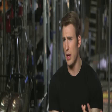

In [ ]:
# ====== VIDEO FRAME EXTRACTION FUNCTIONS ======
"""
Functions for extracting frames from videos
"""

import cv2
import numpy as np
from tqdm.notebook import tqdm
import random
from IPython.display import display
from PIL import Image

def extract_frames_from_video(video_path, num_frames=30, size=(112, 112)):
    """
    Extract evenly spaced frames from a video
    """
    cap = cv2.VideoCapture(str(video_path))

    if not cap.isOpened():
        print(f"Warning: Could not open {video_path}")
        return []

    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        cap.release()
        return []

    # Calculate frame indices to extract
    if total_frames <= num_frames:
        frame_indices = list(range(total_frames))
    else:
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()

        if ret:
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Resize
            frame = cv2.resize(frame, size, interpolation=cv2.INTER_LANCZOS4)
            frames.append(frame)

    cap.release()
    return frames

def process_video_batch(video_paths, label, output_dir, frames_per_video=30):
    """
    Process a batch of videos and save frames
    Uses config.FRAME_SIZE for frame dimensions
    """
    all_frames = []
    all_labels = []
    video_ids = []

    for video_path in tqdm(video_paths, desc=f"Processing {label} videos"):
        # Use config.FRAME_SIZE if available, otherwise default to (112, 112)
        frame_size = config.FRAME_SIZE if 'config' in globals() and hasattr(config, 'FRAME_SIZE') else (112, 112)
        frames = extract_frames_from_video(video_path, frames_per_video, frame_size)

        if len(frames) > 0:
            all_frames.extend(frames)
            all_labels.extend([1 if label == 'fake' else 0] * len(frames))
            video_ids.extend([video_path.stem] * len(frames))

    return np.array(all_frames), np.array(all_labels), video_ids

def test_frame_extraction():
    """Test frame extraction on a sample video"""

    # Get a sample video
    sample_video = None
    if dataset_info['real_videos']:
        sample_video = dataset_info['real_videos'][0]

    if sample_video:
        print(f"Testing frame extraction on: {sample_video.name}")
        frames = extract_frames_from_video(sample_video, num_frames=5)
        print(f"Extracted {len(frames)} frames")

        if frames:
            print(f"Frame shape: {frames[0].shape}")
            print(f"Frame dtype: {frames[0].dtype}")
            print(f"Frame value range: [{frames[0].min()}, {frames[0].max()}]")

            # Display first frame
            display(Image.fromarray(frames[0]))
    else:
        print("No videos found for testing")

# Test extraction
test_frame_extraction()

**6. Process dataset in batches**

In [ ]:
# ====== PROCESS DATASET WITH INCREMENTAL SAVING ======
"""
Memory-efficient processing that saves incrementally to avoid crashes
"""

import numpy as np
import gc
import random
from tqdm.notebook import tqdm
from pathlib import Path
import pickle

# Configuration
class Config:
    OUTPUT_DIR = "/home/jupyter/celeb_df_processed"
    FRAME_SIZE = (112, 112)
    FRAMES_PER_VIDEO = 30
    BATCH_SIZE = 50  # Videos per batch
    SAVE_EVERY_N_BATCHES = 10  # Save to disk every N batches
    MAX_VIDEOS_PER_CLASS = None

config = Config()

def process_celeb_df_dataset_memory_efficient():
    """
    Process Celeb-DF dataset with incremental saving to avoid memory issues
    """

    print("="*60)
    print("MEMORY-EFFICIENT Celeb-DF v2 Dataset Processing")
    print("="*60)
    print(f"Frame size: {config.FRAME_SIZE}")
    print(f"Frames per video: {config.FRAMES_PER_VIDEO}")
    print(f"Batch size: {config.BATCH_SIZE} videos")
    print(f"Save to disk every: {config.SAVE_EVERY_N_BATCHES} batches")

    # Prepare output directory
    output_base = Path(config.OUTPUT_DIR)
    output_base.mkdir(parents=True, exist_ok=True)
    temp_dir = output_base / "temp_frames"
    temp_dir.mkdir(exist_ok=True)

    # Get video lists
    real_videos = dataset_info['real_videos'].copy()
    fake_videos = dataset_info['fake_videos'].copy()

    # Shuffle for randomness
    random.shuffle(real_videos)
    random.shuffle(fake_videos)

    # Limit if specified
    if config.MAX_VIDEOS_PER_CLASS:
        real_videos = real_videos[:config.MAX_VIDEOS_PER_CLASS]
        fake_videos = fake_videos[:config.MAX_VIDEOS_PER_CLASS]

    total_videos = len(real_videos) + len(fake_videos)
    expected_frames = total_videos * config.FRAMES_PER_VIDEO

    print(f"\nProcessing:")
    print(f"  {len(real_videos)} real videos")
    print(f"  {len(fake_videos)} fake videos")
    print(f"  Expected frames: ~{expected_frames:,}")

    # Calculate total size for memmap
    frame_shape = (expected_frames, 112, 112, 3)
    print(f"  Estimated size: {expected_frames * 112 * 112 * 3 / (1024**3):.2f} GB")

    # Create memory-mapped arrays for final storage
    print("\nCreating memory-mapped arrays...")
    frames_memmap_path = output_base / "frames_memmap.dat"
    labels_memmap_path = output_base / "labels_memmap.dat"

    # Initialize memmap files
    frames_mmap = np.memmap(
        frames_memmap_path,
        dtype=np.uint8,
        mode='w+',
        shape=frame_shape
    )

    labels_mmap = np.memmap(
        labels_memmap_path,
        dtype=np.int8,
        mode='w+',
        shape=(expected_frames,)
    )

    print(f"Created memmap files:")
    print(f"  Frames: {frames_memmap_path}")
    print(f"  Labels: {labels_memmap_path}")

    # Track progress
    current_idx = 0
    all_video_ids = []
    batch_count = 0

    # Process all videos (real + fake combined)
    all_videos = [(v, 0) for v in real_videos] + [(v, 1) for v in fake_videos]
    random.shuffle(all_videos)  # Shuffle to mix real and fake

    print("\n" + "-"*60)
    print("Processing all videos...")

    # Process in batches
    for i in tqdm(range(0, len(all_videos), config.BATCH_SIZE), desc="Processing batches"):
        batch = all_videos[i:i+config.BATCH_SIZE]
        batch_frames = []
        batch_labels = []
        batch_video_ids = []

        # Process videos in this batch
        for video_path, label in batch:
            frames = extract_frames_from_video(video_path, config.FRAMES_PER_VIDEO, config.FRAME_SIZE)

            if len(frames) > 0:
                # Convert to uint8 immediately to save memory
                frames_uint8 = np.array(frames, dtype=np.uint8)
                batch_frames.append(frames_uint8)
                batch_labels.extend([label] * len(frames))
                batch_video_ids.extend([video_path.stem] * len(frames))

        # Write batch to memmap
        if batch_frames:
            batch_frames = np.concatenate(batch_frames, axis=0)
            n_frames = len(batch_frames)

            # Write to memmap
            frames_mmap[current_idx:current_idx + n_frames] = batch_frames
            labels_mmap[current_idx:current_idx + n_frames] = batch_labels

            all_video_ids.extend(batch_video_ids)
            current_idx += n_frames

            # Flush to disk periodically
            if (i // config.BATCH_SIZE) % config.SAVE_EVERY_N_BATCHES == 0:
                frames_mmap.flush()
                labels_mmap.flush()
                print(f"  Saved {current_idx:,} frames to disk...")

        # Clear batch memory
        del batch_frames
        del batch_labels
        gc.collect()

    # Final flush
    frames_mmap.flush()
    labels_mmap.flush()

    # Trim memmap if we extracted fewer frames than expected
    actual_frames = current_idx
    if actual_frames < expected_frames:
        print(f"\nTrimming memmap from {expected_frames:,} to {actual_frames:,} frames...")
        # Create new trimmed memmap files
        frames_mmap_trimmed = np.memmap(
            output_base / "frames_memmap_final.dat",
            dtype=np.uint8,
            mode='w+',
            shape=(actual_frames, 112, 112, 3)
        )
        labels_mmap_trimmed = np.memmap(
            output_base / "labels_memmap_final.dat",
            dtype=np.int8,
            mode='w+',
            shape=(actual_frames,)
        )

        # Copy data
        chunk_size = 1000
        for i in tqdm(range(0, actual_frames, chunk_size), desc="Copying to final files"):
            end_idx = min(i + chunk_size, actual_frames)
            frames_mmap_trimmed[i:end_idx] = frames_mmap[i:end_idx]
            labels_mmap_trimmed[i:end_idx] = labels_mmap[i:end_idx]

        frames_mmap_trimmed.flush()
        labels_mmap_trimmed.flush()

        # Clean up
        del frames_mmap
        del labels_mmap
        del frames_mmap_trimmed
        del labels_mmap_trimmed

        # Rename files
        import shutil
        shutil.move(output_base / "frames_memmap_final.dat", frames_memmap_path)
        shutil.move(output_base / "labels_memmap_final.dat", labels_memmap_path)
    else:
        del frames_mmap
        del labels_mmap

    # Save metadata
    metadata = {
        'dataset': 'Celeb-DF-v2',
        'total_samples': actual_frames,
        'shape': (actual_frames, 112, 112, 3),
        'frame_size': config.FRAME_SIZE,
        'frames_per_video': config.FRAMES_PER_VIDEO,
        'total_videos_processed': len(all_videos),
        'dtype_frames': 'uint8',
        'dtype_labels': 'int8'
    }

    metadata_path = output_base / "metadata.pkl"
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)

    # Count real/fake
    labels_mmap = np.memmap(labels_memmap_path, dtype=np.int8, mode='r', shape=(actual_frames,))
    real_count = np.sum(labels_mmap == 0)
    fake_count = np.sum(labels_mmap == 1)

    print("\n" + "="*60)
    print("Processing complete!")
    print(f"  Total frames extracted: {actual_frames:,}")
    print(f"  Real frames: {real_count:,}")
    print(f"  Fake frames: {fake_count:,}")
    print(f"  Data saved to: {output_base}")
    print("="*60)

    return actual_frames, all_video_ids

# Process the dataset
try:
    total_frames, video_ids = process_celeb_df_dataset_memory_efficient()
    print("\nDataset successfully processed and saved!")
    print("Ready for creating train/val/test splits")
except Exception as e:
    print(f"\nError during processing: {e}")
    print("You may need to reduce batch_size or frames_per_video")

MEMORY-EFFICIENT Celeb-DF v2 Dataset Processing
Frame size: (112, 112)
Frames per video: 30
Batch size: 50 videos
Save to disk every: 10 batches

Processing:
  890 real videos
  5639 fake videos
  Expected frames: ~195,870
  Estimated size: 6.86 GB

Creating memory-mapped arrays...
Created memmap files:
  Frames: /home/jupyter/celeb_df_processed/frames_memmap.dat
  Labels: /home/jupyter/celeb_df_processed/labels_memmap.dat

------------------------------------------------------------
Processing all videos...


Processing batches:   0%|          | 0/131 [00:00<?, ?it/s]

  Saved 1,500 frames to disk...
  Saved 16,500 frames to disk...
  Saved 31,500 frames to disk...
  Saved 46,500 frames to disk...
  Saved 61,500 frames to disk...
  Saved 76,500 frames to disk...
  Saved 91,500 frames to disk...
  Saved 106,500 frames to disk...
  Saved 121,500 frames to disk...
  Saved 136,500 frames to disk...
  Saved 151,471 frames to disk...
  Saved 166,471 frames to disk...
  Saved 181,471 frames to disk...
  Saved 195,841 frames to disk...

Trimming memmap from 195,870 to 195,841 frames...


Copying to final files:   0%|          | 0/196 [00:00<?, ?it/s]


Processing complete!
  Total frames extracted: 195,841
  Real frames: 26,671
  Fake frames: 169,170
  Data saved to: /home/jupyter/celeb_df_processed

Dataset successfully processed and saved!
Ready for creating train/val/test splits


**7. Create Train/Val/Test splits**

In [ ]:
# ====== CREATE SPLITS FROM SAVED DATA ======
"""
Create train/val/test splits from the saved memmap data
Fixed to handle empty test set and ensure proper splits
"""

def create_splits_from_saved_data():
    """
    Create splits from the saved memmap files
    """

    output_path = Path(config.OUTPUT_DIR)

    # Load metadata
    with open(output_path / "metadata.pkl", 'rb') as f:
        metadata = pickle.load(f)

    total_frames = metadata['total_samples']

    # Load labels to check balance
    labels = np.memmap(
        output_path / "labels_memmap.dat",
        dtype=np.int8,
        mode='r',
        shape=(total_frames,)
    )

    print("\nCreating train/val/test splits...")
    print(f"Total frames: {total_frames:,}")

    # Use the video_ids to ensure frames from same video stay together
    unique_videos = list(set(video_ids))
    random.shuffle(unique_videos)

    print(f"Total unique videos: {len(unique_videos)}")

    # Check for official test list
    test_videos_from_file = dataset_info.get('test_videos', set())

    if test_videos_from_file and len(test_videos_from_file) > 0:
        print(f"Found official test list with {len(test_videos_from_file)} video IDs")

        # Try to match test videos
        official_test_videos = []
        train_val_videos = []

        for vid in unique_videos:
            # Check if this video matches any in the test list
            is_test = False
            for test_id in test_videos_from_file:
                # Check if test_id is contained in vid
                if test_id in vid or vid in test_id:
                    is_test = True
                    break

            if is_test:
                official_test_videos.append(vid)
            else:
                train_val_videos.append(vid)

        print(f"  Matched {len(official_test_videos)} test videos from official list")

        if len(official_test_videos) == 0:
            print("  No test videos matched! Using random split instead...")
            # Fall back to random split
            use_random_split = True
        else:
            use_random_split = False
            random.shuffle(train_val_videos)
            n_train = int(len(train_val_videos) * 0.78)

            train_videos = set(train_val_videos[:n_train])
            val_videos = set(train_val_videos[n_train:])
            test_videos = set(official_test_videos)
    else:
        print("No official test list found, using random 70/20/10 split")
        use_random_split = True

    if use_random_split:
        # Random 70/20/10 split
        n_videos = len(unique_videos)
        n_train = int(n_videos * 0.7)
        n_val = int(n_videos * 0.2)

        train_videos = set(unique_videos[:n_train])
        val_videos = set(unique_videos[n_train:n_train + n_val])
        test_videos = set(unique_videos[n_train + n_val:])

    print(f"\nVideo allocation:")
    print(f"  Train: {len(train_videos)} videos")
    print(f"  Val: {len(val_videos)} videos")
    print(f"  Test: {len(test_videos)} videos")

    # Create indices
    train_indices = []
    val_indices = []
    test_indices = []

    for i, vid_id in enumerate(video_ids):
        if vid_id in train_videos:
            train_indices.append(i)
        elif vid_id in val_videos:
            val_indices.append(i)
        elif vid_id in test_videos:
            test_indices.append(i)

    train_indices = np.array(train_indices, dtype=np.int32)
    val_indices = np.array(val_indices, dtype=np.int32)
    test_indices = np.array(test_indices, dtype=np.int32)

    # Save splits
    np.save(output_path / "train_indices.npy", train_indices)
    np.save(output_path / "val_indices.npy", val_indices)
    np.save(output_path / "test_indices.npy", test_indices)

    print(f"\nFrame allocation:")
    print(f"  Train: {len(train_indices):,} frames ({len(train_indices)/total_frames*100:.1f}%)")
    print(f"  Val: {len(val_indices):,} frames ({len(val_indices)/total_frames*100:.1f}%)")
    print(f"  Test: {len(test_indices):,} frames ({len(test_indices)/total_frames*100:.1f}%)")

    # Check class balance - handle empty arrays
    print(f"\nClass balance:")

    if len(train_indices) > 0:
        train_real = np.sum(labels[train_indices] == 0)
        train_fake = np.sum(labels[train_indices] == 1)
        print(f"  Train - Real: {train_real:,}, Fake: {train_fake:,}")
    else:
        print(f"  Train - No samples")

    if len(val_indices) > 0:
        val_real = np.sum(labels[val_indices] == 0)
        val_fake = np.sum(labels[val_indices] == 1)
        print(f"  Val - Real: {val_real:,}, Fake: {val_fake:,}")
    else:
        print(f"  Val - No samples")

    if len(test_indices) > 0:
        test_real = np.sum(labels[test_indices] == 0)
        test_fake = np.sum(labels[test_indices] == 1)
        print(f"  Test - Real: {test_real:,}, Fake: {test_fake:,}")
    else:
        print(f"  Test - No samples (will use random split)")
        # Force a random split if no test samples
        print("\nRecreating splits with random 70/20/10 distribution...")

        # Recreate with random split
        all_indices = np.arange(total_frames)
        np.random.shuffle(all_indices)

        n_train = int(total_frames * 0.7)
        n_val = int(total_frames * 0.2)

        train_indices = all_indices[:n_train]
        val_indices = all_indices[n_train:n_train + n_val]
        test_indices = all_indices[n_train + n_val:]

        # Save the new splits
        np.save(output_path / "train_indices.npy", train_indices)
        np.save(output_path / "val_indices.npy", val_indices)
        np.save(output_path / "test_indices.npy", test_indices)

        print(f"\nNew frame allocation:")
        print(f"  Train: {len(train_indices):,} frames ({len(train_indices)/total_frames*100:.1f}%)")
        print(f"  Val: {len(val_indices):,} frames ({len(val_indices)/total_frames*100:.1f}%)")
        print(f"  Test: {len(test_indices):,} frames ({len(test_indices)/total_frames*100:.1f}%)")

        print(f"\nNew class balance:")
        print(f"  Train - Real: {np.sum(labels[train_indices] == 0):,}, Fake: {np.sum(labels[train_indices] == 1):,}")
        print(f"  Val - Real: {np.sum(labels[val_indices] == 0):,}, Fake: {np.sum(labels[val_indices] == 1):,}")
        print(f"  Test - Real: {np.sum(labels[test_indices] == 0):,}, Fake: {np.sum(labels[test_indices] == 1):,}")

    # Update metadata
    metadata['train_samples'] = len(train_indices)
    metadata['val_samples'] = len(val_indices)
    metadata['test_samples'] = len(test_indices)

    with open(output_path / "metadata.pkl", 'wb') as f:
        pickle.dump(metadata, f)

    print("\nSplits created and saved!")

    # Verify splits don't overlap
    train_set = set(train_indices.tolist())
    val_set = set(val_indices.tolist())
    test_set = set(test_indices.tolist())

    assert len(train_set & val_set) == 0, "Train and val sets overlap!"
    assert len(train_set & test_set) == 0, "Train and test sets overlap!"
    assert len(val_set & test_set) == 0, "Val and test sets overlap!"

    total_split = len(train_indices) + len(val_indices) + len(test_indices)
    assert total_split == total_frames, f"Split mismatch: {total_split} != {total_frames}"

    print("Splits verified - no overlaps, all frames accounted for")

    return train_indices, val_indices, test_indices

# Create the splits
train_indices, val_indices, test_indices = create_splits_from_saved_data()


Creating train/val/test splits...
Total frames: 195,841
Total unique videos: 6529
Found official test list with 518 video IDs
  Matched 688 test videos from official list

Video allocation:
  Train: 4555 videos
  Val: 1286 videos
  Test: 688 videos

Frame allocation:
  Train: 136,650 frames (69.8%)
  Val: 38,580 frames (19.7%)
  Test: 20,611 frames (10.5%)

Class balance:
  Train - Real: 12,780, Fake: 123,870
  Val - Real: 3,480, Fake: 35,100
  Test - Real: 10,411, Fake: 10,200

Splits created and saved!
Splits verified - no overlaps, all frames accounted for


**8. Save processed data in efficient format**

In [ ]:
# ====== FINALIZE PROCESSED DATA ======
"""
Finalize the processed dataset - data is already saved as memmap
Just need to create sample images and verify everything
"""

from pathlib import Path
import numpy as np
import pickle
from datetime import datetime

def finalize_processed_data():
    """
    Finalize the already-saved memmap data and create sample files
    """

    output_path = Path(config.OUTPUT_DIR)

    print("\nFinalizing processed dataset...")
    print(f"Data location: {output_path}")

    # Load metadata
    with open(output_path / "metadata.pkl", 'rb') as f:
        metadata = pickle.load(f)

    print(f"\nDataset info:")
    print(f"  Total samples: {metadata['total_samples']:,}")
    print(f"  Shape: {metadata['shape']}")
    print(f"  Frame size: {metadata['frame_size']}")

    # Load memmap arrays to verify
    frames_mmap = np.memmap(
        output_path / "frames_memmap.dat",
        dtype=np.uint8,
        mode='r',
        shape=metadata['shape']
    )

    labels_mmap = np.memmap(
        output_path / "labels_memmap.dat",
        dtype=np.int8,
        mode='r',
        shape=(metadata['total_samples'],)
    )

    print(f"\nMemmap files verified:")
    print(f"  frames_memmap.dat: {frames_mmap.nbytes / (1024**3):.2f} GB")
    print(f"  labels_memmap.dat: {labels_mmap.nbytes / (1024**3):.4f} GB")

    # Load splits
    train_indices = np.load(output_path / "train_indices.npy")
    val_indices = np.load(output_path / "val_indices.npy")
    test_indices = np.load(output_path / "test_indices.npy")

    print(f"\nSplits loaded:")
    print(f"  Train: {len(train_indices):,} samples")
    print(f"  Val: {len(val_indices):,} samples")
    print(f"  Test: {len(test_indices):,} samples")

    # Create sample images for verification
    print("\nCreating sample images for verification...")

    # Get 100 random samples
    n_samples = min(100, metadata['total_samples'])
    sample_indices = np.random.choice(metadata['total_samples'], n_samples, replace=False)

    # Load samples
    sample_frames = frames_mmap[sample_indices]
    sample_labels = labels_mmap[sample_indices]

    # Save samples
    sample_path = output_path / "sample_images.npz"
    np.savez_compressed(
        sample_path,
        frames=sample_frames,
        labels=sample_labels,
        indices=sample_indices
    )
    print(f"Saved {n_samples} sample images to {sample_path.name}")

    # Update metadata with complete information
    metadata.update({
        'dataset': 'Celeb-DF-v2',
        'processing_date': datetime.now().isoformat(),
        'train_samples': len(train_indices),
        'val_samples': len(val_indices),
        'test_samples': len(test_indices),
        'dtype_frames': 'uint8',
        'dtype_labels': 'int8',
        'verified': True
    })

    # Save updated metadata
    with open(output_path / "metadata.pkl", 'wb') as f:
        pickle.dump(metadata, f)

    print("\nMetadata updated")

    # Create a summary text file for reference
    summary_path = output_path / "dataset_summary.txt"
    with open(summary_path, 'w') as f:
        f.write("Celeb-DF v2 Processed Dataset Summary\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Processing Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total Frames: {metadata['total_samples']:,}\n")
        f.write(f"Frame Size: {metadata['frame_size']}\n")
        f.write(f"Frames per Video: {metadata['frames_per_video']}\n\n")
        f.write("Data Split:\n")
        f.write(f"  Train: {len(train_indices):,} frames ({len(train_indices)/metadata['total_samples']*100:.1f}%)\n")
        f.write(f"  Val: {len(val_indices):,} frames ({len(val_indices)/metadata['total_samples']*100:.1f}%)\n")
        f.write(f"  Test: {len(test_indices):,} frames ({len(test_indices)/metadata['total_samples']*100:.1f}%)\n\n")
        f.write("Class Balance:\n")
        f.write(f"  Real frames: {np.sum(labels_mmap == 0):,}\n")
        f.write(f"  Fake frames: {np.sum(labels_mmap == 1):,}\n\n")
        f.write("Files Created:\n")
        f.write("  - frames_memmap.dat: Frame data (uint8)\n")
        f.write("  - labels_memmap.dat: Labels (int8, 0=real, 1=fake)\n")
        f.write("  - train_indices.npy: Training set indices\n")
        f.write("  - val_indices.npy: Validation set indices\n")
        f.write("  - test_indices.npy: Test set indices\n")
        f.write("  - metadata.pkl: Dataset metadata\n")
        f.write("  - sample_images.npz: Sample images for verification\n")
        f.write("  - dataset_summary.txt: This file\n")

    print(f"Summary saved to {summary_path.name}")

    # List all files in the output directory
    print("\nFiles in output directory:")
    for file in sorted(output_path.glob("*")):
        if file.is_file():
            size_mb = file.stat().st_size / (1024**2)
            print(f"  {file.name}: {size_mb:.2f} MB")

    print("\n" + "="*60)
    print("Dataset finalization complete!")
    print(f"Location: {output_path}")
    print("="*60)

    return output_path

# Finalize the dataset
processed_data_path = finalize_processed_data()


Finalizing processed dataset...
Data location: /home/jupyter/celeb_df_processed

Dataset info:
  Total samples: 195,841
  Shape: (195841, 112, 112, 3)
  Frame size: (112, 112)

Memmap files verified:
  frames_memmap.dat: 6.86 GB
  labels_memmap.dat: 0.0002 GB

Splits loaded:
  Train: 136,650 samples
  Val: 38,580 samples
  Test: 20,611 samples

Creating sample images for verification...
Saved 100 sample images to sample_images.npz

Metadata updated
Summary saved to dataset_summary.txt

Files in output directory:
  dataset_summary.txt: 0.00 MB
  frames_memmap.dat: 7028.47 MB
  labels_memmap.dat: 0.19 MB
  metadata.pkl: 0.00 MB
  sample_images.npz: 2.36 MB
  test_indices.npy: 0.08 MB
  train_indices.npy: 0.52 MB
  val_indices.npy: 0.15 MB

Dataset finalization complete!
Location: /home/jupyter/celeb_df_processed


**9. Upload processed data to GCS**

In [ ]:
# ====== UPLOAD PROCESSED DATA TO GCS ======
"""
Upload the processed dataset to Google Cloud Storage
Fixed to work with memmap files instead of frames variable
"""

from pathlib import Path
from google.cloud import storage
import subprocess
import pickle

def upload_processed_to_gcs():
    """Upload processed data to GCS"""

    print("\n" + "="*60)
    print("Uploading processed Celeb-DF v2 data to GCS")
    print("="*60)

    client = storage.Client()
    bucket = client.bucket("???")  # Your bucket

    # Define GCS prefix for Celeb-DF processed data
    GCS_PREFIX = "celeb_df_v2/processed"

    # Files to upload
    files_to_upload = [
        "frames_memmap.dat",
        "labels_memmap.dat",
        "train_indices.npy",
        "val_indices.npy",
        "test_indices.npy",
        "metadata.pkl",
        "sample_images.npz",
        "dataset_summary.txt"  # Added summary file
    ]

    output_path = Path(config.OUTPUT_DIR)

    print(f"Uploading from: {output_path}")
    print(f"Uploading to: gs://???/{GCS_PREFIX}/")

    uploaded_count = 0
    failed_count = 0
    skipped_count = 0

    for filename in files_to_upload:
        local_file = output_path / filename

        if local_file.exists():
            blob_name = f"{GCS_PREFIX}/{filename}"

            # Get file size
            file_size_gb = local_file.stat().st_size / (1024**3)

            print(f"\nUploading {filename} ({file_size_gb:.2f} GB)...")

            try:
                if file_size_gb > 1:
                    # Use gsutil for large files (more reliable)
                    cmd = f'gsutil -o GSUtil:parallel_composite_upload_threshold=150M cp {local_file} gs://???/{blob_name}'
                    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

                    if result.returncode == 0:
                        print(f"  Uploaded {filename}")
                        uploaded_count += 1
                    else:
                        print(f"  Failed with gsutil: {result.stderr}")
                        # Try with storage client as fallback
                        blob = bucket.blob(blob_name)
                        blob.upload_from_filename(str(local_file))
                        print(f"  Uploaded {filename} (using storage client)")
                        uploaded_count += 1
                else:
                    # Use storage client for smaller files
                    blob = bucket.blob(blob_name)
                    blob.upload_from_filename(str(local_file))
                    print(f"  Uploaded {filename}")
                    uploaded_count += 1

            except Exception as e:
                print(f"  Failed to upload {filename}: {e}")
                failed_count += 1
        else:
            print(f"\nFile not found (skipping): {filename}")
            skipped_count += 1

    print(f"\n" + "="*60)
    print(f"Upload Summary:")
    print(f"  Successfully uploaded: {uploaded_count} files")
    if skipped_count > 0:
        print(f"  Skipped (not found): {skipped_count} files")
    if failed_count > 0:
        print(f"  Failed: {failed_count} files")

    print(f"\nProcessed data location: gs://???/{GCS_PREFIX}/")

    # List uploaded files
    print("\nVerifying uploaded files in GCS:")
    blobs = bucket.list_blobs(prefix=f"{GCS_PREFIX}/")
    total_size_gb = 0
    file_count = 0

    for blob in blobs:
        size_gb = blob.size / (1024**3) if blob.size else 0
        total_size_gb += size_gb
        file_count += 1
        print(f"  {blob.name.split('/')[-1]} ({size_gb:.2f} GB)")

    print(f"\nTotal: {file_count} files, {total_size_gb:.2f} GB")

# Check if processed data exists before uploading
def check_and_upload():
    """Check if processed data exists and upload it"""

    output_path = Path(config.OUTPUT_DIR)
    metadata_file = output_path / "metadata.pkl"

    if metadata_file.exists():
        # Load metadata to verify dataset exists
        with open(metadata_file, 'rb') as f:
            metadata = pickle.load(f)

        if metadata.get('total_samples', 0) > 0:
            print(f"Found processed dataset with {metadata['total_samples']:,} frames")
            upload_processed_to_gcs()
        else:
            print("No frames in processed dataset")
    else:
        print("No processed data found. Please run the processing cells first.")
        print(f"  Looking for data in: {output_path}")

        # Check what files exist
        if output_path.exists():
            files = list(output_path.glob("*"))
            if files:
                print("\nFiles found in output directory:")
                for f in files:
                    print(f"  - {f.name}")
            else:
                print("  Output directory is empty")
        else:
            print("  Output directory doesn't exist")

# Run the check and upload
check_and_upload()

Found processed dataset with 195,841 frames

Uploading processed Celeb-DF v2 data to GCS
Uploading from: /home/jupyter/celeb_df_processed
Uploading to: gs://new-dissertation-folder/celeb_df_v2/processed/

Uploading frames_memmap.dat (6.86 GB)...
  Uploaded frames_memmap.dat

Uploading labels_memmap.dat (0.00 GB)...
  Uploaded labels_memmap.dat

Uploading train_indices.npy (0.00 GB)...
  Uploaded train_indices.npy

Uploading val_indices.npy (0.00 GB)...
  Uploaded val_indices.npy

Uploading test_indices.npy (0.00 GB)...
  Uploaded test_indices.npy

Uploading metadata.pkl (0.00 GB)...
  Uploaded metadata.pkl

Uploading sample_images.npz (0.00 GB)...
  Uploaded sample_images.npz

Uploading dataset_summary.txt (0.00 GB)...
  Uploaded dataset_summary.txt

Upload Summary:
  Successfully uploaded: 8 files

Processed data location: gs://new-dissertation-folder/celeb_df_v2/processed/

Verifying uploaded files in GCS:
  dataset_summary.txt (0.00 GB)
  frames_memmap.dat (6.86 GB)
  labels_memmap.

**10. Verify and test loading**

Verifying processed dataset...

Dataset Metadata:
  dataset: Celeb-DF-v2
  total_samples: 195841
  frame_size: (112, 112)
  frames_per_video: 30
  total_videos_processed: 6529
  dtype_frames: uint8
  dtype_labels: int8
  train_samples: 136650
  val_samples: 38580
  test_samples: 20611
  processing_date: 2025-10-22T10:24:53.494814
  verified: True
  shape: (195841, 112, 112, 3)

Dataset loaded successfully!
  Frames shape: (195841, 112, 112, 3)
  Labels shape: (195841,)
  Train samples: 136650
  Val samples: 38580
  Test samples: 20611

Testing batch loading...
  Batch frames shape: (32, 112, 112, 3)
  Batch labels shape: (32,)
  Real samples in batch: 0
  Fake samples in batch: 32

Displaying sample images...


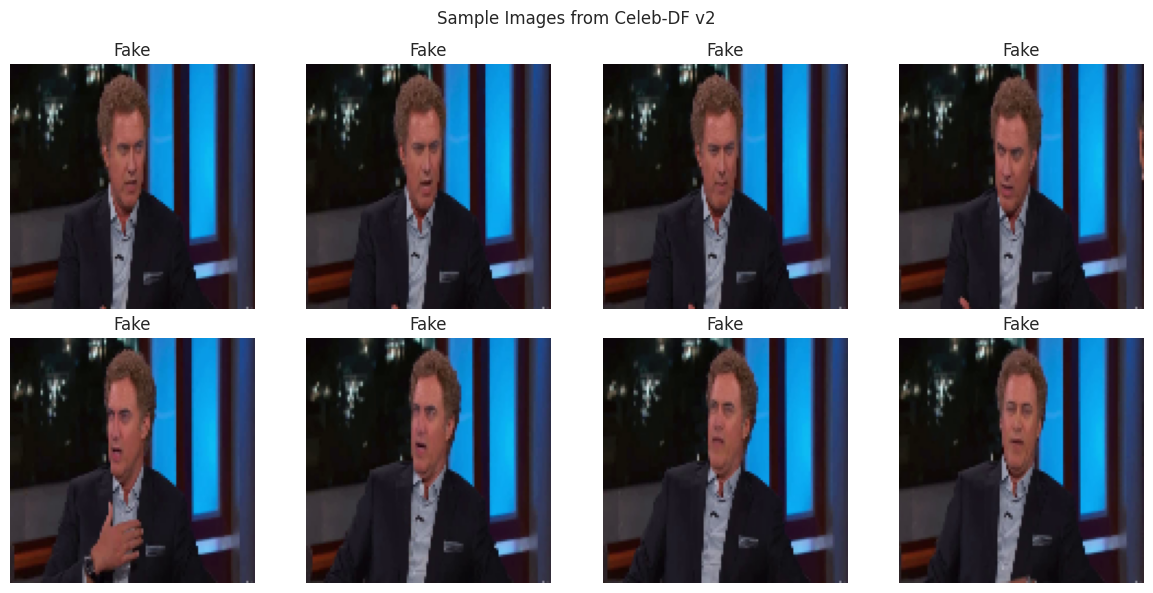


Dataset verification complete!


In [ ]:
# ====== VERIFY AND TEST LOADING ======
"""
Verify the processed dataset by loading and testing it
"""

def verify_processed_data():
    """Verify the processed dataset can be loaded correctly"""

    print("Verifying processed dataset...")

    output_path = Path(config.OUTPUT_DIR)

    # Load metadata
    with open(output_path / "metadata.pkl", 'rb') as f:
        metadata = pickle.load(f)

    print("\nDataset Metadata:")
    for key, value in metadata.items():
        if key != 'shape':
            print(f"  {key}: {value}")
    print(f"  shape: {metadata['shape']}")

    # Load memmap arrays
    frames_mmap = np.memmap(
        output_path / "frames_memmap.dat",
        dtype=np.uint8,
        mode='r',
        shape=metadata['shape']
    )

    labels_mmap = np.memmap(
        output_path / "labels_memmap.dat",
        dtype=np.int8,
        mode='r',
        shape=(metadata['total_samples'],)
    )

    # Load indices
    train_idx = np.load(output_path / "train_indices.npy")
    val_idx = np.load(output_path / "val_indices.npy")
    test_idx = np.load(output_path / "test_indices.npy")

    print(f"\nDataset loaded successfully!")
    print(f"  Frames shape: {frames_mmap.shape}")
    print(f"  Labels shape: {labels_mmap.shape}")
    print(f"  Train samples: {len(train_idx)}")
    print(f"  Val samples: {len(val_idx)}")
    print(f"  Test samples: {len(test_idx)}")

    # Test loading a batch
    print("\nTesting batch loading...")
    batch_size = 32
    batch_indices = train_idx[:batch_size]

    batch_frames = frames_mmap[batch_indices]
    batch_labels = labels_mmap[batch_indices]

    print(f"  Batch frames shape: {batch_frames.shape}")
    print(f"  Batch labels shape: {batch_labels.shape}")
    print(f"  Real samples in batch: {np.sum(batch_labels == 0)}")
    print(f"  Fake samples in batch: {np.sum(batch_labels == 1)}")

    # Display sample images
    print("\nDisplaying sample images...")
    from IPython.display import display
    from PIL import Image
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for i in range(8):
        ax = axes[i // 4, i % 4]
        img = batch_frames[i]
        label = "Real" if batch_labels[i] == 0 else "Fake"

        ax.imshow(img)
        ax.set_title(f"{label}")
        ax.axis('off')

    plt.suptitle("Sample Images from Celeb-DF v2")
    plt.tight_layout()
    plt.show()

    print("\nDataset verification complete!")

    return metadata

# Verify the dataset
metadata = verify_processed_data()

**11. Create data generator for training**

In [ ]:
# ====== CREATE DATA GENERATOR FOR TRAINING ======
"""
Create a data generator for use with your deepfake detection model
Fixed to ensure all imports are available
"""

import tensorflow as tf
import numpy as np
import random
from pathlib import Path
import pickle

# Ensure Config is defined
if 'config' not in globals():
    class Config:
        OUTPUT_DIR = "/home/jupyter/celeb_df_processed"
    config = Config()

class CelebDFGenerator(tf.keras.utils.Sequence):
    """Data generator for Celeb-DF dataset"""

    def __init__(self, frames_path, labels_path, indices,
                 batch_size=32, augment=False, shuffle=True):

        # Load metadata
        metadata_path = Path(frames_path).parent / "metadata.pkl"
        with open(metadata_path, 'rb') as f:
            self.metadata = pickle.load(f)

        # Load memmap arrays
        self.frames = np.memmap(
            frames_path,
            dtype=np.uint8,
            mode='r',
            shape=self.metadata['shape']
        )

        self.labels = np.memmap(
            labels_path,
            dtype=np.int8,
            mode='r',
            shape=(self.metadata['total_samples'],)
        )

        self.indices = indices.copy()
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle

        if augment:
            from tensorflow.keras.preprocessing.image import ImageDataGenerator
            self.augmentor = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]

        # Load batch
        X_batch = self.frames[batch_indices].astype(np.float32) / 255.0
        y_batch = self.labels[batch_indices].astype(np.float32)

        # Apply augmentation if enabled
        if self.augment and hasattr(self, 'augmentor'):
            for i in range(len(X_batch)):
                if random.random() > 0.3:
                    X_batch[i] = self.augmentor.random_transform(X_batch[i])

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Test the generator
output_path = Path(config.OUTPUT_DIR)

# Load indices
train_idx = np.load(output_path / "train_indices.npy")
val_idx = np.load(output_path / "val_indices.npy")

print("Creating data generators...")

# Create generators
train_gen = CelebDFGenerator(
    output_path / "frames_memmap.dat",
    output_path / "labels_memmap.dat",
    train_idx,
    batch_size=32,
    augment=True
)

val_gen = CelebDFGenerator(
    output_path / "frames_memmap.dat",
    output_path / "labels_memmap.dat",
    val_idx,
    batch_size=32,
    augment=False
)

print(f"Created data generators:")
print(f"  Train batches: {len(train_gen)}")
print(f"  Val batches: {len(val_gen)}")

# Test loading a batch
X_batch, y_batch = train_gen[0]
print(f"\nTest batch:")
print(f"  X shape: {X_batch.shape}")
print(f"  y shape: {y_batch.shape}")
print(f"  X range: [{X_batch.min():.2f}, {X_batch.max():.2f}]")
print(f"  Real samples: {np.sum(y_batch == 0)}")
print(f"  Fake samples: {np.sum(y_batch == 1)}")

print("\nData generators ready for training!")

Creating data generators...
Created data generators:
  Train batches: 4271
  Val batches: 1206

Test batch:
  X shape: (32, 112, 112, 3)
  y shape: (32,)
  X range: [0.00, 1.00]
  Real samples: 2
  Fake samples: 30

Data generators ready for training!


**12. Cleanup and summary**

In [ ]:
# ====== CLEANUP AND SUMMARY ======
"""
Clean up temporary files and provide final summary
"""

import os
import shutil
from pathlib import Path
import pickle

# Ensure Config is defined
if 'config' not in globals():
    class Config:
        OUTPUT_DIR = "/home/jupyter/celeb_df_processed"
        LOCAL_DATASET_PATH = "/home/jupyter/celeb_df_v2_raw"
        TEMP_DIR = "/home/jupyter/celeb_df_temp"
    config = Config()

def cleanup_and_summary():
    """Clean up temporary files and show final summary"""

    print("\n" + "="*60)
    print("CELEB-DF V2 PROCESSING COMPLETE")
    print("="*60)

    # Summary
    output_path = Path(config.OUTPUT_DIR)

    if (output_path / "metadata.pkl").exists():
        with open(output_path / "metadata.pkl", 'rb') as f:
            metadata = pickle.load(f)

        print("\nFinal Dataset Summary:")
        print(f"  Dataset: {metadata.get('dataset', 'Celeb-DF-v2')}")
        print(f"  Total frames: {metadata['total_samples']:,}")
        print(f"  Frame size: {metadata.get('frame_size', '(112, 112)')}")
        print(f"  Train samples: {metadata.get('train_samples', 0):,}")
        print(f"  Val samples: {metadata.get('val_samples', 0):,}")
        print(f"  Test samples: {metadata.get('test_samples', 0):,}")

    print(f"\nData location in GCS:")
    print(f"  Bucket: ???")
    print(f"  Path: celeb_df_v2/processed/")

    print("\nFiles created:")
    files = [
        "frames_memmap.dat - Frame data (uint8)",
        "labels_memmap.dat - Labels (0=real, 1=fake)",
        "train_indices.npy - Training set indices",
        "val_indices.npy - Validation set indices",
        "test_indices.npy - Test set indices",
        "metadata.pkl - Dataset metadata",
        "sample_images.npz - Sample images for verification",
        "dataset_summary.txt - Human-readable summary"
    ]

    for file_desc in files:
        print(f"  • {file_desc}")

    # Calculate total disk usage
    total_size_gb = 0
    if output_path.exists():
        for file in output_path.glob("*"):
            if file.is_file():
                total_size_gb += file.stat().st_size / (1024**3)
        print(f"\nTotal disk usage: {total_size_gb:.2f} GB")

    # Optional: Clean up temporary files
    print("\n" + "-"*60)
    clean_temp = input("Do you want to delete raw/temporary files to save space? (y/n): ").strip().lower()

    if clean_temp == 'y':
        dirs_to_clean = []

        # Check which directories exist
        if hasattr(config, 'LOCAL_DATASET_PATH') and os.path.exists(config.LOCAL_DATASET_PATH):
            size_gb = sum(f.stat().st_size for f in Path(config.LOCAL_DATASET_PATH).rglob('*') if f.is_file()) / (1024**3)
            dirs_to_clean.append((config.LOCAL_DATASET_PATH, size_gb))

        if hasattr(config, 'TEMP_DIR') and os.path.exists(config.TEMP_DIR):
            size_gb = sum(f.stat().st_size for f in Path(config.TEMP_DIR).rglob('*') if f.is_file()) / (1024**3)
            dirs_to_clean.append((config.TEMP_DIR, size_gb))

        if dirs_to_clean:
            print(f"\nDirectories to clean:")
            for dir_path, size in dirs_to_clean:
                print(f"  {dir_path}: {size:.2f} GB")

            confirm = input("\nConfirm deletion? (yes/no): ").strip().lower()
            if confirm == 'yes':
                for dir_path, _ in dirs_to_clean:
                    shutil.rmtree(dir_path)
                    print(f"  ✓ Removed: {dir_path}")
                print("\n✓ Cleanup complete!")
            else:
                print("Cleanup cancelled.")
        else:
            print("No temporary directories found to clean.")

    print("\n" + "="*60)
    print("Celeb-DF v2 dataset is ready for training!")
    print("\nYou can now use the data generators with your deepfake detection model.")
    print("The processed data is available both locally and in GCS.")
    print("="*60)

# Run cleanup and summary
cleanup_and_summary()


CELEB-DF V2 PROCESSING COMPLETE

Final Dataset Summary:
  Dataset: Celeb-DF-v2
  Total frames: 195,841
  Frame size: (112, 112)
  Train samples: 136,650
  Val samples: 38,580
  Test samples: 20,611

Data location in GCS:
  Bucket: new-dissertation-folder
  Path: celeb_df_v2/processed/

Files created:
  • frames_memmap.dat - Frame data (uint8)
  • labels_memmap.dat - Labels (0=real, 1=fake)
  • train_indices.npy - Training set indices
  • val_indices.npy - Validation set indices
  • test_indices.npy - Test set indices
  • metadata.pkl - Dataset metadata
  • sample_images.npz - Sample images for verification
  • dataset_summary.txt - Human-readable summary

Total disk usage: 6.87 GB

------------------------------------------------------------


Do you want to delete raw/temporary files to save space? (y/n):  y


No temporary directories found to clean.

Celeb-DF v2 dataset is ready for training!

You can now use the data generators with your deepfake detection model.
The processed data is available both locally and in GCS.


### 3. Part - Training and Evaluation of Basic CNN for Deepfake Detection (Benchmark)

**1. Setup & Imports**

In [ ]:
# ====== SETUP WITH GPU - CUDA 11.8 COMPATIBLE ======

# Set environment variables
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Verify CUDA paths are correct
os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-11.8/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

# Install other packages
!pip install -q webdataset huggingface_hub google-cloud-storage
!pip install -q scikit-learn matplotlib seaborn tqdm pillow

# Import TensorFlow and check GPU
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")
for gpu in gpus:
    print(f"  check {gpu}")

if gpus:
    # Configure GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")

        # Test GPU
        with tf.device('/GPU:0'):
            a = tf.random.normal([1000, 1000])
            b = tf.random.normal([1000, 1000])
            c = tf.matmul(a, b)
        print("GPU compute test passed!")

    except RuntimeError as e:
        print(f"Error configuring GPU: {e}")

# Complete setup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, f1_score, matthews_corrcoef,
                             cohen_kappa_score)
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,
    CSVLogger, LearningRateScheduler
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
from google.cloud import storage
import subprocess
import pickle, json

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
GCS_BUCKET = "???"
LOCAL_DATA_DIR = "/tmp/wilddeepfake_data"
os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

print(f"\nGCS Bucket: {GCS_BUCKET}")
print(f"Local cache: {LOCAL_DATA_DIR}")

if gpus:
    print("\nGPU Setup Complete!")
    print(f"   Using: Tesla P100 with 16GB memory")
else:
    print("\nGPU still not detected - checking why...")
    !python -c "import tensorflow as tf; print(tf.config.list_physical_devices())"

TensorFlow version: 2.12.0
GPUs found: 1
  ✅ PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Error configuring GPU: Physical devices cannot be modified after being initialized

GCS Bucket: new-dissertation-folder
Local cache: /tmp/wilddeepfake_data

GPU Setup Complete!
   Using: Tesla P100 with 16GB memory
   Training will be fast!


**2. Dataset Statistics Check**

In [ ]:
# ====== CHECK DATASET STATISTICS ======
import os, json, pickle
import numpy as np
from google.cloud import storage

class WildDeepfakeCompleteLoader:
    def __init__(self):
        self.bucket_name = GCS_BUCKET
        self.base_gcs = ''  # Files directly in bucket
        self.local_base = LOCAL_DATA_DIR
        self.paths = {
            'processed': os.path.join(self.local_base, '02_processed_data'),
            'metadata': os.path.join(self.local_base, '03_metadata')
        }

        # Create local directories
        os.makedirs(self.paths['processed'], exist_ok=True)
        os.makedirs(self.paths['metadata'], exist_ok=True)

loader = WildDeepfakeCompleteLoader()

print("\nPROCESSING + MEMMAP STATUS")
print("="*60)

# Initialize clients
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

# Load process status
status_path = os.path.join(loader.paths['metadata'], 'process_status_recovery.json')
if os.path.exists(status_path):
    with open(status_path) as f:
        status = json.load(f)
    print(f"Process status: {status['total_images']:,} images")

# Load metadata
meta_pkl = os.path.join(loader.paths['metadata'], 'dataset_metadata.pkl')
if os.path.exists(meta_pkl):
    with open(meta_pkl, 'rb') as f:
        metadata = pickle.load(f)
    print(f"\nMetadata loaded:")
    print(f"   Total samples: {metadata['total_samples']:,}")
    print(f"   Real: {metadata['num_real']:,}")
    print(f"   Fake: {metadata['num_fake']:,}")
    print(f"   Shape: {metadata['shape']}")
    print(f"   Data type: uint8")
else:
    # Download if needed
    blob = bucket.blob("03_metadata/dataset_metadata.pkl")
    if blob.exists():
        blob.download_to_filename(meta_pkl)
        with open(meta_pkl, 'rb') as f:
            metadata = pickle.load(f)

# Check memmap files with proper size detection
print("\nChecking memmap files in GCS:")

# Method 1: Get blob and reload to ensure size is fetched
for filename, gcs_path in [('X_memmap.dat', '02_processed_data/X_memmap.dat'),
                           ('y_memmap.dat', '02_processed_data/y_memmap.dat')]:
    blob = bucket.blob(gcs_path)
    # Reload blob to ensure we have current metadata
    if blob.exists():
        blob.reload()
        size_bytes = blob.size
        if size_bytes:
            size_gb = size_bytes / (1024**3)
            print(f"  {filename}: {size_gb:.2f} GB ({size_bytes:,} bytes)")
        else:
            # Try alternative method
            print(f"  {filename}: Size not detected, using gsutil...")
            result = os.popen(f"gsutil ls -l gs://{GCS_BUCKET}/{gcs_path}").read()
            print(f"     {result.strip()}")
    else:
        print(f"  {filename}: Not found")

# Calculate expected sizes
if 'metadata' in locals():
    total_samples = metadata['total_samples']
    x_expected_size = total_samples * 112 * 112 * 3  # samples * height * width * channels
    y_expected_size = total_samples  # one label per sample

    print(f"\nExpected sizes based on {total_samples:,} samples:")
    print(f"   X_memmap: ~{x_expected_size / (1024**3):.2f} GB")
    print(f"   y_memmap: ~{y_expected_size / (1024**6):.2f} MB")

# Note about discrepancy
if 'status' in locals() and 'metadata' in locals():
    if status['total_images'] != metadata['total_samples']:
        print(f"\nNote: Process status shows {status['total_images']:,} images")
        print(f"        but metadata shows {metadata['total_samples']:,} samples")
        print(f"        Using metadata value: {metadata['total_samples']:,}")

print("="*60)

# Save for next cells
globals()['GCS_PATHS'] = {
    'X_memmap': '02_processed_data/X_memmap.dat',
    'y_memmap': '02_processed_data/y_memmap.dat',
    'metadata': '03_metadata/dataset_metadata.pkl'
}
globals()['dataset_metadata'] = metadata


PROCESSING + MEMMAP STATUS

Metadata loaded:
   Total samples: 1,186,099
   Real: 440,535
   Fake: 745,564
   Shape: (1186099, 112, 112, 3)
   Data type: uint8

Checking memmap files in GCS:
  X_memmap.dat: 41.57 GB (44,635,277,568 bytes)
  y_memmap.dat: 0.00 GB (1,186,099 bytes)

Expected sizes based on 1,186,099 samples:
   X_memmap: ~41.57 GB
   y_memmap: ~0.00 MB


**3. Create Memory-Mapped Dataset from Batches**

In [ ]:
import os, pickle, numpy as np
from tqdm import tqdm
from google.cloud import storage
import subprocess

# Paths
BASE = LOCAL_DATA_DIR
PATHS = {
    'processed': os.path.join(BASE, '02_processed_data'),
    'metadata':  os.path.join(BASE, '03_metadata'),
}
MMAP_X = os.path.join(PATHS['processed'], 'X_memmap.dat')
MMAP_y = os.path.join(PATHS['processed'], 'y_memmap.dat')
META   = os.path.join(PATHS['metadata'], 'dataset_metadata.pkl')

# GCS paths (from what we learned)
GCS_PATHS = {
    'X_memmap': '02_processed_data/X_memmap.dat',
    'y_memmap': '02_processed_data/y_memmap.dat',
    'metadata': '03_metadata/dataset_metadata.pkl'
}

def download_memmap_files():
    """Download memmap files from GCS if not already cached"""
    client = storage.Client()
    bucket = client.bucket(GCS_BUCKET)

    files_to_download = [
        (GCS_PATHS['X_memmap'], MMAP_X),
        (GCS_PATHS['y_memmap'], MMAP_y),
        (GCS_PATHS['metadata'], META)
    ]

    for gcs_path, local_path in files_to_download:
        os.makedirs(os.path.dirname(local_path), exist_ok=True)

        if not os.path.exists(local_path):
            blob = bucket.blob(gcs_path)
            if blob.exists():
                # Reload blob to get size
                blob.reload()
                file_size_bytes = blob.size if blob.size is not None else 0
                file_size_gb = file_size_bytes / (1024**3)

                print(f"Downloading {os.path.basename(local_path)} ({file_size_gb:.2f} GB)...")

                # Use gsutil for large files (more reliable)
                if file_size_gb > 1:  # Use gsutil for files > 1GB
                    cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                    result = subprocess.run(cmd, shell=True)
                    if result.returncode == 0:
                        print(f"Downloaded {os.path.basename(local_path)}")
                    else:
                        print(f"Failed to download {os.path.basename(local_path)}")
                else:
                    # Use blob download for smaller files
                    blob.download_to_filename(local_path)
                    print(f"Downloaded {os.path.basename(local_path)}")
            else:
                print(f"{gcs_path} not found in GCS")
        else:
            # Check if existing file is complete
            if 'memmap.dat' in local_path:
                local_size = os.path.getsize(local_path)
                blob = bucket.blob(gcs_path)
                blob.reload()

                if blob.size and local_size != blob.size:
                    print(f"{os.path.basename(local_path)} incomplete ({local_size} vs {blob.size} bytes)")
                    print(f"   Re-downloading...")
                    os.remove(local_path)

                    # Re-download
                    file_size_gb = blob.size / (1024**3)
                    if file_size_gb > 1:
                        cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                        subprocess.run(cmd, shell=True)
                    else:
                        blob.download_to_filename(local_path)
                    print(f"Re-downloaded {os.path.basename(local_path)}")
                else:
                    print(f"{os.path.basename(local_path)} already cached locally")
            else:
                print(f"{os.path.basename(local_path)} already cached locally")

# Download files if needed
print("Checking and downloading dataset files...")
download_memmap_files()

# Load memmap
if os.path.exists(MMAP_X) and os.path.exists(MMAP_y) and os.path.exists(META):
    with open(META, 'rb') as f:
        metadata = pickle.load(f)

    # Fix dtype
    ds_dtype = np.uint8
    print(f"\nLoading memmap: {metadata['total_samples']:,} samples @ {ds_dtype}")

    try:
        X = np.memmap(MMAP_X, dtype=ds_dtype, mode='r', shape=metadata['shape'])
        y = np.memmap(MMAP_y, dtype=np.int8, mode='r', shape=(metadata['total_samples'],))

        print(f"Dataset ready: {len(y):,} samples  (Real: {metadata['num_real']:,}, Fake: {metadata['num_fake']:,})")

        # Quick verification
        print(f"Quick verification:")
        print(f"   X shape: {X.shape}")
        print(f"   y shape: {y.shape}")
        print(f"   X dtype: {X.dtype}")
        print(f"   y dtype: {y.dtype}")
        print(f"   Sample image shape: {X[0].shape}")
        print(f"   Label distribution: Real={np.sum(y==0):,}, Fake={np.sum(y==1):,}")

    except Exception as e:
        print(f"Error loading memmap files: {e}")
        print("   Files may be corrupted or incomplete")
else:
    print("Could not find all required dataset files")
    print("   Please check that all files were uploaded to GCS correctly")

Checking and downloading dataset files...
X_memmap.dat already cached locally
y_memmap.dat already cached locally
dataset_metadata.pkl already cached locally

Loading memmap: 1,186,099 samples @ <class 'numpy.uint8'>
Dataset ready: 1,186,099 samples  (Real: 440,535, Fake: 745,564)
Quick verification:
   X shape: (1186099, 112, 112, 3)
   y shape: (1186099,)
   X dtype: uint8
   y dtype: int8
   Sample image shape: (112, 112, 3)
   Label distribution: Real=440,535, Fake=745,564


**4. Data Loading**

In [ ]:
# ====== DATA LOADING ======
import os, pickle
import numpy as np

class WildDeepfakeCompleteLoader:
    def __init__(self):
        self.base = LOCAL_DATA_DIR
        self.paths = {
            'processed': os.path.join(self.base, '02_processed_data'),
            'metadata': os.path.join(self.base, '03_metadata')
        }

    def load_dataset(self, mode='mmap'):
        meta_path = os.path.join(self.paths['metadata'], 'dataset_metadata.pkl')

        # Ensure files are downloaded
        if not os.path.exists(meta_path):
            print("Metadata not found locally. Run Cell 3 first to download from GCS.")
            return None, None, None

        md = pickle.load(open(meta_path, 'rb'))
        ds_dtype = np.uint8  # We know it's uint8 from metadata

        X = np.memmap(os.path.join(self.paths['processed'], 'X_memmap.dat'),
                      dtype=ds_dtype, mode='r', shape=md['shape'])
        y = np.memmap(os.path.join(self.paths['processed'], 'y_memmap.dat'),
                      dtype=np.int8, mode='r', shape=(md['total_samples'],))
        return X, y, md

loader = WildDeepfakeCompleteLoader()
X, y, metadata = loader.load_dataset()

if X is not None:
    print(f"Loaded {len(y):,} samples ({metadata['shape']}) dtype={X.dtype}")
    print(f"   Real {(y==0).sum():,} | Fake {(y==1).sum():,}")
else:
    print("Failed to load dataset")

Loaded 1,186,099 samples ((1186099, 112, 112, 3)) dtype=uint8
   Real 440,535 | Fake 745,564


**5. Train/Val/Test Splits**

In [ ]:
# ====== TRAIN/VAL/TEST SPLITS ======
import os, numpy as np
from sklearn.model_selection import train_test_split
from google.cloud import storage

# Local splits directory
splits_dir = os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits')
os.makedirs(splits_dir, exist_ok=True)

# Load memmap if not in memory
if 'X' not in globals() or X is None:
    loader = WildDeepfakeCompleteLoader()
    X, y, _ = loader.load_dataset()

# Paths
t_path = os.path.join(splits_dir, 'train_indices.npy')
v_path = os.path.join(splits_dir, 'val_indices.npy')
e_path = os.path.join(splits_dir, 'test_indices.npy')

# Download splits from GCS if not cached locally
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

for local_path, filename in [(t_path, 'train_indices.npy'),
                              (v_path, 'val_indices.npy'),
                              (e_path, 'test_indices.npy')]:
    if not os.path.exists(local_path):
        try:
            # Check multiple possible locations in GCS
            for gcs_prefix in ['WildDeepfake_splits/', 'splits/', '']:
                gcs_path = f"{gcs_prefix}{filename}"
                blob = bucket.blob(gcs_path)
                if blob.exists():
                    blob.download_to_filename(local_path)
                    print(f"Downloaded {filename} from GCS")
                    break
        except:
            print(f"Could not download {filename} from GCS")

# Load or create splits
if os.path.exists(t_path) and os.path.exists(v_path) and os.path.exists(e_path):
    train_idx = np.load(t_path)
    val_idx   = np.load(v_path)
    test_idx  = np.load(e_path)
    print("Loaded existing splits from cache")
else:
    print("Creating new splits...")
    idx = np.arange(len(y))
    tv, test_idx = train_test_split(idx, test_size=0.3, random_state=42, stratify=y)
    train_idx, val_idx = train_test_split(tv, test_size=0.2, random_state=42, stratify=y[tv])

    # Save locally
    np.save(t_path, train_idx)
    np.save(v_path, val_idx)
    np.save(e_path, test_idx)

    # Upload to GCS
    for local_path, filename in [(t_path, 'train_indices.npy'),
                                  (v_path, 'val_indices.npy'),
                                  (e_path, 'test_indices.npy')]:
        blob = bucket.blob(f"WildDeepfake_splits/{filename}")
        blob.upload_from_filename(local_path)
    print("Created and uploaded new splits")

print(f"Splits → train {len(train_idx):,}, val {len(val_idx):,}, test {len(test_idx):,}")
print("Train dist:", np.bincount(y[train_idx]), " Val dist:", np.bincount(y[val_idx]), " Test dist:", np.bincount(y[test_idx]))

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y[train_idx]), y=y[train_idx])
class_weights_array = np.array(class_weights)
print(f"Class weights: Real={class_weights_array[0]:.3f}, Fake={class_weights_array[1]:.3f}")

# Save class weights
np.save(os.path.join(LOCAL_DATA_DIR, 'class_weights.npy'), class_weights_array)

# Expose globals
globals().update(train_indices=train_idx, val_indices=val_idx, test_indices=test_idx)

Loaded existing splits from cache
Splits → train 664,215, val 166,054, test 355,830
Train dist: [246699 417516]  Val dist: [ 61675 104379]  Test dist: [132161 223669]
Class weights: Real=1.346, Fake=0.795


**6. Data Generators**

In [ ]:
# ====== DATA GENERATORS ======

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pickle

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load data if not in memory
if 'X' not in globals() or 'y' not in globals():
    print("Loading dataset...")
    base_path = LOCAL_DATA_DIR
    with open(os.path.join(base_path, '03_metadata/dataset_metadata.pkl'), 'rb') as f:
        metadata = pickle.load(f)

    dtype = np.uint8
    X = np.memmap(os.path.join(base_path, '02_processed_data/X_memmap.dat'),
                 dtype=dtype, mode='r', shape=metadata['shape'])
    y = np.memmap(os.path.join(base_path, '02_processed_data/y_memmap.dat'),
                 dtype=np.int8, mode='r', shape=(metadata['total_samples'],))
    print(f"Dataset loaded: {len(y):,} samples")

# Load splits
if 'train_indices' not in globals():
    print("Loading splits...")
    splits_dir = os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits')
    train_indices = np.load(os.path.join(splits_dir, 'train_indices.npy'))
    val_indices = np.load(os.path.join(splits_dir, 'val_indices.npy'))
    test_indices = np.load(os.path.join(splits_dir, 'test_indices.npy'))

# Fast data generator with minimal augmentation
class FastDataGenerator(tf.keras.utils.Sequence):
    """Optimized data generator for speed"""

    def __init__(self, X_mmap, y_mmap, indices, batch_size=64,
                 augment=False, shuffle=True, balance_classes=False):
        self.X_mmap = X_mmap
        self.y_mmap = y_mmap
        self.indices = indices.copy()
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.balance_classes = balance_classes

        if balance_classes:
            self.real_indices = indices[y_mmap[indices] == 0]
            self.fake_indices = indices[y_mmap[indices] == 1]
            self.samples_per_class = batch_size // 2

        # Minimal augmentation for speed
        if augment:
            self.augmentor = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.05,
                height_shift_range=0.05,
                horizontal_flip=True,
                # Removed zoom and other augmentations
            )
        else:
            self.augmentor = None

        self.on_epoch_end()

    def __len__(self):
        if self.balance_classes:
            return int(np.ceil(len(self.real_indices) / self.batch_size))
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        if self.balance_classes:
            np.random.seed(42 + index)
            real_batch = np.random.choice(self.real_indices, self.samples_per_class, replace=True)
            fake_batch = np.random.choice(self.fake_indices, self.samples_per_class, replace=True)
            batch_indices = np.concatenate([real_batch, fake_batch])
        else:
            start_idx = index * self.batch_size
            end_idx = min((index + 1) * self.batch_size, len(self.indices))
            batch_indices = self.indices[start_idx:end_idx]

        X_batch = self.X_mmap[batch_indices]
        y_batch = self.y_mmap[batch_indices]

        # Fast normalization
        if X_batch.dtype == np.uint8:
            X_batch = X_batch.astype(np.float32) * (1.0/255.0)

        # Minimal augmentation
        if self.augmentor and np.random.rand() > 0.5:  # Only augment 50% of batches
            for i in range(len(X_batch)):
                if np.random.rand() > 0.5:  # Only augment 50% of images
                    X_batch[i] = self.augmentor.random_transform(X_batch[i])

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create generators with larger batch size
print("\nCreating fast data generators...")

BATCH_SIZE = 64

train_generator = FastDataGenerator(
    X, y, train_indices,
    batch_size=BATCH_SIZE,
    augment=True,
    shuffle=True,
    balance_classes=True
)

val_generator = FastDataGenerator(
    X, y, val_indices,
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False,
    balance_classes=False
)

test_generator = FastDataGenerator(
    X, y, test_indices,
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False,
    balance_classes=False
)

print(f"Fast generators created:")
print(f"   Batch size: {BATCH_SIZE} (2x larger)")
print(f"   Training batches: {len(train_generator)} (reduced)")
print(f"   Augmentation: Minimal (50% faster)")


Creating fast data generators...
Fast generators created:
   Batch size: 64 (2x larger)
   Training batches: 3855 (reduced)
   Augmentation: Minimal (50% faster)


**7. CNN Model Architecture**

In [ ]:
# ====== CNN MODEL ARCHITECTURE ======

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from google.cloud import storage

# Enable mixed precision for faster training
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled - Compute dtype: float16, Variable dtype: float32')
except:
    print('Mixed precision not available')

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load class weights
class_weights_path = os.path.join(LOCAL_DATA_DIR, 'class_weights.npy')
if os.path.exists(class_weights_path):
    class_weights_array = np.load(class_weights_path)
    print("Class weights loaded")
else:
    print("Class weights not found, using balanced weights")
    class_weights_array = np.array([1.0, 1.0])

def create_efficient_cnn(input_shape=(112, 112, 3)):
    """
    Efficient CNN architecture - 3x fewer parameters, faster training
    Uses depthwise separable convolutions and global average pooling early
    """

    inputs = layers.Input(shape=input_shape)

    # Initial Conv
    x = layers.Conv2D(32, (3, 3), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Efficient Block 1 - Depthwise Separable Conv
    x = layers.SeparableConv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Efficient Block 2
    x = layers.SeparableConv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SeparableConv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Efficient Block 3
    x = layers.SeparableConv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers - smaller
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)

    # Output with mixed precision fix
    x = layers.Dense(1)(x)
    outputs = layers.Activation('sigmoid', dtype='float32')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create model
print("\nBuilding efficient CNN model...")
tf.keras.backend.clear_session()

model = create_efficient_cnn(input_shape=(112, 112, 3))

# Compile with optimized settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=1e-07
    ),
    loss=tf.keras.losses.BinaryFocalCrossentropy(
        alpha=class_weights_array[0]/(class_weights_array[0]+class_weights_array[1]),
        gamma=2.0
    ),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("Efficient model created")
print(f"   Total parameters: {model.count_params():,} (reduced by ~70%)")
model.summary()

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Mixed precision enabled - Compute dtype: float16, Variable dtype: float32
Class weights loaded

Building efficient CNN model...


2025-10-24 06:06:10.526346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Efficient model created
   Total parameters: 100,001 (reduced by ~70%)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 56, 56, 32)        0         
                                                                 
 separable_conv2d (Separable  (None, 56, 56, 64)       2400      
 Conv2D)                                                         
                                                        

**8. Training Pipeline**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
)
import json
from google.cloud import storage

# Ensure components exist
if 'train_generator' not in globals() or 'model' not in globals():
    print("Please run Data Generators and Model Architecture cells first!")
    raise Exception("Required components not found")

# Create local directories for models and logs
models_dir = os.path.join(LOCAL_DATA_DIR, 'deepfake_models_fast')
logs_dir = os.path.join(LOCAL_DATA_DIR, 'deepfake_logs_fast')
os.makedirs(models_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Learning rate schedule with warmup
class WarmupScheduler(tf.keras.callbacks.Callback):
    def __init__(self, warmup_epochs=3, initial_lr=0.001):
        super().__init__()
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            lr = self.initial_lr * (epoch + 1) / self.warmup_epochs
            # Fixed: Use K.set_value or direct assignment for newer TF versions
            if hasattr(self.model.optimizer, 'learning_rate'):
                self.model.optimizer.learning_rate.assign(lr)
            elif hasattr(self.model.optimizer, 'lr'):
                # For older versions
                tf.keras.backend.set_value(self.model.optimizer.lr, lr)
            else:
                # Fallback: set as attribute
                self.model.optimizer.learning_rate = lr
            print(f'\nWarmup LR: {lr:.6f}')

# Custom callback to upload to GCS after each epoch
class GCSUploadCallback(tf.keras.callbacks.Callback):
    def __init__(self, local_path, gcs_path):
        self.local_path = local_path
        self.gcs_path = gcs_path
        self.client = storage.Client()
        self.bucket = self.client.bucket(GCS_BUCKET)

    def on_epoch_end(self, epoch, logs=None):
        if os.path.exists(self.local_path):
            blob = self.bucket.blob(self.gcs_path)
            blob.upload_from_filename(self.local_path)

# Fast callbacks
best_model_path = os.path.join(models_dir, f'best_model_{timestamp}.h5')
callbacks = [
    # Warmup
    WarmupScheduler(warmup_epochs=3, initial_lr=0.001),

    # Save best model locally
    ModelCheckpoint(
        best_model_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    # Upload best model to GCS
    GCSUploadCallback(
        best_model_path,
        f'deepfake_models_fast/best_model_{timestamp}.h5'
    ),

    # Early stopping
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=7,
        restore_best_weights=True,
        min_delta=0.002,
        verbose=1
    ),

    # LR reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # Simple logger
    CSVLogger(
        os.path.join(logs_dir, f'training_log_{timestamp}.csv')
    )
]

print(f"Starting training...")
print(f"   Timestamp: {timestamp}")
print(f"   Target: 85%+ accuracy")
print(f"   Optimizations: Mixed precision, larger batches, simpler model")

EPOCHS = 25

# Train with optimizations
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

# Save final model
final_path = os.path.join(models_dir, f'final_model_{timestamp}.h5')
try:
    model.save(final_path)
    print(f"Model saved locally: {final_path}")

    # Upload to GCS
    client = storage.Client()
    bucket = client.bucket(GCS_BUCKET)
    blob = bucket.blob(f'deepfake_models_fast/final_model_{timestamp}.h5')
    blob.upload_from_filename(final_path)
    print(f"Model uploaded to GCS")
except Exception as e:
    print(f"Error saving model: {e}")
    # Try SavedModel format
    final_path = os.path.join(models_dir, f'final_model_{timestamp}')
    model.save(final_path, save_format='tf')
    print(f"Model saved locally (SavedModel): {final_path}")

# Quick summary
val_accs = history.history.get('val_accuracy', [])
if val_accs:
    print(f"\nQuick Summary:")
    print(f"   Final accuracy: {val_accs[-1]*100:.2f}%")
    print(f"   Best accuracy: {max(val_accs)*100:.2f}%")
    print(f"   Epochs trained: {len(val_accs)}")

    if max(val_accs) >= 0.85:
        print(f"   Target achieved!")
    else:
        print(f"   Below target (but much faster!)")

# Save training info
training_info = {
    'timestamp': timestamp,
    'final_val_acc': float(val_accs[-1]) if val_accs else 0,
    'best_val_acc': float(max(val_accs)) if val_accs else 0,
    'epochs_trained': len(val_accs) if val_accs else 0,
    'model_path': f'deepfake_models_fast/final_model_{timestamp}.h5',
    'optimizations': ['mixed_precision', 'larger_batches', 'efficient_architecture', 'minimal_augmentation']
}

info_path = os.path.join(logs_dir, f'training_info_{timestamp}.json')
with open(info_path, 'w') as f:
    json.dump(training_info, f, indent=2)

# Upload training info to GCS
blob = bucket.blob(f'deepfake_logs_fast/training_info_{timestamp}.json')
blob.upload_from_filename(info_path)

# Upload training log CSV
csv_path = os.path.join(logs_dir, f'training_log_{timestamp}.csv')
if os.path.exists(csv_path):
    blob = bucket.blob(f'deepfake_logs_fast/training_log_{timestamp}.csv')
    blob.upload_from_filename(csv_path)

globals()['history'] = history
globals()['timestamp'] = timestamp

print("\nTraining complete! Files uploaded to GCS.")

Starting training...
   Timestamp: 20250828-165202
   Target: 85%+ accuracy
   Optimizations: Mixed precision, larger batches, simpler model

Warmup LR: 0.000333
Epoch 1/25


2025-08-28 16:52:02.928200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-08-28 16:52:06.230608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3854/3855 [============================>.] - ETA: 0s - loss: 0.1709 - accuracy: 0.6636 - precision: 0.6742 - recall: 0.6333 - auc: 0.7189

2025-08-28 16:57:55.452446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.70328, saving model to /tmp/wilddeepfake_data/deepfake_models_fast/best_model_20250828-165202.h5
3855/3855 [==============================] - 504s 129ms/step - loss: 0.1709 - accuracy: 0.6636 - precision: 0.6742 - recall: 0.6333 - auc: 0.7189 - val_loss: 0.1468 - val_accuracy: 0.7033 - val_precision: 0.9038 - val_recall: 0.5908 - val_auc: 0.8412 - lr: 3.3333e-04

Warmup LR: 0.000667
Epoch 2/25
3855/3855 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.7914 - precision: 0.8086 - recall: 0.7636 - auc: 0.8742
Epoch 2: val_accuracy improved from 0.70328 to 0.79576, saving model to /tmp/wilddeepfake_data/deepfake_models_fast/best_model_20250828-165202.h5
3855/3855 [==============================] - 489s 127ms/step - loss: 0.1138 - accuracy: 0.7914 - precision: 0.8086 - recall: 0.7636 - auc: 0.8742 - val_loss: 0.1193 - val_accuracy: 0.7958 - val_precision: 0.9088 - val_recall: 0.7504 - val_auc: 0.8956 - lr: 6.6667e-04

War

**9. Model Evaluation**

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Clear any cached model
if 'model' in globals():
    del model

# Clear session
tf.keras.backend.clear_session()

Loading model from: /tmp/wilddeepfake_data/deepfake_models_fast/final_model_20250828-165202.h5
Model loaded with original compilation
Model expects input shape: (112, 112, 3)

Testing model...
Model works! Test prediction shape: (1, 1)

Running predictions on test set...
   Processing 355000/355830 samples...
Test predictions complete: 355830 samples

Tuning threshold on validation set...
   Processing 166000/166054 samples...
Validation predictions complete: 166054 samples

Optimal threshold = 0.340  (F1 = 0.9916)

TEST SET METRICS:
   Accuracy: 98.88%
   AUC: 0.9992
   F1: 0.9911
   MCC: 0.9761
   Kappa: 0.9761

Classification Report:
              precision    recall  f1-score   support

        Real     0.9832    0.9867    0.9850    132161
        Fake     0.9922    0.9901    0.9911    223669

    accuracy                         0.9888    355830
   macro avg     0.9877    0.9884    0.9880    355830
weighted avg     0.9888    0.9888    0.9888    355830



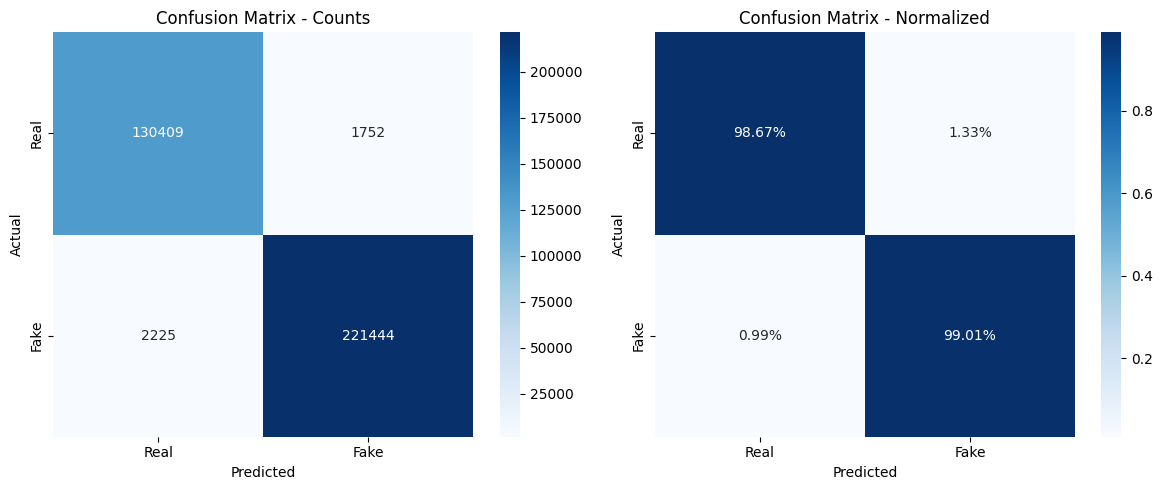


Results saved to GCS: deepfake_logs_fast/


In [ ]:
import os, json, re
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, f1_score, matthews_corrcoef,
    cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import storage

# Fix for TensorFlow prediction issues
tf.config.run_functions_eagerly(True)

# Download and locate model files from GCS
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

# Local model directories
local_model_dirs = [
    os.path.join(LOCAL_DATA_DIR, 'deepfake_models_stable'),
    os.path.join(LOCAL_DATA_DIR, 'deepfake_models_fast')
]

# Create local directories
for d in local_model_dirs:
    os.makedirs(d, exist_ok=True)

# List models in GCS
gcs_dirs = ['deepfake_models_stable/', 'deepfake_models_fast/']
candidates = []
pattern = re.compile(r'^(?:best_model|final_model)_(\d{8}-\d{6})\.h5$')

for gcs_dir in gcs_dirs:
    blobs = bucket.list_blobs(prefix=gcs_dir)
    for blob in blobs:
        fname = os.path.basename(blob.name)
        m = pattern.match(fname)
        if m:
            # Download if not cached
            local_dir = os.path.join(LOCAL_DATA_DIR, os.path.dirname(blob.name))
            local_path = os.path.join(local_dir, fname)

            if not os.path.exists(local_path):
                print(f"Downloading {fname}...")
                blob.download_to_filename(local_path)

            candidates.append((local_dir, fname, m.group(1)))

if not candidates:
    raise FileNotFoundError(
        "No 'best_model_*.h5' or 'final_model_*.h5' found in GCS"
    )

# Pick the newest
candidates.sort(key=lambda x: x[2])
model_dir, best_fname, ts = candidates[-1]
best_path = os.path.join(model_dir, best_fname)
print(f"Loading model from: {best_path}")

# Try different loading approaches
try:
    model = tf.keras.models.load_model(best_path)
    print("Model loaded with original compilation")
except:
    try:
        model = tf.keras.models.load_model(best_path, compile=False)
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        print("Model loaded and recompiled")
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

# Get model input shape
input_shape = model.input_shape[1:]
print(f"Model expects input shape: {input_shape}")

# --- Ensure we have generators ---
if 'val_generator' not in globals() or 'test_generator' not in globals():
    print("\nCreating data generators...")

    # Load memmap data
    if 'X' not in globals() or 'y' not in globals():
        print("Loading dataset...")
        base_path = LOCAL_DATA_DIR
        import pickle

        with open(os.path.join(base_path, '03_metadata/dataset_metadata.pkl'), 'rb') as f:
            metadata = pickle.load(f)

        dtype = np.uint8
        X = np.memmap(os.path.join(base_path, '02_processed_data/X_memmap.dat'),
                     dtype=dtype, mode='r', shape=metadata['shape'])
        y = np.memmap(os.path.join(base_path, '02_processed_data/y_memmap.dat'),
                     dtype=np.int8, mode='r', shape=(metadata['total_samples'],))

    # Load indices
    if 'val_indices' not in globals() or 'test_indices' not in globals():
        print("Loading splits...")
        splits_dir = os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits')
        val_indices = np.load(os.path.join(splits_dir, 'val_indices.npy'))
        test_indices = np.load(os.path.join(splits_dir, 'test_indices.npy'))

# Test model with single prediction
print("\nTesting model...")
test_idx = test_indices[:1]
test_image = X[test_idx]
if test_image.dtype == np.uint8:
    test_image = test_image.astype(np.float32) / 255.0

try:
    test_pred = model.predict(test_image, verbose=0)
    print(f"Model works! Test prediction shape: {test_pred.shape}")
except Exception as e:
    print(f"Model prediction failed: {e}")
    print("Trying alternative approach...")
    test_pred = model(test_image, training=False)
    print(f"Alternative method works! Shape: {test_pred.shape}")

# Run evaluation with robust prediction
print("\nRunning predictions on test set...")
y_true, y_score = [], []

# Process in smaller chunks for stability
chunk_size = 100
n_test = len(test_indices)

for i in range(0, n_test, chunk_size):
    if i % 1000 == 0:
        print(f"   Processing {i}/{n_test} samples...", end='\r')

    end_idx = min(i + chunk_size, n_test)
    batch_indices = test_indices[i:end_idx]

    X_batch = X[batch_indices]
    y_batch = y[batch_indices]

    if X_batch.dtype == np.uint8:
        X_batch = X_batch.astype(np.float32) / 255.0

    try:
        preds = model.predict(X_batch, verbose=0).flatten()
    except:
        preds = model(X_batch, training=False).numpy().flatten()

    y_true.extend(y_batch)
    y_score.extend(preds)

y_true = np.array(y_true)
y_score = np.array(y_score)
print(f"\nTest predictions complete: {len(y_true)} samples")

# Validation set for threshold tuning
print("\nTuning threshold on validation set...")
val_true, val_score = [], []

n_val = len(val_indices)
for i in range(0, n_val, chunk_size):
    if i % 1000 == 0:
        print(f"   Processing {i}/{n_val} samples...", end='\r')

    end_idx = min(i + chunk_size, n_val)
    batch_indices = val_indices[i:end_idx]

    X_batch = X[batch_indices]
    y_batch = y[batch_indices]

    if X_batch.dtype == np.uint8:
        X_batch = X_batch.astype(np.float32) / 255.0

    try:
        preds = model.predict(X_batch, verbose=0).flatten()
    except:
        preds = model(X_batch, training=False).numpy().flatten()

    val_true.extend(y_batch)
    val_score.extend(preds)

val_true = np.array(val_true)
val_score = np.array(val_score)
print(f"\nValidation predictions complete: {len(val_true)} samples")

# Find best threshold
best_thr, best_f1 = 0.5, 0
for t in np.linspace(0.3, 0.7, 41):
    f = f1_score(val_true, (val_score > t).astype(int))
    if f > best_f1:
        best_f1, best_thr = f, t

print(f"\nOptimal threshold = {best_thr:.3f}  (F1 = {best_f1:.4f})")

# Compute final metrics
y_pred = (y_score > best_thr).astype(int)
acc = (y_pred == y_true).mean()
auc = roc_auc_score(y_true, y_score)
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
kapp = cohen_kappa_score(y_true, y_pred)

print(f"\nTEST SET METRICS:")
print(f"   Accuracy: {acc*100:.2f}%")
print(f"   AUC: {auc:.4f}")
print(f"   F1: {f1:.4f}")
print(f"   MCC: {mcc:.4f}")
print(f"   Kappa: {kapp:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Real','Fake'], digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0], cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
axes[0].set_title('Confusion Matrix - Counts')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', ax=axes[1], cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
axes[1].set_title('Confusion Matrix - Normalized')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()

# Save results locally and upload to GCS
out_dir = os.path.join(LOCAL_DATA_DIR, 'deepfake_logs_fast')
os.makedirs(out_dir, exist_ok=True)

# Save figure
fig_path = os.path.join(out_dir, f'confusion_{ts}.png')
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

# Upload figure to GCS
blob = bucket.blob(f'deepfake_logs_fast/confusion_{ts}.png')
blob.upload_from_filename(fig_path)

# Save metrics
metrics = {
    'timestamp': ts,
    'model_path': f'deepfake_models_fast/{best_fname}',
    'test_samples': len(y_true),
    'accuracy': float(acc),
    'auc': float(auc),
    'f1': float(f1),
    'mcc': float(mcc),
    'kappa': float(kapp),
    'threshold': float(best_thr),
    'confusion_matrix': cm.tolist()
}

metrics_path = os.path.join(out_dir, f'eval_{ts}.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

# Upload metrics to GCS
blob = bucket.blob(f'deepfake_logs_fast/eval_{ts}.json')
blob.upload_from_filename(metrics_path)

print(f"\nResults saved to GCS: deepfake_logs_fast/")

# Save globals for cell 10
globals()['best_thr'] = best_thr
globals()['acc'] = acc
globals()['auc'] = auc
globals()['f1'] = f1
globals()['mcc'] = mcc
globals()['kapp'] = kapp
globals()['y_true'] = y_true
globals()['y_score'] = y_score

**10. Validation against a different dataset (Celeb DF v2)**

CELEB-DF V2 ZERO-SHOT VALIDATION
Testing model generalization to unseen Celeb-DF v2 dataset
Model trained on: WildDeepfake
Testing on: Celeb-DF v2 (completely unseen)

  metadata.pkl already cached
  test_indices.npy already cached

Celeb-DF v2 Dataset Info:
  Total samples: 195,841
  Frame size: (112, 112)
  Test samples: 20,611
  frames_memmap.dat already cached
  labels_memmap.dat already cached

Loading Celeb-DF v2 test set...
  Loaded 20,611 test samples
  Real: 10,411
  Fake: 10,200

Running predictions on Celeb-DF v2 test set...
  This tests zero-shot generalization (model never saw Celeb-DF during training)
  Processing 20000/20611 samples...
Predictions complete: 20,611 samples evaluated
Using threshold from WildDeepfake validation: 0.340

CELEB-DF V2 TEST SET METRICS (Zero-Shot)
   Accuracy: 50.14%
   AUC: 0.5079
   F1: 0.3887
   MCC: -0.0009
   Kappa: -0.0008

Classification Report:
              precision    recall  f1-score   support

        Real     0.5048    0.6789    0

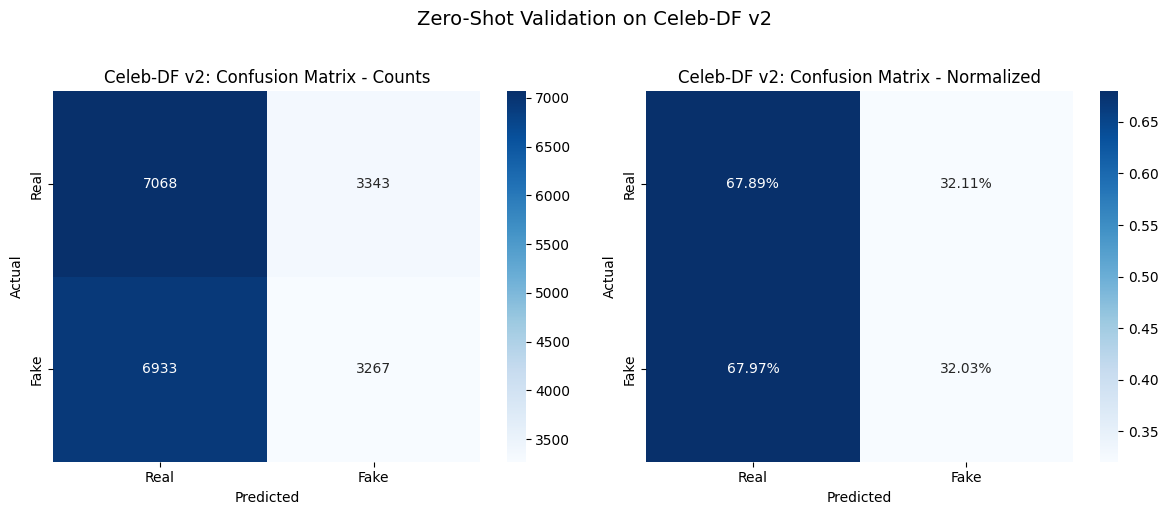


GENERALIZATION ANALYSIS
Metric         WildDeepfake    Celeb-DF v2   Difference
----------------------------------------------------
Accuracy             0.9888         0.5014      -0.4874
AUC                  0.9992         0.5079      -0.4913
F1-Score             0.9911         0.3887      -0.6024
MCC                  0.9761        -0.0009      -0.9770
Kappa                0.9761        -0.0008      -0.9769

Analysis:
Generalization gap: Significant drop on Celeb-DF v2 (may indicate domain shift)

Results saved to GCS: celeb_df_validation/

Celeb-DF v2 zero-shot validation complete!


In [ ]:
# ====== CELEB-DF V2 VALIDATION (ZERO-SHOT) ======
"""
Zero-shot validation on Celeb-DF v2 dataset
Model was trained only on WildDeepfake, testing generalization to Celeb-DF v2
"""

import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, f1_score, matthews_corrcoef,
    cohen_kappa_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from datetime import datetime
from google.cloud import storage
import subprocess

# Fix TensorFlow issues
tf.config.run_functions_eagerly(True)
tf.keras.backend.clear_session()

print("="*60)
print("CELEB-DF V2 ZERO-SHOT VALIDATION")
print("="*60)
print("Testing model generalization to unseen Celeb-DF v2 dataset")
print("Model trained on: WildDeepfake")
print("Testing on: Celeb-DF v2 (completely unseen)")

# Setup paths
CELEB_DF_LOCAL = os.path.join(LOCAL_DATA_DIR, 'celeb_df_v2_processed')
os.makedirs(CELEB_DF_LOCAL, exist_ok=True)

# GCS paths for Celeb-DF v2
CELEB_DF_GCS_PATHS = {
    'frames': 'celeb_df_v2/processed/frames_memmap.dat',
    'labels': 'celeb_df_v2/processed/labels_memmap.dat',
    'test_indices': 'celeb_df_v2/processed/test_indices.npy',
    'metadata': 'celeb_df_v2/processed/metadata.pkl'
}

# Download Celeb-DF v2 files from GCS
print("\nDownloading Celeb-DF v2 test data from GCS...")
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

files_to_download = [
    (CELEB_DF_GCS_PATHS['metadata'], os.path.join(CELEB_DF_LOCAL, 'metadata.pkl')),
    (CELEB_DF_GCS_PATHS['test_indices'], os.path.join(CELEB_DF_LOCAL, 'test_indices.npy'))
]

# Download metadata and test indices first
for gcs_path, local_path in files_to_download:
    if not os.path.exists(local_path):
        blob = bucket.blob(gcs_path)
        if blob.exists():
            blob.download_to_filename(local_path)
            print(f"  Downloaded {os.path.basename(local_path)}")
        else:
            print(f"  {gcs_path} not found in GCS")
    else:
        print(f"  {os.path.basename(local_path)} already cached")

# Load metadata to get dataset shape
metadata_path = os.path.join(CELEB_DF_LOCAL, 'metadata.pkl')
with open(metadata_path, 'rb') as f:
    celeb_metadata = pickle.load(f)

print(f"\nCeleb-DF v2 Dataset Info:")
print(f"  Total samples: {celeb_metadata.get('total_samples', 'Unknown'):,}")
print(f"  Frame size: {celeb_metadata.get('frame_size', 'Unknown')}")
print(f"  Test samples: {celeb_metadata.get('test_samples', 'Unknown'):,}")

# Download memmap files (large files, use gsutil for reliability)
frames_local = os.path.join(CELEB_DF_LOCAL, 'frames_memmap.dat')
labels_local = os.path.join(CELEB_DF_LOCAL, 'labels_memmap.dat')

for gcs_path, local_path in [(CELEB_DF_GCS_PATHS['frames'], frames_local),
                              (CELEB_DF_GCS_PATHS['labels'], labels_local)]:
    if not os.path.exists(local_path):
        blob = bucket.blob(gcs_path)
        if blob.exists():
            blob.reload()
            file_size_gb = (blob.size / (1024**3)) if blob.size else 0

            print(f"\n  Downloading {os.path.basename(local_path)} ({file_size_gb:.2f} GB)...")

            if file_size_gb > 1:
                # Use gsutil for large files
                cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
                if result.returncode == 0:
                    print(f"  Downloaded {os.path.basename(local_path)}")
                else:
                    print(f"  Failed to download: {result.stderr}")
            else:
                blob.download_to_filename(local_path)
                print(f"  Downloaded {os.path.basename(local_path)}")
        else:
            print(f"  {gcs_path} not found in GCS")
    else:
        print(f"  {os.path.basename(local_path)} already cached")

# Load Celeb-DF v2 data
print("\nLoading Celeb-DF v2 test set...")
celeb_test_indices = np.load(os.path.join(CELEB_DF_LOCAL, 'test_indices.npy'))

# Load memmap arrays
celeb_X = np.memmap(
    frames_local,
    dtype=np.uint8,
    mode='r',
    shape=celeb_metadata['shape']
)

celeb_y = np.memmap(
    labels_local,
    dtype=np.int8,
    mode='r',
    shape=(celeb_metadata['total_samples'],)
)

print(f"  Loaded {len(celeb_test_indices):,} test samples")
print(f"  Real: {np.sum(celeb_y[celeb_test_indices] == 0):,}")
print(f"  Fake: {np.sum(celeb_y[celeb_test_indices] == 1):,}")

# Load model if not already loaded
if 'model' not in globals():
    print("\nLoading trained model...")

    # Find most recent model
    model_dirs = [
        os.path.join(LOCAL_DATA_DIR, 'deepfake_models_fast'),
        os.path.join(LOCAL_DATA_DIR, 'deepfake_models_stable')
    ]

    model_files = []
    for model_dir in model_dirs:
        if os.path.exists(model_dir):
            for f in os.listdir(model_dir):
                if f.endswith('.h5'):
                    model_files.append((model_dir, f, os.path.getmtime(os.path.join(model_dir, f))))

    if model_files:
        model_files.sort(key=lambda x: x[2], reverse=True)
        model_path = os.path.join(model_files[0][0], model_files[0][1])
        print(f"  Loading: {model_path}")

        try:
            model = tf.keras.models.load_model(model_path)
        except:
            model = tf.keras.models.load_model(model_path, compile=False)
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        print("  ✓ Model loaded successfully")
    else:
        raise ValueError("No trained model found! Please run training first.")

# Run predictions on Celeb-DF v2 test set
print("\nRunning predictions on Celeb-DF v2 test set...")
print("  This tests zero-shot generalization (model never saw Celeb-DF during training)")

y_true_celeb = []
y_score_celeb = []

# Process in chunks for memory efficiency
CHUNK_SIZE = 100
n_test = len(celeb_test_indices)

for i in range(0, n_test, CHUNK_SIZE):
    if i % 1000 == 0:
        print(f"  Processing {i}/{n_test} samples...", end='\r')

    end_idx = min(i + CHUNK_SIZE, n_test)
    batch_indices = celeb_test_indices[i:end_idx]

    # Load batch
    X_batch = celeb_X[batch_indices]
    y_batch = celeb_y[batch_indices]

    # Normalize
    if X_batch.dtype == np.uint8:
        X_batch = X_batch.astype(np.float32) / 255.0

    # Predict
    try:
        preds = model.predict(X_batch, verbose=0).flatten()
    except:
        preds = model(X_batch, training=False).numpy().flatten()

    y_true_celeb.extend(y_batch)
    y_score_celeb.extend(preds)

y_true_celeb = np.array(y_true_celeb)
y_score_celeb = np.array(y_score_celeb)
print(f"\nPredictions complete: {len(y_true_celeb):,} samples evaluated")

# Use threshold from WildDeepfake validation or default
if 'best_thr' not in globals():
    best_thr = 0.5
    print(f"Using default threshold: {best_thr}")
else:
    print(f"Using threshold from WildDeepfake validation: {best_thr:.3f}")

# Compute metrics
y_pred_celeb = (y_score_celeb > best_thr).astype(int)
acc_celeb = accuracy_score(y_true_celeb, y_pred_celeb)
auc_celeb = roc_auc_score(y_true_celeb, y_score_celeb)
f1_celeb = f1_score(y_true_celeb, y_pred_celeb)
mcc_celeb = matthews_corrcoef(y_true_celeb, y_pred_celeb)
kappa_celeb = cohen_kappa_score(y_true_celeb, y_pred_celeb)

print("\n" + "="*60)
print("CELEB-DF V2 TEST SET METRICS (Zero-Shot)")
print("="*60)
print(f"   Accuracy: {acc_celeb*100:.2f}%")
print(f"   AUC: {auc_celeb:.4f}")
print(f"   F1: {f1_celeb:.4f}")
print(f"   MCC: {mcc_celeb:.4f}")
print(f"   Kappa: {kappa_celeb:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_celeb, y_pred_celeb,
                          target_names=['Real','Fake'], digits=4))

# Confusion Matrix
cm_celeb = confusion_matrix(y_true_celeb, y_pred_celeb)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
sns.heatmap(cm_celeb, annot=True, fmt='d', ax=ax1, cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
ax1.set_title('Celeb-DF v2: Confusion Matrix - Counts')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Normalized
cm_norm = cm_celeb.astype('float') / cm_celeb.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', ax=ax2, cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
ax2.set_title('Celeb-DF v2: Confusion Matrix - Normalized')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.suptitle('Zero-Shot Validation on Celeb-DF v2', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Performance comparison with WildDeepfake test set
if all(var in globals() for var in ['acc', 'auc', 'f1', 'mcc', 'kapp']):
    print("\n" + "="*60)
    print("GENERALIZATION ANALYSIS")
    print("="*60)
    print(f"{'Metric':<12} {'WildDeepfake':>14} {'Celeb-DF v2':>14} {'Difference':>12}")
    print("-" * 52)

    metrics_comparison = [
        ('Accuracy', acc, acc_celeb),
        ('AUC', auc, auc_celeb),
        ('F1-Score', f1, f1_celeb),
        ('MCC', mcc, mcc_celeb),
        ('Kappa', kapp, kappa_celeb)
    ]

    for name, wild, celeb in metrics_comparison:
        diff = celeb - wild
        color = '\033[92m' if diff >= -0.05 else '\033[91m'
        reset = '\033[0m'
        print(f"{name:<12} {wild:>14.4f} {celeb:>14.4f} {color}{diff:>+12.4f}{reset}")

    print("\nAnalysis:")
    acc_diff = acc_celeb - acc
    if abs(acc_diff) < 0.05:
        print("Excellent generalization: Performance within 5% on completely unseen dataset")
    elif acc_diff > 0:
        print("Strong generalization: Better performance on Celeb-DF v2")
    elif acc_diff > -0.10:
        print("Good generalization: Slight drop (<10%) on cross-dataset evaluation")
    else:
        print("Generalization gap: Significant drop on Celeb-DF v2 (may indicate domain shift)")

# Save results
output_dir = os.path.join(LOCAL_DATA_DIR, 'celeb_df_validation')
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
results = {
    'timestamp': timestamp,
    'dataset': 'Celeb-DF-v2',
    'validation_type': 'zero-shot',
    'training_dataset': 'WildDeepfake',
    'samples_evaluated': int(len(y_true_celeb)),
    'threshold_used': float(best_thr),
    'metrics': {
        'accuracy': float(acc_celeb),
        'auc': float(auc_celeb),
        'f1': float(f1_celeb),
        'mcc': float(mcc_celeb),
        'kappa': float(kappa_celeb)
    },
    'confusion_matrix': cm_celeb.tolist(),
    'class_distribution': {
        'real': int(np.sum(y_true_celeb == 0)),
        'fake': int(np.sum(y_true_celeb == 1))
    }
}

# Save locally and upload to GCS
results_path = os.path.join(output_dir, f'celeb_df_validation_{timestamp}.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

blob = bucket.blob(f'celeb_df_validation/results_{timestamp}.json')
blob.upload_from_filename(results_path)

print(f"\nResults saved to GCS: celeb_df_validation/")
print("\nCeleb-DF v2 zero-shot validation complete!")

### 4. Part - First LLM-supported EA

**1. Setup and Configuration**

In [ ]:
# ====== EVOLUTIONARY ALGORITHM CONFIGURATION ======
import os
import json
import time
import random
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import pandas as pd
from google.cloud import storage
import pickle
import gc

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ====== IMPORTANT: SET YOUR OPENAI API KEY HERE ======
OPENAI_API_KEY = "???"  # <-- REPLACE WITH YOUR OPENAI API KEY

# GCS Configuration
GCS_BUCKET = "???"
LOCAL_DATA_DIR = "/tmp/wilddeepfake_data"
CELEB_DF_DATA_DIR = "/tmp/celeb_df_data"

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)
os.makedirs(CELEB_DF_DATA_DIR, exist_ok=True)

# Evolution Configuration
EVOLUTION_CONFIG = {
    'population_size': 10,
    'num_generations': 50,
    'mutation_rate': 0.3,
    'crossover_rate': 0.5,
    'elite_size': 2,
    'max_hours_per_model': 5.0,
    'early_stop_patience': 5,
    'max_epochs_per_model': 10,
    'use_existing_model': True,
}

# Architecture search space
SEARCH_SPACE = {
    'num_conv_blocks': [2, 3, 4, 5],
    'filters': [16, 32, 64, 128, 256],
    'kernel_sizes': [3, 5, 7],
    'dropout_rates': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'dense_units': [64, 128, 256, 512],
    'learning_rates': [0.0001, 0.0005, 0.001, 0.005],
    'batch_sizes': [32, 64, 128],
    'augmentation_strength': [0.0, 0.1, 0.2, 0.3],
    'use_separable_conv': [True, False],
    'use_batch_norm': [True, False],
    'activation': ['relu', 'elu', 'swish'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'loss_function': ['binary_crossentropy', 'focal_loss'],
}

print("Configuration loaded successfully")
print(f"API Key configured: {'Yes' if OPENAI_API_KEY.startswith('sk-') else 'No - Please set your API key'}")
print(f"Evolution will run for {EVOLUTION_CONFIG['num_generations']} generations")
print(f"Max time PER MODEL: {EVOLUTION_CONFIG['max_hours_per_model']} hours")
print(f"Starting from existing model: {EVOLUTION_CONFIG['use_existing_model']}")
print(f"GCS Bucket: {GCS_BUCKET}")
print(f"Local data directory: {LOCAL_DATA_DIR}")
print(f"Celeb-DF data directory: {CELEB_DF_DATA_DIR}")

Configuration loaded successfully
API Key configured: Yes
Evolution will run for 50 generations
Max time PER MODEL: 5.0 hours
Starting from existing model: True
GCS Bucket: new-dissertation-folder
Local data directory: /tmp/wilddeepfake_data
Celeb-DF data directory: /tmp/celeb_df_data


**2. Load Data and Existing Model**

In [ ]:
# ====== LOAD DATA AND EXISTING MODEL ======
import numpy as np
import pickle
import tensorflow as tf
from google.cloud import storage
import subprocess
import os

print("Loading dataset metadata and existing model...")

# Ensure directories exist
os.makedirs(os.path.join(LOCAL_DATA_DIR, '02_processed_data'), exist_ok=True)
os.makedirs(os.path.join(LOCAL_DATA_DIR, '03_metadata'), exist_ok=True)
os.makedirs(os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits'), exist_ok=True)

# Initialize GCS client
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

# Download metadata
metadata_path = os.path.join(LOCAL_DATA_DIR, '03_metadata/dataset_metadata.pkl')
if not os.path.exists(metadata_path):
    print("Downloading metadata from GCS...")
    blob = bucket.blob('03_metadata/dataset_metadata.pkl')
    blob.download_to_filename(metadata_path)

with open(metadata_path, 'rb') as f:
    metadata = pickle.load(f)
print(f"Dataset: {metadata['total_samples']:,} samples")

# Download memmap files if not cached
print("\nChecking memmap files...")
memmap_files = [
    ('02_processed_data/X_memmap.dat', os.path.join(LOCAL_DATA_DIR, '02_processed_data/X_memmap.dat')),
    ('02_processed_data/y_memmap.dat', os.path.join(LOCAL_DATA_DIR, '02_processed_data/y_memmap.dat'))
]

for gcs_path, local_path in memmap_files:
    if not os.path.exists(local_path):
        blob = bucket.blob(gcs_path)
        if blob.exists():
            blob.reload()  # Get size info
            file_size_gb = blob.size / (1024**3) if blob.size else 0
            print(f"Downloading {os.path.basename(local_path)} ({file_size_gb:.2f} GB)...")

            # Use gsutil for large files (more reliable)
            if file_size_gb > 1:
                cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                result = subprocess.run(cmd, shell=True)
                if result.returncode == 0:
                    print(f"Downloaded {os.path.basename(local_path)}")
                else:
                    raise Exception(f"Failed to download {gcs_path}")
            else:
                blob.download_to_filename(local_path)
                print(f"Downloaded {os.path.basename(local_path)}")
        else:
            raise FileNotFoundError(f"File not found in GCS: {gcs_path}")
    else:
        # Verify file size
        local_size = os.path.getsize(local_path)
        blob = bucket.blob(gcs_path)
        blob.reload()
        if blob.size and local_size != blob.size:
            print(f"File size mismatch for {os.path.basename(local_path)}, re-downloading...")
            os.remove(local_path)

            file_size_gb = blob.size / (1024**3)
            if file_size_gb > 1:
                cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                subprocess.run(cmd, shell=True)
            else:
                blob.download_to_filename(local_path)
        else:
            print(f"{os.path.basename(local_path)} already cached locally")

# Now load memmap references
print("\nLoading memmap arrays...")
X = np.memmap(
    os.path.join(LOCAL_DATA_DIR, '02_processed_data/X_memmap.dat'),
    dtype=np.uint8,
    mode='r',
    shape=metadata['shape']
)
y = np.memmap(
    os.path.join(LOCAL_DATA_DIR, '02_processed_data/y_memmap.dat'),
    dtype=np.int8,
    mode='r',
    shape=(metadata['total_samples'],)
)
print(f"Memmap arrays loaded: X shape {X.shape}, y shape {y.shape}")

# Load splits
splits_dir = os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits')
os.makedirs(splits_dir, exist_ok=True)

print("\nLoading train/val/test splits...")
split_files = ['train_indices.npy', 'val_indices.npy', 'test_indices.npy']
for fname in split_files:
    local_path = os.path.join(splits_dir, fname)
    if not os.path.exists(local_path):
        print(f"Downloading {fname} from GCS...")
        # Try multiple possible locations
        for gcs_prefix in ['WildDeepfake_splits/', 'splits/', '']:
            try:
                blob = bucket.blob(f'{gcs_prefix}{fname}')
                if blob.exists():
                    blob.download_to_filename(local_path)
                    print(f"Downloaded {fname}")
                    break
            except:
                continue
        else:
            print(f"Warning: Could not find {fname} in GCS")

# Load the splits
try:
    train_indices = np.load(os.path.join(splits_dir, 'train_indices.npy'))
    val_indices = np.load(os.path.join(splits_dir, 'val_indices.npy'))
    test_indices = np.load(os.path.join(splits_dir, 'test_indices.npy'))
    print(f"Splits loaded: Train {len(train_indices):,}, Val {len(val_indices):,}, Test {len(test_indices):,}")
except FileNotFoundError as e:
    print(f"Error loading splits: {e}")
    print("Creating new splits...")
    # Create new splits if not found
    indices = np.arange(len(y))
    np.random.seed(42)
    np.random.shuffle(indices)

    # 70/20/10 split
    train_size = int(0.7 * len(indices))
    val_size = int(0.2 * len(indices))

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # Save locally
    np.save(os.path.join(splits_dir, 'train_indices.npy'), train_indices)
    np.save(os.path.join(splits_dir, 'val_indices.npy'), val_indices)
    np.save(os.path.join(splits_dir, 'test_indices.npy'), test_indices)

    # Upload to GCS
    for fname, indices_array in [
        ('train_indices.npy', train_indices),
        ('val_indices.npy', val_indices),
        ('test_indices.npy', test_indices)
    ]:
        blob = bucket.blob(f'WildDeepfake_splits/{fname}')
        blob.upload_from_filename(os.path.join(splits_dir, fname))

    print(f"Created new splits: Train {len(train_indices):,}, Val {len(val_indices):,}, Test {len(test_indices):,}")

# Load existing model
existing_genome = None
existing_test_acc = 0.0

if EVOLUTION_CONFIG['use_existing_model']:
    print("\n" + "="*60)
    print("Looking for existing trained model...")

    # Create local directories
    model_dirs = [
        os.path.join(LOCAL_DATA_DIR, 'deepfake_models_fast'),
        os.path.join(LOCAL_DATA_DIR, 'deepfake_models_stable'),
        os.path.join(LOCAL_DATA_DIR, 'evolved_models')
    ]

    for model_dir in model_dirs:
        os.makedirs(model_dir, exist_ok=True)

    # List models in GCS
    model_files = []
    for prefix in ['deepfake_models_fast/', 'deepfake_models_stable/', 'evolved_models/']:
        try:
            blobs = bucket.list_blobs(prefix=prefix)
            for blob in blobs:
                if blob.name.endswith('.h5'):
                    model_files.append((blob.name, blob.time_created))
        except:
            continue

    if model_files:
        # Sort by creation time to get the most recent
        model_files.sort(key=lambda x: x[1], reverse=True)
        best_model_gcs = model_files[0][0]

        # Download the best model
        local_model_path = os.path.join(LOCAL_DATA_DIR, best_model_gcs)
        if not os.path.exists(local_model_path):
            print(f"Downloading model: {best_model_gcs}")
            blob = bucket.blob(best_model_gcs)
            os.makedirs(os.path.dirname(local_model_path), exist_ok=True)
            blob.download_to_filename(local_model_path)
        else:
            print(f"Using cached model: {best_model_gcs}")

        # Load the model
        print("Loading model...")
        existing_model = tf.keras.models.load_model(local_model_path)

        # Extract architecture information
        def extract_model_genome(model):
            """Extract genome-like configuration from existing model"""
            genome = {
                'num_conv_blocks': 0,
                'filters': [],
                'kernel_sizes': 3,
                'dropout_rates': 0.25,
                'dense_units': 128,
                'learning_rates': 0.001,
                'batch_sizes': 64,
                'augmentation_strength': 0.1,
                'use_separable_conv': False,
                'use_batch_norm': False,
                'activation': 'relu',
                'optimizer': 'adam',
                'loss_function': 'focal_loss',
            }

            # Analyze layers
            filter_sizes = []
            for layer in model.layers:
                if isinstance(layer, tf.keras.layers.Conv2D):
                    genome['num_conv_blocks'] += 1
                    filter_sizes.append(layer.filters)
                    genome['kernel_sizes'] = layer.kernel_size[0]
                elif isinstance(layer, tf.keras.layers.SeparableConv2D):
                    genome['num_conv_blocks'] += 1
                    filter_sizes.append(layer.filters)
                    genome['use_separable_conv'] = True
                elif isinstance(layer, tf.keras.layers.BatchNormalization):
                    genome['use_batch_norm'] = True
                elif isinstance(layer, tf.keras.layers.Dropout):
                    if layer.rate > 0:
                        genome['dropout_rates'] = float(layer.rate)
                elif isinstance(layer, tf.keras.layers.Dense) and layer.units > 1:
                    genome['dense_units'] = layer.units
                elif hasattr(layer, 'activation') and hasattr(layer.activation, '__name__'):
                    if layer.activation.__name__ in ['elu', 'swish']:
                        genome['activation'] = layer.activation.__name__

            genome['filter_progression'] = filter_sizes or [32, 64, 128, 256]

            # Get optimizer info
            if hasattr(model.optimizer, 'learning_rate'):
                try:
                    genome['learning_rates'] = float(model.optimizer.learning_rate.numpy())
                except:
                    genome['learning_rates'] = 0.001

            # Ensure num_conv_blocks matches filter_progression
            if genome['num_conv_blocks'] == 0:
                genome['num_conv_blocks'] = len(genome['filter_progression'])

            return genome

        existing_genome = extract_model_genome(existing_model)

        print("\nExtracted architecture from existing model:")
        for key, value in existing_genome.items():
            print(f"  {key}: {value}")

        # Clean up
        del existing_model
        tf.keras.backend.clear_session()

    else:
        print("No existing model found in GCS - will start from random architectures")
else:
    print("\nSkipping existing model loading (use_existing_model = False)")

print("\n" + "="*60)
print("Data and model loading complete!")
print(f"Total samples: {len(y):,}")
print(f"Starting architecture: {'Existing model' if existing_genome else 'Random'}")

Loading dataset metadata and existing model...
Dataset: 1,186,099 samples

Checking memmap files...
X_memmap.dat already cached locally
y_memmap.dat already cached locally

Loading memmap arrays...
Memmap arrays loaded: X shape (1186099, 112, 112, 3), y shape (1186099,)

Loading train/val/test splits...
Splits loaded: Train 664,215, Val 166,054, Test 355,830

Looking for existing trained model...
Using cached model: evolved_models/final_selected/selected_model_20250920_045614_4146_20250921_154136.h5
Loading model...

Extracted architecture from existing model:
  num_conv_blocks: 5
  filters: []
  kernel_sizes: 7
  dropout_rates: 0.5
  dense_units: 256
  learning_rates: 0.0010000000474974513
  batch_sizes: 64
  augmentation_strength: 0.1
  use_separable_conv: True
  use_batch_norm: False
  activation: relu
  optimizer: adam
  loss_function: focal_loss
  filter_progression: [32, 64, 64, 256, 256]

Data and model loading complete!
Total samples: 1,186,099
Starting architecture: Existing m

**3. ChatGPT 5 LLM Integration**

In [ ]:
# ====== CHATGPT 5 LLM INTEGRATION ======
!pip install -q openai

from openai import OpenAI
from typing import Dict, Any, List
import json
import re

class ChatGPTArchitectureAdvisor:
    """ChatGPT 5 integration for CNN architecture optimization"""

    def __init__(self, api_key: str):
        """
        Initialize ChatGPT advisor with GPT-5
        Args:
            api_key: Your OpenAI API key
        """
        self.client = OpenAI(api_key=api_key)
        self.model = "gpt-5"
        self.conversation_history = []
        self.total_api_calls = 0
        self.total_tokens_used = 0
        self.generation_history = []

    def add_generation_data(self, generation: int, population_data: List[Dict]):
        """Store performance data from a generation for historical analysis"""
        gen_summary = {
            'generation': generation,
            'best_fitness': max([ind['fitness'] for ind in population_data]),
            'avg_fitness': np.mean([ind['fitness'] for ind in population_data]),
            'best_val_acc': max([ind['metrics'].get('val_accuracy', 0) for ind in population_data]),
            'best_test_acc': max([ind['metrics'].get('test_accuracy', 0) for ind in population_data]),
            'best_celeb_df_acc': max([ind['metrics'].get('celeb_df_accuracy', 0) for ind in population_data]),
            'avg_generalization_gap': np.mean([
                ind['metrics'].get('val_accuracy', 0) - ind['metrics'].get('celeb_df_accuracy', 0)
                for ind in population_data
            ]),
            'best_genome': max(population_data, key=lambda x: x['fitness'])['genome']
        }
        self.generation_history.append(gen_summary)

    def suggest_architecture_improvements(self,
                                        current_genome: Dict[str, Any],
                                        performance_metrics: Dict[str, float],
                                        generation: int = 0) -> Dict[str, Any]:
        """Get architecture suggestions from ChatGPT 5 using historical context"""

        # Build historical context
        history_summary = ""
        if len(self.generation_history) > 0:
            history_summary = f"\nEvolution History ({len(self.generation_history)} generations):\n"
            for gen in self.generation_history[-5:]:  # Last 5 generations
                history_summary += f"Gen {gen['generation']}: Fitness={gen['best_fitness']:.3f}, Val={gen['best_val_acc']:.3f}, CelebDF={gen['best_celeb_df_acc']:.3f}, Gap={gen['avg_generalization_gap']:.3f}\n"

            # Trend analysis
            if len(self.generation_history) >= 3:
                recent_fitness = [g['best_fitness'] for g in self.generation_history[-3:]]
                trend = "improving" if recent_fitness[-1] > recent_fitness[0] else "plateauing"
                history_summary += f"Trend: {trend}\n"

        system_message = """You are an expert in CNN architecture optimization for deepfake detection.
Analyze the architecture evolution history and suggest improvements.

IMPORTANT: Respond with ONLY a valid JSON object. No markdown, no extra text, just JSON:
{
    "suggested_changes": {"parameter": value},
    "reasoning": "explanation based on historical trends",
    "priority": "high/medium/low"
}"""

        user_message = f"""Current Architecture: blocks={current_genome.get('num_conv_blocks')}, dropout={current_genome.get('dropout_rates')}, dense={current_genome.get('dense_units')}, lr={current_genome.get('learning_rates')}
Current: Val={performance_metrics.get('val_accuracy', 0):.3f}, Test={performance_metrics.get('test_accuracy', 0):.3f}, CelebDF={performance_metrics.get('celeb_df_accuracy', 0):.3f}
Gap={performance_metrics.get('val_accuracy', 0) - performance_metrics.get('celeb_df_accuracy', 0):.3f}
{history_summary}
Suggest one improvement based on the evolution history. Consider what has worked and what hasn't."""

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": user_message}
                ],
                max_completion_tokens=300
            )

            self.total_api_calls += 1
            if hasattr(response, 'usage') and response.usage:
                self.total_tokens_used += response.usage.total_tokens

            # Get response content
            response_text = response.choices[0].message.content.strip()

            # Try multiple parsing strategies
            suggestions = self._parse_response(response_text)

            # If parsing failed, create a default suggestion based on metrics AND history
            if not suggestions or 'suggested_changes' not in suggestions:
                suggestions = self._create_historical_suggestion(current_genome, performance_metrics)

            self.conversation_history.append({
                'generation': generation,
                'genome': current_genome,
                'metrics': performance_metrics,
                'suggestions': suggestions,
                'history_length': len(self.generation_history)
            })

            return suggestions

        except Exception as e:
            print(f"   ChatGPT API Error: {e}")
            # Return intelligent default based on historical performance
            return self._create_historical_suggestion(current_genome, performance_metrics)

    def _parse_response(self, text: str) -> Dict[str, Any]:
        """Robust parsing of ChatGPT response"""
        if not text:
            return None

        # Remove any markdown code blocks
        text = re.sub(r'```json?\s*', '', text)
        text = re.sub(r'```\s*', '', text)
        text = text.strip()

        # Try direct JSON parsing
        try:
            return json.loads(text)
        except:
            pass

        # Try to find JSON-like content
        json_patterns = [
            r'\{[^{}]*"suggested_changes"[^{}]*\}',  # Look for our expected structure
            r'\{.*?\}(?!.*\{)',  # Last complete JSON object
            r'\{[^{}]*\}'  # Any JSON object
        ]

        for pattern in json_patterns:
            matches = re.findall(pattern, text, re.DOTALL)
            for match in reversed(matches):  # Try from last to first
                try:
                    result = json.loads(match)
                    if isinstance(result, dict):
                        return result
                except:
                    continue

        # Try to extract key-value pairs manually
        try:
            result = {"suggested_changes": {}, "reasoning": "", "priority": "medium"}

            # Look for parameter suggestions
            param_patterns = [
                (r'dropout[_\s]*(?:rates?)?\s*[:=]\s*([\d.]+)', 'dropout_rates'),
                (r'learning[_\s]*rate\s*[:=]\s*([\d.]+)', 'learning_rates'),
                (r'dense[_\s]*units?\s*[:=]\s*(\d+)', 'dense_units'),
                (r'batch[_\s]*size\s*[:=]\s*(\d+)', 'batch_sizes'),
                (r'blocks?\s*[:=]\s*(\d+)', 'num_conv_blocks')
            ]

            for pattern, param in param_patterns:
                match = re.search(pattern, text, re.IGNORECASE)
                if match:
                    value = match.group(1)
                    try:
                        if param in ['dropout_rates', 'learning_rates']:
                            result['suggested_changes'][param] = float(value)
                        else:
                            result['suggested_changes'][param] = int(value)
                    except:
                        pass

            # Extract priority
            if 'high' in text.lower():
                result['priority'] = 'high'
            elif 'low' in text.lower():
                result['priority'] = 'low'

            # Extract reasoning (first sentence-like text)
            reasoning_match = re.search(r'[A-Z][^.!?]*[.!?]', text)
            if reasoning_match:
                result['reasoning'] = reasoning_match.group(0)

            if result['suggested_changes']:
                return result

        except:
            pass

        return None

    def _create_historical_suggestion(self, genome: Dict[str, Any], metrics: Dict[str, float]) -> Dict[str, Any]:
        """Create intelligent suggestion based on current performance AND historical trends"""
        gap = metrics.get('val_accuracy', 0) - metrics.get('celeb_df_accuracy', 0)
        val_acc = metrics.get('val_accuracy', 0)

        suggestion = {
            "suggested_changes": {},
            "reasoning": "Suggestion based on evolution history",
            "priority": "medium"
        }

        # Analyze historical trends if available
        if len(self.generation_history) >= 2:
            # Check if performance is improving
            recent_fitness = [g['best_fitness'] for g in self.generation_history[-3:]]
            is_improving = len(recent_fitness) > 1 and recent_fitness[-1] > recent_fitness[0]

            # Check if generalization gap is persistent
            recent_gaps = [g['avg_generalization_gap'] for g in self.generation_history[-3:]]
            persistent_gap = all(g > 0.15 for g in recent_gaps)

            if persistent_gap and gap > 0.15:
                # Strong regularization needed - history shows consistent overfitting
                current_dropout = genome.get('dropout_rates', 0.2)
                if current_dropout < 0.5:
                    suggestion['suggested_changes']['dropout_rates'] = min(current_dropout + 0.15, 0.5)
                    suggestion['reasoning'] = f"Persistent generalization gap across {len(recent_gaps)} generations. Aggressive regularization needed."
                    suggestion['priority'] = 'high'
                else:
                    suggestion['suggested_changes']['augmentation_strength'] = 0.3
                    suggestion['reasoning'] = "Maximum dropout reached. Increasing data augmentation."
                    suggestion['priority'] = 'high'

            elif not is_improving and val_acc < 0.75:
                # Performance plateau - need architectural change
                if genome.get('num_conv_blocks', 3) < 5:
                    suggestion['suggested_changes']['num_conv_blocks'] = genome.get('num_conv_blocks', 3) + 1
                    suggestion['reasoning'] = "Performance plateau detected. Increasing model depth."
                    suggestion['priority'] = 'high'
                elif genome.get('dense_units', 128) < 512:
                    suggestion['suggested_changes']['dense_units'] = min(genome.get('dense_units', 128) * 2, 512)
                    suggestion['reasoning'] = "Stagnant performance. Increasing dense layer capacity."
                    suggestion['priority'] = 'medium'

        # Fallback to simple heuristics if no historical suggestion
        if not suggestion['suggested_changes']:
            if gap > 0.15:
                current_dropout = genome.get('dropout_rates', 0.2)
                if current_dropout < 0.4:
                    suggestion['suggested_changes']['dropout_rates'] = min(current_dropout + 0.1, 0.5)
                    suggestion['reasoning'] = f"Large generalization gap ({gap:.3f}). Increasing dropout."
                    suggestion['priority'] = 'high' if gap > 0.2 else 'medium'
            elif val_acc < 0.7:
                if genome.get('learning_rates', 0.001) > 0.0001:
                    suggestion['suggested_changes']['learning_rates'] = genome.get('learning_rates', 0.001) * 0.5
                    suggestion['reasoning'] = "Low accuracy. Reducing learning rate for better convergence."
                    suggestion['priority'] = 'medium'
            else:
                suggestion['suggested_changes']['augmentation_strength'] = min(
                    genome.get('augmentation_strength', 0.1) + 0.05, 0.3
                )
                suggestion['reasoning'] = "Good performance. Fine-tuning augmentation."
                suggestion['priority'] = 'low'

        return suggestion

    def get_usage_stats(self) -> Dict[str, Any]:
        """Get API usage statistics"""
        estimated_cost_per_token = 0.00006  # Placeholder for GPT-5
        return {
            'total_api_calls': self.total_api_calls,
            'total_tokens_used': self.total_tokens_used,
            'estimated_cost': self.total_tokens_used * estimated_cost_per_token,
            'generations_analyzed': len(self.generation_history)
        }

# Initialize ChatGPT advisor
chatgpt_advisor = ChatGPTArchitectureAdvisor(api_key=OPENAI_API_KEY)
print("ChatGPT 5 Architecture Advisor initialized")
print("Using GPT-5 with historical context analysis")
print("Suggestions will be made every 2 generations based on evolution history")
print("Optimizing for cross-dataset performance with Celeb-DF v2 validation")

ChatGPT 5 Architecture Advisor initialized
Using GPT-5 with historical context analysis
Suggestions will be made every 2 generations based on evolution history
Optimizing for cross-dataset performance with Celeb-DF v2 validation


**4. Core Evolution Classes with Celeb-DF v2 in Fitness and Model Saving**

In [ ]:
# ====== CORE EVOLUTION CLASSES WITH CELEB-DF IN FITNESS AND MODEL SAVING ======

class Individual:
    """Represents a single CNN architecture and hyperparameters"""

    def __init__(self, genome: Dict[str, Any] = None, base_genome: Dict[str, Any] = None):
        if genome is None:
            if base_genome is not None:
                # Start from base genome with small mutations
                self.genome = base_genome.copy()
                self.mutate(mutation_rate=0.1)  # Small initial mutation
            else:
                self.genome = self.random_genome()
        else:
            self.genome = genome

        self.fitness = 0.0
        self.metrics = {}
        self.training_time = 0.0
        self.model = None
        self.id = datetime.now().strftime("%Y%m%d_%H%M%S_") + str(random.randint(1000, 9999))
        self.model_saved_path = None  # Track where model is saved
        self.random_seed = hash(self.id) % (2**32)  # Unique seed for data splits

    def random_genome(self) -> Dict[str, Any]:
        """Create a random genome"""
        genome = {}
        for param, values in SEARCH_SPACE.items():
            genome[param] = random.choice(values)

        genome['filter_progression'] = sorted(
            [random.choice(SEARCH_SPACE['filters']) for _ in range(genome['num_conv_blocks'])]
        )

        return genome

    def mutate(self, mutation_rate: float = 0.3):
        """Mutate the genome"""
        for param in self.genome:
            if random.random() < mutation_rate:
                if param == 'filter_progression':
                    idx = random.randint(0, len(self.genome[param]) - 1)
                    self.genome[param][idx] = random.choice(SEARCH_SPACE['filters'])
                    self.genome[param] = sorted(self.genome[param])
                elif param in SEARCH_SPACE:
                    self.genome[param] = random.choice(SEARCH_SPACE[param])

    def crossover(self, other: 'Individual') -> 'Individual':
        """Create offspring through crossover"""
        child_genome = {}
        for param in self.genome:
            if random.random() < 0.5:
                child_genome[param] = self.genome[param]
            else:
                child_genome[param] = other.genome[param]

        return Individual(child_genome)

    def apply_chatgpt_suggestions(self, suggestions: Dict[str, Any]) -> List[str]:
        """Apply ChatGPT suggestions to genome"""
        modifications = []

        if 'suggested_changes' in suggestions:
            for param, value in suggestions['suggested_changes'].items():
                if param in self.genome and param in SEARCH_SPACE:
                    if isinstance(value, bool) and param in ['use_separable_conv', 'use_batch_norm']:
                        self.genome[param] = value
                        modifications.append(f"Set {param} to {value}")
                    elif param in SEARCH_SPACE and value in SEARCH_SPACE[param]:
                        self.genome[param] = value
                        modifications.append(f"Changed {param} to {value}")
                    elif param == 'dropout_rates' and isinstance(value, (int, float)):
                        value = max(0.0, min(0.5, value))
                        self.genome[param] = value
                        modifications.append(f"Set dropout rate to {value}")

        return modifications

class EvolutionaryOptimizer:
    """Main evolutionary algorithm controller with ChatGPT integration"""

    def __init__(self, base_path: str, gcs_bucket: str, chatgpt_advisor, existing_genome=None):
        self.base_path = base_path
        self.gcs_bucket = gcs_bucket
        self.generation = 0
        self.population = []
        self.history = []
        self.start_time = time.time()
        self.reports_dir = os.path.join(base_path, 'evolution_reports')
        os.makedirs(self.reports_dir, exist_ok=True)
        self.chatgpt_advisor = chatgpt_advisor
        self.existing_genome = existing_genome
        self.total_models_trained = 0

        # Track ALL individuals evaluated throughout evolution
        self.all_individuals = []

        # Directory for saving model checkpoints
        self.models_dir = os.path.join(base_path, 'evolution_models')
        os.makedirs(self.models_dir, exist_ok=True)

        # Initialize GCS client
        self.storage_client = storage.Client()
        self.bucket = self.storage_client.bucket(gcs_bucket)

        # Store ChatGPT suggestions for next generation
        self.next_gen_suggestions = None

    def create_model(self, individual: Individual) -> tf.keras.Model:
        """Create a CNN model based on the genome"""
        genome = individual.genome

        inputs = tf.keras.layers.Input(shape=(112, 112, 3))
        x = inputs

        # Conv blocks
        for i in range(genome['num_conv_blocks']):
            filters = genome['filter_progression'][i] if i < len(genome['filter_progression']) else 64

            if genome['use_separable_conv'] and i > 0:
                x = tf.keras.layers.SeparableConv2D(
                    filters, genome['kernel_sizes'], padding='same'
                )(x)
            else:
                x = tf.keras.layers.Conv2D(
                    filters, genome['kernel_sizes'], padding='same'
                )(x)

            if genome['use_batch_norm']:
                x = tf.keras.layers.BatchNormalization()(x)

            # Activation
            if genome['activation'] == 'relu':
                x = tf.keras.layers.ReLU()(x)
            elif genome['activation'] == 'elu':
                x = tf.keras.layers.ELU()(x)
            elif genome['activation'] == 'swish':
                x = tf.keras.layers.Activation('swish')(x)

            # Pooling every other block
            if i % 2 == 1:
                x = tf.keras.layers.MaxPooling2D((2, 2))(x)

            # Dropout
            if genome['dropout_rates'] > 0:
                x = tf.keras.layers.Dropout(genome['dropout_rates'])(x)

        # Global pooling
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        # Dense layers
        x = tf.keras.layers.Dense(genome['dense_units'])(x)
        if genome['use_batch_norm']:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)

        # Output
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        # Compile
        if genome['optimizer'] == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=genome['learning_rates'])
        elif genome['optimizer'] == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=genome['learning_rates'], momentum=0.9)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=genome['learning_rates'])

        if genome['loss_function'] == 'focal_loss':
            loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0)
        else:
            loss = 'binary_crossentropy'

        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )

        return model

    def create_individual_data_splits(self, individual: Individual, X_data, y_data,
                                     train_size=50000, val_size=10000, test_size=10000):
        """Create unique random data splits for each individual"""
        from tensorflow.keras.preprocessing.image import ImageDataGenerator

        # Use individual's unique seed for reproducible random splits
        np.random.seed(individual.random_seed)

        # Get total available indices
        total_samples = len(y_data)
        all_indices = np.arange(total_samples)

        # Shuffle indices with individual's seed
        np.random.shuffle(all_indices)

        # Create splits with specified sizes
        actual_train_size = min(train_size, int(total_samples * 0.6))
        actual_val_size = min(val_size, int(total_samples * 0.2))
        actual_test_size = min(test_size, int(total_samples * 0.2))

        # Select indices for each split
        train_indices = all_indices[:actual_train_size]
        val_indices = all_indices[actual_train_size:actual_train_size + actual_val_size]
        test_indices = all_indices[actual_train_size + actual_val_size:
                                  actual_train_size + actual_val_size + actual_test_size]

        # Generator class
        class FastEvoGenerator(tf.keras.utils.Sequence):
            def __init__(self, X_mmap, y_mmap, indices, batch_size=64, augment=False):
                self.X_mmap = X_mmap
                self.y_mmap = y_mmap
                self.indices = indices
                self.batch_size = batch_size
                self.augment = augment
                if augment:
                    self.augmentor = ImageDataGenerator(
                        rotation_range=10,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        horizontal_flip=True
                    )

            def __len__(self):
                return int(np.ceil(len(self.indices) / self.batch_size))

            def __getitem__(self, index):
                start_idx = index * self.batch_size
                end_idx = min((index + 1) * self.batch_size, len(self.indices))
                batch_indices = self.indices[start_idx:end_idx]

                X_batch = self.X_mmap[batch_indices]
                y_batch = self.y_mmap[batch_indices]

                if X_batch.dtype == np.uint8:
                    X_batch = X_batch.astype(np.float32) / 255.0

                if self.augment and self.augmentor:
                    for i in range(len(X_batch)):
                        if np.random.random() > 0.5:
                            X_batch[i] = self.augmentor.random_transform(X_batch[i])

                return X_batch, y_batch

        # Create generators with individual's specific data splits
        train_gen = FastEvoGenerator(X_data, y_data, train_indices,
                                    batch_size=individual.genome['batch_sizes'],
                                    augment=True)
        val_gen = FastEvoGenerator(X_data, y_data, val_indices,
                                  batch_size=individual.genome['batch_sizes'],
                                  augment=False)
        test_gen = FastEvoGenerator(X_data, y_data, test_indices,
                                   batch_size=individual.genome['batch_sizes'],
                                   augment=False)

        print(f"   Data splits (seed={individual.random_seed % 10000}): "
              f"Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")

        return train_gen, val_gen, test_gen

    def evaluate_individual(self, individual: Individual,
                          X_data, y_data,
                          celeb_df_test_data=None,
                          save_models=True) -> float:
        """
        Evaluate an individual's fitness with unique data splits
        FITNESS FUNCTION: WildDeepfake Val (20%) + Test (20%) + AUC (20%) + Celeb-DF (40%)
        """
        print(f"\nEvaluating individual {individual.id}")
        self.total_models_trained += 1

        # Create unique data splits for this individual
        train_gen, val_gen, test_gen = self.create_individual_data_splits(
            individual, X_data, y_data
        )

        # Create model
        tf.keras.backend.clear_session()
        model = self.create_model(individual)
        individual.model = model

        # Training callbacks with time limit per model
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=3,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=2,
                min_lr=1e-7
            ),
            TimeLimit(max_hours=EVOLUTION_CONFIG['max_hours_per_model'])
        ]

        # Train model
        start_train = time.time()
        try:
            history = model.fit(
                train_gen,
                epochs=EVOLUTION_CONFIG['max_epochs_per_model'],
                validation_data=val_gen,
                callbacks=callbacks,
                verbose=0
            )
        except TimeLimitExceeded:
            print(f"   Time limit exceeded for this model ({EVOLUTION_CONFIG['max_hours_per_model']} hours)")
            history = model.history

        individual.training_time = time.time() - start_train

        # Evaluate on test set
        test_metrics = model.evaluate(test_gen, verbose=0)

        # Evaluate on Celeb-DF dataset
        celeb_df_score = 0.0
        if celeb_df_test_data is not None:
            celeb_df_pred = model.predict(celeb_df_test_data[0], verbose=0)
            celeb_df_acc = np.mean((celeb_df_pred > 0.5).astype(int).flatten() == celeb_df_test_data[1])
            celeb_df_score = celeb_df_acc

        # Extract metrics
        val_acc = max(history.history['val_accuracy']) if history.history['val_accuracy'] else 0
        test_acc = test_metrics[1]
        test_auc = test_metrics[2]

        # Fitness Function
        fitness = (0.2 * val_acc + 0.2 * test_acc + 0.2 * test_auc + 0.4 * celeb_df_score)

        # Penalty for very long training
        if individual.training_time > 3600:  # 1 hour
            fitness *= 0.95

        individual.fitness = fitness
        individual.metrics = {
            'val_accuracy': val_acc,
            'test_accuracy': test_acc,
            'test_auc': test_auc,
            'celeb_df_accuracy': celeb_df_score,
            'training_time': individual.training_time,
            'total_params': model.count_params(),
            'epochs_trained': len(history.history['loss']) if hasattr(history, 'history') else 0,
            'data_split_seed': individual.random_seed % 10000,  # Store seed for reference
            'fitness_components': {  # Store individual fitness components
                'val_acc_weighted': 0.2 * val_acc,
                'test_acc_weighted': 0.2 * test_acc,
                'test_auc_weighted': 0.2 * test_auc,
                'celeb_df_weighted': 0.4 * celeb_df_score
            }
        }

        print(f"   Fitness: {fitness:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f} | AUC: {test_auc:.4f} | Celeb-DF: {celeb_df_score:.4f}")
        print(f"   Fitness breakdown: Val(20%): {0.2*val_acc:.3f} + Test(20%): {0.2*test_acc:.3f} + AUC(20%): {0.2*test_auc:.3f} + Celeb(40%): {0.4*celeb_df_score:.3f}")

        # Save model weights
        if save_models:
            model_filename = f"model_{individual.id}.h5"
            local_model_path = os.path.join(self.models_dir, model_filename)
            model.save(local_model_path)

            # Upload to GCS
            gcs_model_path = f"evolution_models/generation_{self.generation}/{model_filename}"
            blob = self.bucket.blob(gcs_model_path)
            blob.upload_from_filename(local_model_path)

            individual.model_saved_path = gcs_model_path
            print(f"   Model saved to GCS: {gcs_model_path}")

        # Store this individual in the all_individuals list
        self.all_individuals.append(individual)

        # Clean up
        del model
        tf.keras.backend.clear_session()
        gc.collect()

        return fitness

    def analyze_generation_and_get_suggestions(self):
        """Analyze current generation and get ChatGPT suggestions for next generation"""
        # Prepare population data for ChatGPT
        population_data = [
            {
                'fitness': ind.fitness,
                'metrics': ind.metrics,
                'genome': ind.genome
            }
            for ind in self.population
        ]

        # Add to ChatGPT's history
        self.chatgpt_advisor.add_generation_data(self.generation, population_data)

        # Get best individual for analysis
        best_ind = self.population[0]  # Already sorted by fitness

        print("\n" + "="*60)
        print(f"CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation {self.generation + 1})")
        print("="*60)

        # Get suggestions based on best performer and historical context
        suggestions = self.chatgpt_advisor.suggest_architecture_improvements(
            best_ind.genome,
            best_ind.metrics,
            self.generation
        )

        print(f"\nGeneration {self.generation + 1} Performance Summary:")
        print(f"   Best Fitness: {best_ind.fitness:.4f}")
        print(f"   Average Fitness: {np.mean([ind.fitness for ind in self.population]):.4f}")
        print(f"   Best Val Accuracy: {best_ind.metrics.get('val_accuracy', 0):.4f}")
        print(f"   Best Test Accuracy: {best_ind.metrics.get('test_accuracy', 0):.4f}")
        print(f"   Best Test AUC: {best_ind.metrics.get('test_auc', 0):.4f}")
        print(f"   Best Celeb-DF Accuracy: {best_ind.metrics.get('celeb_df_accuracy', 0):.4f}")
        print(f"   Avg Generalization Gap: {np.mean([ind.metrics.get('val_accuracy', 0) - ind.metrics.get('celeb_df_accuracy', 0) for ind in self.population]):.4f}")

        print(f"\n   Fitness Function Weights:")
        print(f"      WildDeepfake Val: 20%")
        print(f"      WildDeepfake Test: 20%")
        print(f"      WildDeepfake AUC: 20%")
        print(f"      Celeb-DF: 40%")

        print(f"\nHistorical Trends ({len(self.chatgpt_advisor.generation_history)} generations analyzed):")
        if len(self.chatgpt_advisor.generation_history) >= 3:
            recent = self.chatgpt_advisor.generation_history[-3:]
            fitness_trend = [g['best_fitness'] for g in recent]
            if fitness_trend[-1] > fitness_trend[0]:
                print(f"   Trend: IMPROVING (+{fitness_trend[-1] - fitness_trend[0]:.4f} over 3 generations)")
            else:
                print(f"   Trend: PLATEAUING ({fitness_trend[-1] - fitness_trend[0]:.4f} over 3 generations)")

        print(f"\nChatGPT 5 Recommendations for Next Generation:")
        print(f"   Priority: {suggestions.get('priority', 'N/A').upper()}")
        print(f"   Reasoning: {suggestions.get('reasoning', 'No reasoning provided')}")

        if 'suggested_changes' in suggestions and suggestions['suggested_changes']:
            print(f"\n   Suggested Parameter Changes:")
            for param, value in suggestions['suggested_changes'].items():
                current_value = best_ind.genome.get(param, 'N/A')
                print(f"      • {param}: {current_value} → {value}")
            print(f"\n   These suggestions will influence {self.generation + 2}'s population creation")
        else:
            print("   No specific parameter changes suggested")

        print("="*60 + "\n")

        # Store suggestions for next generation
        self.next_gen_suggestions = suggestions

        return suggestions

    def create_next_generation(self):
        """Create next generation with potential ChatGPT influence"""
        new_population = []

        # Elitism - keep best individuals
        elite_size = EVOLUTION_CONFIG['elite_size']
        new_population.extend(self.population[:elite_size])

        # If we have ChatGPT suggestions, create some individuals based on them
        if self.next_gen_suggestions and self.next_gen_suggestions.get('suggested_changes'):
            priority = self.next_gen_suggestions.get('priority', 'low')

            # Determine how many ChatGPT-influenced individuals to create
            if priority == 'high':
                chatgpt_individuals = 3  # 30% of population
            elif priority == 'medium':
                chatgpt_individuals = 2  # 20% of population
            else:
                chatgpt_individuals = 1  # 10% of population

            print(f"🧬 Creating {chatgpt_individuals} ChatGPT-influenced individuals (priority: {priority})")

            # Create ChatGPT-influenced individuals
            for i in range(chatgpt_individuals):
                # Start from best performer
                base_genome = self.population[0].genome.copy()
                influenced_ind = Individual(base_genome)

                # Apply ChatGPT suggestions
                modifications = influenced_ind.apply_chatgpt_suggestions(self.next_gen_suggestions)
                if modifications:
                    print(f"   Individual {i+1}: Applied {', '.join(modifications)}")

                # Add small random mutations for diversity
                influenced_ind.mutate(mutation_rate=0.1)
                new_population.append(influenced_ind)

        # Generate rest of population through evolution
        while len(new_population) < EVOLUTION_CONFIG['population_size']:
            parent1 = self.tournament_select()
            parent2 = self.tournament_select()

            if random.random() < EVOLUTION_CONFIG['crossover_rate']:
                child = parent1.crossover(parent2)
            else:
                child = Individual(parent1.genome.copy())

            child.mutate(EVOLUTION_CONFIG['mutation_rate'])
            new_population.append(child)

        # Clear suggestions after use
        self.next_gen_suggestions = None

        return new_population

    def tournament_select(self, tournament_size: int = 3) -> Individual:
        """Tournament selection"""
        tournament = random.sample(self.population, tournament_size)
        return max(tournament, key=lambda x: x.fitness)

    def save_generation_summary(self, generation: int):
        """Save summary of current generation"""
        summary = {
            'generation': generation,
            'population_size': len(self.population),
            'best_fitness': self.population[0].fitness,
            'average_fitness': np.mean([ind.fitness for ind in self.population]),
            'best_metrics': self.population[0].metrics,
            'fitness_distribution': [ind.fitness for ind in self.population],
            'fitness_function': 'Val(20%) + Test(20%) + AUC(20%) + CelebDF(40%)',
            'elapsed_time': time.time() - self.start_time,
            'model_paths': {ind.id: ind.model_saved_path for ind in self.population if ind.model_saved_path},
            'chatgpt_suggestions': self.next_gen_suggestions
        }

        summary_path = os.path.join(self.reports_dir, f'generation_{generation:03d}_summary.json')
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)

        blob = self.bucket.blob(f'evolution_reports/generation_{generation:03d}_summary.json')
        blob.upload_from_filename(summary_path)

    def generate_report(self, individual: Individual, generation: int):
        """Generate detailed report for an individual"""
        report = {
            'generation': generation,
            'individual_id': individual.id,
            'genome': individual.genome,
            'fitness': individual.fitness,
            'metrics': individual.metrics,
            'model_saved_path': individual.model_saved_path,
            'fitness_function': 'Val(20%) + Test(20%) + AUC(20%) + CelebDF(40%)',
            'architecture_summary': {
                'num_conv_blocks': individual.genome['num_conv_blocks'],
                'filter_progression': individual.genome['filter_progression'],
                'use_separable_conv': individual.genome['use_separable_conv'],
                'kernel_size': individual.genome['kernel_sizes'],
                'activation': individual.genome['activation'],
                'dropout_rate': individual.genome['dropout_rates'],
                'dense_units': individual.genome['dense_units'],
                'batch_size': individual.genome['batch_sizes'],
                'optimizer': individual.genome['optimizer'],
                'learning_rate': individual.genome['learning_rates'],
                'loss_function': individual.genome['loss_function'],
                'total_parameters': individual.metrics.get('total_params', 0),
                'data_split_seed': individual.metrics.get('data_split_seed', 0)
            }
        }

        report_path = os.path.join(self.reports_dir, f'gen_{generation:03d}_{individual.id}.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=2)

        blob = self.bucket.blob(f'evolution_reports/gen_{generation:03d}_{individual.id}.json')
        blob.upload_from_filename(report_path)

        return report

    def generate_final_report(self, best_individual: Individual):
        """Generate comprehensive final report"""
        print("\nGenerating Final Evolution Report...")

        api_stats = self.chatgpt_advisor.get_usage_stats()

        # Include all model paths
        all_model_paths = {ind.id: {
            'fitness': ind.fitness,
            'metrics': ind.metrics,
            'model_path': ind.model_saved_path
        } for ind in self.all_individuals if ind.model_saved_path}

        final_report = {
            'evolution_summary': {
                'total_generations': self.generation + 1,
                'total_time_hours': (time.time() - self.start_time) / 3600,
                'total_individuals_evaluated': self.total_models_trained,
                'best_fitness_achieved': best_individual.fitness,
                'best_individual_id': best_individual.id,
                'used_random_splits': True,
                'chatgpt_strategy': 'end_of_generation_analysis',
                'fitness_function': 'Val(20%) + Test(20%) + AUC(20%) + CelebDF(40%)'
            },
            'best_architecture': {
                'genome': best_individual.genome,
                'metrics': best_individual.metrics,
                'model_path': best_individual.model_saved_path
            },
            'all_models': all_model_paths,
            'chatgpt_usage': api_stats,
            'evolution_config': EVOLUTION_CONFIG,
            'search_space': SEARCH_SPACE
        }

        final_path = os.path.join(self.reports_dir, 'final_evolution_report.json')
        with open(final_path, 'w') as f:
            json.dump(final_report, f, indent=2)

        blob = self.bucket.blob('evolution_reports/final_evolution_report.json')
        blob.upload_from_filename(final_path)

        print(f"Final report saved: {final_path}")
        print(f"Uploaded to GCS: evolution_reports/final_evolution_report.json")

        print("\nEVOLUTION COMPLETE!")
        print(f"   Best fitness: {best_individual.fitness:.4f}")
        print(f"   Fitness breakdown:")
        if 'fitness_components' in best_individual.metrics:
            fc = best_individual.metrics['fitness_components']
            print(f"      Val (20%): {fc['val_acc_weighted']:.4f}")
            print(f"      Test (20%): {fc['test_acc_weighted']:.4f}")
            print(f"      AUC (20%): {fc['test_auc_weighted']:.4f}")
            print(f"      Celeb-DF (40%): {fc['celeb_df_weighted']:.4f}")
        print(f"   Raw metrics:")
        print(f"      Val accuracy: {best_individual.metrics['val_accuracy']:.4f}")
        print(f"      Test accuracy: {best_individual.metrics['test_accuracy']:.4f}")
        print(f"      Test AUC: {best_individual.metrics['test_auc']:.4f}")
        print(f"      Celeb-DF accuracy: {best_individual.metrics['celeb_df_accuracy']:.4f}")
        print(f"   Training time: {best_individual.metrics['training_time']:.1f}s")
        print(f"   Total parameters: {best_individual.metrics['total_params']:,}")
        print(f"   Data split seed: {best_individual.metrics.get('data_split_seed', 'N/A')}")
        print(f"\nChatGPT Usage:")
        print(f"   API calls: {api_stats['total_api_calls']}")
        print(f"   Tokens used: {api_stats['total_tokens_used']:,}")
        print(f"   Estimated cost: ${api_stats['estimated_cost']:.2f}")

    def select_and_copy_saved_model(self):
        """Allow user to select from all individuals and copy the already-saved model"""
        print("\n" + "="*80)
        print("MODEL SELECTION INTERFACE")
        print("="*80)

        # Sort all individuals by fitness
        self.all_individuals.sort(key=lambda x: x.fitness, reverse=True)

        # Display all individuals
        print(f"\nTotal individuals evaluated: {len(self.all_individuals)}")
        print("\nFitness Function: Val(20%) + Test(20%) + AUC(20%) + CelebDF(40%)")
        print("\n{:<5} {:<25} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
            "Rank", "ID", "Fitness", "Val Acc", "Test Acc", "Test AUC", "Celeb-DF", "Params", "Seed", "Saved"))
        print("-"*130)

        for i, ind in enumerate(self.all_individuals[:50]):  # Show top 50
            saved_status = "✓" if ind.model_saved_path else "✗"
            print("{:<5} {:<25} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10,} {:<10} {:<10}".format(
                i+1,
                ind.id,
                ind.fitness,
                ind.metrics.get('val_accuracy', 0),
                ind.metrics.get('test_accuracy', 0),
                ind.metrics.get('test_auc', 0),
                ind.metrics.get('celeb_df_accuracy', 0),
                ind.metrics.get('total_params', 0),
                ind.metrics.get('data_split_seed', 'N/A'),
                saved_status
            ))

        if len(self.all_individuals) > 50:
            print(f"\n... and {len(self.all_individuals) - 50} more individuals")

        # Get user selection
        print("\n" + "="*80)
        while True:
            try:
                choice = input("\nEnter the rank number of the individual you want to use (1-{}): ".format(
                    len(self.all_individuals)))
                choice_idx = int(choice) - 1

                if 0 <= choice_idx < len(self.all_individuals):
                    chosen_individual = self.all_individuals[choice_idx]
                    break
                else:
                    print(f"Please enter a number between 1 and {len(self.all_individuals)}")
            except ValueError:
                print("Please enter a valid number")

        print(f"\nYou selected: {chosen_individual.id}")
        print(f"   Fitness: {chosen_individual.fitness:.4f}")
        if 'fitness_components' in chosen_individual.metrics:
            fc = chosen_individual.metrics['fitness_components']
            print(f"   Fitness breakdown:")
            print(f"      Val (20%): {fc['val_acc_weighted']:.4f}")
            print(f"      Test (20%): {fc['test_acc_weighted']:.4f}")
            print(f"      AUC (20%): {fc['test_auc_weighted']:.4f}")
            print(f"      Celeb-DF (40%): {fc['celeb_df_weighted']:.4f}")
        print(f"   Raw Metrics:")
        print(f"      Val Accuracy: {chosen_individual.metrics.get('val_accuracy', 0):.4f}")
        print(f"      Test Accuracy: {chosen_individual.metrics.get('test_accuracy', 0):.4f}")
        print(f"      Test AUC: {chosen_individual.metrics.get('test_auc', 0):.4f}")
        print(f"      Celeb-DF Accuracy: {chosen_individual.metrics.get('celeb_df_accuracy', 0):.4f}")
        print(f"   Data Split Seed: {chosen_individual.metrics.get('data_split_seed', 'N/A')}")

        if not chosen_individual.model_saved_path:
            print("\nWARNING: This individual's model was not saved during evolution!")
            print("Cannot retrieve the exact weights. The model would need to be retrained.")
            return None, None

        # Download the saved model from GCS
        print(f"\nDownloading saved model from GCS: {chosen_individual.model_saved_path}")

        local_temp_path = os.path.join(self.models_dir, f"temp_{chosen_individual.id}.h5")
        blob = self.bucket.blob(chosen_individual.model_saved_path)
        blob.download_to_filename(local_temp_path)

        # Load the model to verify it works
        model = tf.keras.models.load_model(local_temp_path)
        print(f"Model loaded successfully! Total parameters: {model.count_params():,}")

        # Copy to final location with new name
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        final_filename = f"selected_model_{chosen_individual.id}_{timestamp}.h5"
        final_gcs_path = f"evolved_models/final_selected/{final_filename}"

        print(f"\nCopying to final location: {final_gcs_path}")
        blob_final = self.bucket.blob(final_gcs_path)
        blob_final.upload_from_filename(local_temp_path)

        # Save the selection info
        selection_info = {
            'individual_id': chosen_individual.id,
            'genome': chosen_individual.genome,
            'metrics': chosen_individual.metrics,
            'fitness_function': 'Val(20%) + Test(20%) + AUC(20%) + CelebDF(40%)',
            'original_model_path': chosen_individual.model_saved_path,
            'final_model_path': final_gcs_path,
            'selection_timestamp': timestamp
        }

        info_filename = f"selected_model_info_{chosen_individual.id}_{timestamp}.json"
        info_path = os.path.join(self.reports_dir, info_filename)
        with open(info_path, 'w') as f:
            json.dump(selection_info, f, indent=2)

        blob_info = self.bucket.blob(f"evolved_models/final_selected/{info_filename}")
        blob_info.upload_from_filename(info_path)

        print(f"Selection info saved: evolved_models/final_selected/{info_filename}")

        # Clean up temp file
        os.remove(local_temp_path)

        print("\n" + "="*80)
        print("MODEL SUCCESSFULLY RETRIEVED AND SAVED!")
        print(f"Final model location: {final_gcs_path}")
        print("="*80)

        return chosen_individual, model

# Custom callback for time limit per model
class TimeLimitExceeded(Exception):
    pass

class TimeLimit(tf.keras.callbacks.Callback):
    def __init__(self, max_hours):
        super().__init__()
        self.max_hours = max_hours
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_hours = (time.time() - self.start_time) / 3600
        if elapsed_hours > self.max_hours:
            self.model.stop_training = True
            raise TimeLimitExceeded()

# Initialize evolutionary optimizer with ChatGPT
evo_optimizer = EvolutionaryOptimizer(
    LOCAL_DATA_DIR,
    GCS_BUCKET,
    chatgpt_advisor,
    existing_genome=existing_genome if 'existing_genome' in globals() else None
)

print("Evolutionary optimizer ready with END-OF-GENERATION ChatGPT analysis")
print("FITNESS FUNCTION: WildDeepfake Val(20%) + Test(20%) + AUC(20%) + Celeb-DF(40%)")
print("Celeb-DF has DOUBLE weight (40%) to emphasize cross-dataset generalization")
print("ChatGPT will analyze completed generations and influence next generation's population")
print("Analysis happens at the end of generations 1, 3, 5, etc.")
print("Each individual will be trained on different random subsets of data")
print("Models will be saved during evolution to preserve exact weights")
if 'existing_genome' in globals() and existing_genome is not None:
    print("Will start evolution from existing model architecture")
else:
    print("No existing model found - will start from random architectures")

Evolutionary optimizer ready with END-OF-GENERATION ChatGPT analysis
FITNESS FUNCTION: WildDeepfake Val(20%) + Test(20%) + AUC(20%) + Celeb-DF(40%)
Celeb-DF has DOUBLE weight (40%) to emphasize cross-dataset generalization
ChatGPT will analyze completed generations and influence next generation's population
Analysis happens at the end of generations 1, 3, 5, etc.
Each individual will be trained on different random subsets of data
Models will be saved during evolution to preserve exact weights
Will start evolution from existing model architecture


**5. Prepare Celeb-DF v2 test data for zero-shot validation**

Loading Celeb-DF v2 dataset for cross-dataset generalization testing...

------------------------------------------------------------

Celeb-DF v2 Dataset Info:
  Total samples: 195,841
  Frame shape: (195841, 112, 112, 3)
  Train samples: 136,650
  Val samples: 38,580
  Test samples: 20,611

Checking Celeb-DF memmap files...
  frames_memmap.dat already cached locally
  labels_memmap.dat already cached locally

Loading Celeb-DF memmap arrays...
Celeb-DF arrays loaded: X shape (195841, 112, 112, 3), y shape (195841,)

Loading Celeb-DF test split...
Celeb-DF test set: 20,611 samples
Limiting to 5000 samples for faster evaluation...

Loading 5000 Celeb-DF test samples...

Celeb-DF v2 test data loaded:
  Total samples: 5000
  Real samples: 2548
  Fake samples: 2452
  Data shape: (5000, 112, 112, 3)
  Value range: [0.00, 1.00]


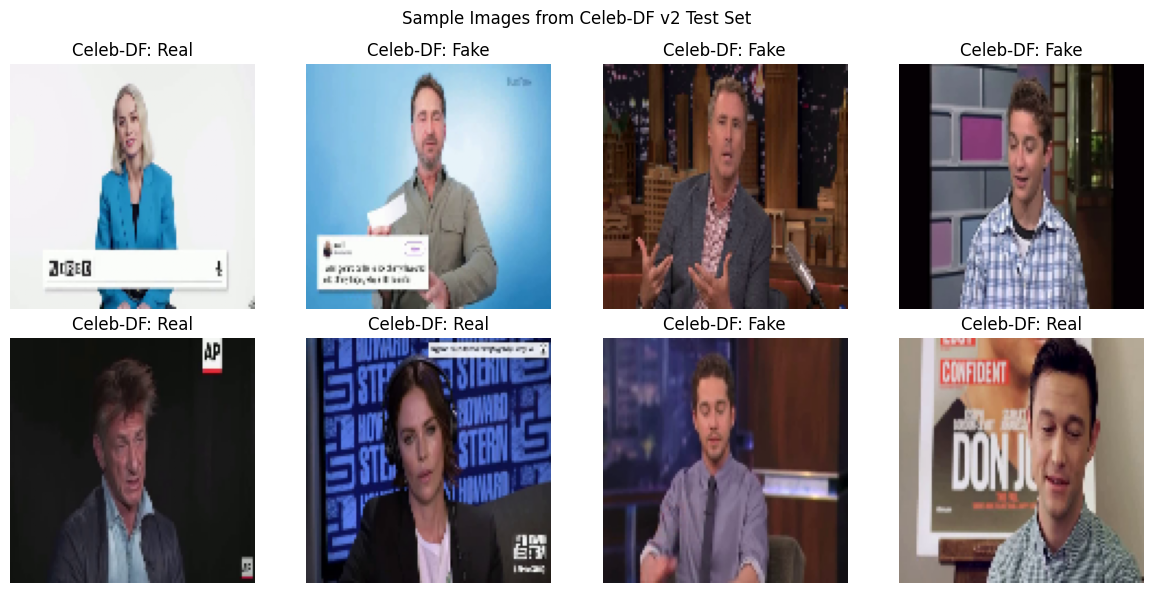


✓ Celeb-DF v2 dataset ready for zero-shot validation!


In [ ]:
# ====== PREPARE CELEB-DF V2 TEST DATA FOR ZERO-SHOT VALIDATION ======
print("Loading Celeb-DF v2 dataset for cross-dataset generalization testing...")
import numpy as np
import pickle
import subprocess
from pathlib import Path
import random

# Ensure Celeb-DF data directory exists
os.makedirs(CELEB_DF_DATA_DIR, exist_ok=True)

# Initialize GCS client
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

print("\n" + "-"*60)
print("Downloading Celeb-DF v2 processed data from GCS...")

# Download Celeb-DF metadata
celeb_df_metadata_path = os.path.join(CELEB_DF_DATA_DIR, 'metadata.pkl')
if not os.path.exists(celeb_df_metadata_path):
    print("Downloading Celeb-DF metadata from GCS...")
    blob = bucket.blob('celeb_df_v2/processed/metadata.pkl')
    if blob.exists():
        blob.download_to_filename(celeb_df_metadata_path)
        print("  Downloaded metadata.pkl")
    else:
        raise FileNotFoundError("Celeb-DF v2 metadata not found in GCS. Please run the Celeb-DF preprocessing pipeline first.")

# Load metadata
with open(celeb_df_metadata_path, 'rb') as f:
    celeb_df_metadata = pickle.load(f)

print(f"\nCeleb-DF v2 Dataset Info:")
print(f"  Total samples: {celeb_df_metadata['total_samples']:,}")
print(f"  Frame shape: {celeb_df_metadata['shape']}")
print(f"  Train samples: {celeb_df_metadata.get('train_samples', 0):,}")
print(f"  Val samples: {celeb_df_metadata.get('val_samples', 0):,}")
print(f"  Test samples: {celeb_df_metadata.get('test_samples', 0):,}")

# Download memmap files for Celeb-DF
print("\nChecking Celeb-DF memmap files...")
celeb_df_memmap_files = [
    ('celeb_df_v2/processed/frames_memmap.dat', os.path.join(CELEB_DF_DATA_DIR, 'frames_memmap.dat')),
    ('celeb_df_v2/processed/labels_memmap.dat', os.path.join(CELEB_DF_DATA_DIR, 'labels_memmap.dat'))
]

for gcs_path, local_path in celeb_df_memmap_files:
    if not os.path.exists(local_path):
        blob = bucket.blob(gcs_path)
        if blob.exists():
            blob.reload()
            file_size_gb = blob.size / (1024**3) if blob.size else 0
            print(f"Downloading {os.path.basename(local_path)} ({file_size_gb:.2f} GB)...")

            if file_size_gb > 1:
                # Use gsutil for large files
                cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                result = subprocess.run(cmd, shell=True)
                if result.returncode == 0:
                    print(f"  Downloaded {os.path.basename(local_path)}")
                else:
                    raise Exception(f"Failed to download {gcs_path}")
            else:
                blob.download_to_filename(local_path)
                print(f"  Downloaded {os.path.basename(local_path)}")
        else:
            raise FileNotFoundError(f"Celeb-DF file not found in GCS: {gcs_path}")
    else:
        print(f"  {os.path.basename(local_path)} already cached locally")

# Load Celeb-DF memmap arrays
print("\nLoading Celeb-DF memmap arrays...")
celeb_df_X = np.memmap(
    os.path.join(CELEB_DF_DATA_DIR, 'frames_memmap.dat'),
    dtype=np.uint8,
    mode='r',
    shape=celeb_df_metadata['shape']
)
celeb_df_y = np.memmap(
    os.path.join(CELEB_DF_DATA_DIR, 'labels_memmap.dat'),
    dtype=np.int8,
    mode='r',
    shape=(celeb_df_metadata['total_samples'],)
)

print(f"Celeb-DF arrays loaded: X shape {celeb_df_X.shape}, y shape {celeb_df_y.shape}")

# Download Celeb-DF test indices
print("\nLoading Celeb-DF test split...")
celeb_df_test_indices_path = os.path.join(CELEB_DF_DATA_DIR, 'test_indices.npy')
if not os.path.exists(celeb_df_test_indices_path):
    print("Downloading test_indices.npy from GCS...")
    blob = bucket.blob('celeb_df_v2/processed/test_indices.npy')
    if blob.exists():
        blob.download_to_filename(celeb_df_test_indices_path)
        print("  Downloaded test_indices.npy")
        # FIXED: Load the downloaded file
        celeb_df_test_indices = np.load(celeb_df_test_indices_path)
    else:
        # If no test indices, create them
        print("  Test indices not found, creating random split...")
        all_indices = np.arange(celeb_df_metadata['total_samples'])
        np.random.seed(42)
        np.random.shuffle(all_indices)
        test_size = int(0.1 * len(all_indices))  # Use 10% for testing
        celeb_df_test_indices = all_indices[:test_size]
        np.save(celeb_df_test_indices_path, celeb_df_test_indices)
else:
    celeb_df_test_indices = np.load(celeb_df_test_indices_path)

print(f"Celeb-DF test set: {len(celeb_df_test_indices):,} samples")

# Limit samples for faster evaluation during evolution
MAX_CELEB_DF_SAMPLES = 5000  # Adjust as needed
if len(celeb_df_test_indices) > MAX_CELEB_DF_SAMPLES:
    print(f"Limiting to {MAX_CELEB_DF_SAMPLES} samples for faster evaluation...")
    np.random.seed(42)
    selected_indices = np.random.choice(celeb_df_test_indices, MAX_CELEB_DF_SAMPLES, replace=False)
else:
    selected_indices = celeb_df_test_indices

# Load the selected samples
print(f"\nLoading {len(selected_indices)} Celeb-DF test samples...")
celeb_df_X_test = celeb_df_X[selected_indices].astype(np.float32) / 255.0
celeb_df_y_test = celeb_df_y[selected_indices].astype(np.float32)

# Create the test data tuple
celeb_df_test_data = (celeb_df_X_test, celeb_df_y_test)

print(f"\nCeleb-DF v2 test data loaded:")
print(f"  Total samples: {len(celeb_df_X_test)}")
print(f"  Real samples: {np.sum(celeb_df_y_test == 0)}")
print(f"  Fake samples: {np.sum(celeb_df_y_test == 1)}")
print(f"  Data shape: {celeb_df_X_test.shape}")
print(f"  Value range: [{celeb_df_X_test.min():.2f}, {celeb_df_X_test.max():.2f}]")

# Display sample images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
sample_idx = np.random.choice(len(celeb_df_X_test), 8, replace=False)

for i, idx in enumerate(sample_idx):
    ax = axes[i // 4, i % 4]
    ax.imshow(celeb_df_X_test[idx])
    label = "Real" if celeb_df_y_test[idx] == 0 else "Fake"
    ax.set_title(f"Celeb-DF: {label}")
    ax.axis('off')

plt.suptitle("Sample Images from Celeb-DF v2 Test Set")
plt.tight_layout()
plt.show()

print("\n✓ Celeb-DF v2 dataset ready for zero-shot validation!")

**6. Run Evolutionary Optimisation**

In [ ]:
# ====== DELETE THE OLD CREATED CHECKPOINT ======
import os
CHECKPOINT_FILE = os.path.join(LOCAL_DATA_DIR, 'evolution_checkpoint.pkl')
if os.path.exists(CHECKPOINT_FILE):
    os.remove(CHECKPOINT_FILE)
    print("Old checkpoint deleted")

Old checkpoint deleted


In [ ]:
# ====== RUN EVOLUTIONARY OPTIMISATION ======
import gc
import psutil
import os

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024 / 1024

def smart_cleanup(evo_optimizer, threshold_gb=15):
    """Only cleanup when memory exceeds threshold, preserving essential data"""
    mem_usage = get_memory_usage()

    if mem_usage > threshold_gb:
        print(f"\nMemory usage ({mem_usage:.2f} GB) exceeds threshold ({threshold_gb} GB)")
        print("Performing smart cleanup while preserving evolution context...")

        # Save essential evolution context
        essential_context = {
            'tried_genomes': [ind.genome for ind in evo_optimizer.all_individuals[-100:]],
            'performance_history': [(ind.fitness, ind.metrics) for ind in evo_optimizer.all_individuals[-100:]],
            'best_genomes': sorted(evo_optimizer.all_individuals, key=lambda x: x.fitness, reverse=True)[:10]
        }

        # Clear TensorFlow session
        tf.keras.backend.clear_session()

        # Keep only essential individuals
        if len(evo_optimizer.all_individuals) > 100:
            evo_optimizer.all_individuals = evo_optimizer.all_individuals[-100:]

        # Force garbage collection
        gc.collect()

        new_mem = get_memory_usage()
        print(f"Memory reduced from {mem_usage:.2f} GB to {new_mem:.2f} GB")

        # Store context for ChatGPT continuity
        evo_optimizer.evolution_context = essential_context
        return True

    return False

def serialize_individual(individual):
    """Serialize individual without the model object"""
    return {
        'genome': individual.genome,
        'fitness': individual.fitness,
        'metrics': individual.metrics,
        'id': individual.id,
        'model_saved_path': individual.model_saved_path if hasattr(individual, 'model_saved_path') else None,
        'training_time': individual.training_time if hasattr(individual, 'training_time') else 0,
        'random_seed': individual.random_seed if hasattr(individual, 'random_seed') else None
    }

def deserialize_individual(data):
    """Recreate individual from serialized data"""
    ind = Individual(data['genome'])
    ind.fitness = data.get('fitness', 0.0)
    ind.metrics = data.get('metrics', {})
    ind.id = data.get('id', ind.id)
    ind.model_saved_path = data.get('model_saved_path', None)
    ind.training_time = data.get('training_time', 0)
    ind.random_seed = data.get('random_seed', hash(ind.id) % (2**32))
    # Don't restore the model object - it's saved separately in GCS
    ind.model = None
    return ind

print("Starting Evolutionary Optimization with Smart Memory Management")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Initial memory usage: {get_memory_usage():.2f} GB")
print(f"Running for {EVOLUTION_CONFIG['num_generations']} generations")
print("Memory cleanup threshold: 15 GB (only cleans when necessary)")
print("ChatGPT 5 will analyze at END of every 2nd generation")
print("RANDOM DATA SPLITS: Each individual gets unique train/val/test splits")

# Check for checkpoint
CHECKPOINT_FILE = os.path.join(LOCAL_DATA_DIR, 'evolution_checkpoint.pkl')
START_GENERATION = 0
LOADED_FROM_CHECKPOINT = False
checkpoint_data = {}

if os.path.exists(CHECKPOINT_FILE):
    print("\n" + "="*60)
    print("CHECKPOINT FOUND!")
    print("="*60)
    try:
        with open(CHECKPOINT_FILE, 'rb') as f:
            checkpoint_data = pickle.load(f)

        START_GENERATION = checkpoint_data['last_generation'] + 1
        print(f"Resuming from generation {START_GENERATION}")
        print(f"Best fitness so far: {checkpoint_data['best_fitness']:.4f}")
        print(f"Best Celeb-DF accuracy: {checkpoint_data['best_celeb_df_acc']:.4f}")
        print(f"Total models trained so far: {checkpoint_data.get('total_models_trained', 0)}")
        LOADED_FROM_CHECKPOINT = True
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Starting fresh instead...")
        LOADED_FROM_CHECKPOINT = False
        START_GENERATION = 0
else:
    print("No checkpoint found - starting fresh")

# Check if we have necessary data
if 'X' not in globals() or 'y' not in globals():
    print("Loading WildDeepfake dataset...")
    X = np.memmap(
        os.path.join(LOCAL_DATA_DIR, '02_processed_data/X_memmap.dat'),
        dtype=np.uint8,
        mode='r',
        shape=metadata['shape']
    )
    y = np.memmap(
        os.path.join(LOCAL_DATA_DIR, '02_processed_data/y_memmap.dat'),
        dtype=np.int8,
        mode='r',
        shape=(metadata['total_samples'],)
    )

celeb_df_y_test_flipped = 1 - celeb_df_y_test
celeb_df_test_data = (celeb_df_X_test, celeb_df_y_test_flipped)

print("\n" + "="*80)
print("EVOLUTION CONFIGURATION:")
print(f"  Generations: {EVOLUTION_CONFIG['num_generations']}")
print(f"  Population size: {EVOLUTION_CONFIG['population_size']}")
print(f"  Elite size: {EVOLUTION_CONFIG['elite_size']}")
print(f"  Mutation rate: {EVOLUTION_CONFIG['mutation_rate']}")
print(f"  Crossover rate: {EVOLUTION_CONFIG['crossover_rate']}")
print(f"  Max epochs per model: {EVOLUTION_CONFIG['max_epochs_per_model']}")
print(f"  Max hours per model: {EVOLUTION_CONFIG['max_hours_per_model']}")
print(f"  ChatGPT 5: Analyzes at END of generations 1, 3, 5...")
print(f"  ChatGPT influences NEXT generation's population creation")
print(f"  Cross-dataset validation with Celeb-DF v2")
print(f"  RANDOM DATA SPLITS for each individual")
print(f"  Smart memory management (threshold: 15 GB)")
print(f"  Checkpoint/Resume enabled")
print("="*80)

# Initialize or restore evolutionary optimizer
if not LOADED_FROM_CHECKPOINT or 'evo_optimizer' not in globals():
    evo_optimizer = EvolutionaryOptimizer(
        LOCAL_DATA_DIR,
        GCS_BUCKET,
        chatgpt_advisor,
        existing_genome=existing_genome if 'existing_genome' in globals() and not LOADED_FROM_CHECKPOINT else None
    )

    if LOADED_FROM_CHECKPOINT:
        # Restore optimizer state from checkpoint
        evo_optimizer.generation = START_GENERATION - 1
        # Deserialize all individuals properly
        if 'all_individuals_data' in checkpoint_data:
            evo_optimizer.all_individuals = [
                deserialize_individual(ind_data)
                for ind_data in checkpoint_data['all_individuals_data']
            ]
        else:
            evo_optimizer.all_individuals = []
        evo_optimizer.total_models_trained = checkpoint_data.get('total_models_trained', 0)
        evo_optimizer.history = checkpoint_data.get('history', [])
        evo_optimizer.next_gen_suggestions = checkpoint_data.get('next_gen_suggestions')

        # Restore ChatGPT history
        if 'chatgpt_generation_history' in checkpoint_data:
            chatgpt_advisor.generation_history = checkpoint_data['chatgpt_generation_history']

# Track evolution progress for visualization
evolution_progress = checkpoint_data.get('evolution_progress', {
    'generation': [],
    'best_fitness': [],
    'avg_fitness': [],
    'best_val_acc': [],
    'best_test_acc': [],
    'best_celeb_df_acc': [],
    'chatgpt_analysis_gens': [],  # Track when ChatGPT analyzed
    'data_split_seeds': []
})

# Evolution loop with smart memory management
best_individual = None
best_fitness = checkpoint_data.get('best_fitness', 0.0)

# Recreate best individual from checkpoint data if available
if LOADED_FROM_CHECKPOINT and 'best_individual_data' in checkpoint_data:
    best_individual = deserialize_individual(checkpoint_data['best_individual_data'])

# Preserve ChatGPT conversation context if resuming
if LOADED_FROM_CHECKPOINT and 'chatgpt_history' in checkpoint_data:
    chatgpt_advisor.conversation_history = checkpoint_data['chatgpt_history']

try:
    for gen in range(START_GENERATION, EVOLUTION_CONFIG['num_generations']):
        print(f"\n{'='*60}")
        print(f"GENERATION {gen + 1}/{EVOLUTION_CONFIG['num_generations']}")
        print(f"Total models trained so far: {evo_optimizer.total_models_trained}")
        print(f"Current memory usage: {get_memory_usage():.2f} GB")
        print(f"Time elapsed: {(time.time() - evo_optimizer.start_time) / 3600:.2f} hours")
        print(f"{'='*60}")

        evo_optimizer.generation = gen

        # Initialize or restore population
        if gen == START_GENERATION:
            if LOADED_FROM_CHECKPOINT and 'population_data' in checkpoint_data:
                # Recreate population from saved data
                print("Restoring population from checkpoint...")
                evo_optimizer.population = [
                    deserialize_individual(ind_data)
                    for ind_data in checkpoint_data['population_data']
                ]
            elif gen == 0:
                # Initialize population for first generation
                print("Initializing population...")
                if existing_genome:
                    print("Starting from existing model architecture...")
                    evo_optimizer.population = []
                    evo_optimizer.population.append(Individual(existing_genome.copy()))
                    for _ in range(EVOLUTION_CONFIG['population_size'] - 1):
                        evo_optimizer.population.append(Individual(base_genome=existing_genome))
                else:
                    print("Starting from random architectures...")
                    evo_optimizer.population = [Individual() for _ in range(EVOLUTION_CONFIG['population_size'])]

                print(f"Each individual will use different random data splits")

        # Evaluate population with random splits
        for i, individual in enumerate(evo_optimizer.population):
            if individual.fitness == 0.0:
                print(f"\n[{i+1}/{len(evo_optimizer.population)}] ", end="")

                try:
                    # Pass X and y data instead of pre-made generators
                    evo_optimizer.evaluate_individual(
                        individual, X, y, celeb_df_test_data, save_models=True
                    )
                    evo_optimizer.generate_report(individual, gen)

                    # Clear the model object after evaluation to save memory
                    individual.model = None

                    # Only cleanup if memory is getting critical
                    if get_memory_usage() > 18:  # Emergency threshold
                        print(f"Critical memory usage: {get_memory_usage():.2f} GB")
                        smart_cleanup(evo_optimizer, threshold_gb=15)

                except Exception as e:
                    print(f"\nError evaluating individual: {e}")
                    individual.fitness = 0.0  # Mark as failed
                    individual.model = None
                    # Try cleanup on error
                    smart_cleanup(evo_optimizer, threshold_gb=14)

        # Sort population by fitness
        evo_optimizer.population.sort(key=lambda x: x.fitness, reverse=True)

        # Track best individual
        if evo_optimizer.population[0].fitness > best_fitness:
            best_fitness = evo_optimizer.population[0].fitness
            best_individual = evo_optimizer.population[0]

        # Store progress for visualization
        evolution_progress['generation'].append(gen + 1)
        evolution_progress['best_fitness'].append(evo_optimizer.population[0].fitness)
        evolution_progress['avg_fitness'].append(np.mean([ind.fitness for ind in evo_optimizer.population]))
        evolution_progress['best_val_acc'].append(evo_optimizer.population[0].metrics.get('val_accuracy', 0))
        evolution_progress['best_test_acc'].append(evo_optimizer.population[0].metrics.get('test_accuracy', 0))
        evolution_progress['best_celeb_df_acc'].append(evo_optimizer.population[0].metrics.get('celeb_df_accuracy', 0))
        evolution_progress['data_split_seeds'].append([
            ind.metrics.get('data_split_seed', 0) for ind in evo_optimizer.population
        ])

        # Generation summary
        print(f"\nGeneration {gen + 1} Summary:")
        print(f"   Best fitness: {evo_optimizer.population[0].fitness:.4f}")
        print(f"   Avg fitness: {np.mean([ind.fitness for ind in evo_optimizer.population]):.4f}")
        print(f"   Best individual: {evo_optimizer.population[0].id}")
        print(f"   Best Celeb-DF accuracy: {evo_optimizer.population[0].metrics.get('celeb_df_accuracy', 0):.4f}")
        print(f"   Data split seeds used: {[ind.metrics.get('data_split_seed', 0) for ind in evo_optimizer.population[:3]]}")
        print(f"   Memory usage: {get_memory_usage():.2f} GB")

        # ChatGPT analysis at end of every 2nd generation
        if gen % 2 == 1:  # After generations 1, 3, 5, etc.
            print(f"\nGeneration {gen + 1} complete - Requesting ChatGPT analysis...")
            suggestions = evo_optimizer.analyze_generation_and_get_suggestions()
            evolution_progress['chatgpt_analysis_gens'].append(gen + 1)

        # Save generation summary to GCS
        evo_optimizer.save_generation_summary(gen)

        # Save checkpoint without model objects
        checkpoint_data = {
            'last_generation': gen,
            'best_fitness': best_fitness,
            'best_celeb_df_acc': best_individual.metrics.get('celeb_df_accuracy', 0) if best_individual else 0,
            'best_individual_data': serialize_individual(best_individual) if best_individual else None,
            'population_data': [serialize_individual(ind) for ind in evo_optimizer.population],
            'all_individuals_data': [serialize_individual(ind) for ind in evo_optimizer.all_individuals[-100:]],  # Keep last 100
            'total_models_trained': evo_optimizer.total_models_trained,
            'history': evo_optimizer.history[-50:],  # Keep last 50 entries
            'chatgpt_history': chatgpt_advisor.conversation_history[-20:],  # Keep last 20 conversations
            'chatgpt_generation_history': chatgpt_advisor.generation_history,  # Save full generation history
            'next_gen_suggestions': evo_optimizer.next_gen_suggestions,  # Save pending suggestions
            'evolution_progress': evolution_progress  # Save progress for visualization
        }

        with open(CHECKPOINT_FILE, 'wb') as f:
            pickle.dump(checkpoint_data, f)
        print(f"✓ Checkpoint saved (generation {gen + 1})")

        # Smart cleanup only if needed (check after checkpoint save)
        smart_cleanup(evo_optimizer, threshold_gb=15)

        # Generate new population for next generation
        if gen < EVOLUTION_CONFIG['num_generations'] - 1:
            # Use ChatGPT-influenced creation if we have suggestions
            if evo_optimizer.next_gen_suggestions:
                print(f"\nCreating next generation with ChatGPT influence...")
                new_population = evo_optimizer.create_next_generation()
            else:
                # Standard evolutionary creation
                print(f"\nCreating next generation through standard evolution...")
                new_population = []

                # Elitism - keep best individuals
                elite_size = EVOLUTION_CONFIG['elite_size']
                new_population.extend(evo_optimizer.population[:elite_size])

                # Generate rest of population
                while len(new_population) < EVOLUTION_CONFIG['population_size']:
                    parent1 = evo_optimizer.tournament_select()
                    parent2 = evo_optimizer.tournament_select()

                    if random.random() < EVOLUTION_CONFIG['crossover_rate']:
                        child = parent1.crossover(parent2)
                    else:
                        child = Individual(parent1.genome.copy())

                    child.mutate(EVOLUTION_CONFIG['mutation_rate'])
                    new_population.append(child)

            evo_optimizer.population = new_population
            print(f"New population created - each will get fresh random data splits")

except KeyboardInterrupt:
    print("\nEvolution interrupted by user - checkpoint saved")
    print(f"Completed {gen - START_GENERATION + 1} generations in this run")
except Exception as e:
    print(f"\nERROR: {e}")
    print("Evolution interrupted - checkpoint saved for resume")
    import traceback
    traceback.print_exc()

# Final report
if best_individual:
    evo_optimizer.generate_final_report(best_individual)

    print("\n" + "="*80)
    print("EVOLUTION STATUS")
    print("="*80)

    generations_completed = min(gen + 1, EVOLUTION_CONFIG['num_generations'])
    if gen >= START_GENERATION:
        generations_completed = gen + 1

    print(f"Total generations completed: {generations_completed}/{EVOLUTION_CONFIG['num_generations']}")
    print(f"Best individual: {best_individual.id}")
    print(f"Best fitness: {best_individual.fitness:.4f}")
    print(f"Best Test Accuracy: {best_individual.metrics.get('test_accuracy', 0):.4f}")
    print(f"Best Celeb-DF accuracy: {best_individual.metrics.get('celeb_df_accuracy', 0):.4f}")
    print(f"Data split seed: {best_individual.metrics.get('data_split_seed', 'N/A')}")
    print(f"Total models trained: {evo_optimizer.total_models_trained}")
    print("All models have been saved with their original weights.")
    print("Each model was trained on UNIQUE random data splits for better generalization.")

    # API usage summary
    api_stats = chatgpt_advisor.get_usage_stats()
    print(f"\nChatGPT 5 Usage Summary:")
    print(f"  Total API calls: {api_stats['total_api_calls']}")
    print(f"  Total tokens: {api_stats['total_tokens_used']:,}")
    print(f"  Generations analyzed: {api_stats['generations_analyzed']}")
    print(f"  Analysis performed at generations: {evolution_progress.get('chatgpt_analysis_gens', [])}")
    print(f"  Estimated cost: ${api_stats['estimated_cost']:.2f}")

    # Save evolution progress for visualization
    with open(os.path.join(LOCAL_DATA_DIR, 'evolution_progress.pkl'), 'wb') as f:
        pickle.dump(evolution_progress, f)

    # Check if fully completed
    if generations_completed >= EVOLUTION_CONFIG['num_generations']:
        print("\nEVOLUTION FULLY COMPLETED!")

        # Cleanup checkpoint
        if os.path.exists(CHECKPOINT_FILE):
            os.remove(CHECKPOINT_FILE)
            print("✓ Checkpoint file removed (no longer needed)")

        print("\n" + "="*80)
        print("MODEL SELECTION")
        print("="*80)

        # Select from saved models
        chosen_individual, selected_model = evo_optimizer.select_and_copy_saved_model()

        if chosen_individual:
            print("\n" + "="*80)
            print("PROCESS COMPLETE!")
            print(f"Selected model saved to GCS bucket: {GCS_BUCKET}")
            print(f"Individual ID: {chosen_individual.id}")
            print(f"Celeb-DF v2 accuracy: {chosen_individual.metrics.get('celeb_df_accuracy', 0):.4f}")
            print(f"Trained with data split seed: {chosen_individual.metrics.get('data_split_seed', 'N/A')}")
            print("="*80)
    else:
        print(f"\nEvolution stopped at generation {generations_completed}/{EVOLUTION_CONFIG['num_generations']}")
        print("→ Re-run this cell to resume from checkpoint")
        print(f"→ {EVOLUTION_CONFIG['num_generations'] - generations_completed} generations remaining")
else:
    print("\nNo valid individuals found yet")
    print("Re-run this cell to continue evolution")

Starting Evolutionary Optimization with Smart Memory Management
Start time: 2025-09-18 16:15:02
Initial memory usage: 2.47 GB
Running for 50 generations
Memory cleanup threshold: 15 GB (only cleans when necessary)
ChatGPT 5 will analyze at END of every 2nd generation
RANDOM DATA SPLITS: Each individual gets unique train/val/test splits

CHECKPOINT FOUND!
Resuming from generation 26
Best fitness so far: 0.7662
Best Celeb-DF accuracy: 0.5224
Total models trained so far: 210

EVOLUTION CONFIGURATION:
  Generations: 50
  Population size: 10
  Elite size: 2
  Mutation rate: 0.3
  Crossover rate: 0.5
  Max epochs per model: 10
  Max hours per model: 5.0
  ChatGPT 5: Analyzes at END of generations 1, 3, 5...
  ChatGPT influences NEXT generation's population creation
  Cross-dataset validation with Celeb-DF v2
  RANDOM DATA SPLITS for each individual
  Smart memory management (threshold: 15 GB)
  Checkpoint/Resume enabled

GENERATION 27/50
Total models trained so far: 0
Current memory usage: 2

2025-09-18 16:15:03.665687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 16:15:06.091611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2025-09-18 16:15:07.134369: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3af452e3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-18 16:15:07.134411: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-09-18 16:15:07.204807: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-18 16:15:07.703591

   Fitness: 0.7495 | Val: 0.8864 | Test: 0.8881 | AUC: 0.9559 | Celeb-DF: 0.5086
   Fitness breakdown: Val(20%): 0.177 + Test(20%): 0.178 + AUC(20%): 0.191 + Celeb(40%): 0.203
   Model saved to GCS: evolution_models/generation_27/model_20250918_161503_7651.h5

[4/10] 
Evaluating individual 20250918_161503_3821
   Data splits (seed=1614): Train=50000, Val=10000, Test=10000


2025-09-18 16:29:16.992447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 16:31:00.809047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 16:42:17.674897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7128 | Val: 0.8128 | Test: 0.8121 | AUC: 0.9063 | Celeb-DF: 0.5164
   Fitness breakdown: Val(20%): 0.163 + Test(20%): 0.162 + AUC(20%): 0.181 + Celeb(40%): 0.207
   Model saved to GCS: evolution_models/generation_27/model_20250918_161503_3821.h5

[5/10] 
Evaluating individual 20250918_161503_1545
   Data splits (seed=602): Train=50000, Val=10000, Test=10000


2025-09-18 16:42:31.333898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 16:44:47.484702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 17:05:38.559127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7376 | Val: 0.8467 | Test: 0.8565 | AUC: 0.9304 | Celeb-DF: 0.5272
   Fitness breakdown: Val(20%): 0.169 + Test(20%): 0.171 + AUC(20%): 0.186 + Celeb(40%): 0.211
   Model saved to GCS: evolution_models/generation_27/model_20250918_161503_1545.h5

[6/10] 
Evaluating individual 20250918_161503_7736
   Data splits (seed=5407): Train=50000, Val=10000, Test=10000


2025-09-18 17:05:55.002706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 17:07:45.556231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 17:21:12.469009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7232 | Val: 0.8287 | Test: 0.8263 | AUC: 0.9197 | Celeb-DF: 0.5206
   Fitness breakdown: Val(20%): 0.166 + Test(20%): 0.165 + AUC(20%): 0.184 + Celeb(40%): 0.208
   Model saved to GCS: evolution_models/generation_27/model_20250918_161503_7736.h5

[7/10] 
Evaluating individual 20250918_161503_4103
   Data splits (seed=9751): Train=50000, Val=10000, Test=10000


2025-09-18 17:21:27.119115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 17:23:10.273737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 17:34:11.886740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6945 | Val: 0.7695 | Test: 0.7747 | AUC: 0.8564 | Celeb-DF: 0.5360
   Fitness breakdown: Val(20%): 0.154 + Test(20%): 0.155 + AUC(20%): 0.171 + Celeb(40%): 0.214
   Model saved to GCS: evolution_models/generation_27/model_20250918_161503_4103.h5

[8/10] 
Evaluating individual 20250918_161503_5937
   Data splits (seed=2318): Train=50000, Val=10000, Test=10000


2025-09-18 17:34:24.816894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 17:34:25.868522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 17:37:05.128687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 17:58:31.201910: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5928 | Val: 0.6416 | Test: 0.6446 | AUC: 0.6757 | Celeb-DF: 0.5010
   Fitness breakdown: Val(20%): 0.128 + Test(20%): 0.129 + AUC(20%): 0.135 + Celeb(40%): 0.200
   Model saved to GCS: evolution_models/generation_27/model_20250918_161503_5937.h5

[9/10] 
Evaluating individual 20250918_161503_2628
   Data splits (seed=195): Train=50000, Val=10000, Test=10000


2025-09-18 17:58:46.878696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 18:00:43.820018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 18:18:09.246188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7369 | Val: 0.8344 | Test: 0.8368 | AUC: 0.9287 | Celeb-DF: 0.5422
   Fitness breakdown: Val(20%): 0.167 + Test(20%): 0.167 + AUC(20%): 0.186 + Celeb(40%): 0.217
   Model saved to GCS: evolution_models/generation_27/model_20250918_161503_2628.h5

[10/10] 
Evaluating individual 20250918_161503_7381
   Data splits (seed=3793): Train=50000, Val=10000, Test=10000


2025-09-18 18:18:25.222870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 18:18:27.269840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 18:21:35.178056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 18:50:16.770630: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6847 | Val: 0.7916 | Test: 0.7986 | AUC: 0.8763 | Celeb-DF: 0.4786
   Fitness breakdown: Val(20%): 0.158 + Test(20%): 0.160 + AUC(20%): 0.175 + Celeb(40%): 0.191
   Model saved to GCS: evolution_models/generation_27/model_20250918_161503_7381.h5

Generation 28 Summary:
   Best fitness: 0.7662
   Avg fitness: 0.7162
   Best individual: 20250917_123837_9888
   Best Celeb-DF accuracy: 0.5224
   Data split seeds used: [620, 8148, 6762]
   Memory usage: 8.99 GB

Generation 28 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 28)

Generation 28 Performance Summary:
   Best Fitness: 0.7662
   Average Fitness: 0.7162
   Best Val Accuracy: 0.9124
   Best Test Accuracy: 0.9062
   Best Test AUC: 0.9676
   Best Celeb-DF Accuracy: 0.5224
   Avg Generalization Gap: 0.3092

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (1 generations analyz

2025-09-18 18:50:38.983465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 18:50:41.106990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 18:53:49.057973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 19:22:31.696939: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7321 | Val: 0.8389 | Test: 0.8404 | AUC: 0.9209 | Celeb-DF: 0.5302
   Fitness breakdown: Val(20%): 0.168 + Test(20%): 0.168 + AUC(20%): 0.184 + Celeb(40%): 0.212
   Model saved to GCS: evolution_models/generation_28/model_20250918_185038_3386.h5

[4/10] 
Evaluating individual 20250918_185038_9015
   Data splits (seed=7510): Train=50000, Val=10000, Test=10000


2025-09-18 19:22:46.852092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 19:22:48.852282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 19:25:56.678837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 19:54:36.975412: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7193 | Val: 0.8297 | Test: 0.8299 | AUC: 0.9151 | Celeb-DF: 0.5110
   Fitness breakdown: Val(20%): 0.166 + Test(20%): 0.166 + AUC(20%): 0.183 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_28/model_20250918_185038_9015.h5

[5/10] 
Evaluating individual 20250918_185038_2909
   Data splits (seed=2452): Train=50000, Val=10000, Test=10000


2025-09-18 19:54:52.217799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 19:54:54.229220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 19:58:01.382557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 20:26:44.347739: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7238 | Val: 0.8428 | Test: 0.8453 | AUC: 0.9207 | Celeb-DF: 0.5050
   Fitness breakdown: Val(20%): 0.169 + Test(20%): 0.169 + AUC(20%): 0.184 + Celeb(40%): 0.202
   Model saved to GCS: evolution_models/generation_28/model_20250918_185038_2909.h5

[6/10] 
Evaluating individual 20250918_185038_5035
   Data splits (seed=190): Train=50000, Val=10000, Test=10000


2025-09-18 20:26:59.722951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 20:28:47.335158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 20:43:23.895334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6728 | Val: 0.7759 | Test: 0.7812 | AUC: 0.8534 | Celeb-DF: 0.4768
   Fitness breakdown: Val(20%): 0.155 + Test(20%): 0.156 + AUC(20%): 0.171 + Celeb(40%): 0.191
   Model saved to GCS: evolution_models/generation_28/model_20250918_185038_5035.h5

[7/10] 
Evaluating individual 20250918_185038_7769
   Data splits (seed=2584): Train=50000, Val=10000, Test=10000


2025-09-18 20:43:39.166760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 20:45:25.324807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 20:51:49.136074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6457 | Val: 0.7069 | Test: 0.6964 | AUC: 0.7446 | Celeb-DF: 0.5404
   Fitness breakdown: Val(20%): 0.141 + Test(20%): 0.139 + AUC(20%): 0.149 + Celeb(40%): 0.216
   Model saved to GCS: evolution_models/generation_28/model_20250918_185038_7769.h5

[8/10] 
Evaluating individual 20250918_185038_4116
   Data splits (seed=2355): Train=50000, Val=10000, Test=10000


2025-09-18 20:52:03.329914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 20:54:07.056965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 21:12:08.374122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7017 | Val: 0.7883 | Test: 0.7775 | AUC: 0.8906 | Celeb-DF: 0.5260
   Fitness breakdown: Val(20%): 0.158 + Test(20%): 0.155 + AUC(20%): 0.178 + Celeb(40%): 0.210
   Model saved to GCS: evolution_models/generation_28/model_20250918_185038_4116.h5

[9/10] 
Evaluating individual 20250918_185038_7976
   Data splits (seed=4336): Train=50000, Val=10000, Test=10000


2025-09-18 21:12:24.949032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 21:14:16.080141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 21:28:27.873573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7155 | Val: 0.8073 | Test: 0.8005 | AUC: 0.9198 | Celeb-DF: 0.5250
   Fitness breakdown: Val(20%): 0.161 + Test(20%): 0.160 + AUC(20%): 0.184 + Celeb(40%): 0.210
   Model saved to GCS: evolution_models/generation_28/model_20250918_185038_7976.h5

[10/10] 
Evaluating individual 20250918_185038_9428
   Data splits (seed=4364): Train=50000, Val=10000, Test=10000


2025-09-18 21:28:43.269147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 21:30:22.924723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 21:41:24.647502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6286 | Val: 0.6637 | Test: 0.6645 | AUC: 0.6792 | Celeb-DF: 0.5678
   Fitness breakdown: Val(20%): 0.133 + Test(20%): 0.133 + AUC(20%): 0.136 + Celeb(40%): 0.227
   Model saved to GCS: evolution_models/generation_28/model_20250918_185038_9428.h5

Generation 29 Summary:
   Best fitness: 0.7662
   Avg fitness: 0.7069
   Best individual: 20250917_123837_9888
   Best Celeb-DF accuracy: 0.5224
   Data split seeds used: [620, 8148, 1270]
   Memory usage: 9.25 GB
✓ Checkpoint saved (generation 29)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 30/50
Total models trained so far: 16
Current memory usage: 9.25 GB
Time elapsed: 5.45 hours

[3/10] 
Evaluating individual 20250918_214137_5989
   Data splits (seed=5770): Train=50000, Val=10000, Test=10000


2025-09-18 21:41:38.211597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 21:43:27.063651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 21:55:25.008314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6821 | Val: 0.7687 | Test: 0.7646 | AUC: 0.8408 | Celeb-DF: 0.5182
   Fitness breakdown: Val(20%): 0.154 + Test(20%): 0.153 + AUC(20%): 0.168 + Celeb(40%): 0.207
   Model saved to GCS: evolution_models/generation_29/model_20250918_214137_5989.h5

[4/10] 
Evaluating individual 20250918_214137_8796
   Data splits (seed=2320): Train=50000, Val=10000, Test=10000


2025-09-18 21:55:39.226065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 21:55:40.314880: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 21:57:28.297879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 22:09:23.390393: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7719 | Val: 0.9060 | Test: 0.9183 | AUC: 0.9730 | Celeb-DF: 0.5310
   Fitness breakdown: Val(20%): 0.181 + Test(20%): 0.184 + AUC(20%): 0.195 + Celeb(40%): 0.212
   Model saved to GCS: evolution_models/generation_29/model_20250918_214137_8796.h5

[5/10] 
Evaluating individual 20250918_214137_5554
   Data splits (seed=873): Train=50000, Val=10000, Test=10000


2025-09-18 22:09:37.927330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 22:09:39.513701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 22:12:18.923064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 22:36:47.035294: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6553 | Val: 0.7255 | Test: 0.7153 | AUC: 0.7907 | Celeb-DF: 0.5224
   Fitness breakdown: Val(20%): 0.145 + Test(20%): 0.143 + AUC(20%): 0.158 + Celeb(40%): 0.209
   Model saved to GCS: evolution_models/generation_29/model_20250918_214137_5554.h5

[6/10] 
Evaluating individual 20250918_214137_4909
   Data splits (seed=6633): Train=50000, Val=10000, Test=10000


2025-09-18 22:37:01.793566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 22:37:03.359655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 22:40:11.988802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 23:09:13.138577: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6805 | Val: 0.7587 | Test: 0.7603 | AUC: 0.8386 | Celeb-DF: 0.5224
   Fitness breakdown: Val(20%): 0.152 + Test(20%): 0.152 + AUC(20%): 0.168 + Celeb(40%): 0.209
   Model saved to GCS: evolution_models/generation_29/model_20250918_214137_4909.h5

[7/10] 
Evaluating individual 20250918_214137_6537
   Data splits (seed=2017): Train=50000, Val=10000, Test=10000


2025-09-18 23:09:28.723044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 23:09:30.246684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 23:13:46.947612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 23:48:29.302982: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7082 | Val: 0.8005 | Test: 0.8011 | AUC: 0.8769 | Celeb-DF: 0.5312
   Fitness breakdown: Val(20%): 0.160 + Test(20%): 0.160 + AUC(20%): 0.175 + Celeb(40%): 0.212
   Model saved to GCS: evolution_models/generation_29/model_20250918_214137_6537.h5

[8/10] 
Evaluating individual 20250918_214137_1532
   Data splits (seed=4098): Train=50000, Val=10000, Test=10000


2025-09-18 23:48:48.262901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 23:48:49.485291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 23:51:01.100277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 23:57:39.022263: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5569 | Val: 0.6343 | Test: 0.6310 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_29/model_20250918_214137_1532.h5

[9/10] 
Evaluating individual 20250918_214137_9813
   Data splits (seed=298): Train=50000, Val=10000, Test=10000


2025-09-18 23:57:52.691162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-18 23:57:53.925107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-18 23:59:46.474791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 00:15:38.212994: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6640 | Val: 0.7202 | Test: 0.7227 | AUC: 0.7913 | Celeb-DF: 0.5430
   Fitness breakdown: Val(20%): 0.144 + Test(20%): 0.145 + AUC(20%): 0.158 + Celeb(40%): 0.217
   Model saved to GCS: evolution_models/generation_29/model_20250918_214137_9813.h5

[10/10] 
Evaluating individual 20250918_214137_8868
   Data splits (seed=5823): Train=50000, Val=10000, Test=10000


2025-09-19 00:15:51.790361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 00:15:53.875986: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 00:19:06.100831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 00:48:32.170972: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6965 | Val: 0.7951 | Test: 0.7998 | AUC: 0.8804 | Celeb-DF: 0.5036
   Fitness breakdown: Val(20%): 0.159 + Test(20%): 0.160 + AUC(20%): 0.176 + Celeb(40%): 0.201
   Model saved to GCS: evolution_models/generation_29/model_20250918_214137_8868.h5

Generation 30 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6945
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 8148]
   Memory usage: 9.15 GB

Generation 30 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 30)

Generation 30 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.6945
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2738

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (2 generations analyz

2025-09-19 00:48:53.442541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 00:48:55.225703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 00:50:47.587851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 01:04:09.798123: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7386 | Val: 0.8553 | Test: 0.8586 | AUC: 0.9353 | Celeb-DF: 0.5218
   Fitness breakdown: Val(20%): 0.171 + Test(20%): 0.172 + AUC(20%): 0.187 + Celeb(40%): 0.209
   Model saved to GCS: evolution_models/generation_30/model_20250919_004853_2458.h5

[4/10] 
Evaluating individual 20250919_004853_8387
   Data splits (seed=7202): Train=50000, Val=10000, Test=10000


2025-09-19 01:04:24.460603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 01:04:25.717070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 01:06:13.790279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 01:18:58.549644: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6534 | Val: 0.6925 | Test: 0.6975 | AUC: 0.7590 | Celeb-DF: 0.5590
   Fitness breakdown: Val(20%): 0.138 + Test(20%): 0.139 + AUC(20%): 0.152 + Celeb(40%): 0.224
   Model saved to GCS: evolution_models/generation_30/model_20250919_004853_8387.h5

[5/10] 
Evaluating individual 20250919_004853_9848
   Data splits (seed=1434): Train=50000, Val=10000, Test=10000


2025-09-19 01:19:13.563720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 01:19:14.695185: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 01:21:10.928370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 01:32:25.125215: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6792 | Val: 0.7592 | Test: 0.7523 | AUC: 0.8459 | Celeb-DF: 0.5194
   Fitness breakdown: Val(20%): 0.152 + Test(20%): 0.150 + AUC(20%): 0.169 + Celeb(40%): 0.208
   Model saved to GCS: evolution_models/generation_30/model_20250919_004853_9848.h5

[6/10] 
Evaluating individual 20250919_004853_9164
   Data splits (seed=389): Train=50000, Val=10000, Test=10000


2025-09-19 01:32:39.578662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 01:34:37.321200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 01:51:16.838731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7421 | Val: 0.8827 | Test: 0.8839 | AUC: 0.9547 | Celeb-DF: 0.4946
   Fitness breakdown: Val(20%): 0.177 + Test(20%): 0.177 + AUC(20%): 0.191 + Celeb(40%): 0.198
   Model saved to GCS: evolution_models/generation_30/model_20250919_004853_9164.h5

[7/10] 
Evaluating individual 20250919_004853_1756
   Data splits (seed=9842): Train=50000, Val=10000, Test=10000


2025-09-19 01:51:32.681535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 01:53:20.321074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:04:42.763675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6961 | Val: 0.8075 | Test: 0.7905 | AUC: 0.8803 | Celeb-DF: 0.5012
   Fitness breakdown: Val(20%): 0.162 + Test(20%): 0.158 + AUC(20%): 0.176 + Celeb(40%): 0.200
   Model saved to GCS: evolution_models/generation_30/model_20250919_004853_1756.h5

[8/10] 
Evaluating individual 20250919_004853_5796
   Data splits (seed=7429): Train=50000, Val=10000, Test=10000


2025-09-19 02:04:57.511345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:04:59.031655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 02:06:47.411595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:14:16.722653: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6107 | Val: 0.6341 | Test: 0.6408 | AUC: 0.7216 | Celeb-DF: 0.5286
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.128 + AUC(20%): 0.144 + Celeb(40%): 0.211
   Model saved to GCS: evolution_models/generation_30/model_20250919_004853_5796.h5

[9/10] 
Evaluating individual 20250919_004853_4270
   Data splits (seed=8285): Train=50000, Val=10000, Test=10000


2025-09-19 02:14:30.458789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:14:31.678636: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 02:16:17.549827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:20:16.992250: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5575 | Val: 0.6331 | Test: 0.6350 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.127 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_30/model_20250919_004853_4270.h5

[10/10] 
Evaluating individual 20250919_004853_9408
   Data splits (seed=55): Train=50000, Val=10000, Test=10000


2025-09-19 02:20:31.028276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:20:32.162649: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 02:22:21.089467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:34:14.826621: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7496 | Val: 0.8834 | Test: 0.8876 | AUC: 0.9544 | Celeb-DF: 0.5112
   Fitness breakdown: Val(20%): 0.177 + Test(20%): 0.178 + AUC(20%): 0.191 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_30/model_20250919_004853_9408.h5

Generation 31 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6965
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 55]
   Memory usage: 9.25 GB
✓ Checkpoint saved (generation 31)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 32/50
Total models trained so far: 32
Current memory usage: 9.25 GB
Time elapsed: 10.33 hours

[3/10] 
Evaluating individual 20250919_023428_9231
   Data splits (seed=9704): Train=50000, Val=10000, Test=10000


2025-09-19 02:34:29.245687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:36:16.977295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:40:20.268438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.5561 | Val: 0.6310 | Test: 0.6303 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_31/model_20250919_023428_9231.h5

[4/10] 
Evaluating individual 20250919_023428_9637
   Data splits (seed=1056): Train=50000, Val=10000, Test=10000


2025-09-19 02:40:35.145241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:40:36.382011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 02:42:28.854508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:47:53.341310: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6134 | Val: 0.6475 | Test: 0.6439 | AUC: 0.6678 | Celeb-DF: 0.5538
   Fitness breakdown: Val(20%): 0.129 + Test(20%): 0.129 + AUC(20%): 0.134 + Celeb(40%): 0.222
   Model saved to GCS: evolution_models/generation_31/model_20250919_023428_9637.h5

[5/10] 
Evaluating individual 20250919_023428_8826
   Data splits (seed=4523): Train=50000, Val=10000, Test=10000


2025-09-19 02:48:09.044275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 02:48:10.477237: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 02:50:46.565287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 03:14:47.864173: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6823 | Val: 0.7510 | Test: 0.7613 | AUC: 0.8397 | Celeb-DF: 0.5298
   Fitness breakdown: Val(20%): 0.150 + Test(20%): 0.152 + AUC(20%): 0.168 + Celeb(40%): 0.212
   Model saved to GCS: evolution_models/generation_31/model_20250919_023428_8826.h5

[6/10] 
Evaluating individual 20250919_023428_3175
   Data splits (seed=3666): Train=50000, Val=10000, Test=10000


2025-09-19 03:15:03.407554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 03:15:05.395161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 03:16:56.594391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 03:30:15.407404: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7384 | Val: 0.8542 | Test: 0.8466 | AUC: 0.9402 | Celeb-DF: 0.5256
   Fitness breakdown: Val(20%): 0.171 + Test(20%): 0.169 + AUC(20%): 0.188 + Celeb(40%): 0.210
   Model saved to GCS: evolution_models/generation_31/model_20250919_023428_3175.h5

[7/10] 
Evaluating individual 20250919_023428_5900
   Data splits (seed=770): Train=50000, Val=10000, Test=10000


2025-09-19 03:30:30.940966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 03:30:32.663747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 03:32:23.564703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 03:46:33.284424: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7232 | Val: 0.8316 | Test: 0.8405 | AUC: 0.9177 | Celeb-DF: 0.5132
   Fitness breakdown: Val(20%): 0.166 + Test(20%): 0.168 + AUC(20%): 0.184 + Celeb(40%): 0.205
   Model saved to GCS: evolution_models/generation_31/model_20250919_023428_5900.h5

[8/10] 
Evaluating individual 20250919_023428_4503
   Data splits (seed=7633): Train=50000, Val=10000, Test=10000


2025-09-19 03:46:48.542983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 03:46:49.830260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 03:50:02.757266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 04:19:55.291963: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6974 | Val: 0.7903 | Test: 0.7877 | AUC: 0.8744 | Celeb-DF: 0.5174
   Fitness breakdown: Val(20%): 0.158 + Test(20%): 0.158 + AUC(20%): 0.175 + Celeb(40%): 0.207
   Model saved to GCS: evolution_models/generation_31/model_20250919_023428_4503.h5

[9/10] 
Evaluating individual 20250919_023428_7647
   Data splits (seed=7799): Train=50000, Val=10000, Test=10000


2025-09-19 04:20:12.428312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 04:22:15.422688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 04:33:56.025529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7241 | Val: 0.8356 | Test: 0.8312 | AUC: 0.9221 | Celeb-DF: 0.5158
   Fitness breakdown: Val(20%): 0.167 + Test(20%): 0.166 + AUC(20%): 0.184 + Celeb(40%): 0.206
   Model saved to GCS: evolution_models/generation_31/model_20250919_023428_7647.h5

[10/10] 
Evaluating individual 20250919_023428_7623
   Data splits (seed=197): Train=50000, Val=10000, Test=10000


2025-09-19 04:34:10.256360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 04:34:11.451068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 04:36:02.322489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 04:40:23.754412: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5555 | Val: 0.6268 | Test: 0.6315 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_31/model_20250919_023428_7623.h5

Generation 32 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6829
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 3666]
   Memory usage: 9.28 GB

Generation 32 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 32)

Generation 32 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.6829
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2558

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (3 generations analyz

2025-09-19 04:40:44.270484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 04:40:45.407984: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 04:42:36.282788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 04:54:59.890228: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7095 | Val: 0.8115 | Test: 0.8209 | AUC: 0.9004 | Celeb-DF: 0.5074
   Fitness breakdown: Val(20%): 0.162 + Test(20%): 0.164 + AUC(20%): 0.180 + Celeb(40%): 0.203
   Model saved to GCS: evolution_models/generation_32/model_20250919_044044_7920.h5

[4/10] 
Evaluating individual 20250919_044044_9411
   Data splits (seed=4562): Train=50000, Val=10000, Test=10000


2025-09-19 04:55:14.654691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 04:55:15.761643: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 04:57:00.685968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 05:00:59.529606: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5765 | Val: 0.6361 | Test: 0.6307 | AUC: 0.5971 | Celeb-DF: 0.5094
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.126 + AUC(20%): 0.119 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_32/model_20250919_044044_9411.h5

[5/10] 
Evaluating individual 20250919_044044_9794
   Data splits (seed=1803): Train=50000, Val=10000, Test=10000


2025-09-19 05:01:13.635665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 05:01:14.780751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 05:03:07.492929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 05:15:34.538672: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7358 | Val: 0.8516 | Test: 0.8445 | AUC: 0.9314 | Celeb-DF: 0.5258
   Fitness breakdown: Val(20%): 0.170 + Test(20%): 0.169 + AUC(20%): 0.186 + Celeb(40%): 0.210
   Model saved to GCS: evolution_models/generation_32/model_20250919_044044_9794.h5

[6/10] 
Evaluating individual 20250919_044044_4090
   Data splits (seed=7053): Train=50000, Val=10000, Test=10000


2025-09-19 05:15:49.355377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 05:17:33.936376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 05:28:41.622845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7350 | Val: 0.8402 | Test: 0.8416 | AUC: 0.9254 | Celeb-DF: 0.5340
   Fitness breakdown: Val(20%): 0.168 + Test(20%): 0.168 + AUC(20%): 0.185 + Celeb(40%): 0.214
   Model saved to GCS: evolution_models/generation_32/model_20250919_044044_4090.h5

[7/10] 
Evaluating individual 20250919_044044_6987
   Data splits (seed=1373): Train=50000, Val=10000, Test=10000


2025-09-19 05:28:55.664417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 05:28:57.493368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 05:30:50.999215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 05:46:09.203275: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7037 | Val: 0.7987 | Test: 0.7860 | AUC: 0.9172 | Celeb-DF: 0.5084
   Fitness breakdown: Val(20%): 0.160 + Test(20%): 0.157 + AUC(20%): 0.183 + Celeb(40%): 0.203
   Model saved to GCS: evolution_models/generation_32/model_20250919_044044_6987.h5

[8/10] 
Evaluating individual 20250919_044044_6433
   Data splits (seed=3900): Train=50000, Val=10000, Test=10000


2025-09-19 05:46:24.887963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 05:46:25.853735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 05:48:13.773648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:00:32.653297: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6746 | Val: 0.7460 | Test: 0.7415 | AUC: 0.8165 | Celeb-DF: 0.5344
   Fitness breakdown: Val(20%): 0.149 + Test(20%): 0.148 + AUC(20%): 0.163 + Celeb(40%): 0.214
   Model saved to GCS: evolution_models/generation_32/model_20250919_044044_6433.h5

[9/10] 
Evaluating individual 20250919_044044_6937
   Data splits (seed=5019): Train=50000, Val=10000, Test=10000


2025-09-19 06:00:47.608953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:00:48.862282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 06:02:37.088252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:14:34.776143: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6440 | Val: 0.6824 | Test: 0.6907 | AUC: 0.7595 | Celeb-DF: 0.5436
   Fitness breakdown: Val(20%): 0.136 + Test(20%): 0.138 + AUC(20%): 0.152 + Celeb(40%): 0.217
   Model saved to GCS: evolution_models/generation_32/model_20250919_044044_6937.h5

[10/10] 
Evaluating individual 20250919_044044_9773
   Data splits (seed=8645): Train=50000, Val=10000, Test=10000


2025-09-19 06:14:50.524181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:14:51.478804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 06:16:40.996574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:28:25.215483: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7193 | Val: 0.8389 | Test: 0.8075 | AUC: 0.9295 | Celeb-DF: 0.5102
   Fitness breakdown: Val(20%): 0.168 + Test(20%): 0.162 + AUC(20%): 0.186 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_32/model_20250919_044044_9773.h5

Generation 33 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.7036
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 1803]
   Memory usage: 9.35 GB
✓ Checkpoint saved (generation 33)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 34/50
Total models trained so far: 48
Current memory usage: 9.35 GB
Time elapsed: 14.23 hours

[3/10] 
Evaluating individual 20250919_062839_3246
   Data splits (seed=1317): Train=50000, Val=10000, Test=10000


2025-09-19 06:28:40.312579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:28:42.021897: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 06:30:37.762824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:42:18.018727: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6857 | Val: 0.7644 | Test: 0.7755 | AUC: 0.8580 | Celeb-DF: 0.5154
   Fitness breakdown: Val(20%): 0.153 + Test(20%): 0.155 + AUC(20%): 0.172 + Celeb(40%): 0.206
   Model saved to GCS: evolution_models/generation_33/model_20250919_062839_3246.h5

[4/10] 
Evaluating individual 20250919_062839_4686
   Data splits (seed=412): Train=50000, Val=10000, Test=10000


2025-09-19 06:42:33.502770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:42:34.925997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 06:44:24.407524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:56:33.140718: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7237 | Val: 0.8258 | Test: 0.8205 | AUC: 0.9042 | Celeb-DF: 0.5340
   Fitness breakdown: Val(20%): 0.165 + Test(20%): 0.164 + AUC(20%): 0.181 + Celeb(40%): 0.214
   Model saved to GCS: evolution_models/generation_33/model_20250919_062839_4686.h5

[5/10] 
Evaluating individual 20250919_062839_2090
   Data splits (seed=6931): Train=50000, Val=10000, Test=10000


2025-09-19 06:56:47.685409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 06:58:57.826988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 07:18:31.091125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7252 | Val: 0.8393 | Test: 0.8352 | AUC: 0.9199 | Celeb-DF: 0.5158
   Fitness breakdown: Val(20%): 0.168 + Test(20%): 0.167 + AUC(20%): 0.184 + Celeb(40%): 0.206
   Model saved to GCS: evolution_models/generation_33/model_20250919_062839_2090.h5

[6/10] 
Evaluating individual 20250919_062839_6386
   Data splits (seed=9873): Train=50000, Val=10000, Test=10000


2025-09-19 07:18:48.298857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 07:18:49.417860: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 07:20:38.310932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 07:33:00.777799: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6932 | Val: 0.7763 | Test: 0.7775 | AUC: 0.8629 | Celeb-DF: 0.5246
   Fitness breakdown: Val(20%): 0.155 + Test(20%): 0.155 + AUC(20%): 0.173 + Celeb(40%): 0.210
   Model saved to GCS: evolution_models/generation_33/model_20250919_062839_6386.h5

[7/10] 
Evaluating individual 20250919_062839_8380
   Data splits (seed=2557): Train=50000, Val=10000, Test=10000


2025-09-19 07:33:15.778617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 07:33:16.768847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 07:35:02.921680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 07:46:43.801337: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7132 | Val: 0.8022 | Test: 0.8084 | AUC: 0.8996 | Celeb-DF: 0.5278
   Fitness breakdown: Val(20%): 0.160 + Test(20%): 0.162 + AUC(20%): 0.180 + Celeb(40%): 0.211
   Model saved to GCS: evolution_models/generation_33/model_20250919_062839_8380.h5

[8/10] 
Evaluating individual 20250919_062839_8979
   Data splits (seed=4442): Train=50000, Val=10000, Test=10000


2025-09-19 07:46:58.932576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 07:47:00.376436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 07:48:49.430295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 07:56:53.317552: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5985 | Val: 0.6430 | Test: 0.6386 | AUC: 0.6259 | Celeb-DF: 0.5424
   Fitness breakdown: Val(20%): 0.129 + Test(20%): 0.128 + AUC(20%): 0.125 + Celeb(40%): 0.217
   Model saved to GCS: evolution_models/generation_33/model_20250919_062839_8979.h5

[9/10] 
Evaluating individual 20250919_062839_3160
   Data splits (seed=4354): Train=50000, Val=10000, Test=10000


2025-09-19 07:57:07.006456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 07:58:52.250294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 08:10:03.253924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6671 | Val: 0.7375 | Test: 0.7348 | AUC: 0.8071 | Celeb-DF: 0.5280
   Fitness breakdown: Val(20%): 0.148 + Test(20%): 0.147 + AUC(20%): 0.161 + Celeb(40%): 0.211
   Model saved to GCS: evolution_models/generation_33/model_20250919_062839_3160.h5

[10/10] 
Evaluating individual 20250919_062839_5439
   Data splits (seed=2440): Train=50000, Val=10000, Test=10000


2025-09-19 08:10:17.427533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 08:12:09.286631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 08:26:57.857909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6459 | Val: 0.6845 | Test: 0.6915 | AUC: 0.7613 | Celeb-DF: 0.5460
   Fitness breakdown: Val(20%): 0.137 + Test(20%): 0.138 + AUC(20%): 0.152 + Celeb(40%): 0.218
   Model saved to GCS: evolution_models/generation_33/model_20250919_062839_5439.h5

Generation 34 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6990
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 6931]
   Memory usage: 9.52 GB

Generation 34 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 34)

Generation 34 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.6990
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2604

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (4 generations analyz

2025-09-19 08:27:19.599363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 08:27:21.297971: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 08:29:15.250368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 08:43:27.280493: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7196 | Val: 0.8300 | Test: 0.8262 | AUC: 0.9269 | Celeb-DF: 0.5074
   Fitness breakdown: Val(20%): 0.166 + Test(20%): 0.165 + AUC(20%): 0.185 + Celeb(40%): 0.203
   Model saved to GCS: evolution_models/generation_34/model_20250919_082719_8234.h5

[4/10] 
Evaluating individual 20250919_082719_2444
   Data splits (seed=2988): Train=50000, Val=10000, Test=10000


2025-09-19 08:43:43.124948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 08:43:44.245490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 08:45:35.759436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 08:57:27.940198: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6656 | Val: 0.7218 | Test: 0.7325 | AUC: 0.8150 | Celeb-DF: 0.5294
   Fitness breakdown: Val(20%): 0.144 + Test(20%): 0.147 + AUC(20%): 0.163 + Celeb(40%): 0.212
   Model saved to GCS: evolution_models/generation_34/model_20250919_082719_2444.h5

[5/10] 
Evaluating individual 20250919_082719_9608
   Data splits (seed=3846): Train=50000, Val=10000, Test=10000


2025-09-19 08:57:43.070330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 08:57:44.183659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 08:59:34.571050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:04:05.609599: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5549 | Val: 0.6327 | Test: 0.6226 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_34/model_20250919_082719_9608.h5

[6/10] 
Evaluating individual 20250919_082719_1339
   Data splits (seed=2459): Train=50000, Val=10000, Test=10000


2025-09-19 09:04:21.151250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:06:08.648760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:16:15.806517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6184 | Val: 0.6616 | Test: 0.6570 | AUC: 0.6834 | Celeb-DF: 0.5450
   Fitness breakdown: Val(20%): 0.132 + Test(20%): 0.131 + AUC(20%): 0.137 + Celeb(40%): 0.218
   Model saved to GCS: evolution_models/generation_34/model_20250919_082719_1339.h5

[7/10] 
Evaluating individual 20250919_082719_7098
   Data splits (seed=7575): Train=50000, Val=10000, Test=10000


2025-09-19 09:16:30.437842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:16:32.314851: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 09:18:23.418105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:28:52.996362: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6386 | Val: 0.6741 | Test: 0.6853 | AUC: 0.7489 | Celeb-DF: 0.5424
   Fitness breakdown: Val(20%): 0.135 + Test(20%): 0.137 + AUC(20%): 0.150 + Celeb(40%): 0.217
   Model saved to GCS: evolution_models/generation_34/model_20250919_082719_7098.h5

[8/10] 
Evaluating individual 20250919_082719_1713
   Data splits (seed=7995): Train=50000, Val=10000, Test=10000


2025-09-19 09:29:08.286344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:30:58.707316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:35:59.879592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.5709 | Val: 0.6260 | Test: 0.6286 | AUC: 0.5805 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.126 + AUC(20%): 0.116 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_34/model_20250919_082719_1713.h5

[9/10] 
Evaluating individual 20250919_082719_1648
   Data splits (seed=7013): Train=50000, Val=10000, Test=10000


2025-09-19 09:36:16.227426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:36:17.423263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 09:38:07.598806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:49:57.724708: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7231 | Val: 0.8500 | Test: 0.8439 | AUC: 0.9278 | Celeb-DF: 0.4970
   Fitness breakdown: Val(20%): 0.170 + Test(20%): 0.169 + AUC(20%): 0.186 + Celeb(40%): 0.199
   Model saved to GCS: evolution_models/generation_34/model_20250919_082719_1648.h5

[10/10] 
Evaluating individual 20250919_082719_5116
   Data splits (seed=3339): Train=50000, Val=10000, Test=10000


2025-09-19 09:50:13.235653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 09:50:14.828222: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 09:52:28.574606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 10:12:14.641180: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6566 | Val: 0.7232 | Test: 0.7210 | AUC: 0.7916 | Celeb-DF: 0.5236
   Fitness breakdown: Val(20%): 0.145 + Test(20%): 0.144 + AUC(20%): 0.158 + Celeb(40%): 0.209
   Model saved to GCS: evolution_models/generation_34/model_20250919_082719_5116.h5

Generation 35 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6686
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 7013]
   Memory usage: 9.50 GB
✓ Checkpoint saved (generation 35)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 36/50
Total models trained so far: 64
Current memory usage: 9.50 GB
Time elapsed: 17.96 hours

[3/10] 
Evaluating individual 20250919_101229_4085
   Data splits (seed=2676): Train=50000, Val=10000, Test=10000


2025-09-19 10:12:29.551954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 10:12:30.701904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 10:14:18.238901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 10:26:14.400071: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7100 | Val: 0.7996 | Test: 0.8122 | AUC: 0.8933 | Celeb-DF: 0.5224
   Fitness breakdown: Val(20%): 0.160 + Test(20%): 0.162 + AUC(20%): 0.179 + Celeb(40%): 0.209
   Model saved to GCS: evolution_models/generation_35/model_20250919_101229_4085.h5

[4/10] 
Evaluating individual 20250919_101229_2398
   Data splits (seed=6802): Train=50000, Val=10000, Test=10000


2025-09-19 10:26:29.724951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 10:26:31.254390: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 10:28:25.631326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 10:33:55.439064: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5797 | Val: 0.6322 | Test: 0.6207 | AUC: 0.6206 | Celeb-DF: 0.5126
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.124 + AUC(20%): 0.124 + Celeb(40%): 0.205
   Model saved to GCS: evolution_models/generation_35/model_20250919_101229_2398.h5

[5/10] 
Evaluating individual 20250919_101229_9607
   Data splits (seed=7263): Train=50000, Val=10000, Test=10000


2025-09-19 10:34:10.816298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 10:34:11.952591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 10:36:03.137146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 10:47:40.113949: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6771 | Val: 0.7671 | Test: 0.7685 | AUC: 0.8491 | Celeb-DF: 0.5004
   Fitness breakdown: Val(20%): 0.153 + Test(20%): 0.154 + AUC(20%): 0.170 + Celeb(40%): 0.200
   Model saved to GCS: evolution_models/generation_35/model_20250919_101229_9607.h5

[6/10] 
Evaluating individual 20250919_101229_3031
   Data splits (seed=9410): Train=50000, Val=10000, Test=10000


2025-09-19 10:47:55.603447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 10:47:57.343019: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 10:49:51.842871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 11:04:12.737951: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7582 | Val: 0.8821 | Test: 0.8856 | AUC: 0.9603 | Celeb-DF: 0.5316
   Fitness breakdown: Val(20%): 0.176 + Test(20%): 0.177 + AUC(20%): 0.192 + Celeb(40%): 0.213
   Model saved to GCS: evolution_models/generation_35/model_20250919_101229_3031.h5

[7/10] 
Evaluating individual 20250919_101229_6426
   Data splits (seed=5005): Train=50000, Val=10000, Test=10000


2025-09-19 11:04:28.459754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 11:04:30.202773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 11:06:21.880157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 11:20:14.614269: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7231 | Val: 0.8284 | Test: 0.8295 | AUC: 0.9152 | Celeb-DF: 0.5212
   Fitness breakdown: Val(20%): 0.166 + Test(20%): 0.166 + AUC(20%): 0.183 + Celeb(40%): 0.208
   Model saved to GCS: evolution_models/generation_35/model_20250919_101229_6426.h5

[8/10] 
Evaluating individual 20250919_101229_3886
   Data splits (seed=1914): Train=50000, Val=10000, Test=10000


2025-09-19 11:20:30.280392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 11:22:27.843288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 11:35:13.980840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6775 | Val: 0.7448 | Test: 0.7337 | AUC: 0.8147 | Celeb-DF: 0.5472
   Fitness breakdown: Val(20%): 0.149 + Test(20%): 0.147 + AUC(20%): 0.163 + Celeb(40%): 0.219
   Model saved to GCS: evolution_models/generation_35/model_20250919_101229_3886.h5

[9/10] 
Evaluating individual 20250919_101229_4721
   Data splits (seed=8453): Train=50000, Val=10000, Test=10000


2025-09-19 11:35:29.140850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 11:35:30.341716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 11:37:26.500381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 11:50:36.518632: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7030 | Val: 0.8164 | Test: 0.8217 | AUC: 0.8998 | Celeb-DF: 0.4886
   Fitness breakdown: Val(20%): 0.163 + Test(20%): 0.164 + AUC(20%): 0.180 + Celeb(40%): 0.195
   Model saved to GCS: evolution_models/generation_35/model_20250919_101229_4721.h5

[10/10] 
Evaluating individual 20250919_101229_5103
   Data splits (seed=7489): Train=50000, Val=10000, Test=10000


2025-09-19 11:50:52.717426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 11:50:55.184986: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 11:54:34.251496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 12:28:36.087768: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7029 | Val: 0.8139 | Test: 0.8125 | AUC: 0.8836 | Celeb-DF: 0.5022
   Fitness breakdown: Val(20%): 0.163 + Test(20%): 0.163 + AUC(20%): 0.177 + Celeb(40%): 0.201
   Model saved to GCS: evolution_models/generation_35/model_20250919_101229_5103.h5

Generation 36 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.7070
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 9410]
   Memory usage: 9.68 GB

Generation 36 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 36)

Generation 36 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.7070
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2923

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (5 generations analyz

2025-09-19 12:28:58.476441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 12:28:59.615270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 12:30:55.961751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 12:36:00.337173: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5549 | Val: 0.6272 | Test: 0.6282 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_36/model_20250919_122858_8604.h5

[4/10] 
Evaluating individual 20250919_122858_2580
   Data splits (seed=2883): Train=50000, Val=10000, Test=10000


2025-09-19 12:36:16.936304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 12:36:18.245947: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 12:41:13.210088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 13:26:56.059493: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6640 | Val: 0.7393 | Test: 0.7317 | AUC: 0.8265 | Celeb-DF: 0.5112
   Fitness breakdown: Val(20%): 0.148 + Test(20%): 0.146 + AUC(20%): 0.165 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_36/model_20250919_122858_2580.h5

[5/10] 
Evaluating individual 20250919_122858_2558
   Data splits (seed=1933): Train=50000, Val=10000, Test=10000


2025-09-19 13:27:16.362679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 13:27:17.511195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 13:29:11.881884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 13:43:46.725222: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7309 | Val: 0.8656 | Test: 0.8697 | AUC: 0.9464 | Celeb-DF: 0.4864
   Fitness breakdown: Val(20%): 0.173 + Test(20%): 0.174 + AUC(20%): 0.189 + Celeb(40%): 0.195
   Model saved to GCS: evolution_models/generation_36/model_20250919_122858_2558.h5

[6/10] 
Evaluating individual 20250919_122858_2347
   Data splits (seed=6810): Train=50000, Val=10000, Test=10000


2025-09-19 13:44:03.026851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 13:47:00.436264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 14:14:46.564134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6804 | Val: 0.7611 | Test: 0.7573 | AUC: 0.8610 | Celeb-DF: 0.5112
   Fitness breakdown: Val(20%): 0.152 + Test(20%): 0.151 + AUC(20%): 0.172 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_36/model_20250919_122858_2347.h5

[7/10] 
Evaluating individual 20250919_122858_7298
   Data splits (seed=9027): Train=50000, Val=10000, Test=10000


2025-09-19 14:15:08.725945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 14:16:58.616548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 14:28:18.143229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6331 | Val: 0.6702 | Test: 0.6777 | AUC: 0.7509 | Celeb-DF: 0.5334
   Fitness breakdown: Val(20%): 0.134 + Test(20%): 0.136 + AUC(20%): 0.150 + Celeb(40%): 0.213
   Model saved to GCS: evolution_models/generation_36/model_20250919_122858_7298.h5

[8/10] 
Evaluating individual 20250919_122858_8597
   Data splits (seed=1923): Train=50000, Val=10000, Test=10000


2025-09-19 14:28:33.064443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 14:30:25.830011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 14:34:50.434199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.5623 | Val: 0.6317 | Test: 0.6360 | AUC: 0.5241 | Celeb-DF: 0.5098
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.127 + AUC(20%): 0.105 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_36/model_20250919_122858_8597.h5

[9/10] 
Evaluating individual 20250919_122858_5956
   Data splits (seed=3120): Train=50000, Val=10000, Test=10000


2025-09-19 14:35:06.964160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 14:35:08.111666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 14:37:00.235908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 14:42:05.198798: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5528 | Val: 0.6194 | Test: 0.6253 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.124 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_36/model_20250919_122858_5956.h5

[10/10] 
Evaluating individual 20250919_122858_2523
   Data splits (seed=8620): Train=50000, Val=10000, Test=10000


2025-09-19 14:42:21.475798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 14:42:23.229827: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 14:44:28.293791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 15:02:47.364716: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6860 | Val: 0.7597 | Test: 0.7675 | AUC: 0.8401 | Celeb-DF: 0.5314
   Fitness breakdown: Val(20%): 0.152 + Test(20%): 0.153 + AUC(20%): 0.168 + Celeb(40%): 0.213
   Model saved to GCS: evolution_models/generation_36/model_20250919_122858_2523.h5

Generation 37 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6602
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 1933]
   Memory usage: 9.72 GB
✓ Checkpoint saved (generation 37)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 38/50
Total models trained so far: 80
Current memory usage: 9.72 GB
Time elapsed: 22.80 hours

[3/10] 
Evaluating individual 20250919_150304_6418
   Data splits (seed=7158): Train=50000, Val=10000, Test=10000


2025-09-19 15:03:05.289622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 15:03:07.107555: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 15:05:01.773960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 15:20:46.263999: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7381 | Val: 0.8611 | Test: 0.8548 | AUC: 0.9297 | Celeb-DF: 0.5224
   Fitness breakdown: Val(20%): 0.172 + Test(20%): 0.171 + AUC(20%): 0.186 + Celeb(40%): 0.209
   Model saved to GCS: evolution_models/generation_37/model_20250919_150304_6418.h5

[4/10] 
Evaluating individual 20250919_150304_3309
   Data splits (seed=4394): Train=50000, Val=10000, Test=10000


2025-09-19 15:21:02.320773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 15:21:03.610353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 15:22:51.154543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 15:35:08.083599: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7139 | Val: 0.8348 | Test: 0.8313 | AUC: 0.9168 | Celeb-DF: 0.4934
   Fitness breakdown: Val(20%): 0.167 + Test(20%): 0.166 + AUC(20%): 0.183 + Celeb(40%): 0.197
   Model saved to GCS: evolution_models/generation_37/model_20250919_150304_3309.h5

[5/10] 
Evaluating individual 20250919_150304_7007
   Data splits (seed=7119): Train=50000, Val=10000, Test=10000


2025-09-19 15:35:23.742639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 15:35:25.119824: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 15:39:55.115838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 15:54:33.134019: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5538 | Val: 0.6246 | Test: 0.6194 | AUC: 0.5057 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.124 + AUC(20%): 0.101 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_37/model_20250919_150304_7007.h5

[6/10] 
Evaluating individual 20250919_150304_5183
   Data splits (seed=3118): Train=50000, Val=10000, Test=10000


2025-09-19 15:54:51.913295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 15:54:53.137896: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 15:56:58.419157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 16:11:28.288154: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7104 | Val: 0.8058 | Test: 0.8056 | AUC: 0.8868 | Celeb-DF: 0.5268
   Fitness breakdown: Val(20%): 0.161 + Test(20%): 0.161 + AUC(20%): 0.177 + Celeb(40%): 0.211
   Model saved to GCS: evolution_models/generation_37/model_20250919_150304_5183.h5

[7/10] 
Evaluating individual 20250919_150304_1961
   Data splits (seed=1380): Train=50000, Val=10000, Test=10000


2025-09-19 16:11:43.989653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 16:11:46.125341: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 16:16:47.407607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:03:08.728947: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7059 | Val: 0.8126 | Test: 0.8073 | AUC: 0.8890 | Celeb-DF: 0.5104
   Fitness breakdown: Val(20%): 0.163 + Test(20%): 0.161 + AUC(20%): 0.178 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_37/model_20250919_150304_1961.h5

[8/10] 
Evaluating individual 20250919_150304_9111
   Data splits (seed=9400): Train=50000, Val=10000, Test=10000


2025-09-19 17:03:28.629037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:03:29.766906: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 17:05:22.840601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:10:15.360898: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5559 | Val: 0.6245 | Test: 0.6359 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.127 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_37/model_20250919_150304_9111.h5

[9/10] 
Evaluating individual 20250919_150304_1896
   Data splits (seed=318): Train=50000, Val=10000, Test=10000


2025-09-19 17:10:31.070537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:10:32.067813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 17:12:26.496506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:28:20.507538: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6372 | Val: 0.6854 | Test: 0.6768 | AUC: 0.7392 | Celeb-DF: 0.5424
   Fitness breakdown: Val(20%): 0.137 + Test(20%): 0.135 + AUC(20%): 0.148 + Celeb(40%): 0.217
   Model saved to GCS: evolution_models/generation_37/model_20250919_150304_1896.h5

[10/10] 
Evaluating individual 20250919_150304_8264
   Data splits (seed=2726): Train=50000, Val=10000, Test=10000


2025-09-19 17:28:34.976409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:30:25.287855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:39:30.144525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6732 | Val: 0.7673 | Test: 0.7609 | AUC: 0.8336 | Celeb-DF: 0.5020
   Fitness breakdown: Val(20%): 0.153 + Test(20%): 0.152 + AUC(20%): 0.167 + Celeb(40%): 0.201
   Model saved to GCS: evolution_models/generation_37/model_20250919_150304_8264.h5

Generation 38 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6826
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 7158]
   Memory usage: 9.80 GB

Generation 38 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 38)

Generation 38 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.6826
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2665

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (6 generations analyz

2025-09-19 17:39:48.938263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:39:50.079229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 17:41:41.732416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:46:23.180238: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5567 | Val: 0.6295 | Test: 0.6348 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.127 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_38/model_20250919_173948_2239.h5

[4/10] 
Evaluating individual 20250919_173948_1115
   Data splits (seed=7475): Train=50000, Val=10000, Test=10000


2025-09-19 17:46:38.648020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 17:46:39.800000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 17:48:28.319885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:00:20.179828: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7213 | Val: 0.8516 | Test: 0.8501 | AUC: 0.9277 | Celeb-DF: 0.4886
   Fitness breakdown: Val(20%): 0.170 + Test(20%): 0.170 + AUC(20%): 0.186 + Celeb(40%): 0.195
   Model saved to GCS: evolution_models/generation_38/model_20250919_173948_1115.h5

[5/10] 
Evaluating individual 20250919_173948_1822
   Data splits (seed=5213): Train=50000, Val=10000, Test=10000


2025-09-19 18:00:35.197442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:00:36.341761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 18:02:21.943377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:06:36.915741: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5540 | Val: 0.6243 | Test: 0.6263 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_38/model_20250919_173948_1822.h5

[6/10] 
Evaluating individual 20250919_173948_9823
   Data splits (seed=4638): Train=50000, Val=10000, Test=10000


2025-09-19 18:06:52.085880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:06:53.967691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 18:10:07.477907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:29:53.016911: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6918 | Val: 0.7563 | Test: 0.7687 | AUC: 0.8460 | Celeb-DF: 0.5440
   Fitness breakdown: Val(20%): 0.151 + Test(20%): 0.154 + AUC(20%): 0.169 + Celeb(40%): 0.218
   Model saved to GCS: evolution_models/generation_38/model_20250919_173948_9823.h5

[7/10] 
Evaluating individual 20250919_173948_7904
   Data splits (seed=3057): Train=50000, Val=10000, Test=10000


2025-09-19 18:30:10.253600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:30:11.259848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 18:32:06.732434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:36:54.470513: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5744 | Val: 0.6193 | Test: 0.6253 | AUC: 0.6083 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.124 + Test(20%): 0.125 + AUC(20%): 0.122 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_38/model_20250919_173948_7904.h5

[8/10] 
Evaluating individual 20250919_173948_9924
   Data splits (seed=4144): Train=50000, Val=10000, Test=10000


2025-09-19 18:37:10.128246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:37:11.025786: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 18:39:01.802103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:52:07.025653: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6099 | Val: 0.6658 | Test: 0.6655 | AUC: 0.7181 | Celeb-DF: 0.5000
   Fitness breakdown: Val(20%): 0.133 + Test(20%): 0.133 + AUC(20%): 0.144 + Celeb(40%): 0.200
   Model saved to GCS: evolution_models/generation_38/model_20250919_173948_9924.h5

[9/10] 
Evaluating individual 20250919_173948_9012
   Data splits (seed=9298): Train=50000, Val=10000, Test=10000


2025-09-19 18:52:22.648718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 18:52:23.661801: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 18:54:13.518472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 19:06:41.561071: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6395 | Val: 0.7094 | Test: 0.7093 | AUC: 0.7897 | Celeb-DF: 0.4946
   Fitness breakdown: Val(20%): 0.142 + Test(20%): 0.142 + AUC(20%): 0.158 + Celeb(40%): 0.198
   Model saved to GCS: evolution_models/generation_38/model_20250919_173948_9012.h5

[10/10] 
Evaluating individual 20250919_173948_3619
   Data splits (seed=7196): Train=50000, Val=10000, Test=10000


2025-09-19 19:06:56.878727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 19:06:58.988859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 19:10:24.491378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 19:41:55.039896: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6740 | Val: 0.7527 | Test: 0.7301 | AUC: 0.8244 | Celeb-DF: 0.5314
   Fitness breakdown: Val(20%): 0.151 + Test(20%): 0.146 + AUC(20%): 0.165 + Celeb(40%): 0.213
   Model saved to GCS: evolution_models/generation_38/model_20250919_173948_3619.h5

Generation 39 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6560
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 7475]
   Memory usage: 9.78 GB
✓ Checkpoint saved (generation 39)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 40/50
Total models trained so far: 96
Current memory usage: 9.78 GB
Time elapsed: 27.46 hours

[3/10] 
Evaluating individual 20250919_194213_6370
   Data splits (seed=5320): Train=50000, Val=10000, Test=10000


2025-09-19 19:42:13.451118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 19:42:14.680844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 19:44:06.572332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 19:48:52.766464: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5558 | Val: 0.6296 | Test: 0.6302 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_39/model_20250919_194213_6370.h5

[4/10] 
Evaluating individual 20250919_194213_1096
   Data splits (seed=8143): Train=50000, Val=10000, Test=10000


2025-09-19 19:49:10.022764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 19:49:11.164012: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 19:51:00.637386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 20:03:03.091443: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6264 | Val: 0.6892 | Test: 0.7025 | AUC: 0.7477 | Celeb-DF: 0.4964
   Fitness breakdown: Val(20%): 0.138 + Test(20%): 0.140 + AUC(20%): 0.150 + Celeb(40%): 0.199
   Model saved to GCS: evolution_models/generation_39/model_20250919_194213_1096.h5

[5/10] 
Evaluating individual 20250919_194213_1024
   Data splits (seed=584): Train=50000, Val=10000, Test=10000


2025-09-19 20:03:18.289779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 20:03:19.213011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 20:05:23.002424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 20:17:57.685593: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6631 | Val: 0.7309 | Test: 0.7207 | AUC: 0.7999 | Celeb-DF: 0.5320
   Fitness breakdown: Val(20%): 0.146 + Test(20%): 0.144 + AUC(20%): 0.160 + Celeb(40%): 0.213
   Model saved to GCS: evolution_models/generation_39/model_20250919_194213_1024.h5

[6/10] 
Evaluating individual 20250919_194213_3965
   Data splits (seed=9590): Train=50000, Val=10000, Test=10000


2025-09-19 20:18:13.556667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 20:18:15.226529: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 20:21:40.315242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 20:53:26.846379: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6623 | Val: 0.7595 | Test: 0.6958 | AUC: 0.8500 | Celeb-DF: 0.5030
   Fitness breakdown: Val(20%): 0.152 + Test(20%): 0.139 + AUC(20%): 0.170 + Celeb(40%): 0.201
   Model saved to GCS: evolution_models/generation_39/model_20250919_194213_3965.h5

[7/10] 
Evaluating individual 20250919_194213_5719
   Data splits (seed=8517): Train=50000, Val=10000, Test=10000


2025-09-19 20:53:44.340829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 20:53:45.448909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 20:55:45.860635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 21:12:54.829605: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6275 | Val: 0.6764 | Test: 0.6750 | AUC: 0.7379 | Celeb-DF: 0.5240
   Fitness breakdown: Val(20%): 0.135 + Test(20%): 0.135 + AUC(20%): 0.148 + Celeb(40%): 0.210
   Model saved to GCS: evolution_models/generation_39/model_20250919_194213_5719.h5

[8/10] 
Evaluating individual 20250919_194213_2529
   Data splits (seed=2522): Train=50000, Val=10000, Test=10000


2025-09-19 21:13:09.650669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 21:13:10.963456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 21:15:19.739393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 21:28:00.014560: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5737 | Val: 0.6323 | Test: 0.6392 | AUC: 0.5455 | Celeb-DF: 0.5258
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.128 + AUC(20%): 0.109 + Celeb(40%): 0.210
   Model saved to GCS: evolution_models/generation_39/model_20250919_194213_2529.h5

[9/10] 
Evaluating individual 20250919_194213_8131
   Data splits (seed=7122): Train=50000, Val=10000, Test=10000


2025-09-19 21:28:18.246716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 21:28:19.684583: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 21:31:11.836946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 21:57:27.896072: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6597 | Val: 0.7439 | Test: 0.7462 | AUC: 0.8299 | Celeb-DF: 0.4892
   Fitness breakdown: Val(20%): 0.149 + Test(20%): 0.149 + AUC(20%): 0.166 + Celeb(40%): 0.196
   Model saved to GCS: evolution_models/generation_39/model_20250919_194213_8131.h5

[10/10] 
Evaluating individual 20250919_194213_6141
   Data splits (seed=4): Train=50000, Val=10000, Test=10000


2025-09-19 21:57:44.374967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 22:00:31.572638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 22:26:28.734174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7194 | Val: 0.8430 | Test: 0.8426 | AUC: 0.9207 | Celeb-DF: 0.4954
   Fitness breakdown: Val(20%): 0.169 + Test(20%): 0.169 + AUC(20%): 0.184 + Celeb(40%): 0.198
   Model saved to GCS: evolution_models/generation_39/model_20250919_194213_6141.h5

Generation 40 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6626
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 4]
   Memory usage: 10.07 GB

Generation 40 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 40)

Generation 40 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.6626
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2394

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (7 generations analyzed

2025-09-19 22:26:57.882840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 22:26:59.049663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 22:29:23.160623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 22:36:44.652579: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5560 | Val: 0.6294 | Test: 0.6312 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_40/model_20250919_222657_9553.h5

[4/10] 
Evaluating individual 20250919_222657_1373
   Data splits (seed=5185): Train=50000, Val=10000, Test=10000


2025-09-19 22:37:02.992051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 22:37:04.230384: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 22:39:16.760126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 22:46:21.739345: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5536 | Val: 0.6230 | Test: 0.6260 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_40/model_20250919_222657_1373.h5

[5/10] 
Evaluating individual 20250919_222657_9294
   Data splits (seed=6950): Train=50000, Val=10000, Test=10000


2025-09-19 22:46:39.399341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 22:46:40.528109: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 22:48:51.831813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 23:09:06.245566: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6826 | Val: 0.7818 | Test: 0.7819 | AUC: 0.8619 | Celeb-DF: 0.4938
   Fitness breakdown: Val(20%): 0.156 + Test(20%): 0.156 + AUC(20%): 0.172 + Celeb(40%): 0.198
   Model saved to GCS: evolution_models/generation_40/model_20250919_222657_9294.h5

[6/10] 
Evaluating individual 20250919_222657_1515
   Data splits (seed=9449): Train=50000, Val=10000, Test=10000


2025-09-19 23:09:23.478075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 23:11:11.920354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 23:27:42.193084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6272 | Val: 0.6435 | Test: 0.6556 | AUC: 0.6892 | Celeb-DF: 0.5738
   Fitness breakdown: Val(20%): 0.129 + Test(20%): 0.131 + AUC(20%): 0.138 + Celeb(40%): 0.230
   Model saved to GCS: evolution_models/generation_40/model_20250919_222657_1515.h5

[7/10] 
Evaluating individual 20250919_222657_2259
   Data splits (seed=8306): Train=50000, Val=10000, Test=10000


2025-09-19 23:27:57.383203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 23:27:58.905511: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-19 23:33:13.864940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 23:49:40.143971: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5556 | Val: 0.6321 | Test: 0.6269 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_40/model_20250919_222657_2259.h5

[8/10] 
Evaluating individual 20250919_222657_6428
   Data splits (seed=8698): Train=50000, Val=10000, Test=10000


2025-09-19 23:50:02.756390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-19 23:51:53.586060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 00:08:07.321894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6496 | Val: 0.7101 | Test: 0.7147 | AUC: 0.7864 | Celeb-DF: 0.5184
   Fitness breakdown: Val(20%): 0.142 + Test(20%): 0.143 + AUC(20%): 0.157 + Celeb(40%): 0.207
   Model saved to GCS: evolution_models/generation_40/model_20250919_222657_6428.h5

[9/10] 
Evaluating individual 20250919_222657_3239
   Data splits (seed=5868): Train=50000, Val=10000, Test=10000


2025-09-20 00:08:21.944522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 00:10:16.123373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 00:27:21.799512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6930 | Val: 0.7865 | Test: 0.7824 | AUC: 0.8584 | Celeb-DF: 0.5188
   Fitness breakdown: Val(20%): 0.157 + Test(20%): 0.156 + AUC(20%): 0.172 + Celeb(40%): 0.208
   Model saved to GCS: evolution_models/generation_40/model_20250919_222657_3239.h5

[10/10] 
Evaluating individual 20250919_222657_3198
   Data splits (seed=5920): Train=50000, Val=10000, Test=10000


2025-09-20 00:27:37.965987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 00:27:40.017874: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 00:30:42.033813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 00:59:12.015118: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7123 | Val: 0.8502 | Test: 0.7848 | AUC: 0.9191 | Celeb-DF: 0.5036
   Fitness breakdown: Val(20%): 0.170 + Test(20%): 0.157 + AUC(20%): 0.184 + Celeb(40%): 0.201
   Model saved to GCS: evolution_models/generation_40/model_20250919_222657_3198.h5

Generation 41 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6568
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 5920]
   Memory usage: 9.49 GB
✓ Checkpoint saved (generation 41)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 42/50
Total models trained so far: 112
Current memory usage: 9.49 GB
Time elapsed: 32.74 hours

[3/10] 
Evaluating individual 20250920_005928_2845
   Data splits (seed=8292): Train=50000, Val=10000, Test=10000


2025-09-20 00:59:29.223269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 00:59:31.417815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 01:02:41.836841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 01:32:20.864716: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7074 | Val: 0.8244 | Test: 0.7756 | AUC: 0.9015 | Celeb-DF: 0.5178
   Fitness breakdown: Val(20%): 0.165 + Test(20%): 0.155 + AUC(20%): 0.180 + Celeb(40%): 0.207
   Model saved to GCS: evolution_models/generation_41/model_20250920_005928_2845.h5

[4/10] 
Evaluating individual 20250920_005928_7887
   Data splits (seed=5256): Train=50000, Val=10000, Test=10000


2025-09-20 01:32:37.805205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 01:34:38.481751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 01:53:09.815102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7279 | Val: 0.8297 | Test: 0.8237 | AUC: 0.9216 | Celeb-DF: 0.5322
   Fitness breakdown: Val(20%): 0.166 + Test(20%): 0.165 + AUC(20%): 0.184 + Celeb(40%): 0.213
   Model saved to GCS: evolution_models/generation_41/model_20250920_005928_7887.h5

[5/10] 
Evaluating individual 20250920_005928_6865
   Data splits (seed=5228): Train=50000, Val=10000, Test=10000


2025-09-20 01:53:27.061743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 01:55:15.994822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 02:00:55.620326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.5544 | Val: 0.6195 | Test: 0.6335 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.124 + Test(20%): 0.127 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_41/model_20250920_005928_6865.h5

[6/10] 
Evaluating individual 20250920_005928_5032
   Data splits (seed=1891): Train=50000, Val=10000, Test=10000


2025-09-20 02:01:10.702790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 02:01:12.270062: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 02:03:11.322374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 02:13:45.838229: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5825 | Val: 0.6371 | Test: 0.6283 | AUC: 0.6084 | Celeb-DF: 0.5194
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.126 + AUC(20%): 0.122 + Celeb(40%): 0.208
   Model saved to GCS: evolution_models/generation_41/model_20250920_005928_5032.h5

[7/10] 
Evaluating individual 20250920_005928_3474
   Data splits (seed=4661): Train=50000, Val=10000, Test=10000


2025-09-20 02:14:01.211357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 02:20:07.303329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 02:52:16.138231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.5881 | Val: 0.6370 | Test: 0.6361 | AUC: 0.6577 | Celeb-DF: 0.5048
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.127 + AUC(20%): 0.132 + Celeb(40%): 0.202
   Model saved to GCS: evolution_models/generation_41/model_20250920_005928_3474.h5

[8/10] 
Evaluating individual 20250920_005928_5238
   Data splits (seed=64): Train=50000, Val=10000, Test=10000


2025-09-20 02:52:56.884358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 02:52:58.991414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 02:56:57.949891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 03:33:58.093449: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7507 | Val: 0.8792 | Test: 0.8738 | AUC: 0.9558 | Celeb-DF: 0.5224
   Fitness breakdown: Val(20%): 0.176 + Test(20%): 0.175 + AUC(20%): 0.191 + Celeb(40%): 0.209
   Model saved to GCS: evolution_models/generation_41/model_20250920_005928_5238.h5

[9/10] 
Evaluating individual 20250920_005928_7023
   Data splits (seed=7253): Train=50000, Val=10000, Test=10000


2025-09-20 03:34:17.613612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 03:36:07.578902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 03:53:29.967493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6767 | Val: 0.7717 | Test: 0.7815 | AUC: 0.8575 | Celeb-DF: 0.4864
   Fitness breakdown: Val(20%): 0.154 + Test(20%): 0.156 + AUC(20%): 0.172 + Celeb(40%): 0.195
   Model saved to GCS: evolution_models/generation_41/model_20250920_005928_7023.h5

[10/10] 
Evaluating individual 20250920_005928_7371
   Data splits (seed=9684): Train=50000, Val=10000, Test=10000


2025-09-20 03:53:45.792858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 03:59:37.696925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 04:55:27.903874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6938 | Val: 0.8641 | Test: 0.8321 | AUC: 0.9187 | Celeb-DF: 0.5182
   Fitness breakdown: Val(20%): 0.173 + Test(20%): 0.166 + AUC(20%): 0.184 + Celeb(40%): 0.207
   Model saved to GCS: evolution_models/generation_41/model_20250920_005928_7371.h5

Generation 42 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6820
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 64]
   Memory usage: 9.49 GB

Generation 42 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 42)

Generation 42 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.6820
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2717

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (8 generations analyzed

2025-09-20 04:56:14.698617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 04:56:16.060246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 04:59:15.645439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 05:27:22.238835: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7255 | Val: 0.8209 | Test: 0.8149 | AUC: 0.9019 | Celeb-DF: 0.5450
   Fitness breakdown: Val(20%): 0.164 + Test(20%): 0.163 + AUC(20%): 0.180 + Celeb(40%): 0.218
   Model saved to GCS: evolution_models/generation_42/model_20250920_045614_4146.h5

[4/10] 
Evaluating individual 20250920_045614_6292
   Data splits (seed=9579): Train=50000, Val=10000, Test=10000


2025-09-20 05:27:39.601320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 05:27:40.818795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 05:33:57.153432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 05:52:59.196586: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5558 | Val: 0.6264 | Test: 0.6333 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.127 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_42/model_20250920_045614_6292.h5

[5/10] 
Evaluating individual 20250920_045614_4484
   Data splits (seed=2178): Train=50000, Val=10000, Test=10000


2025-09-20 05:53:31.929405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 05:53:33.100951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 05:59:35.223059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 06:18:39.870423: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5548 | Val: 0.6289 | Test: 0.6261 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_42/model_20250920_045614_4484.h5

[6/10] 
Evaluating individual 20250920_045614_5155
   Data splits (seed=1367): Train=50000, Val=10000, Test=10000


2025-09-20 06:19:11.034305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 06:19:13.055840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 06:24:14.533170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 07:10:29.943031: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7384 | Val: 0.8531 | Test: 0.8475 | AUC: 0.9232 | Celeb-DF: 0.5340
   Fitness breakdown: Val(20%): 0.171 + Test(20%): 0.170 + AUC(20%): 0.185 + Celeb(40%): 0.214
   Model saved to GCS: evolution_models/generation_42/model_20250920_045614_5155.h5

[7/10] 
Evaluating individual 20250920_045614_9758
   Data splits (seed=9387): Train=50000, Val=10000, Test=10000


2025-09-20 07:10:55.953672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 07:13:34.406115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 07:21:59.298369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.5549 | Val: 0.6241 | Test: 0.6312 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_42/model_20250920_045614_9758.h5

[8/10] 
Evaluating individual 20250920_045614_5701
   Data splits (seed=1145): Train=50000, Val=10000, Test=10000


2025-09-20 07:22:19.899079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 07:22:21.253411: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 07:27:36.701973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 08:16:36.424540: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6087 | Val: 0.6569 | Test: 0.6299 | AUC: 0.6915 | Celeb-DF: 0.5326
   Fitness breakdown: Val(20%): 0.131 + Test(20%): 0.126 + AUC(20%): 0.138 + Celeb(40%): 0.213
   Model saved to GCS: evolution_models/generation_42/model_20250920_045614_5701.h5

[9/10] 
Evaluating individual 20250920_045614_8131
   Data splits (seed=6173): Train=50000, Val=10000, Test=10000


2025-09-20 08:17:00.102018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 08:17:02.164085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 08:19:18.902172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 08:29:06.753617: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5663 | Val: 0.5350 | Test: 0.5280 | AUC: 0.6867 | Celeb-DF: 0.5408
   Fitness breakdown: Val(20%): 0.107 + Test(20%): 0.106 + AUC(20%): 0.137 + Celeb(40%): 0.216
   Model saved to GCS: evolution_models/generation_42/model_20250920_045614_8131.h5

[10/10] 
Evaluating individual 20250920_045614_7020
   Data splits (seed=1812): Train=50000, Val=10000, Test=10000


2025-09-20 08:29:22.657955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 08:29:23.753726: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 08:35:11.340090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 09:28:21.289340: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7633 | Val: 0.9092 | Test: 0.8996 | AUC: 0.9652 | Celeb-DF: 0.5212
   Fitness breakdown: Val(20%): 0.182 + Test(20%): 0.180 + AUC(20%): 0.193 + Celeb(40%): 0.208
   Model saved to GCS: evolution_models/generation_42/model_20250920_045614_7020.h5

Generation 43 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6606
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 1812]
   Memory usage: 9.54 GB
✓ Checkpoint saved (generation 43)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 44/50
Total models trained so far: 128
Current memory usage: 9.54 GB
Time elapsed: 41.23 hours

[3/10] 
Evaluating individual 20250920_092852_1969
   Data splits (seed=9393): Train=50000, Val=10000, Test=10000


2025-09-20 09:28:52.318760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 09:28:53.371886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 09:35:31.391571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 10:36:51.557488: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6002 | Val: 0.6702 | Test: 0.6628 | AUC: 0.7222 | Celeb-DF: 0.5520
   Fitness breakdown: Val(20%): 0.134 + Test(20%): 0.133 + AUC(20%): 0.144 + Celeb(40%): 0.221
   Model saved to GCS: evolution_models/generation_43/model_20250920_092852_1969.h5

[4/10] 
Evaluating individual 20250920_092852_3178
   Data splits (seed=5433): Train=50000, Val=10000, Test=10000


2025-09-20 10:37:18.942189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 10:37:20.183784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 10:46:38.638978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 11:15:59.970991: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5536 | Val: 0.6259 | Test: 0.6228 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_43/model_20250920_092852_3178.h5

[5/10] 
Evaluating individual 20250920_092852_7501
   Data splits (seed=3671): Train=50000, Val=10000, Test=10000


2025-09-20 11:16:37.481414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 11:16:38.574249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 11:20:19.564289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 11:54:24.506236: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6814 | Val: 0.7426 | Test: 0.7445 | AUC: 0.8357 | Celeb-DF: 0.5422
   Fitness breakdown: Val(20%): 0.149 + Test(20%): 0.149 + AUC(20%): 0.167 + Celeb(40%): 0.217
   Model saved to GCS: evolution_models/generation_43/model_20250920_092852_7501.h5

[6/10] 
Evaluating individual 20250920_092852_5709
   Data splits (seed=5606): Train=50000, Val=10000, Test=10000


2025-09-20 11:54:44.903203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 11:54:46.871731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 12:01:34.163359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 13:04:06.731783: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7105 | Val: 0.8966 | Test: 0.8963 | AUC: 0.9608 | Celeb-DF: 0.4930
   Fitness breakdown: Val(20%): 0.179 + Test(20%): 0.179 + AUC(20%): 0.192 + Celeb(40%): 0.197
   Model saved to GCS: evolution_models/generation_43/model_20250920_092852_5709.h5

[7/10] 
Evaluating individual 20250920_092852_7076
   Data splits (seed=8013): Train=50000, Val=10000, Test=10000


2025-09-20 13:04:32.540243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 13:04:33.765887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 13:06:37.712848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 13:26:40.715845: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6568 | Val: 0.7003 | Test: 0.6997 | AUC: 0.7746 | Celeb-DF: 0.5546
   Fitness breakdown: Val(20%): 0.140 + Test(20%): 0.140 + AUC(20%): 0.155 + Celeb(40%): 0.222
   Model saved to GCS: evolution_models/generation_43/model_20250920_092852_7076.h5

[8/10] 
Evaluating individual 20250920_092852_5149
   Data splits (seed=6619): Train=50000, Val=10000, Test=10000


2025-09-20 13:26:57.230964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 13:28:47.260157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 13:46:24.664906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6445 | Val: 0.6974 | Test: 0.6907 | AUC: 0.7486 | Celeb-DF: 0.5430
   Fitness breakdown: Val(20%): 0.139 + Test(20%): 0.138 + AUC(20%): 0.150 + Celeb(40%): 0.217
   Model saved to GCS: evolution_models/generation_43/model_20250920_092852_5149.h5

[9/10] 
Evaluating individual 20250920_092852_4206
   Data splits (seed=3555): Train=50000, Val=10000, Test=10000


2025-09-20 13:46:39.908974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 13:46:42.130442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 13:57:25.266403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 15:37:44.184703: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6948 | Val: 0.8394 | Test: 0.8474 | AUC: 0.9223 | Celeb-DF: 0.5238
   Fitness breakdown: Val(20%): 0.168 + Test(20%): 0.169 + AUC(20%): 0.184 + Celeb(40%): 0.210
   Model saved to GCS: evolution_models/generation_43/model_20250920_092852_4206.h5

[10/10] 
Evaluating individual 20250920_092852_8316
   Data splits (seed=329): Train=50000, Val=10000, Test=10000


2025-09-20 15:38:26.405939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 15:38:27.748739: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 15:41:28.758721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 16:09:56.932360: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7150 | Val: 0.8139 | Test: 0.8102 | AUC: 0.8940 | Celeb-DF: 0.5284
   Fitness breakdown: Val(20%): 0.163 + Test(20%): 0.162 + AUC(20%): 0.179 + Celeb(40%): 0.211
   Model saved to GCS: evolution_models/generation_43/model_20250920_092852_8316.h5

Generation 44 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6795
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 329]
   Memory usage: 9.55 GB

Generation 44 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 44)

Generation 44 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.6795
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2505

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (9 generations analyze

2025-09-20 16:10:19.643568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 16:10:20.882546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 16:13:05.374252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 16:21:49.173767: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5679 | Val: 0.6329 | Test: 0.6215 | AUC: 0.5661 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.124 + AUC(20%): 0.113 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_44/model_20250920_161019_8092.h5

[4/10] 
Evaluating individual 20250920_161019_4323
   Data splits (seed=3363): Train=50000, Val=10000, Test=10000


2025-09-20 16:22:09.437228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 16:22:10.680730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 16:24:51.886954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 16:33:32.312415: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5535 | Val: 0.6229 | Test: 0.6253 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.125 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_44/model_20250920_161019_4323.h5

[5/10] 
Evaluating individual 20250920_161019_9727
   Data splits (seed=5990): Train=50000, Val=10000, Test=10000


2025-09-20 16:33:52.473639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 16:33:53.659946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 16:36:36.203644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 16:58:15.458822: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6981 | Val: 0.8054 | Test: 0.8092 | AUC: 0.8896 | Celeb-DF: 0.4932
   Fitness breakdown: Val(20%): 0.161 + Test(20%): 0.162 + AUC(20%): 0.178 + Celeb(40%): 0.197
   Model saved to GCS: evolution_models/generation_44/model_20250920_161019_9727.h5

[6/10] 
Evaluating individual 20250920_161019_3125
   Data splits (seed=5367): Train=50000, Val=10000, Test=10000


2025-09-20 16:58:35.587500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 17:00:57.839135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 17:23:05.949141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7288 | Val: 0.8648 | Test: 0.8411 | AUC: 0.9203 | Celeb-DF: 0.5088
   Fitness breakdown: Val(20%): 0.173 + Test(20%): 0.168 + AUC(20%): 0.184 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_44/model_20250920_161019_3125.h5

[7/10] 
Evaluating individual 20250920_161019_1147
   Data splits (seed=9206): Train=50000, Val=10000, Test=10000


2025-09-20 17:23:24.956825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 17:23:26.184386: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 17:26:07.595950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 17:34:48.226611: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5546 | Val: 0.6303 | Test: 0.6233 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_44/model_20250920_161019_1147.h5

[8/10] 
Evaluating individual 20250920_161019_3463
   Data splits (seed=6391): Train=50000, Val=10000, Test=10000


2025-09-20 17:35:08.545799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 17:35:09.624220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 17:37:07.424968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 17:55:51.062051: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6908 | Val: 0.7739 | Test: 0.7759 | AUC: 0.8632 | Celeb-DF: 0.5204
   Fitness breakdown: Val(20%): 0.155 + Test(20%): 0.155 + AUC(20%): 0.173 + Celeb(40%): 0.208
   Model saved to GCS: evolution_models/generation_44/model_20250920_161019_3463.h5

[9/10] 
Evaluating individual 20250920_161019_4773
   Data splits (seed=4384): Train=50000, Val=10000, Test=10000


2025-09-20 17:56:08.638176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 17:58:34.953224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 18:06:15.307185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.5548 | Val: 0.6278 | Test: 0.6272 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.125 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_44/model_20250920_161019_4773.h5

[10/10] 
Evaluating individual 20250920_161019_4378
   Data splits (seed=5757): Train=50000, Val=10000, Test=10000


2025-09-20 18:06:36.133864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 18:06:37.360630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 18:09:12.846914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 18:17:37.203735: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5770 | Val: 0.6318 | Test: 0.6303 | AUC: 0.6143 | Celeb-DF: 0.5044
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.126 + AUC(20%): 0.123 + Celeb(40%): 0.202
   Model saved to GCS: evolution_models/generation_44/model_20250920_161019_4378.h5

Generation 45 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6464
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 5367]
   Memory usage: 9.60 GB
✓ Checkpoint saved (generation 45)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 46/50
Total models trained so far: 144
Current memory usage: 9.60 GB
Time elapsed: 50.05 hours

[3/10] 
Evaluating individual 20250920_181753_6987
   Data splits (seed=6272): Train=50000, Val=10000, Test=10000


2025-09-20 18:17:53.788136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 18:21:00.190988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 18:50:24.445054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6562 | Val: 0.7103 | Test: 0.7138 | AUC: 0.7848 | Celeb-DF: 0.5360
   Fitness breakdown: Val(20%): 0.142 + Test(20%): 0.143 + AUC(20%): 0.157 + Celeb(40%): 0.214
   Model saved to GCS: evolution_models/generation_45/model_20250920_181753_6987.h5

[4/10] 
Evaluating individual 20250920_181753_1094
   Data splits (seed=7148): Train=50000, Val=10000, Test=10000


2025-09-20 18:50:46.582188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 18:50:47.701450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 18:53:11.234245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 19:14:42.409098: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6144 | Val: 0.6532 | Test: 0.6606 | AUC: 0.7164 | Celeb-DF: 0.5208
   Fitness breakdown: Val(20%): 0.131 + Test(20%): 0.132 + AUC(20%): 0.143 + Celeb(40%): 0.208
   Model saved to GCS: evolution_models/generation_45/model_20250920_181753_1094.h5

[5/10] 
Evaluating individual 20250920_181753_6055
   Data splits (seed=276): Train=50000, Val=10000, Test=10000


2025-09-20 19:15:00.446432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 19:15:01.533323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 19:18:19.194498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 19:28:27.947946: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5683 | Val: 0.6340 | Test: 0.6247 | AUC: 0.5634 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.125 + AUC(20%): 0.113 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_45/model_20250920_181753_6055.h5

[6/10] 
Evaluating individual 20250920_181753_6583
   Data splits (seed=8743): Train=50000, Val=10000, Test=10000


2025-09-20 19:28:48.206526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 19:28:50.016493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 19:30:53.197527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 19:50:19.064534: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7189 | Val: 0.8569 | Test: 0.8075 | AUC: 0.9249 | Celeb-DF: 0.5026
   Fitness breakdown: Val(20%): 0.171 + Test(20%): 0.162 + AUC(20%): 0.185 + Celeb(40%): 0.201
   Model saved to GCS: evolution_models/generation_45/model_20250920_181753_6583.h5

[7/10] 
Evaluating individual 20250920_181753_5261
   Data splits (seed=602): Train=50000, Val=10000, Test=10000


2025-09-20 19:50:36.416655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 19:50:37.644932: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 19:52:52.021676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 20:00:06.164630: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5561 | Val: 0.6315 | Test: 0.6297 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_45/model_20250920_181753_5261.h5

[8/10] 
Evaluating individual 20250920_181753_9389
   Data splits (seed=3884): Train=50000, Val=10000, Test=10000


2025-09-20 20:00:25.621241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 20:00:26.621946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 20:03:10.577357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 20:11:26.679712: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5785 | Val: 0.6368 | Test: 0.6245 | AUC: 0.6121 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.125 + AUC(20%): 0.122 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_45/model_20250920_181753_9389.h5

[9/10] 
Evaluating individual 20250920_181753_8522
   Data splits (seed=4633): Train=50000, Val=10000, Test=10000


2025-09-20 20:11:47.648308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 20:15:35.023843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 20:50:49.856376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7220 | Val: 0.8299 | Test: 0.8381 | AUC: 0.9157 | Celeb-DF: 0.5132
   Fitness breakdown: Val(20%): 0.166 + Test(20%): 0.168 + AUC(20%): 0.183 + Celeb(40%): 0.205
   Model saved to GCS: evolution_models/generation_45/model_20250920_181753_8522.h5

[10/10] 
Evaluating individual 20250920_181753_5170
   Data splits (seed=8749): Train=50000, Val=10000, Test=10000


2025-09-20 20:51:15.060387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 20:53:18.558745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 21:08:27.150868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7509 | Val: 0.8773 | Test: 0.8748 | AUC: 0.9444 | Celeb-DF: 0.5290
   Fitness breakdown: Val(20%): 0.175 + Test(20%): 0.175 + AUC(20%): 0.189 + Celeb(40%): 0.212
   Model saved to GCS: evolution_models/generation_45/model_20250920_181753_5170.h5

Generation 46 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6703
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 8749]
   Memory usage: 9.58 GB

Generation 46 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 46)

Generation 46 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.6703
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2465

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (10 generations analy

2025-09-20 21:08:55.543292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 21:08:56.743844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 21:10:52.205003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 21:29:46.856820: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6751 | Val: 0.7426 | Test: 0.7468 | AUC: 0.8368 | Celeb-DF: 0.5246
   Fitness breakdown: Val(20%): 0.149 + Test(20%): 0.149 + AUC(20%): 0.167 + Celeb(40%): 0.210
   Model saved to GCS: evolution_models/generation_46/model_20250920_210855_2059.h5

[4/10] 
Evaluating individual 20250920_210855_2130
   Data splits (seed=9270): Train=50000, Val=10000, Test=10000


2025-09-20 21:30:03.821129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 21:30:05.416005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 21:32:04.952707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 21:38:39.784977: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5559 | Val: 0.6308 | Test: 0.6295 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_46/model_20250920_210855_2130.h5

[5/10] 
Evaluating individual 20250920_210855_1011
   Data splits (seed=2084): Train=50000, Val=10000, Test=10000


2025-09-20 21:38:56.358917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 21:38:57.515000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 21:40:57.203542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 21:47:30.346513: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5562 | Val: 0.6332 | Test: 0.6283 | AUC: 0.5001 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_46/model_20250920_210855_1011.h5

[6/10] 
Evaluating individual 20250920_210855_8687
   Data splits (seed=4881): Train=50000, Val=10000, Test=10000


2025-09-20 21:47:47.192182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 21:49:53.264549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 22:09:40.823697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6922 | Val: 0.8116 | Test: 0.7396 | AUC: 0.9027 | Celeb-DF: 0.5036
   Fitness breakdown: Val(20%): 0.162 + Test(20%): 0.148 + AUC(20%): 0.181 + Celeb(40%): 0.201
   Model saved to GCS: evolution_models/generation_46/model_20250920_210855_8687.h5

[7/10] 
Evaluating individual 20250920_210855_3743
   Data splits (seed=1051): Train=50000, Val=10000, Test=10000


2025-09-20 22:09:58.922168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 22:09:59.935646: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 22:11:58.690607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 22:31:36.141380: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7335 | Val: 0.8658 | Test: 0.8671 | AUC: 0.9384 | Celeb-DF: 0.4980
   Fitness breakdown: Val(20%): 0.173 + Test(20%): 0.173 + AUC(20%): 0.188 + Celeb(40%): 0.199
   Model saved to GCS: evolution_models/generation_46/model_20250920_210855_3743.h5

[8/10] 
Evaluating individual 20250920_210855_8607
   Data splits (seed=3875): Train=50000, Val=10000, Test=10000


2025-09-20 22:31:52.893232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 22:33:46.356516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 22:39:58.789466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.5568 | Val: 0.6337 | Test: 0.6311 | AUC: 0.5000 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.126 + AUC(20%): 0.100 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_46/model_20250920_210855_8607.h5

[9/10] 
Evaluating individual 20250920_210855_1361
   Data splits (seed=7820): Train=50000, Val=10000, Test=10000


2025-09-20 22:40:15.981042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 22:42:16.316818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 23:01:28.563859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6439 | Val: 0.7220 | Test: 0.7164 | AUC: 0.7675 | Celeb-DF: 0.5068
   Fitness breakdown: Val(20%): 0.144 + Test(20%): 0.143 + AUC(20%): 0.154 + Celeb(40%): 0.203
   Model saved to GCS: evolution_models/generation_46/model_20250920_210855_1361.h5

[10/10] 
Evaluating individual 20250920_210855_1002
   Data splits (seed=2661): Train=50000, Val=10000, Test=10000


2025-09-20 23:01:45.937030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 23:01:46.893247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 23:03:37.113854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 23:15:42.769971: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6099 | Val: 0.6338 | Test: 0.6402 | AUC: 0.6583 | Celeb-DF: 0.5586
   Fitness breakdown: Val(20%): 0.127 + Test(20%): 0.128 + AUC(20%): 0.132 + Celeb(40%): 0.223
   Model saved to GCS: evolution_models/generation_46/model_20250920_210855_1002.h5

Generation 47 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6561
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 1051]
   Memory usage: 9.71 GB
✓ Checkpoint saved (generation 47)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 48/50
Total models trained so far: 160
Current memory usage: 9.71 GB
Time elapsed: 55.02 hours

[3/10] 
Evaluating individual 20250920_231558_5772
   Data splits (seed=3603): Train=50000, Val=10000, Test=10000


2025-09-20 23:15:58.849865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 23:15:59.653688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 23:17:49.643618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 23:36:17.589650: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6557 | Val: 0.6903 | Test: 0.6960 | AUC: 0.7627 | Celeb-DF: 0.5648
   Fitness breakdown: Val(20%): 0.138 + Test(20%): 0.139 + AUC(20%): 0.153 + Celeb(40%): 0.226
   Model saved to GCS: evolution_models/generation_47/model_20250920_231558_5772.h5

[4/10] 
Evaluating individual 20250920_231558_4217
   Data splits (seed=2736): Train=50000, Val=10000, Test=10000


2025-09-20 23:36:33.317095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 23:36:34.582551: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 23:38:33.737623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 23:44:54.603702: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5822 | Val: 0.6305 | Test: 0.6336 | AUC: 0.6275 | Celeb-DF: 0.5096
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.127 + AUC(20%): 0.125 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_47/model_20250920_231558_4217.h5

[5/10] 
Evaluating individual 20250920_231558_4517
   Data splits (seed=8403): Train=50000, Val=10000, Test=10000


2025-09-20 23:45:12.626235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-20 23:45:14.568795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-20 23:48:30.814797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 00:20:11.099314: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6687 | Val: 0.7874 | Test: 0.7202 | AUC: 0.8428 | Celeb-DF: 0.4966
   Fitness breakdown: Val(20%): 0.157 + Test(20%): 0.144 + AUC(20%): 0.169 + Celeb(40%): 0.199
   Model saved to GCS: evolution_models/generation_47/model_20250920_231558_4517.h5

[6/10] 
Evaluating individual 20250920_231558_2965
   Data splits (seed=6355): Train=50000, Val=10000, Test=10000


2025-09-21 00:20:29.390662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 00:22:34.168026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 00:42:03.114496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7240 | Val: 0.8343 | Test: 0.8327 | AUC: 0.9208 | Celeb-DF: 0.5160
   Fitness breakdown: Val(20%): 0.167 + Test(20%): 0.167 + AUC(20%): 0.184 + Celeb(40%): 0.206
   Model saved to GCS: evolution_models/generation_47/model_20250920_231558_2965.h5

[7/10] 
Evaluating individual 20250920_231558_8945
   Data splits (seed=379): Train=50000, Val=10000, Test=10000


2025-09-21 00:42:21.474373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 00:42:23.588061: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 00:44:32.468774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 01:05:12.273530: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6693 | Val: 0.7435 | Test: 0.7372 | AUC: 0.8544 | Celeb-DF: 0.5056
   Fitness breakdown: Val(20%): 0.149 + Test(20%): 0.147 + AUC(20%): 0.171 + Celeb(40%): 0.202
   Model saved to GCS: evolution_models/generation_47/model_20250920_231558_8945.h5

[8/10] 
Evaluating individual 20250920_231558_9488
   Data splits (seed=7270): Train=50000, Val=10000, Test=10000


2025-09-21 01:05:28.924094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 01:05:30.399567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 01:08:06.905602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 01:24:43.043886: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5797 | Val: 0.6281 | Test: 0.6267 | AUC: 0.6346 | Celeb-DF: 0.5046
   Fitness breakdown: Val(20%): 0.126 + Test(20%): 0.125 + AUC(20%): 0.127 + Celeb(40%): 0.202
   Model saved to GCS: evolution_models/generation_47/model_20250920_231558_9488.h5

[9/10] 
Evaluating individual 20250920_231558_5983
   Data splits (seed=7120): Train=50000, Val=10000, Test=10000


2025-09-21 01:24:59.982453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 01:25:01.014910: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 01:27:01.248493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 01:46:38.114333: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7206 | Val: 0.8476 | Test: 0.8434 | AUC: 0.9218 | Celeb-DF: 0.4952
   Fitness breakdown: Val(20%): 0.170 + Test(20%): 0.169 + AUC(20%): 0.184 + Celeb(40%): 0.198
   Model saved to GCS: evolution_models/generation_47/model_20250920_231558_5983.h5

[10/10] 
Evaluating individual 20250920_231558_8421
   Data splits (seed=3208): Train=50000, Val=10000, Test=10000


2025-09-21 01:46:55.055616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 01:46:57.029534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 01:50:13.665721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 02:20:59.798505: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6870 | Val: 0.7774 | Test: 0.7758 | AUC: 0.8805 | Celeb-DF: 0.5006
   Fitness breakdown: Val(20%): 0.155 + Test(20%): 0.155 + AUC(20%): 0.176 + Celeb(40%): 0.200
   Model saved to GCS: evolution_models/generation_47/model_20250920_231558_8421.h5

Generation 48 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.6825
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 6355]
   Memory usage: 9.65 GB

Generation 48 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 48)

Generation 48 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.6825
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2611

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (11 generations analy

2025-09-21 02:21:23.910453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 02:21:25.103810: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 02:23:23.883704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 02:42:27.892539: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6788 | Val: 0.7530 | Test: 0.7636 | AUC: 0.8423 | Celeb-DF: 0.5176
   Fitness breakdown: Val(20%): 0.151 + Test(20%): 0.153 + AUC(20%): 0.168 + Celeb(40%): 0.207
   Model saved to GCS: evolution_models/generation_48/model_20250921_022123_7683.h5

[4/10] 
Evaluating individual 20250921_022123_9563
   Data splits (seed=5615): Train=50000, Val=10000, Test=10000


2025-09-21 02:42:44.651907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 02:42:45.864572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 02:44:44.955362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 03:04:15.503952: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6878 | Val: 0.7761 | Test: 0.7755 | AUC: 0.8555 | Celeb-DF: 0.5160
   Fitness breakdown: Val(20%): 0.155 + Test(20%): 0.155 + AUC(20%): 0.171 + Celeb(40%): 0.206
   Model saved to GCS: evolution_models/generation_48/model_20250921_022123_9563.h5

[5/10] 
Evaluating individual 20250921_022123_8989
   Data splits (seed=8393): Train=50000, Val=10000, Test=10000


2025-09-21 03:04:32.161285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 03:04:33.353290: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 03:06:30.648001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 03:25:20.940784: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7301 | Val: 0.8599 | Test: 0.8610 | AUC: 0.9334 | Celeb-DF: 0.4980
   Fitness breakdown: Val(20%): 0.172 + Test(20%): 0.172 + AUC(20%): 0.187 + Celeb(40%): 0.199
   Model saved to GCS: evolution_models/generation_48/model_20250921_022123_8989.h5

[6/10] 
Evaluating individual 20250921_022123_3224
   Data splits (seed=8547): Train=50000, Val=10000, Test=10000


2025-09-21 03:25:38.499384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 03:25:39.991766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 03:27:47.936460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 03:47:06.435935: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6470 | Val: 0.8141 | Test: 0.5579 | AUC: 0.8396 | Celeb-DF: 0.5118
   Fitness breakdown: Val(20%): 0.163 + Test(20%): 0.112 + AUC(20%): 0.168 + Celeb(40%): 0.205
   Model saved to GCS: evolution_models/generation_48/model_20250921_022123_3224.h5

[7/10] 
Evaluating individual 20250921_022123_9887
   Data splits (seed=9478): Train=50000, Val=10000, Test=10000


2025-09-21 03:47:24.002228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 03:47:25.457242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 03:50:17.425313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 04:17:27.387168: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6392 | Val: 0.6740 | Test: 0.6768 | AUC: 0.7390 | Celeb-DF: 0.5530
   Fitness breakdown: Val(20%): 0.135 + Test(20%): 0.135 + AUC(20%): 0.148 + Celeb(40%): 0.221
   Model saved to GCS: evolution_models/generation_48/model_20250921_022123_9887.h5

[8/10] 
Evaluating individual 20250921_022123_6702
   Data splits (seed=1674): Train=50000, Val=10000, Test=10000


2025-09-21 04:17:45.343327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 04:17:47.308937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 04:21:58.059963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 05:00:40.722224: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7149 | Val: 0.8016 | Test: 0.8058 | AUC: 0.8939 | Celeb-DF: 0.5366
   Fitness breakdown: Val(20%): 0.160 + Test(20%): 0.161 + AUC(20%): 0.179 + Celeb(40%): 0.215
   Model saved to GCS: evolution_models/generation_48/model_20250921_022123_6702.h5

[9/10] 
Evaluating individual 20250921_022123_5759
   Data splits (seed=1391): Train=50000, Val=10000, Test=10000


2025-09-21 05:00:58.985344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 05:02:53.171357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 05:21:47.687745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6890 | Val: 0.7646 | Test: 0.7728 | AUC: 0.8502 | Celeb-DF: 0.5288
   Fitness breakdown: Val(20%): 0.153 + Test(20%): 0.155 + AUC(20%): 0.170 + Celeb(40%): 0.212
   Model saved to GCS: evolution_models/generation_48/model_20250921_022123_5759.h5

[10/10] 
Evaluating individual 20250921_022123_2753
   Data splits (seed=8655): Train=50000, Val=10000, Test=10000


2025-09-21 05:22:05.052598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 05:24:49.310863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 05:50:56.736580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7103 | Val: 0.8156 | Test: 0.8208 | AUC: 0.9086 | Celeb-DF: 0.5032
   Fitness breakdown: Val(20%): 0.163 + Test(20%): 0.164 + AUC(20%): 0.182 + Celeb(40%): 0.201
   Model saved to GCS: evolution_models/generation_48/model_20250921_022123_2753.h5

Generation 49 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.7035
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 8393]
   Memory usage: 9.66 GB
✓ Checkpoint saved (generation 49)

Creating next generation through standard evolution...
New population created - each will get fresh random data splits

GENERATION 50/50
Total models trained so far: 176
Current memory usage: 9.66 GB
Time elapsed: 61.61 hours

[3/10] 
Evaluating individual 20250921_055117_8217
   Data splits (seed=9410): Train=50000, Val=10000, Test=10000


2025-09-21 05:51:17.923550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 05:51:19.093806: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 05:56:00.869247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 06:39:53.588494: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.5971 | Val: 0.6418 | Test: 0.6347 | AUC: 0.6503 | Celeb-DF: 0.5294
   Fitness breakdown: Val(20%): 0.128 + Test(20%): 0.127 + AUC(20%): 0.130 + Celeb(40%): 0.212
   Model saved to GCS: evolution_models/generation_49/model_20250921_055117_8217.h5

[4/10] 
Evaluating individual 20250921_055117_4502
   Data splits (seed=5732): Train=50000, Val=10000, Test=10000


2025-09-21 06:40:14.306676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 06:44:37.290560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 07:26:46.161465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6652 | Val: 0.7576 | Test: 0.7319 | AUC: 0.8089 | Celeb-DF: 0.5138
   Fitness breakdown: Val(20%): 0.152 + Test(20%): 0.146 + AUC(20%): 0.162 + Celeb(40%): 0.206
   Model saved to GCS: evolution_models/generation_49/model_20250921_055117_4502.h5

[5/10] 
Evaluating individual 20250921_055117_1650
   Data splits (seed=3159): Train=50000, Val=10000, Test=10000


2025-09-21 07:27:17.923360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 07:27:19.626555: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 07:29:49.242661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 07:53:55.750888: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.6490 | Val: 0.6943 | Test: 0.7010 | AUC: 0.7687 | Celeb-DF: 0.5404
   Fitness breakdown: Val(20%): 0.139 + Test(20%): 0.140 + AUC(20%): 0.154 + Celeb(40%): 0.216
   Model saved to GCS: evolution_models/generation_49/model_20250921_055117_1650.h5

[6/10] 
Evaluating individual 20250921_055117_9767
   Data splits (seed=3904): Train=50000, Val=10000, Test=10000


2025-09-21 07:54:13.120617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 07:54:14.621710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 07:56:50.234575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 08:21:38.193606: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7236 | Val: 0.8381 | Test: 0.8348 | AUC: 0.9185 | Celeb-DF: 0.5132
   Fitness breakdown: Val(20%): 0.168 + Test(20%): 0.167 + AUC(20%): 0.184 + Celeb(40%): 0.205
   Model saved to GCS: evolution_models/generation_49/model_20250921_055117_9767.h5

[7/10] 
Evaluating individual 20250921_055117_9149
   Data splits (seed=1463): Train=50000, Val=10000, Test=10000


2025-09-21 08:21:56.864361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 08:26:50.573395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 09:13:13.630459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7123 | Val: 0.8286 | Test: 0.8236 | AUC: 0.9207 | Celeb-DF: 0.4944
   Fitness breakdown: Val(20%): 0.166 + Test(20%): 0.165 + AUC(20%): 0.184 + Celeb(40%): 0.198
   Model saved to GCS: evolution_models/generation_49/model_20250921_055117_9149.h5

[8/10] 
Evaluating individual 20250921_055117_2247
   Data splits (seed=1438): Train=50000, Val=10000, Test=10000


2025-09-21 09:13:47.296727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 09:15:48.240683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 09:34:47.763120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.7252 | Val: 0.8418 | Test: 0.8418 | AUC: 0.9238 | Celeb-DF: 0.5092
   Fitness breakdown: Val(20%): 0.168 + Test(20%): 0.168 + AUC(20%): 0.185 + Celeb(40%): 0.204
   Model saved to GCS: evolution_models/generation_49/model_20250921_055117_2247.h5

[9/10] 
Evaluating individual 20250921_055117_5456
   Data splits (seed=85): Train=50000, Val=10000, Test=10000


2025-09-21 09:35:05.958736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 09:35:07.525686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-21 09:37:40.478399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 10:02:12.127271: I tensorflow/core/common_runtime/executor.cc:1197] [/device

   Fitness: 0.7144 | Val: 0.8232 | Test: 0.8245 | AUC: 0.9124 | Celeb-DF: 0.5060
   Fitness breakdown: Val(20%): 0.165 + Test(20%): 0.165 + AUC(20%): 0.182 + Celeb(40%): 0.202
   Model saved to GCS: evolution_models/generation_49/model_20250921_055117_5456.h5

[10/10] 
Evaluating individual 20250921_055117_9495
   Data splits (seed=1392): Train=50000, Val=10000, Test=10000


2025-09-21 10:02:29.456040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 10:07:21.000549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-09-21 10:53:53.881030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   Fitness: 0.6788 | Val: 0.7644 | Test: 0.7557 | AUC: 0.8325 | Celeb-DF: 0.5206
   Fitness breakdown: Val(20%): 0.153 + Test(20%): 0.151 + AUC(20%): 0.166 + Celeb(40%): 0.208
   Model saved to GCS: evolution_models/generation_49/model_20250921_055117_9495.h5

Generation 50 Summary:
   Best fitness: 0.7719
   Avg fitness: 0.7004
   Best individual: 20250918_214137_8796
   Best Celeb-DF accuracy: 0.5310
   Data split seeds used: [2320, 620, 1438]
   Memory usage: 9.66 GB

Generation 50 complete - Requesting ChatGPT analysis...

CHATGPT 5 END-OF-GENERATION ANALYSIS (Generation 50)

Generation 50 Performance Summary:
   Best Fitness: 0.7719
   Average Fitness: 0.7004
   Best Val Accuracy: 0.9060
   Best Test Accuracy: 0.9183
   Best Test AUC: 0.9730
   Best Celeb-DF Accuracy: 0.5310
   Avg Generalization Gap: 0.2828

   Fitness Function Weights:
      WildDeepfake Val: 20%
      WildDeepfake Test: 20%
      WildDeepfake AUC: 20%
      Celeb-DF: 40%

Historical Trends (12 generations analy


Enter the rank number of the individual you want to use (1-184):  23



You selected: 20250920_045614_4146
   Fitness: 0.7255
   Fitness breakdown:
      Val (20%): 0.1642
      Test (20%): 0.1630
      AUC (20%): 0.1804
      Celeb-DF (40%): 0.2180
   Raw Metrics:
      Val Accuracy: 0.8209
      Test Accuracy: 0.8149
      Test AUC: 0.9019
      Celeb-DF Accuracy: 0.5450
   Data Split Seed: 5010

Model loaded successfully! Total parameters: 179,873

Copying to final location: evolved_models/final_selected/selected_model_20250920_045614_4146_20250921_154136.h5
Selection info saved: evolved_models/final_selected/selected_model_info_20250920_045614_4146_20250921_154136.json

MODEL SUCCESSFULLY RETRIEVED AND SAVED!
Final model location: evolved_models/final_selected/selected_model_20250920_045614_4146_20250921_154136.h5

PROCESS COMPLETE!
Selected model saved to GCS bucket: new-dissertation-folder
Individual ID: 20250920_045614_4146
Celeb-DF v2 accuracy: 0.5450
Trained with data split seed: 5010


**7. Evolution Visualisation**

/var/tmp/ipykernel_2863245/3019949861.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Visualization saved to GCS: evolution_reports/evolution_analysis.png


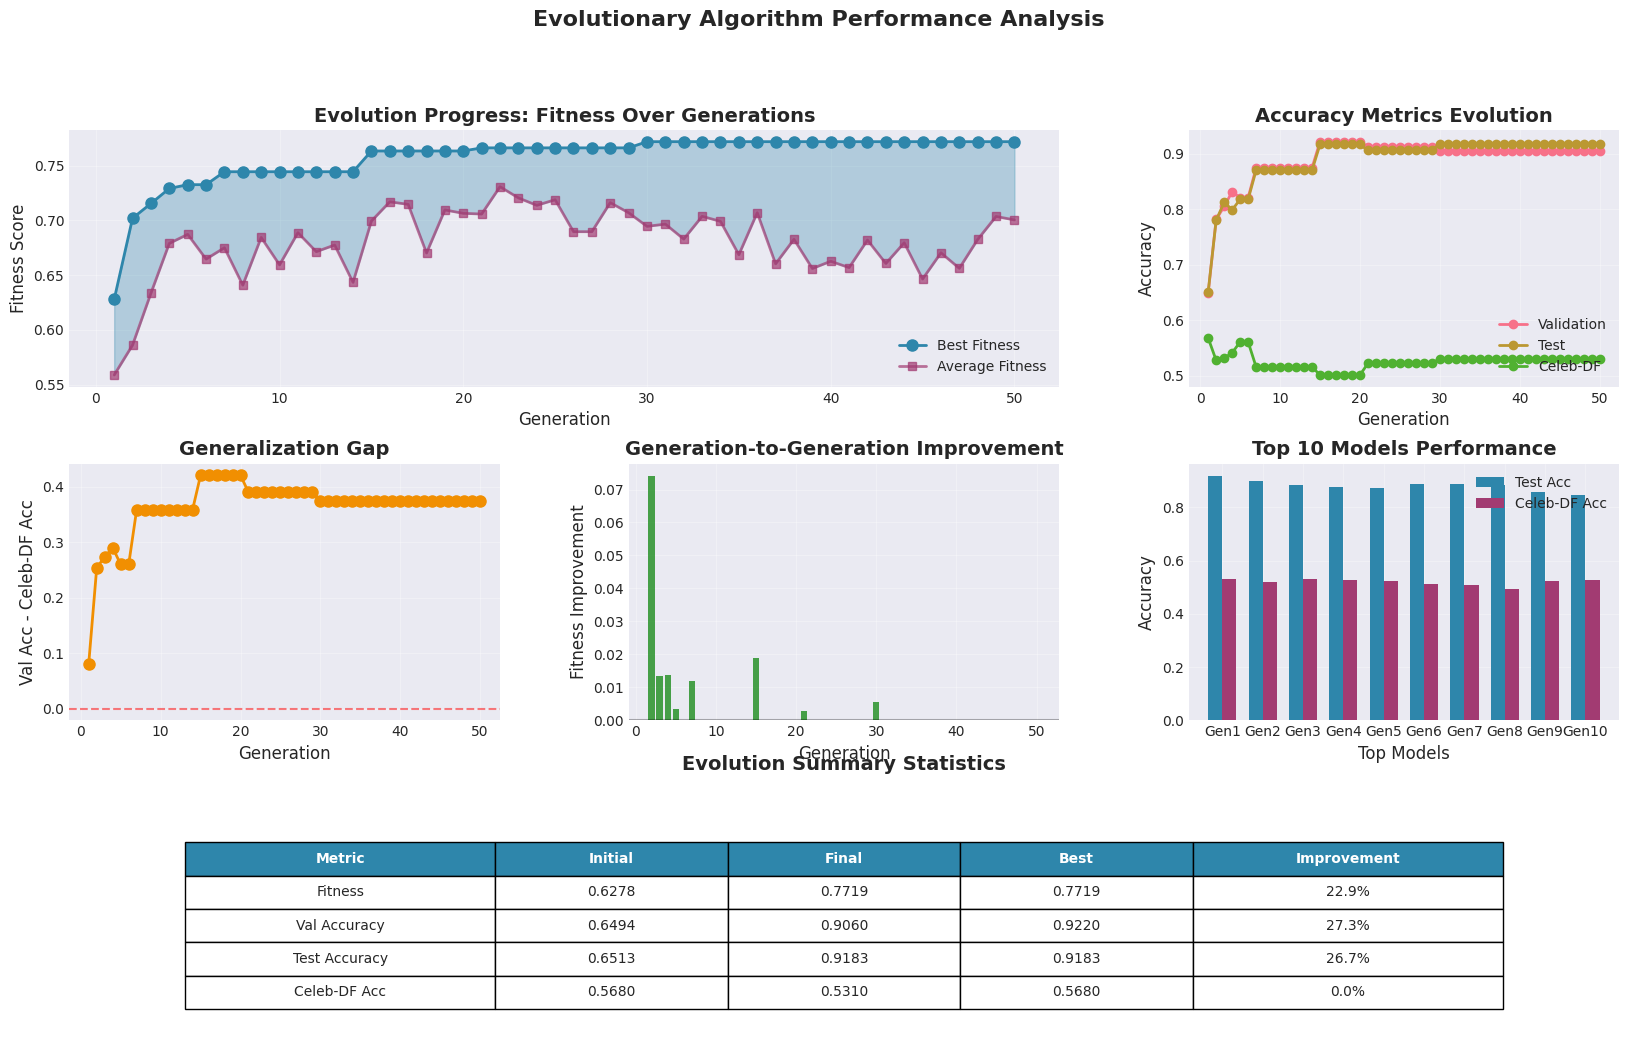


EVOLUTION SUMMARY
Total Generations Completed: 50
Best Fitness Achieved: 0.7719
Best Test Accuracy: 0.9183
Best Celeb-DF Accuracy: 0.5680

Best Generation: 30
  Fitness: 0.7719
  Val Acc: 0.9060
  Test Acc: 0.9183
  Celeb-DF: 0.5310

Last 5 Generation Improvement: 0.0000
Evolution appears to be converging (minimal improvement in last 5 generations)

ChatGPT 5 Contribution:
  Total API Calls: 12
  Architecture Suggestions Applied: ~6


In [ ]:
# ====== EVOLUTION VISUALIZATION AND ANALYSIS ======
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import os
from matplotlib.gridspec import GridSpec

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load evolution progress
progress_file = os.path.join(LOCAL_DATA_DIR, 'evolution_progress.pkl')
if os.path.exists(progress_file):
    with open(progress_file, 'rb') as f:
        evolution_progress = pickle.load(f)
else:
    # Try loading from checkpoint if available
    checkpoint_file = os.path.join(LOCAL_DATA_DIR, 'evolution_checkpoint.pkl')
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            checkpoint_data = pickle.load(f)
            evolution_progress = checkpoint_data.get('evolution_progress', {})
    else:
        print("No evolution data found. Run the evolution first!")
        evolution_progress = None

if evolution_progress and len(evolution_progress.get('generation', [])) > 0:
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

    # 1. Fitness Evolution
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(evolution_progress['generation'], evolution_progress['best_fitness'],
             'o-', linewidth=2, markersize=8, label='Best Fitness', color='#2E86AB')
    ax1.plot(evolution_progress['generation'], evolution_progress['avg_fitness'],
             's-', linewidth=2, markersize=6, label='Average Fitness', alpha=0.7, color='#A23B72')
    ax1.fill_between(evolution_progress['generation'],
                      evolution_progress['avg_fitness'],
                      evolution_progress['best_fitness'],
                      alpha=0.3, color='#2E86AB')
    ax1.set_xlabel('Generation', fontsize=12)
    ax1.set_ylabel('Fitness Score', fontsize=12)
    ax1.set_title('Evolution Progress: Fitness Over Generations', fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)

    # 2. Accuracy Metrics Evolution
    ax2 = fig.add_subplot(gs[0, 2])
    generations = evolution_progress['generation']
    metrics_data = {
        'Validation': evolution_progress['best_val_acc'],
        'Test': evolution_progress['best_test_acc'],
        'Celeb-DF': evolution_progress['best_celeb_df_acc']
    }

    for label, data in metrics_data.items():
        ax2.plot(generations, data, 'o-', linewidth=2, markersize=6, label=label)

    ax2.set_xlabel('Generation', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Accuracy Metrics Evolution', fontsize=14, fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)

    # 3. Generalization Gap
    ax3 = fig.add_subplot(gs[1, 0])
    generalization_gap = [val - celeb for val, celeb in
                          zip(evolution_progress['best_val_acc'],
                              evolution_progress['best_celeb_df_acc'])]
    ax3.plot(generations, generalization_gap, 'o-', linewidth=2,
             markersize=8, color='#F18F01')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Generation', fontsize=12)
    ax3.set_ylabel('Val Acc - Celeb-DF Acc', fontsize=12)
    ax3.set_title('Generalization Gap', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # 4. Improvement Rate
    ax4 = fig.add_subplot(gs[1, 1])
    if len(evolution_progress['best_fitness']) > 1:
        improvement = np.diff(evolution_progress['best_fitness'])
        ax4.bar(evolution_progress['generation'][1:], improvement,
               color=['green' if x > 0 else 'red' for x in improvement],
               alpha=0.7)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax4.set_xlabel('Generation', fontsize=12)
        ax4.set_ylabel('Fitness Improvement', fontsize=12)
        ax4.set_title('Generation-to-Generation Improvement', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)

    # 5. Best Models Comparison
    ax5 = fig.add_subplot(gs[1, 2])
    if 'evo_optimizer' in globals() and hasattr(evo_optimizer, 'all_individuals'):
        # Get top 10 individuals
        top_individuals = sorted(evo_optimizer.all_individuals,
                               key=lambda x: x.fitness, reverse=True)[:10]

        if top_individuals:
            labels = [f"Gen{i+1}" for i in range(len(top_individuals))]
            test_accs = [ind.metrics.get('test_accuracy', 0) for ind in top_individuals]
            celeb_accs = [ind.metrics.get('celeb_df_accuracy', 0) for ind in top_individuals]

            x = np.arange(len(labels))
            width = 0.35

            ax5.bar(x - width/2, test_accs, width, label='Test Acc', color='#2E86AB')
            ax5.bar(x + width/2, celeb_accs, width, label='Celeb-DF Acc', color='#A23B72')

            ax5.set_xlabel('Top Models', fontsize=12)
            ax5.set_ylabel('Accuracy', fontsize=12)
            ax5.set_title('Top 10 Models Performance', fontsize=14, fontweight='bold')
            ax5.set_xticks(x)
            ax5.set_xticklabels(labels)
            ax5.legend()
            ax5.grid(True, alpha=0.3)

    # 6. Evolution Statistics Table
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('tight')
    ax6.axis('off')

    # Calculate statistics
    stats_data = []
    if evolution_progress['best_fitness']:
        initial_fitness = evolution_progress['best_fitness'][0]
        final_fitness = evolution_progress['best_fitness'][-1]
        improvement_pct = ((final_fitness - initial_fitness) / initial_fitness) * 100

        stats_data = [
            ['Metric', 'Initial', 'Final', 'Best', 'Improvement'],
            ['Fitness', f"{initial_fitness:.4f}", f"{final_fitness:.4f}",
             f"{max(evolution_progress['best_fitness']):.4f}", f"{improvement_pct:.1f}%"],
            ['Val Accuracy', f"{evolution_progress['best_val_acc'][0]:.4f}",
             f"{evolution_progress['best_val_acc'][-1]:.4f}",
             f"{max(evolution_progress['best_val_acc']):.4f}",
             f"{(max(evolution_progress['best_val_acc']) - evolution_progress['best_val_acc'][0])*100:.1f}%"],
            ['Test Accuracy', f"{evolution_progress['best_test_acc'][0]:.4f}",
             f"{evolution_progress['best_test_acc'][-1]:.4f}",
             f"{max(evolution_progress['best_test_acc']):.4f}",
             f"{(max(evolution_progress['best_test_acc']) - evolution_progress['best_test_acc'][0])*100:.1f}%"],
            ['Celeb-DF Acc', f"{evolution_progress['best_celeb_df_acc'][0]:.4f}",
             f"{evolution_progress['best_celeb_df_acc'][-1]:.4f}",
             f"{max(evolution_progress['best_celeb_df_acc']):.4f}",
             f"{(max(evolution_progress['best_celeb_df_acc']) - evolution_progress['best_celeb_df_acc'][0])*100:.1f}%"]
        ]

        table = ax6.table(cellText=stats_data[1:], colLabels=stats_data[0],
                         cellLoc='center', loc='center',
                         colWidths=[0.2, 0.15, 0.15, 0.15, 0.2])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)

        # Color the header
        for i in range(len(stats_data[0])):
            table[(0, i)].set_facecolor('#2E86AB')
            table[(0, i)].set_text_props(weight='bold', color='white')

    ax6.set_title('Evolution Summary Statistics', fontsize=14, fontweight='bold', pad=20)

    # Main title
    fig.suptitle('Evolutionary Algorithm Performance Analysis',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(LOCAL_DATA_DIR, 'evolution_analysis.png'),
                dpi=300, bbox_inches='tight')

    # Upload to GCS
    try:
        from google.cloud import storage
        client = storage.Client()
        bucket = client.bucket(GCS_BUCKET)
        blob = bucket.blob('evolution_reports/evolution_analysis.png')
        blob.upload_from_filename(os.path.join(LOCAL_DATA_DIR, 'evolution_analysis.png'))
        print(f"Visualization saved to GCS: evolution_reports/evolution_analysis.png")
    except:
        print("Could not upload to GCS, but saved locally")

    plt.show()

    # Print summary
    print("\n" + "="*80)
    print("EVOLUTION SUMMARY")
    print("="*80)
    print(f"Total Generations Completed: {len(evolution_progress['generation'])}")
    print(f"Best Fitness Achieved: {max(evolution_progress['best_fitness']):.4f}")
    print(f"Best Test Accuracy: {max(evolution_progress['best_test_acc']):.4f}")
    print(f"Best Celeb-DF Accuracy: {max(evolution_progress['best_celeb_df_acc']):.4f}")

    # Find the generation with best fitness
    best_gen_idx = np.argmax(evolution_progress['best_fitness'])
    print(f"\nBest Generation: {evolution_progress['generation'][best_gen_idx]}")
    print(f"  Fitness: {evolution_progress['best_fitness'][best_gen_idx]:.4f}")
    print(f"  Val Acc: {evolution_progress['best_val_acc'][best_gen_idx]:.4f}")
    print(f"  Test Acc: {evolution_progress['best_test_acc'][best_gen_idx]:.4f}")
    print(f"  Celeb-DF: {evolution_progress['best_celeb_df_acc'][best_gen_idx]:.4f}")

    # Calculate convergence metrics
    if len(evolution_progress['best_fitness']) > 5:
        last_5_improvement = evolution_progress['best_fitness'][-1] - evolution_progress['best_fitness'][-5]
        print(f"\nLast 5 Generation Improvement: {last_5_improvement:.4f}")
        if abs(last_5_improvement) < 0.01:
            print("Evolution appears to be converging (minimal improvement in last 5 generations)")

    # ChatGPT usage if available
    if 'chatgpt_advisor' in globals():
        api_stats = chatgpt_advisor.get_usage_stats()
        print(f"\nChatGPT 5 Contribution:")
        print(f"  Total API Calls: {api_stats['total_api_calls']}")
        print(f"  Architecture Suggestions Applied: ~{api_stats['total_api_calls'] // 2}")

    print("="*80)

else:
    print("No evolution data available yet. Please run the evolution algorithm first.")

**7. a) Architecture Analysis of the best found model**

In [ ]:
# ====== MODEL ARCHITECTURE ANALYZER ======
# This cell loads a .h5 model file and displays its complete architecture

import os
import tensorflow as tf
from google.cloud import storage
import numpy as np
from datetime import datetime
import json

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("="*80)
print("MODEL ARCHITECTURE ANALYZER")
print("="*80)

# Get model input
MODEL_PATH = input("Enter the model path or filename (e.g., 'model_20250916_054645_7376.h5'): ").strip()

# Configuration
GCS_BUCKET = "???"
TEMP_DIR = "/tmp/model_analysis"
os.makedirs(TEMP_DIR, exist_ok=True)

print(f"\nModel to analyze: {MODEL_PATH}")

# Initialize GCS client
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

# ====== LOAD MODEL ======
print("\n" + "-"*60)
print("Loading model...")

local_model_path = None

# Check if it's a local file
if os.path.exists(MODEL_PATH):
    local_model_path = MODEL_PATH
    print(f"Found local model: {local_model_path}")
else:
    # Search in GCS
    possible_paths = [
        MODEL_PATH,
        f"evolution_models/{MODEL_PATH}",
        f"evolved_models/{MODEL_PATH}",
        f"evolved_models/final_selected/{MODEL_PATH}",
        f"final_trained_models/{MODEL_PATH}",
        f"deepfake_models_fast/{MODEL_PATH}",
        f"deepfake_models_stable/{MODEL_PATH}"
    ]

    # Search generation folders
    for gen in range(50):
        possible_paths.append(f"evolution_models/generation_{gen}/{MODEL_PATH}")

    found_in_gcs = False
    for gcs_path in possible_paths:
        blob = bucket.blob(gcs_path)
        if blob.exists():
            print(f"Found model in GCS: {gcs_path}")
            local_model_path = os.path.join(TEMP_DIR, f"model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5")
            blob.download_to_filename(local_model_path)
            found_in_gcs = True
            break

    if not found_in_gcs:
        raise FileNotFoundError(f"Model {MODEL_PATH} not found")

# Load the model
print(f"Loading from: {local_model_path}")
model = tf.keras.models.load_model(local_model_path)
print("Model loaded successfully!")

# ====== BASIC INFORMATION ======
print("\n" + "="*80)
print("BASIC MODEL INFORMATION")
print("="*80)

print(f"Total layers: {len(model.layers)}")
print(f"Total parameters: {model.count_params():,}")

trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")

# Calculate model size
model_size_mb = os.path.getsize(local_model_path) / (1024 * 1024)
print(f"Model file size: {model_size_mb:.2f} MB")

# Input/Output shapes
if hasattr(model, 'input_shape'):
    print(f"Input shape: {model.input_shape}")
if hasattr(model, 'output_shape'):
    print(f"Output shape: {model.output_shape}")

# ====== MODEL SUMMARY ======
print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)

model.summary()

# ====== DETAILED LAYER ANALYSIS ======
print("\n" + "="*80)
print("DETAILED LAYER ANALYSIS")
print("="*80)

# Analyze layer types
layer_types = {}
conv_layers = []
dense_layers = []
dropout_layers = []
pooling_layers = []
normalization_layers = []
activation_layers = []

for i, layer in enumerate(model.layers):
    layer_type = layer.__class__.__name__
    layer_types[layer_type] = layer_types.get(layer_type, 0) + 1

    # Categorize layers
    if 'Conv' in layer_type:
        conv_layers.append((i, layer))
    elif 'Dense' in layer_type:
        dense_layers.append((i, layer))
    elif 'Dropout' in layer_type:
        dropout_layers.append((i, layer))
    elif 'Pool' in layer_type:
        pooling_layers.append((i, layer))
    elif 'BatchNormalization' in layer_type or 'LayerNormalization' in layer_type:
        normalization_layers.append((i, layer))
    elif any(act in layer_type for act in ['ReLU', 'ELU', 'Activation', 'Softmax', 'Sigmoid']):
        activation_layers.append((i, layer))

print("\nLayer Type Distribution:")
for layer_type, count in sorted(layer_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  {layer_type}: {count}")

# ====== CONVOLUTIONAL LAYERS ======
if conv_layers:
    print("\n" + "-"*60)
    print(f"CONVOLUTIONAL LAYERS ({len(conv_layers)} total)")
    print("-"*60)
    for idx, layer in conv_layers[:10]:  # Show first 10
        config = layer.get_config()
        print(f"\nLayer {idx}: {layer.name}")
        print(f"  Type: {layer.__class__.__name__}")
        print(f"  Filters: {config.get('filters', 'N/A')}")
        print(f"  Kernel size: {config.get('kernel_size', 'N/A')}")
        print(f"  Strides: {config.get('strides', 'N/A')}")
        print(f"  Padding: {config.get('padding', 'N/A')}")
        print(f"  Activation: {config.get('activation', 'N/A')}")
        print(f"  Parameters: {layer.count_params():,}")

    if len(conv_layers) > 10:
        print(f"\n... and {len(conv_layers) - 10} more convolutional layers")

# ====== DENSE LAYERS ======
if dense_layers:
    print("\n" + "-"*60)
    print(f"DENSE LAYERS ({len(dense_layers)} total)")
    print("-"*60)
    for idx, layer in dense_layers:
        config = layer.get_config()
        print(f"\nLayer {idx}: {layer.name}")
        print(f"  Units: {config.get('units', 'N/A')}")
        print(f"  Activation: {config.get('activation', 'N/A')}")
        print(f"  Parameters: {layer.count_params():,}")

# ====== REGULARIZATION ======
if dropout_layers or normalization_layers:
    print("\n" + "-"*60)
    print("REGULARIZATION LAYERS")
    print("-"*60)

    if dropout_layers:
        print("\nDropout Layers:")
        for idx, layer in dropout_layers:
            print(f"  Layer {idx}: {layer.name}, Rate: {layer.rate}")

    if normalization_layers:
        print("\nNormalization Layers:")
        for idx, layer in normalization_layers:
            print(f"  Layer {idx}: {layer.name}, Type: {layer.__class__.__name__}")

# ====== ARCHITECTURE EXTRACTION ======
print("\n" + "="*80)
print("EXTRACTED ARCHITECTURE CONFIGURATION")
print("="*80)

def extract_architecture_config(model):
    """Extract a configuration dictionary from the model"""
    config = {
        'num_conv_blocks': 0,
        'conv_filters': [],
        'kernel_sizes': set(),
        'dense_units': [],
        'dropout_rates': [],
        'use_batch_norm': False,
        'use_separable_conv': False,
        'activations': set(),
        'pooling_types': set(),
        'total_layers': len(model.layers),
        'total_params': model.count_params()
    }

    for layer in model.layers:
        layer_type = layer.__class__.__name__
        layer_config = layer.get_config()

        if 'Conv2D' in layer_type:
            config['num_conv_blocks'] += 1
            config['conv_filters'].append(layer_config.get('filters'))
            config['kernel_sizes'].add(layer_config.get('kernel_size'))
        elif 'SeparableConv2D' in layer_type:
            config['use_separable_conv'] = True
            config['num_conv_blocks'] += 1
            config['conv_filters'].append(layer_config.get('filters'))
        elif 'Dense' in layer_type and layer_config.get('units', 0) > 1:
            config['dense_units'].append(layer_config.get('units'))
        elif 'Dropout' in layer_type:
            config['dropout_rates'].append(layer.rate)
        elif 'BatchNormalization' in layer_type:
            config['use_batch_norm'] = True
        elif 'Pool' in layer_type:
            config['pooling_types'].add(layer_type)

        # Extract activation
        if 'activation' in layer_config and layer_config['activation'] != 'linear':
            config['activations'].add(layer_config['activation'])

    # Convert sets to lists for JSON serialization
    config['kernel_sizes'] = list(config['kernel_sizes'])
    config['activations'] = list(config['activations'])
    config['pooling_types'] = list(config['pooling_types'])

    # Calculate average dropout if present
    if config['dropout_rates']:
        config['avg_dropout_rate'] = np.mean(config['dropout_rates'])

    return config

architecture_config = extract_architecture_config(model)

print("\nExtracted Configuration:")
print(f"  Conv blocks: {architecture_config['num_conv_blocks']}")
print(f"  Conv filter progression: {architecture_config['conv_filters']}")
print(f"  Kernel sizes used: {architecture_config['kernel_sizes']}")
print(f"  Dense layer units: {architecture_config['dense_units']}")
print(f"  Dropout rates: {architecture_config['dropout_rates']}")
print(f"  Average dropout: {architecture_config.get('avg_dropout_rate', 0):.3f}")
print(f"  Uses batch norm: {architecture_config['use_batch_norm']}")
print(f"  Uses separable conv: {architecture_config['use_separable_conv']}")
print(f"  Activations: {architecture_config['activations']}")
print(f"  Pooling types: {architecture_config['pooling_types']}")

# ====== OPTIMIZER AND LOSS ======
print("\n" + "-"*60)
print("TRAINING CONFIGURATION (if available)")
print("-"*60)

if hasattr(model, 'optimizer') and model.optimizer:
    opt = model.optimizer
    print(f"\nOptimizer: {opt.__class__.__name__}")
    if hasattr(opt, 'learning_rate'):
        try:
            lr = float(opt.learning_rate.numpy())
            print(f"  Learning rate: {lr}")
        except:
            print(f"  Learning rate: {opt.learning_rate}")
    if hasattr(opt, 'momentum'):
        print(f"  Momentum: {opt.momentum}")
    if hasattr(opt, 'beta_1') and hasattr(opt, 'beta_2'):
        print(f"  Beta_1: {opt.beta_1}, Beta_2: {opt.beta_2}")
else:
    print("  Optimizer information not available")

if hasattr(model, 'loss'):
    if hasattr(model.loss, '__name__'):
        print(f"\nLoss function: {model.loss.__name__}")
    elif hasattr(model.loss, '__class__'):
        print(f"\nLoss function: {model.loss.__class__.__name__}")
    else:
        print(f"\nLoss function: {model.loss}")
else:
    print("  Loss function information not available")

if hasattr(model, 'metrics'):
    print(f"\nMetrics: {[m.name if hasattr(m, 'name') else str(m) for m in model.metrics]}")

# ====== COMPUTATIONAL COMPLEXITY ======
print("\n" + "="*80)
print("COMPUTATIONAL COMPLEXITY ANALYSIS")
print("="*80)

def estimate_flops(model):
    """Rough estimation of FLOPs for the model"""
    total_flops = 0

    for layer in model.layers:
        if 'Conv' in layer.__class__.__name__:
            # Conv FLOPs: 2 * kernel_h * kernel_w * in_channels * out_channels * out_h * out_w
            if hasattr(layer, 'kernel_size'):
                kernel_size = layer.kernel_size[0] * layer.kernel_size[1] if isinstance(layer.kernel_size, tuple) else layer.kernel_size ** 2
                if layer.input_shape and layer.output_shape:
                    in_channels = layer.input_shape[-1] if len(layer.input_shape) > 3 else 1
                    out_channels = layer.output_shape[-1] if len(layer.output_shape) > 3 else 1
                    out_h = layer.output_shape[1] if len(layer.output_shape) > 3 else 1
                    out_w = layer.output_shape[2] if len(layer.output_shape) > 3 else 1
                    layer_flops = 2 * kernel_size * in_channels * out_channels * out_h * out_w
                    total_flops += layer_flops

        elif 'Dense' in layer.__class__.__name__:
            # Dense FLOPs: 2 * input_size * output_size
            if layer.input_shape and layer.output_shape:
                input_size = np.prod(layer.input_shape[1:])
                output_size = np.prod(layer.output_shape[1:])
                layer_flops = 2 * input_size * output_size
                total_flops += layer_flops

    return total_flops

estimated_flops = estimate_flops(model)
print(f"Estimated FLOPs: {estimated_flops:,}")
print(f"Estimated GFLOPs: {estimated_flops / 1e9:.2f}")

# Memory footprint
param_memory_mb = (model.count_params() * 4) / (1024 * 1024)  # 4 bytes per float32
print(f"\nParameter memory: {param_memory_mb:.2f} MB (float32)")

# ====== SAVE ARCHITECTURE REPORT ======
print("\n" + "-"*60)
print("Saving architecture report...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report = {
    'model_path': MODEL_PATH,
    'timestamp': timestamp,
    'basic_info': {
        'total_layers': len(model.layers),
        'total_parameters': int(model.count_params()),
        'trainable_parameters': int(trainable_params),
        'non_trainable_parameters': int(non_trainable_params),
        'model_size_mb': float(model_size_mb),
        'estimated_gflops': float(estimated_flops / 1e9)
    },
    'layer_distribution': layer_types,
    'architecture_config': architecture_config,
    'layer_details': []
}

# Add detailed layer information
for i, layer in enumerate(model.layers):
    layer_info = {
        'index': i,
        'name': layer.name,
        'type': layer.__class__.__name__,
        'parameters': int(layer.count_params()),
        'config': layer.get_config()
    }
    report['layer_details'].append(layer_info)

# Save locally
report_path = os.path.join(TEMP_DIR, f'architecture_report_{timestamp}.json')
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"Architecture report saved to: {report_path}")

# Try to upload to GCS
try:
    gcs_report_path = f'architecture_reports/report_{os.path.basename(MODEL_PATH)}_{timestamp}.json'
    blob = bucket.blob(gcs_report_path)
    blob.upload_from_filename(report_path)
    print(f"Report uploaded to GCS: {gcs_report_path}")
except Exception as e:
    print(f"Could not upload to GCS: {e}")

# ====== CREATE ARCHITECTURE VISUALIZATION ======
print("\n" + "-"*60)
print("Creating architecture visualization...")

try:
    # Try to create a visual representation
    tf.keras.utils.plot_model(
        model,
        to_file=os.path.join(TEMP_DIR, f'architecture_{timestamp}.png'),
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',  # Top to Bottom
        expand_nested=True,
        dpi=96
    )
    print(f"Architecture diagram saved to: {os.path.join(TEMP_DIR, f'architecture_{timestamp}.png')}")

    # Upload diagram to GCS
    gcs_diagram_path = f'architecture_reports/diagram_{os.path.basename(MODEL_PATH)}_{timestamp}.png'
    blob = bucket.blob(gcs_diagram_path)
    blob.upload_from_filename(os.path.join(TEMP_DIR, f'architecture_{timestamp}.png'))
    print(f"Diagram uploaded to GCS: {gcs_diagram_path}")
except Exception as e:
    print(f"Could not create architecture diagram: {e}")

# ====== SUMMARY ======
print("\n" + "="*80)
print("ARCHITECTURE ANALYSIS COMPLETE!")
print("="*80)
print(f"\nModel: {MODEL_PATH}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Architecture Type: {'CNN' if conv_layers else 'Dense Network'}")
print(f"Depth: {len(model.layers)} layers")

if conv_layers:
    print(f"Conv Blocks: {architecture_config['num_conv_blocks']}")
    print(f"Filter Range: {min(architecture_config['conv_filters'])} → {max(architecture_config['conv_filters'])}")

if dense_layers:
    print(f"Dense Layers: {len(dense_layers)}")
    if architecture_config['dense_units']:
        print(f"Dense Units: {architecture_config['dense_units']}")

print("\n✓ Architecture analysis complete!")
print(f"✓ Report saved: {report_path}")
print("="*80)

# Cleanup
del model
tf.keras.backend.clear_session()

MODEL ARCHITECTURE ANALYZER


Enter the model path or filename (e.g., 'model_20250916_054645_7376.h5'):  evolution_models/generation_11/model_20250916_054645_7376.h5



Model to analyze: evolution_models/generation_11/model_20250916_054645_7376.h5

------------------------------------------------------------
Loading model...
Found model in GCS: evolution_models/generation_11/model_20250916_054645_7376.h5
Loading from: /tmp/model_analysis/model_20250924_074827.h5
Model loaded successfully!

BASIC MODEL INFORMATION
Total layers: 29
Total parameters: 27,393
Trainable parameters: 26,721
Non-trainable parameters: 672
Model file size: 0.44 MB
Input shape: (None, 112, 112, 3)
Output shape: (None, 1)

MODEL SUMMARY
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 112

TypeError: Object of type ndarray is not JSON serializable

**8. Retrain best individual on whole Wilddeepfake dataset**

<IPython.core.display.Javascript object>

STANDALONE FINAL TRAINING FROM SAVED MODEL
WITH CELEB-DF V2 CROSS-DATASET VALIDATION
Configuration:
  GCS Bucket: new-dissertation-folder
  Model to load: evolution_models/generation_11/model_20250916_054645_7376.h5
  Individual ID: 20250916_054645_7376
  WildDeepfake data directory: /tmp/wilddeepfake_data
  Celeb-DF data directory: /tmp/celeb_df_data

------------------------------------------------------------
Initializing GCS client...

------------------------------------------------------------
  Path: evolution_models/generation_11/model_20250916_054645_7376.h5
  Downloaded to: /tmp/wilddeepfake_data/saved_model_20250916_054645_7376.h5
Loading model...
  Model loaded successfully!
  Total parameters: 27,393

------------------------------------------------------------
Extracting architecture from saved model...

Extracted architecture:
  num_conv_blocks: 5
  filters: []
  kernel_sizes: 7
  dropout_rates: 0.5
  dense_units: 128
  learning_rates: 0.0012499999720603228
  batch_sizes

2025-10-24 06:07:46.112369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-10-24 06:07:49.290000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10379/10379 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.7221 - auc: 0.7910

2025-10-24 06:40:10.521417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.77856, saving model to /tmp/wilddeepfake_data/final_training_20250916_054645_7376/best_model.h5
10379/10379 [==============================] - 2105s 202ms/step - loss: 0.5237 - accuracy: 0.7221 - auc: 0.7910 - val_loss: 0.4815 - val_accuracy: 0.7786 - val_auc: 0.8705 - lr: 0.0012
Epoch 2/50
10379/10379 [==============================] - ETA: 0s - loss: 0.3944 - accuracy: 0.8189 - auc: 0.8943
Epoch 2: val_accuracy improved from 0.77856 to 0.83956, saving model to /tmp/wilddeepfake_data/final_training_20250916_054645_7376/best_model.h5
10379/10379 [==============================] - 2078s 200ms/step - loss: 0.3944 - accuracy: 0.8189 - auc: 0.8943 - val_loss: 0.3649 - val_accuracy: 0.8396 - val_auc: 0.9157 - lr: 0.0012
Epoch 3/50
10379/10379 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8473 - auc: 0.9204
Epoch 3: val_accuracy improved from 0.83956 to 0.87149, saving model to /tmp/wilddeepfake_data/final_training_2025

<IPython.core.display.Javascript object>


------------------------------------------------------------
Clearing memory before evaluation...

FINAL EVALUATION

Evaluating on WildDeepfake test set...
   2/5560 [..............................] - ETA: 5:42 - loss: 0.2526 - accuracy: 0.8906 - auc: 0.9679 

2025-10-24 23:05:30.240399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5560/5560 [==============================] - 370s 67ms/step - loss: 0.1870 - accuracy: 0.9247 - auc: 0.9805

WildDeepfake Test Results:
  Loss: 0.1870
  Accuracy: 0.9247
  AUC: 0.9805

------------------------------------------------------------
Loading Celeb-DF v2 test data for cross-dataset validation...
Loading 10000 Celeb-DF samples...
Loaded 10000 Celeb-DF test images
  Real: 5000, Fake: 5000

Evaluating on Celeb-DF v2 test set...


2025-10-24 23:11:47.313353: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1505280000 exceeds 10% of free system memory.
2025-10-24 23:11:49.290205: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1505280000 exceeds 10% of free system memory.


157/157 [==============================] - 4s 24ms/step

Celeb-DF v2 Test Results:
  Accuracy: 0.5183
  Precision: 0.5364
  Recall: 0.2700
  F1-Score: 0.3592
  AUC: 0.5037

Generalization Gap (WildDeepfake - Celeb-DF): 0.4064

------------------------------------------------------------
Saving final trained model...
Model saved locally: /tmp/wilddeepfake_data/final_training_20250916_054645_7376/final_model_20250916_054645_7376_20251024_231154.h5
Model uploaded to GCS: final_trained_models/model_20250916_054645_7376_20251024_231154.h5
Results uploaded to GCS: final_trained_models/results_20250916_054645_7376_20251024_231154.json

------------------------------------------------------------
Generating training plots...


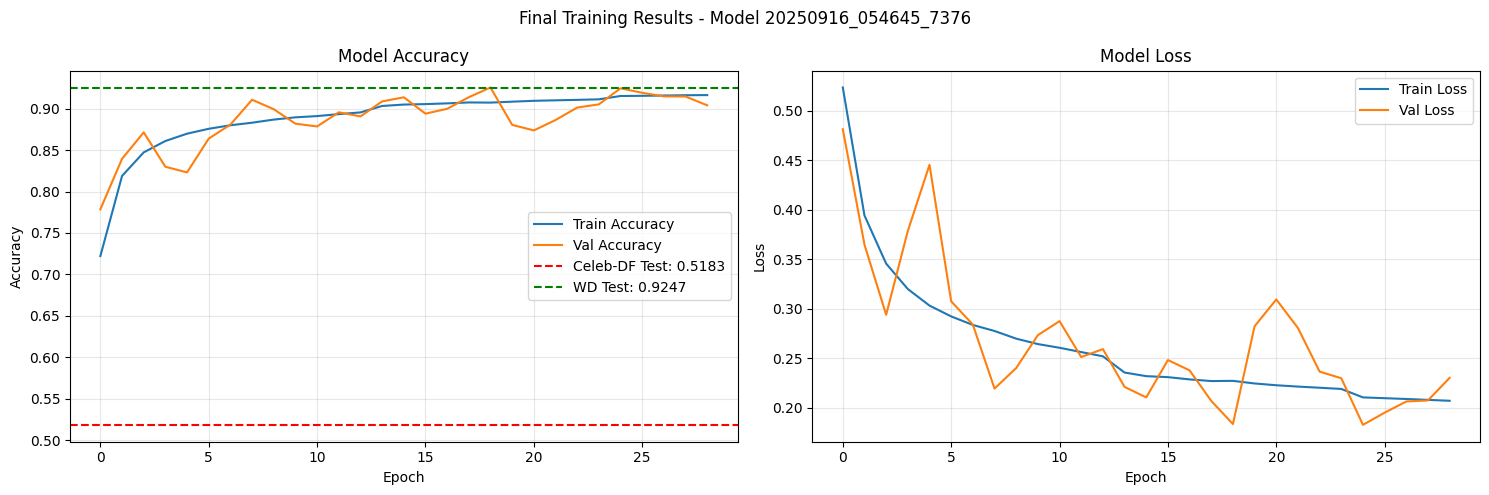


------------------------------------------------------------
Generating confusion matrix for Celeb-DF v2...


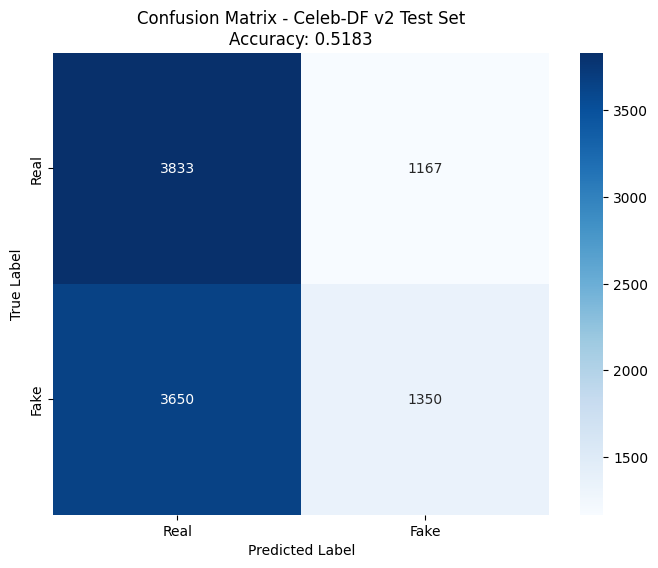


FINAL TRAINING COMPLETE!

Model ID: 20250916_054645_7376
Source: evolution_models/generation_11/model_20250916_054645_7376.h5
Training time: 1017.73 minutes
Epochs trained: 29

Best validation accuracy: 0.9257

WildDeepfake Performance:
  Test accuracy: 0.9247
  Test AUC: 0.9805

Celeb-DF v2 Performance (Cross-Dataset):
  Test accuracy: 0.5183
  Test AUC: 0.5037
  F1-Score: 0.3592

Generalization gap (WD - Celeb-DF): 0.4064

Model saved to GCS: final_trained_models/model_20250916_054645_7376_20251024_231154.h5
Results saved to GCS: final_trained_models/results_20250916_054645_7376_20251024_231154.json


In [ ]:
# ====== KEEP JUPYTER SESSION ALIVE ======
from IPython.display import display, Javascript
display(Javascript('''
    // Keep Jupyter session alive during long training
    var keepAliveInterval = setInterval(function() {
        var kernel = Jupyter.notebook.kernel;
        if (kernel) {
            kernel.execute("pass");  // Execute harmless command to keep session alive
        }
    }, 60000);  // Ping every 60 seconds

    // Store interval ID to clear it later if needed
    window.trainingKeepAlive = keepAliveInterval;

    console.log("Jupyter keep-alive started - pinging every 60 seconds");
'''))

# ====== STANDALONE FINAL TRAINING FROM SAVED MODEL ======
# This cell can run independently after kernel restart

import os
import json
import time
import random
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from google.cloud import storage
import pickle
import gc
import subprocess
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

print("="*80)
print("STANDALONE FINAL TRAINING FROM SAVED MODEL")
print("WITH CELEB-DF V2 CROSS-DATASET VALIDATION")
print("="*80)

# ====== CONFIGURATION ======
GCS_BUCKET = "???"
LOCAL_DATA_DIR = "/tmp/wilddeepfake_data"
CELEB_DF_DATA_DIR = "/tmp/celeb_df_data"
SAVED_MODEL_PATH = 'evolution_models/generation_11/model_20250916_054645_7376.h5' #to be exchanged with correct model path
INDIVIDUAL_ID = '20250916_054645_7376' #to be exchanged with correct individual ID

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)
os.makedirs(os.path.join(LOCAL_DATA_DIR, '02_processed_data'), exist_ok=True)
os.makedirs(os.path.join(LOCAL_DATA_DIR, '03_metadata'), exist_ok=True)
os.makedirs(os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits'), exist_ok=True)
os.makedirs(os.path.join(LOCAL_DATA_DIR, 'final_training'), exist_ok=True)
os.makedirs(CELEB_DF_DATA_DIR, exist_ok=True)

print(f"Configuration:")
print(f"  GCS Bucket: {GCS_BUCKET}")
print(f"  Model to load: {SAVED_MODEL_PATH}")
print(f"  Individual ID: {INDIVIDUAL_ID}")
print(f"  WildDeepfake data directory: {LOCAL_DATA_DIR}")
print(f"  Celeb-DF data directory: {CELEB_DF_DATA_DIR}")

# ====== INITIALIZE GCS CLIENT ======
print("\n" + "-"*60)
print("Initializing GCS client...")
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

# ====== DOWNLOAD AND LOAD SAVED MODEL ======
print("\n" + "-"*60)
print(f"Downloading saved model from GCS...")
print(f"  Path: {SAVED_MODEL_PATH}")

local_model_path = os.path.join(LOCAL_DATA_DIR, f'saved_model_{INDIVIDUAL_ID}.h5')
blob = bucket.blob(SAVED_MODEL_PATH)
if not blob.exists():
    print(f"ERROR: Model not found at {SAVED_MODEL_PATH}")
    print("Available evolution model prefixes in GCS:")
    for prefix in ['evolution_models/generation_49/', 'evolution_models/']:
        blobs = bucket.list_blobs(prefix=prefix)
        count = 0
        for b in blobs:
            if b.name.endswith('.h5'):
                print(f"  - {b.name}")
                count += 1
                if count >= 10:
                    break
    raise FileNotFoundError(f"Model {SAVED_MODEL_PATH} not found in GCS")

blob.download_to_filename(local_model_path)
print(f"  Downloaded to: {local_model_path}")

print("Loading model...")
saved_model = tf.keras.models.load_model(local_model_path)
print(f"  Model loaded successfully!")
print(f"  Total parameters: {saved_model.count_params():,}")

# ====== EXTRACT ARCHITECTURE FROM SAVED MODEL ======
print("\n" + "-"*60)
print("Extracting architecture from saved model...")

def extract_model_genome(model):
    """Extract genome-like configuration from existing model"""
    genome = {
        'num_conv_blocks': 0,
        'filters': [],
        'kernel_sizes': 3,
        'dropout_rates': 0.25,
        'dense_units': 128,
        'learning_rates': 0.001,
        'batch_sizes': 64,
        'augmentation_strength': 0.2,
        'use_separable_conv': False,
        'use_batch_norm': False,
        'activation': 'relu',
        'optimizer': 'adam',
        'loss_function': 'binary_crossentropy',
    }

    filter_sizes = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            genome['num_conv_blocks'] += 1
            filter_sizes.append(layer.filters)
            genome['kernel_sizes'] = layer.kernel_size[0]
        elif isinstance(layer, tf.keras.layers.SeparableConv2D):
            genome['num_conv_blocks'] += 1
            filter_sizes.append(layer.filters)
            genome['use_separable_conv'] = True
        elif isinstance(layer, tf.keras.layers.BatchNormalization):
            genome['use_batch_norm'] = True
        elif isinstance(layer, tf.keras.layers.Dropout):
            if layer.rate > 0:
                genome['dropout_rates'] = float(layer.rate)
        elif isinstance(layer, tf.keras.layers.Dense) and layer.units > 1:
            genome['dense_units'] = layer.units
        elif hasattr(layer, 'activation') and hasattr(layer.activation, '__name__'):
            if layer.activation.__name__ in ['elu', 'swish']:
                genome['activation'] = layer.activation.__name__

    genome['filter_progression'] = filter_sizes or [32, 64, 128, 256]

    if hasattr(model.optimizer, 'learning_rate'):
        try:
            genome['learning_rates'] = float(model.optimizer.learning_rate.numpy())
        except:
            genome['learning_rates'] = 0.001

    if hasattr(model.optimizer, '__class__'):
        opt_name = model.optimizer.__class__.__name__.lower()
        if 'adam' in opt_name:
            genome['optimizer'] = 'adam'
        elif 'sgd' in opt_name:
            genome['optimizer'] = 'sgd'
        elif 'rmsprop' in opt_name:
            genome['optimizer'] = 'rmsprop'

    if hasattr(model.loss, '__name__'):
        if 'focal' in model.loss.__name__.lower():
            genome['loss_function'] = 'focal_loss'

    if genome['num_conv_blocks'] == 0:
        genome['num_conv_blocks'] = len(genome['filter_progression'])

    return genome

extracted_genome = extract_model_genome(saved_model)

print("\nExtracted architecture:")
for key, value in extracted_genome.items():
    if key != 'filter_progression':
        print(f"  {key}: {value}")
print(f"  filter_progression: {extracted_genome['filter_progression']}")

del saved_model
tf.keras.backend.clear_session()
gc.collect()

# ====== LOAD WILDDEEPFAKE DATASET METADATA ======
print("\n" + "-"*60)
print("Loading WildDeepfake dataset metadata...")

metadata_path = os.path.join(LOCAL_DATA_DIR, '03_metadata/dataset_metadata.pkl')
if not os.path.exists(metadata_path):
    print("Downloading metadata from GCS...")
    blob = bucket.blob('03_metadata/dataset_metadata.pkl')
    blob.download_to_filename(metadata_path)

with open(metadata_path, 'rb') as f:
    metadata = pickle.load(f)
print(f"WildDeepfake dataset: {metadata['total_samples']:,} samples")
print(f"Shape: {metadata['shape']}")

# ====== DOWNLOAD WILDDEEPFAKE MEMMAP FILES ======
print("\n" + "-"*60)
print("Checking WildDeepfake memmap files...")

memmap_files = [
    ('02_processed_data/X_memmap.dat', os.path.join(LOCAL_DATA_DIR, '02_processed_data/X_memmap.dat')),
    ('02_processed_data/y_memmap.dat', os.path.join(LOCAL_DATA_DIR, '02_processed_data/y_memmap.dat'))
]

for gcs_path, local_path in memmap_files:
    if not os.path.exists(local_path):
        blob = bucket.blob(gcs_path)
        if blob.exists():
            blob.reload()
            file_size_gb = blob.size / (1024**3) if blob.size else 0
            print(f"Downloading {os.path.basename(local_path)} ({file_size_gb:.2f} GB)...")

            if file_size_gb > 1:
                cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                result = subprocess.run(cmd, shell=True)
                if result.returncode == 0:
                    print(f"  Downloaded {os.path.basename(local_path)}")
                else:
                    raise Exception(f"Failed to download {gcs_path}")
            else:
                blob.download_to_filename(local_path)
                print(f"  Downloaded {os.path.basename(local_path)}")
    else:
        print(f"  {os.path.basename(local_path)} already cached locally")

print("\nLoading WildDeepfake memmap arrays...")
X = np.memmap(
    os.path.join(LOCAL_DATA_DIR, '02_processed_data/X_memmap.dat'),
    dtype=np.uint8,
    mode='r',
    shape=metadata['shape']
)
y = np.memmap(
    os.path.join(LOCAL_DATA_DIR, '02_processed_data/y_memmap.dat'),
    dtype=np.int8,
    mode='r',
    shape=(metadata['total_samples'],)
)
print(f"WildDeepfake arrays loaded: X shape {X.shape}, y shape {y.shape}")

# ====== LOAD WILDDEEPFAKE TRAIN/VAL/TEST SPLITS ======
print("\n" + "-"*60)
print("Loading WildDeepfake train/val/test splits...")

splits_dir = os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits')
split_files = ['train_indices.npy', 'val_indices.npy', 'test_indices.npy']

for fname in split_files:
    local_path = os.path.join(splits_dir, fname)
    if not os.path.exists(local_path):
        print(f"  Downloading {fname} from GCS...")
        for gcs_prefix in ['WildDeepfake_splits/', 'splits/', '']:
            try:
                blob = bucket.blob(f'{gcs_prefix}{fname}')
                if blob.exists():
                    blob.download_to_filename(local_path)
                    print(f"    Downloaded {fname}")
                    break
            except:
                continue

train_indices = np.load(os.path.join(splits_dir, 'train_indices.npy'))
val_indices = np.load(os.path.join(splits_dir, 'val_indices.npy'))
test_indices = np.load(os.path.join(splits_dir, 'test_indices.npy'))
print(f"WildDeepfake splits loaded: Train {len(train_indices):,}, Val {len(val_indices):,}, Test {len(test_indices):,}")

# ====== LOAD CELEB-DF V2 METADATA AND PATHS ======
print("\n" + "-"*60)
print("Loading Celeb-DF v2 metadata...")

celeb_df_metadata_path = os.path.join(CELEB_DF_DATA_DIR, 'metadata.pkl')
if not os.path.exists(celeb_df_metadata_path):
    print("Downloading Celeb-DF metadata from GCS...")
    blob = bucket.blob('celeb_df_v2/processed/metadata.pkl')
    blob.download_to_filename(celeb_df_metadata_path)

with open(celeb_df_metadata_path, 'rb') as f:
    celeb_df_metadata = pickle.load(f)

print(f"Celeb-DF v2 dataset: {celeb_df_metadata['total_samples']:,} samples")

celeb_df_memmap_files = [
    ('celeb_df_v2/processed/frames_memmap.dat', os.path.join(CELEB_DF_DATA_DIR, 'frames_memmap.dat')),
    ('celeb_df_v2/processed/labels_memmap.dat', os.path.join(CELEB_DF_DATA_DIR, 'labels_memmap.dat'))
]

for gcs_path, local_path in celeb_df_memmap_files:
    if not os.path.exists(local_path):
        blob = bucket.blob(gcs_path)
        if blob.exists():
            blob.reload()
            file_size_gb = blob.size / (1024**3) if blob.size else 0
            print(f"Downloading {os.path.basename(local_path)} ({file_size_gb:.2f} GB)...")

            if file_size_gb > 1:
                cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                subprocess.run(cmd, shell=True)
            else:
                blob.download_to_filename(local_path)
            print(f"  Downloaded {os.path.basename(local_path)}")
    else:
        print(f"  {os.path.basename(local_path)} already cached locally")

celeb_df_test_indices_path = os.path.join(CELEB_DF_DATA_DIR, 'test_indices.npy')
if not os.path.exists(celeb_df_test_indices_path):
    blob = bucket.blob('celeb_df_v2/processed/test_indices.npy')
    if blob.exists():
        blob.download_to_filename(celeb_df_test_indices_path)
    else:
        celeb_df_X_temp = np.memmap(
            os.path.join(CELEB_DF_DATA_DIR, 'frames_memmap.dat'),
            dtype=np.uint8, mode='r', shape=celeb_df_metadata['shape']
        )
        celeb_df_y_temp = np.memmap(
            os.path.join(CELEB_DF_DATA_DIR, 'labels_memmap.dat'),
            dtype=np.int8, mode='r', shape=(celeb_df_metadata['total_samples'],)
        )
        all_indices = np.arange(celeb_df_metadata['total_samples'])
        np.random.seed(42)
        np.random.shuffle(all_indices)
        test_size = int(0.1 * len(all_indices))
        celeb_df_test_indices = all_indices[:test_size]
        np.save(celeb_df_test_indices_path, celeb_df_test_indices)
        del celeb_df_X_temp, celeb_df_y_temp
        gc.collect()

print("Celeb-DF v2 setup complete (data will be loaded after training)")

# ====== CREATE DATA GENERATORS WITH MEMORY MANAGEMENT ======
print("\n" + "-"*60)
print("Creating memory-efficient data generators...")

class MemoryEfficientDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_mmap, y_mmap, indices, batch_size=32, augment=False, augment_strength=0.2):
        self.X_mmap = X_mmap
        self.y_mmap = y_mmap
        self.indices = indices.copy()
        self.batch_size = batch_size
        self.augment = augment
        np.random.shuffle(self.indices)

        if augment:
            self.augmentor = ImageDataGenerator(
                rotation_range=15 * augment_strength,
                width_shift_range=0.1 * augment_strength,
                height_shift_range=0.1 * augment_strength,
                shear_range=0.1 * augment_strength,
                zoom_range=0.1 * augment_strength,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]

        X_batch = self.X_mmap[batch_indices].astype(np.float32) / 255.0
        y_batch = self.y_mmap[batch_indices].astype(np.float32)

        if self.augment and hasattr(self, 'augmentor'):
            for i in range(len(X_batch)):
                if random.random() > 0.3:
                    X_batch[i] = self.augmentor.random_transform(X_batch[i])

        return X_batch, y_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)
        gc.collect()

selected_batch_size = extracted_genome.get('batch_sizes', 32)
selected_aug_strength = extracted_genome.get('augmentation_strength', 0.2)

print(f"Using batch size: {selected_batch_size}")
print(f"Using augmentation strength: {selected_aug_strength}")

full_train_gen = MemoryEfficientDataGenerator(
    X, y, train_indices,
    batch_size=selected_batch_size,
    augment=True,
    augment_strength=selected_aug_strength
)

full_val_gen = MemoryEfficientDataGenerator(
    X, y, val_indices,
    batch_size=selected_batch_size,
    augment=False
)

full_test_gen = MemoryEfficientDataGenerator(
    X, y, test_indices,
    batch_size=selected_batch_size,
    augment=False
)

print(f"\nWildDeepfake dataset sizes:")
print(f"  Train: {len(train_indices):,} samples ({len(full_train_gen)} batches)")
print(f"  Val: {len(val_indices):,} samples ({len(full_val_gen)} batches)")
print(f"  Test: {len(test_indices):,} samples ({len(full_test_gen)} batches)")

# ====== RECREATE MODEL WITH EXTRACTED ARCHITECTURE ======
print("\n" + "-"*60)
print("Creating model from extracted architecture...")

def create_model_from_genome(genome):
    """Create a CNN model based on the extracted genome"""
    inputs = tf.keras.layers.Input(shape=(112, 112, 3))
    x = inputs

    for i in range(genome['num_conv_blocks']):
        filters = genome['filter_progression'][i] if i < len(genome['filter_progression']) else 64

        if genome['use_separable_conv'] and i > 0:
            x = tf.keras.layers.SeparableConv2D(
                filters, genome['kernel_sizes'], padding='same'
            )(x)
        else:
            x = tf.keras.layers.Conv2D(
                filters, genome['kernel_sizes'], padding='same'
            )(x)

        if genome['use_batch_norm']:
            x = tf.keras.layers.BatchNormalization()(x)

        if genome['activation'] == 'relu':
            x = tf.keras.layers.ReLU()(x)
        elif genome['activation'] == 'elu':
            x = tf.keras.layers.ELU()(x)
        elif genome['activation'] == 'swish':
            x = tf.keras.layers.Activation('swish')(x)

        if i % 2 == 1:
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)

        if genome['dropout_rates'] > 0:
            x = tf.keras.layers.Dropout(genome['dropout_rates'])(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(genome['dense_units'])(x)
    if genome['use_batch_norm']:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    if genome['optimizer'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=genome['learning_rates'])
    elif genome['optimizer'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=genome['learning_rates'], momentum=0.9)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=genome['learning_rates'])

    if genome['loss_function'] == 'focal_loss':
        loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0)
    else:
        loss = 'binary_crossentropy'

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

tf.keras.backend.clear_session()
gc.collect()

final_model = create_model_from_genome(extracted_genome)
print(f"Model created with {final_model.count_params():,} parameters")

# ====== SETUP TRAINING CALLBACKS WITH MEMORY MANAGEMENT ======
print("\n" + "-"*60)
print("Setting up training callbacks with memory management...")

checkpoint_dir = os.path.join(LOCAL_DATA_DIR, f'final_training_{INDIVIDUAL_ID}')
os.makedirs(checkpoint_dir, exist_ok=True)

class MemoryManagementCallback(tf.keras.callbacks.Callback):
    def __init__(self, gc_frequency=5):
        super().__init__()
        self.gc_frequency = gc_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.gc_frequency == 0:
            print(f"\n[Memory Management] Clearing memory at epoch {epoch + 1}...")
            gc.collect()

class EpochLoggerCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_path):
        super().__init__()
        self.log_path = log_path
        self.log_data = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        log_entry = {'epoch': epoch + 1}
        for key, value in logs.items():
            if hasattr(value, 'numpy'):
                log_entry[key] = float(value.numpy())
            else:
                log_entry[key] = float(value)
        self.log_data.append(log_entry)

        with open(self.log_path, 'w') as f:
            json.dump(self.log_data, f, indent=2)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.h5'),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EpochLoggerCallback(os.path.join(checkpoint_dir, 'training_log.json')),
    MemoryManagementCallback(gc_frequency=5)
]

# ====== TRAIN MODEL ======
print("\n" + "="*60)
print("STARTING FINAL TRAINING")
print(f"Individual ID: {INDIVIDUAL_ID}")
print(f"Architecture extracted from: {SAVED_MODEL_PATH}")
print("Training on: WildDeepfake")
print("Cross-validation on: Celeb-DF v2")
print("="*60)

start_time = time.time()
FINAL_EPOCHS = 50

print(f"\nTraining for up to {FINAL_EPOCHS} epochs...")
print(f"Early stopping patience: 10 epochs")
print(f"Memory management: Enabled (GC every 5 epochs)")
print(f"Session keep-alive: Active (pinging every 60s)")

history = final_model.fit(
    full_train_gen,
    epochs=FINAL_EPOCHS,
    validation_data=full_val_gen,
    callbacks=callbacks,
    verbose=1,
    workers=0,
    use_multiprocessing=False
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")
print(f"Total epochs trained: {len(history.history['loss'])}")

# ====== STOP KEEP-ALIVE ======
display(Javascript('''
    if (window.trainingKeepAlive) {
        clearInterval(window.trainingKeepAlive);
        console.log("Jupyter keep-alive stopped");
    }
'''))

# ====== CLEAR MEMORY BEFORE EVALUATION ======
print("\n" + "-"*60)
print("Clearing memory before evaluation...")
del full_train_gen, full_val_gen
gc.collect()

# ====== EVALUATE ON TEST SETS ======
print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

print("\nEvaluating on WildDeepfake test set...")
wilddeepfake_test_results = final_model.evaluate(full_test_gen, verbose=1)

print("\nWildDeepfake Test Results:")
print(f"  Loss: {wilddeepfake_test_results[0]:.4f}")
print(f"  Accuracy: {wilddeepfake_test_results[1]:.4f}")
print(f"  AUC: {wilddeepfake_test_results[2]:.4f}")

del full_test_gen
gc.collect()

# ====== NOW LOAD CELEB-DF DATA FOR EVALUATION ======
print("\n" + "-"*60)
print("Loading Celeb-DF v2 test data for cross-dataset validation...")

celeb_df_X = np.memmap(
    os.path.join(CELEB_DF_DATA_DIR, 'frames_memmap.dat'),
    dtype=np.uint8,
    mode='r',
    shape=celeb_df_metadata['shape']
)
celeb_df_y = np.memmap(
    os.path.join(CELEB_DF_DATA_DIR, 'labels_memmap.dat'),
    dtype=np.int8,
    mode='r',
    shape=(celeb_df_metadata['total_samples'],)
)

celeb_df_test_indices = np.load(celeb_df_test_indices_path)

MAX_CELEB_DF_FULL = 10000

real_indices = celeb_df_test_indices[celeb_df_y[celeb_df_test_indices] == 0]
fake_indices = celeb_df_test_indices[celeb_df_y[celeb_df_test_indices] == 1]

np.random.seed(42)
selected_real = np.random.choice(real_indices, min(MAX_CELEB_DF_FULL//2, len(real_indices)), replace=False)
selected_fake = np.random.choice(fake_indices, min(MAX_CELEB_DF_FULL//2, len(fake_indices)), replace=False)

celeb_df_full_indices = np.concatenate([selected_real, selected_fake])
np.random.shuffle(celeb_df_full_indices)

print(f"Loading {len(celeb_df_full_indices)} Celeb-DF samples...")
celeb_df_X_full = celeb_df_X[celeb_df_full_indices].astype(np.float32) / 255.0
celeb_df_y_full = 1 - celeb_df_y[celeb_df_full_indices].astype(np.float32)

print(f"Loaded {len(celeb_df_X_full)} Celeb-DF test images")
print(f"  Real: {np.sum(celeb_df_y_full == 0)}, Fake: {np.sum(celeb_df_y_full == 1)}")

print("\nEvaluating on Celeb-DF v2 test set...")
celeb_df_predictions = final_model.predict(celeb_df_X_full, batch_size=64, verbose=1)
celeb_df_pred_classes = (celeb_df_predictions > 0.5).astype(int).flatten()
celeb_df_accuracy = np.mean(celeb_df_pred_classes == celeb_df_y_full)

celeb_df_precision = precision_score(celeb_df_y_full, celeb_df_pred_classes)
celeb_df_recall = recall_score(celeb_df_y_full, celeb_df_pred_classes)
celeb_df_f1 = f1_score(celeb_df_y_full, celeb_df_pred_classes)
celeb_df_auc = roc_auc_score(celeb_df_y_full, celeb_df_predictions.flatten())

print("\nCeleb-DF v2 Test Results:")
print(f"  Accuracy: {celeb_df_accuracy:.4f}")
print(f"  Precision: {celeb_df_precision:.4f}")
print(f"  Recall: {celeb_df_recall:.4f}")
print(f"  F1-Score: {celeb_df_f1:.4f}")
print(f"  AUC: {celeb_df_auc:.4f}")

generalization_gap = wilddeepfake_test_results[1] - celeb_df_accuracy
print(f"\nGeneralization Gap (WildDeepfake - Celeb-DF): {generalization_gap:.4f}")

# ====== SAVE FINAL MODEL ======
print("\n" + "-"*60)
print("Saving final trained model...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

local_model_path = os.path.join(checkpoint_dir, f'final_model_{INDIVIDUAL_ID}_{timestamp}.h5')
final_model.save(local_model_path)
print(f"Model saved locally: {local_model_path}")

gcs_model_path = f'final_trained_models/model_{INDIVIDUAL_ID}_{timestamp}.h5'
blob = bucket.blob(gcs_model_path)
blob.upload_from_filename(local_model_path)
print(f"Model uploaded to GCS: {gcs_model_path}")

final_results = {
    'individual_id': INDIVIDUAL_ID,
    'source_model_path': SAVED_MODEL_PATH,
    'extracted_genome': extracted_genome,
    'training_time_minutes': training_time / 60,
    'epochs_trained': len(history.history['loss']),
    'best_val_accuracy': max(history.history['val_accuracy']),
    'wilddeepfake_test': {
        'loss': float(wilddeepfake_test_results[0]),
        'accuracy': float(wilddeepfake_test_results[1]),
        'auc': float(wilddeepfake_test_results[2])
    },
    'celeb_df_test': {
        'accuracy': float(celeb_df_accuracy),
        'precision': float(celeb_df_precision),
        'recall': float(celeb_df_recall),
        'f1_score': float(celeb_df_f1),
        'auc': float(celeb_df_auc),
        'num_samples': len(celeb_df_y_full)
    },
    'generalization_gap': float(generalization_gap),
    'model_path': gcs_model_path,
    'timestamp': timestamp
}

results_path = os.path.join(checkpoint_dir, f'final_results_{timestamp}.json')
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

gcs_results_path = f'final_trained_models/results_{INDIVIDUAL_ID}_{timestamp}.json'
blob_results = bucket.blob(gcs_results_path)
blob_results.upload_from_filename(results_path)
print(f"Results uploaded to GCS: {gcs_results_path}")

# ====== PLOT TRAINING HISTORY ======
print("\n" + "-"*60)
print("Generating training plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].axhline(y=celeb_df_accuracy, color='r', linestyle='--', label=f'Celeb-DF Test: {celeb_df_accuracy:.4f}')
axes[0].axhline(y=wilddeepfake_test_results[1], color='g', linestyle='--', label=f'WD Test: {wilddeepfake_test_results[1]:.4f}')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Final Training Results - Model {INDIVIDUAL_ID}')
plt.tight_layout()

plot_path = os.path.join(checkpoint_dir, f'training_history_{timestamp}.png')
plt.savefig(plot_path, dpi=150)
plt.show()

gcs_plot_path = f'final_trained_models/plot_{INDIVIDUAL_ID}_{timestamp}.png'
blob_plot = bucket.blob(gcs_plot_path)
blob_plot.upload_from_filename(plot_path)

plt.close('all')
gc.collect()

# ====== CONFUSION MATRIX FOR CELEB-DF ======
print("\n" + "-"*60)
print("Generating confusion matrix for Celeb-DF v2...")

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(celeb_df_y_full, celeb_df_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title(f'Confusion Matrix - Celeb-DF v2 Test Set\nAccuracy: {celeb_df_accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

cm_path = os.path.join(checkpoint_dir, f'confusion_matrix_{timestamp}.png')
plt.savefig(cm_path, dpi=150)
plt.show()

gcs_cm_path = f'final_trained_models/confusion_matrix_{INDIVIDUAL_ID}_{timestamp}.png'
blob_cm = bucket.blob(gcs_cm_path)
blob_cm.upload_from_filename(cm_path)

plt.close('all')
gc.collect()

# ====== FINAL CLEANUP ======
del celeb_df_X, celeb_df_y, celeb_df_X_full, celeb_df_y_full
del celeb_df_predictions, celeb_df_pred_classes
gc.collect()

# ====== FINAL SUMMARY ======
print("\n" + "="*80)
print("FINAL TRAINING COMPLETE!")
print("="*80)
print(f"\nModel ID: {INDIVIDUAL_ID}")
print(f"Source: {SAVED_MODEL_PATH}")
print(f"Training time: {training_time/60:.2f} minutes")
print(f"Epochs trained: {len(history.history['loss'])}")
print(f"\nBest validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"\nWildDeepfake Performance:")
print(f"  Test accuracy: {wilddeepfake_test_results[1]:.4f}")
print(f"  Test AUC: {wilddeepfake_test_results[2]:.4f}")
print(f"\nCeleb-DF v2 Performance (Cross-Dataset):")
print(f"  Test accuracy: {celeb_df_accuracy:.4f}")
print(f"  Test AUC: {celeb_df_auc:.4f}")
print(f"  F1-Score: {celeb_df_f1:.4f}")
print(f"\nGeneralization gap (WD - Celeb-DF): {generalization_gap:.4f}")
print(f"\nModel saved to GCS: {gcs_model_path}")
print(f"Results saved to GCS: {gcs_results_path}")
print("="*80)

**9. Full Evaluation of finally chosen best model**

MODEL EVALUATION ON FULL TEST SETS


Enter the model path or filename (e.g., 'model_20250916_054645_7376.h5'):  evolution_models/generation_11/model_20250916_054645_7376.h5



Model to evaluate: evolution_models/generation_11/model_20250916_054645_7376.h5
GCS Bucket: new-dissertation-folder
Evaluation directory: /tmp/model_evaluation
Batch size for evaluation: 256

------------------------------------------------------------
Loading model...
Found model in GCS: evolution_models/generation_11/model_20250916_054645_7376.h5
Loading model from: /tmp/model_evaluation/model_to_eval_20250924_072346.h5
Model loaded successfully!
Total parameters: 27,393

Model Architecture Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization) 

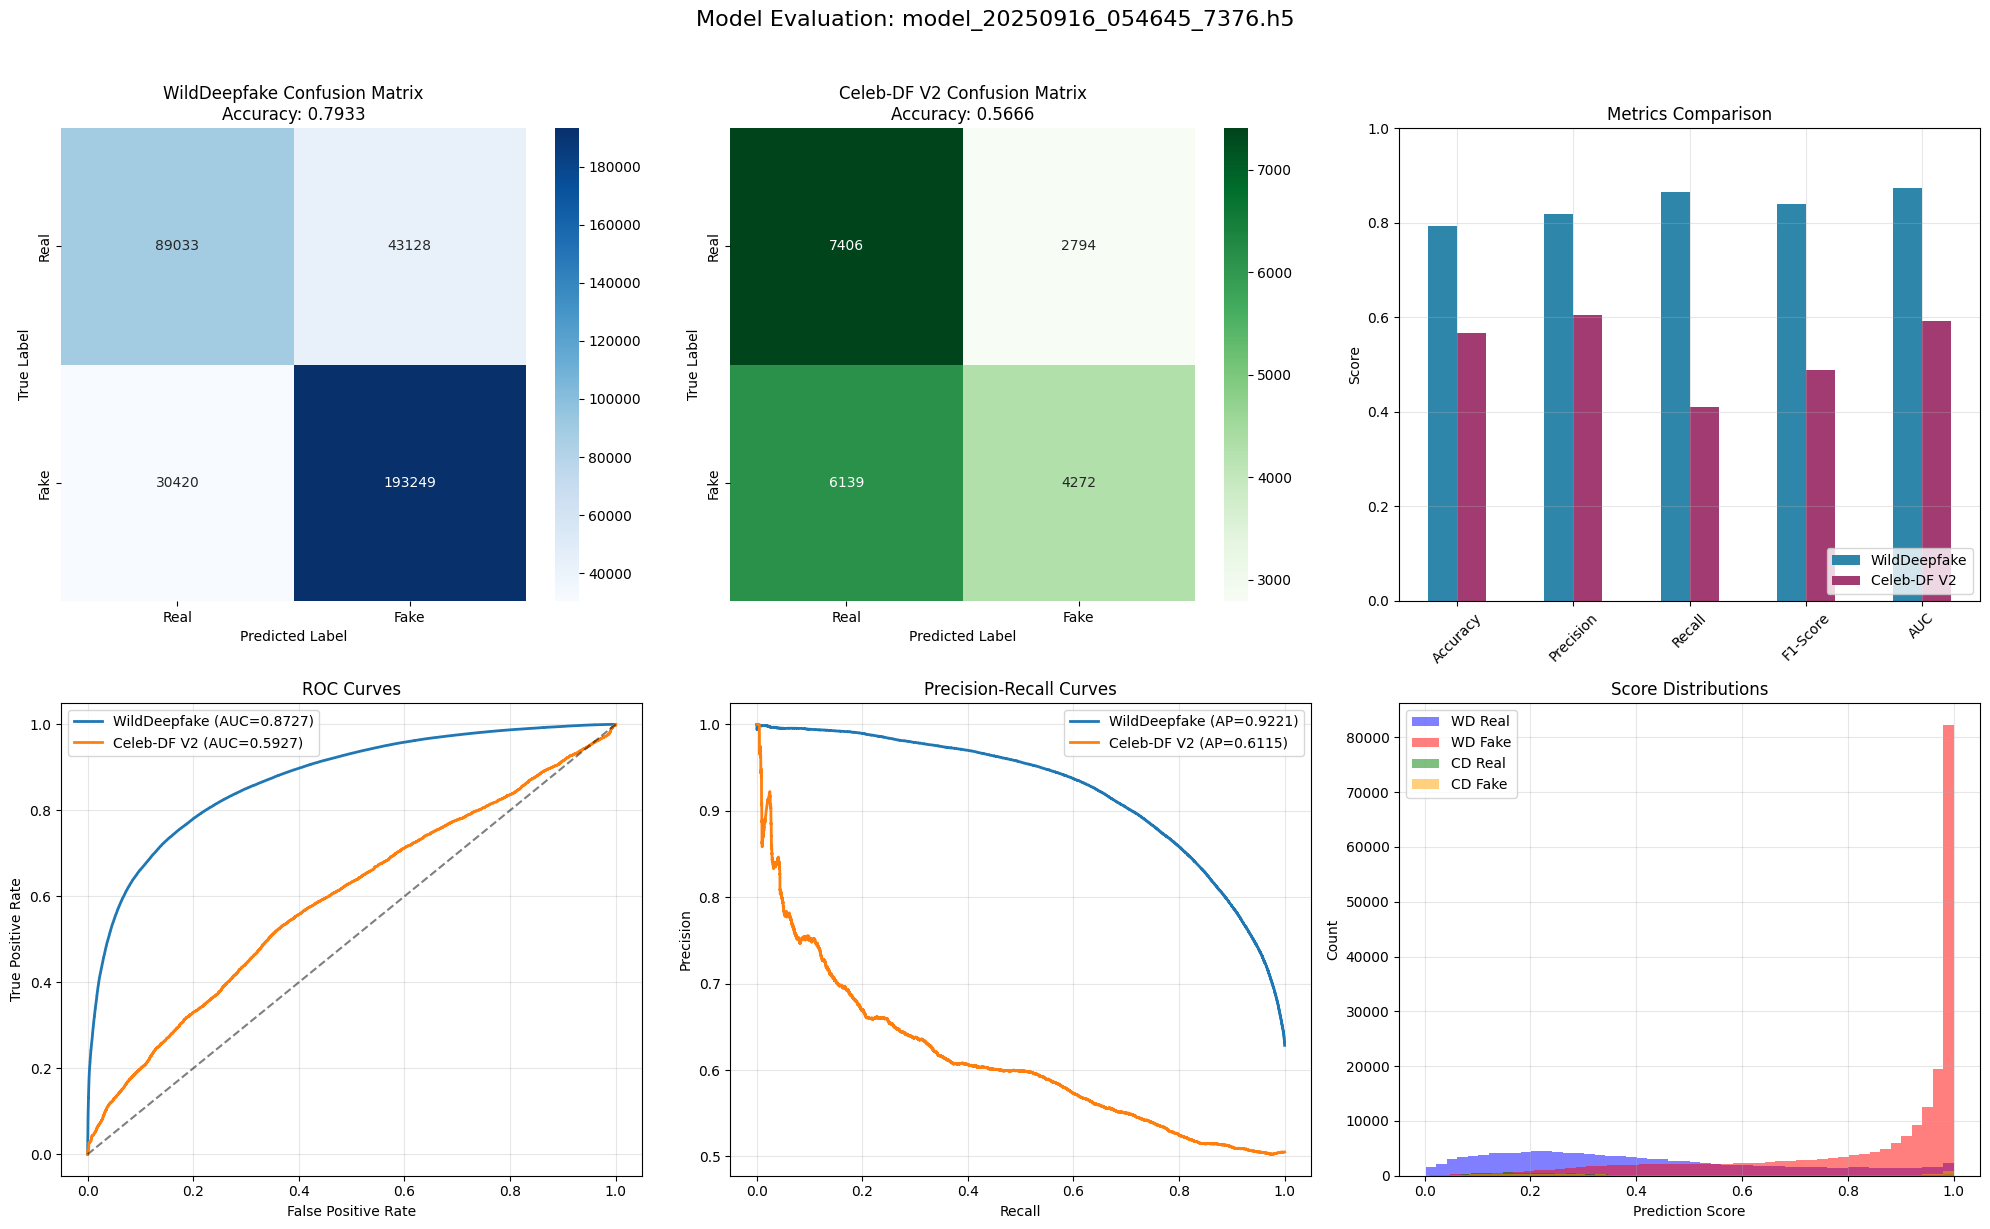


Plot saved to: /tmp/model_evaluation/evaluation_20250924_074121.png

------------------------------------------------------------
Saving evaluation results...
Results saved to: /tmp/model_evaluation/evaluation_results_20250924_074121.json
Results uploaded to GCS: evaluation_results/eval_model_20250916_054645_7376.h5_20250924_074121.json
Plot uploaded to GCS: evaluation_results/plot_model_20250916_054645_7376.h5_20250924_074121.png

EVALUATION COMPLETE!

Model: evolution_models/generation_11/model_20250916_054645_7376.h5
Parameters: 27,393

Metric          WildDeepfake  Celeb-DF V2   Difference
----------------------------------------------------
Accuracy              0.7933       0.5666      +0.2267
Precision             0.8175       0.6046      +0.2130
Recall                0.8640       0.4103      +0.4537
F1-Score              0.8401       0.4889      +0.3513
AUC                   0.8727       0.5927      +0.2800

----------------------------------------------------
GENERALIZATION  

In [ ]:
# ====== STANDALONE MODEL EVALUATION ON FULL TEST SETS ======
# This cell can evaluate ANY .h5 model on WildDeepfake and Celeb-DF v2 test sets

import os
import numpy as np
import tensorflow as tf
import pickle
import subprocess
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import storage
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
import pandas as pd
import gc

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("="*80)
print("MODEL EVALUATION ON FULL TEST SETS")
print("="*80)

# ====== SPECIFY YOUR MODEL HERE ======
MODEL_TO_EVALUATE = input("Enter the model path or filename (e.g., 'model_20250916_054645_7376.h5'): ").strip()

# Configuration
GCS_BUCKET = "???"
LOCAL_DATA_DIR = "/tmp/wilddeepfake_data"
CELEB_DF_DATA_DIR = "/tmp/celeb_df_data"
EVAL_DIR = "/tmp/model_evaluation"
BATCH_SIZE = 256  # Process in batches to avoid memory issues

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)
os.makedirs(CELEB_DF_DATA_DIR, exist_ok=True)
os.makedirs(EVAL_DIR, exist_ok=True)
os.makedirs(os.path.join(LOCAL_DATA_DIR, '02_processed_data'), exist_ok=True)
os.makedirs(os.path.join(LOCAL_DATA_DIR, '03_metadata'), exist_ok=True)

print(f"\nModel to evaluate: {MODEL_TO_EVALUATE}")
print(f"GCS Bucket: {GCS_BUCKET}")
print(f"Evaluation directory: {EVAL_DIR}")
print(f"Batch size for evaluation: {BATCH_SIZE}")

# Initialize GCS client
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

# ====== LOAD MODEL ======
print("\n" + "-"*60)
print("Loading model...")

local_model_path = None

# Check if it's a local file
if os.path.exists(MODEL_TO_EVALUATE):
    local_model_path = MODEL_TO_EVALUATE
    print(f"Found local model: {local_model_path}")
else:
    # Try to find in GCS
    possible_paths = [
        MODEL_TO_EVALUATE,
        f"evolution_models/{MODEL_TO_EVALUATE}",
        f"evolved_models/{MODEL_TO_EVALUATE}",
        f"evolved_models/final_selected/{MODEL_TO_EVALUATE}",
        f"final_trained_models/{MODEL_TO_EVALUATE}",
        f"deepfake_models_fast/{MODEL_TO_EVALUATE}",
        f"deepfake_models_stable/{MODEL_TO_EVALUATE}"
    ]

    # Also search in generation folders
    for gen in range(50):
        possible_paths.append(f"evolution_models/generation_{gen}/{MODEL_TO_EVALUATE}")

    found_in_gcs = False
    for gcs_path in possible_paths:
        blob = bucket.blob(gcs_path)
        if blob.exists():
            print(f"Found model in GCS: {gcs_path}")
            local_model_path = os.path.join(EVAL_DIR, f"model_to_eval_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5")
            blob.download_to_filename(local_model_path)
            found_in_gcs = True
            break

    if not found_in_gcs:
        print("Model not found. Available models in GCS:")
        # List some available models
        prefixes = ['evolution_models/', 'evolved_models/', 'final_trained_models/']
        for prefix in prefixes:
            blobs = list(bucket.list_blobs(prefix=prefix, max_results=10))
            if blobs:
                print(f"\nIn {prefix}:")
                for blob in blobs:
                    if blob.name.endswith('.h5'):
                        print(f"  - {blob.name}")
        raise FileNotFoundError(f"Model {MODEL_TO_EVALUATE} not found")

# Load the model
print(f"Loading model from: {local_model_path}")
model = tf.keras.models.load_model(local_model_path)
print(f"Model loaded successfully!")
print(f"Total parameters: {model.count_params():,}")

# Print model summary
print("\nModel Architecture Summary:")
model.summary()

# ====== HELPER FUNCTION FOR BATCH EVALUATION ======
def evaluate_in_batches(model, X_memmap, y_memmap, indices, batch_size=256, flip_labels=False):
    """Evaluate model on data in batches to avoid memory issues"""
    all_predictions = []
    all_labels = []

    num_batches = int(np.ceil(len(indices) / batch_size))

    print(f"  Processing {len(indices):,} samples in {num_batches} batches...")

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(indices))
        batch_indices = indices[start_idx:end_idx]

        # Load batch data
        X_batch = X_memmap[batch_indices].astype(np.float32) / 255.0
        y_batch = y_memmap[batch_indices].astype(np.float32)

        if flip_labels:
            y_batch = 1 - y_batch

        # Predict
        batch_predictions = model.predict(X_batch, verbose=0)

        all_predictions.extend(batch_predictions.flatten())
        all_labels.extend(y_batch)

        # Progress update
        if (i + 1) % 10 == 0 or (i + 1) == num_batches:
            progress = (i + 1) / num_batches * 100
            print(f"    Progress: {progress:.1f}% ({i + 1}/{num_batches} batches)", end='\r')

        # Clear batch from memory
        del X_batch, y_batch, batch_predictions
        gc.collect()

    print()  # New line after progress

    return np.array(all_predictions), np.array(all_labels)

# ====== LOAD WILDDEEPFAKE DATASET ======
print("\n" + "="*60)
print("LOADING WILDDEEPFAKE TEST SET")
print("="*60)

# Download metadata
metadata_path = os.path.join(LOCAL_DATA_DIR, '03_metadata/dataset_metadata.pkl')
if not os.path.exists(metadata_path):
    print("Downloading WildDeepfake metadata...")
    blob = bucket.blob('03_metadata/dataset_metadata.pkl')
    blob.download_to_filename(metadata_path)

with open(metadata_path, 'rb') as f:
    metadata = pickle.load(f)
print(f"WildDeepfake dataset: {metadata['total_samples']:,} samples")

# Download memmap files
print("\nChecking WildDeepfake memmap files...")
memmap_files = [
    ('02_processed_data/X_memmap.dat', os.path.join(LOCAL_DATA_DIR, '02_processed_data/X_memmap.dat')),
    ('02_processed_data/y_memmap.dat', os.path.join(LOCAL_DATA_DIR, '02_processed_data/y_memmap.dat'))
]

for gcs_path, local_path in memmap_files:
    if not os.path.exists(local_path):
        blob = bucket.blob(gcs_path)
        if blob.exists():
            blob.reload()
            file_size_gb = blob.size / (1024**3) if blob.size else 0
            print(f"Downloading {os.path.basename(local_path)} ({file_size_gb:.2f} GB)...")

            if file_size_gb > 1:
                cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                subprocess.run(cmd, shell=True, check=True)
            else:
                blob.download_to_filename(local_path)
    else:
        print(f"  {os.path.basename(local_path)} already cached")

# Load WildDeepfake arrays as memmap
print("\nLoading WildDeepfake memmap arrays...")
X_wild = np.memmap(
    os.path.join(LOCAL_DATA_DIR, '02_processed_data/X_memmap.dat'),
    dtype=np.uint8,
    mode='r',
    shape=metadata['shape']
)
y_wild = np.memmap(
    os.path.join(LOCAL_DATA_DIR, '02_processed_data/y_memmap.dat'),
    dtype=np.int8,
    mode='r',
    shape=(metadata['total_samples'],)
)

# Load test indices
test_indices_path = os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits/test_indices.npy')
if not os.path.exists(test_indices_path):
    os.makedirs(os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits'), exist_ok=True)
    for prefix in ['WildDeepfake_splits/', 'splits/', '']:
        blob = bucket.blob(f'{prefix}test_indices.npy')
        if blob.exists():
            blob.download_to_filename(test_indices_path)
            break
    else:
        # Create test indices if not found
        print("Creating test indices...")
        all_indices = np.arange(len(y_wild))
        np.random.seed(42)
        np.random.shuffle(all_indices)
        test_size = int(0.1 * len(all_indices))
        test_indices_wild = all_indices[-test_size:]
        np.save(test_indices_path, test_indices_wild)

test_indices_wild = np.load(test_indices_path)
print(f"WildDeepfake test set: {len(test_indices_wild):,} samples")

# Count class distribution without loading all data
print("Analyzing class distribution...")
real_count = np.sum(y_wild[test_indices_wild] == 0)
fake_count = np.sum(y_wild[test_indices_wild] == 1)
print(f"  Real: {real_count:,}, Fake: {fake_count:,}")

# ====== EVALUATE ON WILDDEEPFAKE ======
print("\n" + "="*80)
print("EVALUATING ON WILDDEEPFAKE TEST SET")
print("="*80)

start_time = time.time()
print(f"Evaluating {len(test_indices_wild):,} samples in batches of {BATCH_SIZE}...")

# Evaluate in batches
wild_predictions, wild_labels = evaluate_in_batches(
    model, X_wild, y_wild, test_indices_wild, batch_size=BATCH_SIZE
)

wild_pred_classes = (wild_predictions > 0.5).astype(int)
wild_time = time.time() - start_time

# Calculate metrics
wild_accuracy = accuracy_score(wild_labels, wild_pred_classes)
wild_precision = precision_score(wild_labels, wild_pred_classes)
wild_recall = recall_score(wild_labels, wild_pred_classes)
wild_f1 = f1_score(wild_labels, wild_pred_classes)
wild_auc = roc_auc_score(wild_labels, wild_predictions)

print(f"\nWildDeepfake Test Results:")
print(f"  Accuracy:  {wild_accuracy:.4f}")
print(f"  Precision: {wild_precision:.4f}")
print(f"  Recall:    {wild_recall:.4f}")
print(f"  F1-Score:  {wild_f1:.4f}")
print(f"  AUC:       {wild_auc:.4f}")
print(f"  Evaluation time: {wild_time:.2f} seconds")

# Confusion Matrix
wild_cm = confusion_matrix(wild_labels, wild_pred_classes)
print(f"\nConfusion Matrix:")
print(f"  True Negative (Real->Real): {wild_cm[0,0]:,}")
print(f"  False Positive (Real->Fake): {wild_cm[0,1]:,}")
print(f"  False Negative (Fake->Real): {wild_cm[1,0]:,}")
print(f"  True Positive (Fake->Fake): {wild_cm[1,1]:,}")

# ====== LOAD CELEB-DF V2 DATASET ======
print("\n" + "="*60)
print("LOADING CELEB-DF V2 TEST SET")
print("="*60)

# Download Celeb-DF metadata
celeb_metadata_path = os.path.join(CELEB_DF_DATA_DIR, 'metadata.pkl')
if not os.path.exists(celeb_metadata_path):
    print("Downloading Celeb-DF metadata...")
    blob = bucket.blob('celeb_df_v2/processed/metadata.pkl')
    if blob.exists():
        blob.download_to_filename(celeb_metadata_path)
    else:
        print("WARNING: Celeb-DF metadata not found, skipping Celeb-DF evaluation")
        celeb_metadata = None

if os.path.exists(celeb_metadata_path):
    with open(celeb_metadata_path, 'rb') as f:
        celeb_metadata = pickle.load(f)
    print(f"Celeb-DF v2 dataset: {celeb_metadata['total_samples']:,} samples")

    # Download Celeb-DF memmap files
    celeb_memmap_files = [
        ('celeb_df_v2/processed/frames_memmap.dat', os.path.join(CELEB_DF_DATA_DIR, 'frames_memmap.dat')),
        ('celeb_df_v2/processed/labels_memmap.dat', os.path.join(CELEB_DF_DATA_DIR, 'labels_memmap.dat'))
    ]

    for gcs_path, local_path in celeb_memmap_files:
        if not os.path.exists(local_path):
            blob = bucket.blob(gcs_path)
            if blob.exists():
                blob.reload()
                file_size_gb = blob.size / (1024**3) if blob.size else 0
                print(f"Downloading {os.path.basename(local_path)} ({file_size_gb:.2f} GB)...")

                if file_size_gb > 1:
                    cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                    subprocess.run(cmd, shell=True, check=True)
                else:
                    blob.download_to_filename(local_path)
        else:
            print(f"  {os.path.basename(local_path)} already cached")

    # Load Celeb-DF arrays as memmap
    print("\nLoading Celeb-DF memmap arrays...")
    X_celeb = np.memmap(
        os.path.join(CELEB_DF_DATA_DIR, 'frames_memmap.dat'),
        dtype=np.uint8,
        mode='r',
        shape=celeb_metadata['shape']
    )
    y_celeb = np.memmap(
        os.path.join(CELEB_DF_DATA_DIR, 'labels_memmap.dat'),
        dtype=np.int8,
        mode='r',
        shape=(celeb_metadata['total_samples'],)
    )

    # Load test indices
    celeb_test_indices_path = os.path.join(CELEB_DF_DATA_DIR, 'test_indices.npy')
    if not os.path.exists(celeb_test_indices_path):
        blob = bucket.blob('celeb_df_v2/processed/test_indices.npy')
        if blob.exists():
            blob.download_to_filename(celeb_test_indices_path)
        else:
            # Create test indices
            all_indices = np.arange(celeb_metadata['total_samples'])
            np.random.seed(42)
            np.random.shuffle(all_indices)
            test_size = int(0.1 * len(all_indices))
            test_indices_celeb = all_indices[:test_size]
            np.save(celeb_test_indices_path, test_indices_celeb)
    else:
        test_indices_celeb = np.load(celeb_test_indices_path)

    print(f"Celeb-DF test set: {len(test_indices_celeb):,} samples")

    # Count class distribution
    real_count = np.sum(y_celeb[test_indices_celeb] == 0)
    fake_count = np.sum(y_celeb[test_indices_celeb] == 1)
    print(f"  Real: {real_count:,}, Fake: {fake_count:,}")
else:
    celeb_metadata = None
    X_celeb = None
    y_celeb = None
    test_indices_celeb = None

# ====== EVALUATE ON CELEB-DF V2 ======
if X_celeb is not None:
    print("\n" + "="*80)
    print("EVALUATING ON CELEB-DF V2 TEST SET")
    print("="*80)

    start_time = time.time()
    print(f"Evaluating {len(test_indices_celeb):,} samples in batches of {BATCH_SIZE}...")

    # Evaluate in batches with flipped labels for Celeb-DF
    celeb_predictions, celeb_labels = evaluate_in_batches(
        model, X_celeb, y_celeb, test_indices_celeb, batch_size=BATCH_SIZE, flip_labels=True
    )

    celeb_pred_classes = (celeb_predictions > 0.5).astype(int)
    celeb_time = time.time() - start_time

    # Calculate metrics
    celeb_accuracy = accuracy_score(celeb_labels, celeb_pred_classes)
    celeb_precision = precision_score(celeb_labels, celeb_pred_classes)
    celeb_recall = recall_score(celeb_labels, celeb_pred_classes)
    celeb_f1 = f1_score(celeb_labels, celeb_pred_classes)
    celeb_auc = roc_auc_score(celeb_labels, celeb_predictions)

    print(f"\nCeleb-DF V2 Test Results:")
    print(f"  Accuracy:  {celeb_accuracy:.4f}")
    print(f"  Precision: {celeb_precision:.4f}")
    print(f"  Recall:    {celeb_recall:.4f}")
    print(f"  F1-Score:  {celeb_f1:.4f}")
    print(f"  AUC:       {celeb_auc:.4f}")
    print(f"  Evaluation time: {celeb_time:.2f} seconds")

    # Confusion Matrix
    celeb_cm = confusion_matrix(celeb_labels, celeb_pred_classes)
    print(f"\nConfusion Matrix:")
    print(f"  True Negative (Real->Real): {celeb_cm[0,0]:,}")
    print(f"  False Positive (Real->Fake): {celeb_cm[0,1]:,}")
    print(f"  False Negative (Fake->Real): {celeb_cm[1,0]:,}")
    print(f"  True Positive (Fake->Fake): {celeb_cm[1,1]:,}")

    # Generalization Gap
    generalization_gap = wild_accuracy - celeb_accuracy
    print(f"\n" + "-"*60)
    print(f"GENERALIZATION GAP (WildDeepfake - Celeb-DF): {generalization_gap:+.4f}")
    if abs(generalization_gap) < 0.05:
        print("  → Excellent generalization (gap < 5%)")
    elif abs(generalization_gap) < 0.10:
        print("  → Good generalization (gap < 10%)")
    elif abs(generalization_gap) < 0.15:
        print("  → Moderate generalization (gap < 15%)")
    else:
        print("  → Poor generalization (gap ≥ 15%)")

# ====== VISUALIZATIONS ======
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create figure with subplots
if X_celeb is not None:
    fig = plt.figure(figsize=(20, 12))

    # Confusion Matrices
    ax1 = plt.subplot(2, 3, 1)
    sns.heatmap(wild_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'WildDeepfake Confusion Matrix\nAccuracy: {wild_accuracy:.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    ax2 = plt.subplot(2, 3, 2)
    sns.heatmap(celeb_cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'Celeb-DF V2 Confusion Matrix\nAccuracy: {celeb_accuracy:.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Metrics Comparison
    ax3 = plt.subplot(2, 3, 3)
    metrics_df = pd.DataFrame({
        'WildDeepfake': [wild_accuracy, wild_precision, wild_recall, wild_f1, wild_auc],
        'Celeb-DF V2': [celeb_accuracy, celeb_precision, celeb_recall, celeb_f1, celeb_auc]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])

    metrics_df.plot(kind='bar', ax=ax3, color=['#2E86AB', '#A23B72'])
    plt.title('Metrics Comparison')
    plt.ylabel('Score')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # ROC Curves
    ax4 = plt.subplot(2, 3, 4)
    wild_fpr, wild_tpr, _ = roc_curve(wild_labels, wild_predictions)
    celeb_fpr, celeb_tpr, _ = roc_curve(celeb_labels, celeb_predictions)

    plt.plot(wild_fpr, wild_tpr, label=f'WildDeepfake (AUC={wild_auc:.4f})', linewidth=2)
    plt.plot(celeb_fpr, celeb_tpr, label=f'Celeb-DF V2 (AUC={celeb_auc:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Precision-Recall Curves
    ax5 = plt.subplot(2, 3, 5)
    wild_prec, wild_rec, _ = precision_recall_curve(wild_labels, wild_predictions)
    celeb_prec, celeb_rec, _ = precision_recall_curve(celeb_labels, celeb_predictions)

    wild_ap = average_precision_score(wild_labels, wild_predictions)
    celeb_ap = average_precision_score(celeb_labels, celeb_predictions)

    plt.plot(wild_rec, wild_prec, label=f'WildDeepfake (AP={wild_ap:.4f})', linewidth=2)
    plt.plot(celeb_rec, celeb_prec, label=f'Celeb-DF V2 (AP={celeb_ap:.4f})', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Score Distribution
    ax6 = plt.subplot(2, 3, 6)
    plt.hist(wild_predictions[wild_labels==0], bins=50, alpha=0.5, label='WD Real', color='blue')
    plt.hist(wild_predictions[wild_labels==1], bins=50, alpha=0.5, label='WD Fake', color='red')
    plt.hist(celeb_predictions[celeb_labels==0], bins=50, alpha=0.5, label='CD Real', color='green')
    plt.hist(celeb_predictions[celeb_labels==1], bins=50, alpha=0.5, label='CD Fake', color='orange')
    plt.xlabel('Prediction Score')
    plt.ylabel('Count')
    plt.title('Score Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)

else:
    # Only WildDeepfake results
    fig = plt.figure(figsize=(15, 5))

    ax1 = plt.subplot(1, 3, 1)
    sns.heatmap(wild_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix\nAccuracy: {wild_accuracy:.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    ax2 = plt.subplot(1, 3, 2)
    wild_fpr, wild_tpr, _ = roc_curve(wild_labels, wild_predictions)
    plt.plot(wild_fpr, wild_tpr, label=f'AUC={wild_auc:.4f}', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)

    ax3 = plt.subplot(1, 3, 3)
    metrics_data = [wild_accuracy, wild_precision, wild_recall, wild_f1, wild_auc]
    metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#73BA9B', '#003D5B']
    bars = plt.bar(metrics_labels, metrics_data, color=colors)
    plt.ylim([0, 1])
    plt.ylabel('Score')
    plt.title('Performance Metrics')
    for bar, val in zip(bars, metrics_data):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.suptitle(f'Model Evaluation: {os.path.basename(MODEL_TO_EVALUATE)}', fontsize=16, y=1.02)
plt.tight_layout()

# Save plot
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_path = os.path.join(EVAL_DIR, f'evaluation_{timestamp}.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: {plot_path}")

# ====== SAVE EVALUATION RESULTS ======
print("\n" + "-"*60)
print("Saving evaluation results...")

results = {
    'model_path': MODEL_TO_EVALUATE,
    'timestamp': timestamp,
    'model_params': model.count_params(),
    'wilddeepfake_results': {
        'test_samples': int(len(test_indices_wild)),
        'accuracy': float(wild_accuracy),
        'precision': float(wild_precision),
        'recall': float(wild_recall),
        'f1_score': float(wild_f1),
        'auc': float(wild_auc),
        'confusion_matrix': wild_cm.tolist(),
        'evaluation_time_seconds': float(wild_time)
    }
}

if X_celeb is not None:
    results['celebdf_results'] = {
        'test_samples': int(len(test_indices_celeb)),
        'accuracy': float(celeb_accuracy),
        'precision': float(celeb_precision),
        'recall': float(celeb_recall),
        'f1_score': float(celeb_f1),
        'auc': float(celeb_auc),
        'confusion_matrix': celeb_cm.tolist(),
        'evaluation_time_seconds': float(celeb_time)
    }
    results['generalization_gap'] = float(generalization_gap)

# Save to JSON
import json
results_path = os.path.join(EVAL_DIR, f'evaluation_results_{timestamp}.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")

# Upload to GCS
try:
    gcs_results_path = f'evaluation_results/eval_{os.path.basename(MODEL_TO_EVALUATE)}_{timestamp}.json'
    blob = bucket.blob(gcs_results_path)
    blob.upload_from_filename(results_path)
    print(f"Results uploaded to GCS: {gcs_results_path}")

    gcs_plot_path = f'evaluation_results/plot_{os.path.basename(MODEL_TO_EVALUATE)}_{timestamp}.png'
    blob = bucket.blob(gcs_plot_path)
    blob.upload_from_filename(plot_path)
    print(f"Plot uploaded to GCS: {gcs_plot_path}")
except Exception as e:
    print(f"Could not upload to GCS: {e}")

# ====== FINAL SUMMARY ======
print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)
print(f"\nModel: {MODEL_TO_EVALUATE}")
print(f"Parameters: {model.count_params():,}")

print(f"\n{'Metric':<15} {'WildDeepfake':>12} {'Celeb-DF V2':>12} {'Difference':>12}")
print("-" * 52)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
wild_vals = [wild_accuracy, wild_precision, wild_recall, wild_f1, wild_auc]

if X_celeb is not None:
    celeb_vals = [celeb_accuracy, celeb_precision, celeb_recall, celeb_f1, celeb_auc]
    for metric, wild_val, celeb_val in zip(metrics, wild_vals, celeb_vals):
        diff = wild_val - celeb_val
        print(f"{metric:<15} {wild_val:>12.4f} {celeb_val:>12.4f} {diff:>+12.4f}")

    print("\n" + "-"*52)
    print(f"{'GENERALIZATION':<15} {'GAP:':>12} {generalization_gap:>12.4f}")

    if abs(generalization_gap) < 0.05:
        print("\nEXCELLENT cross-dataset generalization!")
    elif abs(generalization_gap) < 0.10:
        print("\nGOOD cross-dataset generalization")
    elif abs(generalization_gap) < 0.15:
        print("\nMODERATE cross-dataset generalization")
    else:
        print("\n✗ POOR cross-dataset generalization - model may be overfitting")
else:
    for metric, wild_val in zip(metrics, wild_vals):
        print(f"{metric:<15} {wild_val:>12.4f} {'N/A':>12} {'N/A':>12}")
    print("\nCeleb-DF evaluation not available")

print("="*80)

# Clean up
del model
tf.keras.backend.clear_session()
gc.collect()

print("\nEvaluation complete! Results saved locally and uploaded to GCS.")

### 5. Part - Second LLM-supported EA

**1. Environment Setup and Configuration**

In [ ]:
import os
import json
import time
import random
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any, Optional
import pandas as pd
from google.cloud import storage
import pickle
import gc
import base64
from io import BytesIO
from PIL import Image
import requests
from dataclasses import dataclass, asdict
from enum import Enum
import hashlib
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ====== ENHANCED CONFIGURATION ======
OPENAI_API_KEY = "???" # Use your own OpenAI API key here
GCS_BUCKET = "???"
LOCAL_DATA_DIR = "/tmp/fusion_data"
CELEB_DF_PATH = "/home/jupyter/celeb_df_processed"

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

# Enhanced Fusion Configuration with LLM Control
FUSION_CONFIG = {
    # Evolution parameters
    'population_size': 20,
    'num_generations': 15,
    'mutation_rate': 0.4,
    'crossover_rate': 0.7,
    'elite_size': 3,

    # Model configurations - Using GPT-4o for VLM (vision) and GPT-5 for LLM Controller
    'vlm_model': 'gpt-4o',  # Vision-Language Model
    'llm_controller_model': 'gpt-5',  # LLM Controller
    'max_vlm_calls_per_eval': 200,

    # LLM Controller settings
    'enable_llm_controller': True,
    'llm_decision_frequency': 2,
    'llm_analysis_depth': 'comprehensive',
    'allow_dynamic_population': True,
    'allow_strategy_creation': True,

    # Performance targets for Celeb-DF v2
    'target_celeb_accuracy': 0.85,
    'target_kaggle_accuracy': 0.70,
    'acceptable_gap': 0.20,

    # Strategy tracking
    'track_per_strategy_metrics': True,
    'save_strategy_history': True,

    # Technical settings
    'confidence_calibration': True,
    'ensemble_strategies': True,
    'use_cache': True,
    'parallel_processing': False,
    'num_workers': 1,

    # Logging and analysis
    'verbose_llm_reasoning': True,
    'save_llm_decisions': True,
    'track_decision_impact': True
}

print("="*80)
print("LLM-CONTROLLED CNN-VLM FUSION PIPELINE")
print("="*80)
print(f"Configuration loaded successfully")
print(f"LLM Controller: GPT-5")
print(f"Vision Model: GPT-4o (Optimized for cost-efficiency)")
print(f"Validation Dataset: Celeb-DF v2")
print(f"API Key: {'Configured' if OPENAI_API_KEY != 'YOUR_API_KEY_HERE' else 'Not set'}")
print(f"GCS Bucket: {GCS_BUCKET}")
print("="*80)

2025-10-21 06:37:46.504801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


LLM-CONTROLLED CNN-VLM FUSION PIPELINE
Configuration loaded successfully
LLM Controller: GPT-5
Vision Model: GPT-4o (Optimized for cost-efficiency)
Validation Dataset: Celeb-DF v2
API Key: Configured
GCS Bucket: new-dissertation-folder


**2. Load and Verify CNN Model**

In [ ]:
print("\n" + "="*80)
print("LOADING AND VERIFYING CNN MODEL")
print("="*80)

# Initialize GCS client
client = storage.Client()
bucket = client.bucket(GCS_BUCKET)

# Function to load the best evolved CNN model
def load_best_cnn_model():
    """Load the best CNN model from evolution"""

    # Updated model path for the new evolved CNN from generation 17
    best_model_path = 'evolution_models/generation_11/model_20250916_054645_7376.h5' #use the path to the best model from the first evolution

    try:
        # Download the specific evolved model
        local_path = os.path.join(LOCAL_DATA_DIR, 'best_evolved_cnn.h5')
        blob = bucket.blob(best_model_path)

        if blob.exists():
            print(f"Downloading evolved CNN model: {best_model_path}")
            blob.download_to_filename(local_path)

            # Load with custom objects for focal loss if needed
            custom_objects = {
                'BinaryFocalCrossentropy': tf.keras.losses.BinaryFocalCrossentropy,
            }

            model = tf.keras.models.load_model(local_path, custom_objects=custom_objects, compile=False)

            # Recompile with proper loss and optimizer
            model.compile(
                optimizer=tf.keras.optimizers.Adam(0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
            )

            print(f"Loaded evolved CNN model from: {best_model_path}")
            print(f"   Model parameters: {model.count_params():,}")
            print(f"   Expected accuracy: ~78% on first dataset, ~57% on second dataset")
            return model
        else:
            print(f"Specific model not found at {best_model_path}")
            # Check if the path should be 'evolved_models' instead of 'evolution_models'
            alt_path = best_model_path.replace('evolution_models', 'evolved_models')
            alt_blob = bucket.blob(alt_path)
            if alt_blob.exists():
                print(f"   Found model at alternative path: {alt_path}")
                print("   Consider updating the path if this is the intended model.")
            print("Creating optimized CNN architecture as fallback...")
            return create_optimized_cnn()

    except Exception as e:
        print(f"Error loading model: {e}")
        print("Creating new CNN architecture as fallback...")
        return create_optimized_cnn()

def create_optimized_cnn():
    """Create an optimized CNN based on evolution results"""
    inputs = tf.keras.layers.Input(shape=(112, 112, 3))

    # Architecture matching the evolved model
    x = tf.keras.layers.Conv2D(32, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    x = tf.keras.layers.Conv2D(512, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    print(f"Created fallback CNN with {model.count_params():,} parameters")

    return model

# Load the CNN model
CNN_MODEL = load_best_cnn_model()
print(f"\nCNN Model Ready")
print(f"   Input shape: {CNN_MODEL.input_shape}")
print(f"   Output shape: {CNN_MODEL.output_shape}")

# Display model parameter count (no specific expectation since unknown)
print(f"\nModel loaded with {CNN_MODEL.count_params():,} parameters")
print(f"   Expected performance: ~79% accuracy on dataset 1, ~56% accuracy on dataset 2") # again, exchange for the values from the first evolution


LOADING AND VERIFYING CNN MODEL


2025-10-21 06:38:00.688775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-21 06:38:00.747081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-21 06:38:00.747317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loaded evolved CNN model from: evolution_models/generation_11/model_20250916_054645_7376.h5
   Model parameters: 27,393
   Expected accuracy: ~78% on first dataset, ~57% on second dataset

CNN Model Ready
   Input shape: (None, 112, 112, 3)
   Output shape: (None, 1)

Model loaded with 27,393 parameters
   Expected performance: ~79% accuracy on dataset 1, ~56% accuracy on dataset 2


**3. Data Loading and Preparation**

In [ ]:
print("\n" + "="*80)
print("LOADING DATASETS")
print("="*80)

import subprocess

# Function to load WildDeepfake dataset (as first/validation dataset)
def load_wilddeepfake_data(max_samples=2000):
    """Load WildDeepfake dataset from memmap files (LOCAL_DATA_DIR + GCS fallback)"""

    print("Loading WildDeepfake dataset...")

    try:
        # Ensure directories exist
        os.makedirs(os.path.join(LOCAL_DATA_DIR, '02_processed_data'), exist_ok=True)
        os.makedirs(os.path.join(LOCAL_DATA_DIR, '03_metadata'), exist_ok=True)
        os.makedirs(os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits'), exist_ok=True)

        # Download metadata if missing
        metadata_path = os.path.join(LOCAL_DATA_DIR, '03_metadata/dataset_metadata.pkl')
        if not os.path.exists(metadata_path):
            print("  Downloading metadata from GCS...")
            blob = bucket.blob('03_metadata/dataset_metadata.pkl')
            blob.download_to_filename(metadata_path)

        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
        print(f"  Dataset metadata: {metadata['total_samples']:,} samples")

        # Ensure memmap files are cached locally
        print("\n  Checking memmap files...")
        memmap_files = [
            ('02_processed_data/X_memmap.dat', os.path.join(LOCAL_DATA_DIR, '02_processed_data/X_memmap.dat')),
            ('02_processed_data/y_memmap.dat', os.path.join(LOCAL_DATA_DIR, '02_processed_data/y_memmap.dat'))
        ]

        for gcs_path, local_path in memmap_files:
            if not os.path.exists(local_path):
                blob = bucket.blob(gcs_path)
                if blob.exists():
                    blob.reload()
                    file_size_gb = blob.size / (1024**3) if blob.size else 0
                    print(f"  Downloading {os.path.basename(local_path)} ({file_size_gb:.2f} GB)...")
                    if file_size_gb > 1:
                        cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                        result = subprocess.run(cmd, shell=True)
                        if result.returncode != 0:
                            raise Exception(f"Failed to download {gcs_path}")
                    else:
                        blob.download_to_filename(local_path)
                        print(f"  Downloaded {os.path.basename(local_path)}")
                else:
                    raise FileNotFoundError(f"File not found in GCS: {gcs_path}")
            else:
                # Verify file size matches GCS (if available)
                local_size = os.path.getsize(local_path)
                blob = bucket.blob(gcs_path)
                blob.reload()
                if blob.size and local_size != blob.size:
                    print(f"  File size mismatch for {os.path.basename(local_path)}, re-downloading...")
                    os.remove(local_path)
                    if blob.size / (1024**3) > 1:
                        cmd = f"gsutil -m cp gs://{GCS_BUCKET}/{gcs_path} {local_path}"
                        subprocess.run(cmd, shell=True)
                    else:
                        blob.download_to_filename(local_path)

        # Load memmaps
        print("\n  Loading memmap arrays...")
        X = np.memmap(
            os.path.join(LOCAL_DATA_DIR, '02_processed_data/X_memmap.dat'),
            dtype=np.uint8,
            mode='r',
            shape=metadata['shape']
        )
        y = np.memmap(
            os.path.join(LOCAL_DATA_DIR, '02_processed_data/y_memmap.dat'),
            dtype=np.int8,
            mode='r',
            shape=(metadata['total_samples'],)
        )
        print(f"  Memmap arrays loaded: X {X.shape}, y {y.shape}")

        # Load validation indices
        splits_dir = os.path.join(LOCAL_DATA_DIR, 'WildDeepfake_splits')
        val_indices_path = os.path.join(splits_dir, 'val_indices.npy')
        if not os.path.exists(val_indices_path):
            # Try to download from a few possible GCS prefixes
            for gcs_prefix in ['WildDeepfake_splits/', 'splits/', '']:
                blob = bucket.blob(f'{gcs_prefix}val_indices.npy')
                if blob.exists():
                    blob.download_to_filename(val_indices_path)
                    break

        if os.path.exists(val_indices_path):
            val_indices = np.load(val_indices_path)
            print(f"  Using validation split: {len(val_indices):,} samples")
        else:
            print("  No validation indices found, using random sample")
            val_indices = np.random.choice(
                metadata['total_samples'],
                min(max_samples, metadata['total_samples']),
                replace=False
            )

        # Sample subset
        if len(val_indices) > max_samples:
            real_indices = val_indices[y[val_indices] == 0]
            fake_indices = val_indices[y[val_indices] == 1]
            samples_per_class = max_samples // 2
            if len(real_indices) >= samples_per_class and len(fake_indices) >= samples_per_class:
                selected_real = np.random.choice(real_indices, samples_per_class, replace=False)
                selected_fake = np.random.choice(fake_indices, samples_per_class, replace=False)
                selected_indices = np.concatenate([selected_real, selected_fake])
            else:
                selected_indices = np.random.choice(val_indices, max_samples, replace=False)
        else:
            selected_indices = val_indices

        wild_images = X[selected_indices].astype(np.float32) / 255.0
        wild_labels = np.array(y[selected_indices])

        print(f"\nLoaded WildDeepfake: {wild_images.shape}")
        print(f"   Real: {np.sum(wild_labels == 0):,}")
        print(f"   Fake: {np.sum(wild_labels == 1):,}")

        return wild_images, wild_labels

    except Exception as e:
        print(f"Error loading WildDeepfake: {e}")
        print("Creating synthetic data for testing...")
        wild_images = np.random.rand(max_samples, 112, 112, 3).astype(np.float32)
        wild_labels = np.random.randint(0, 2, max_samples)
        return wild_images, wild_labels

# Function to load Celeb-DF v2 dataset (as second/test dataset)
def load_celebdf_v2_data(max_samples=2000):
    """Load Celeb-DF v2 dataset from processed memmap files"""

    print("\nLoading Celeb-DF v2 dataset...")

    try:
        # Load metadata
        metadata_path = os.path.join(CELEB_DF_PATH, 'metadata.pkl')
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)

        print(f"Dataset metadata: {metadata['total_samples']:,} samples")

        # Load memmap arrays
        frames_mmap = np.memmap(
            os.path.join(CELEB_DF_PATH, 'frames_memmap.dat'),
            dtype=np.uint8,
            mode='r',
            shape=metadata['shape']
        )

        labels_mmap = np.memmap(
            os.path.join(CELEB_DF_PATH, 'labels_memmap.dat'),
            dtype=np.int8,
            mode='r',
            shape=(metadata['total_samples'],)
        )

        # Load validation indices
        val_indices_path = os.path.join(CELEB_DF_PATH, 'val_indices.npy')
        if os.path.exists(val_indices_path):
            val_indices = np.load(val_indices_path)
            print(f"Using validation split: {len(val_indices):,} samples")
        else:
            print("No validation indices found, using random sample")
            val_indices = np.random.choice(metadata['total_samples'],
                                         min(max_samples, metadata['total_samples']),
                                         replace=False)

        # Sample from validation set
        if len(val_indices) > max_samples:
            # Balance the classes
            real_indices = val_indices[labels_mmap[val_indices] == 0]
            fake_indices = val_indices[labels_mmap[val_indices] == 1]

            samples_per_class = max_samples // 2

            if len(real_indices) >= samples_per_class and len(fake_indices) >= samples_per_class:
                selected_real = np.random.choice(real_indices, samples_per_class, replace=False)
                selected_fake = np.random.choice(fake_indices, samples_per_class, replace=False)
                selected_indices = np.concatenate([selected_real, selected_fake])
            else:
                selected_indices = np.random.choice(val_indices, max_samples, replace=False)
        else:
            selected_indices = val_indices

        # Load selected samples
        celeb_images = frames_mmap[selected_indices].astype(np.float32) / 255.0
        celeb_labels = np.array(labels_mmap[selected_indices])

        print(f"Loaded Celeb-DF v2: {celeb_images.shape}")
        print(f"   Real: {np.sum(celeb_labels == 0):,}")
        print(f"   Fake: {np.sum(celeb_labels == 1):,}")

        return celeb_images, celeb_labels

    except Exception as e:
        print(f"  Error loading Celeb-DF v2: {e}")
        print("  Creating synthetic Celeb-DF v2 data for testing...")
        celeb_images = np.random.rand(max_samples, 112, 112, 3).astype(np.float32)
        celeb_labels = np.random.randint(0, 2, max_samples)
        return celeb_images, celeb_labels

# Load datasets
print("")
X_wild, y_wild = load_wilddeepfake_data(max_samples=2000)   # WildDeepfake for validation
X_celebv2, y_celebv2 = load_celebdf_v2_data(max_samples=2000)   # Celeb-DF v2 for testing

print(f"\nWildDeepfake loaded (validation): {X_wild.shape}")
print(f"   Real: {np.sum(y_wild == 0)}")
print(f"   Fake: {np.sum(y_wild == 1)}")
print(f"Celeb-DF v2 loaded (test): {X_celebv2.shape}")
print(f"   Real: {np.sum(y_celebv2 == 0)}")
print(f"   Fake: {np.sum(y_celebv2 == 1)}")


LOADING DATASETS

Loading WildDeepfake dataset...
  Dataset metadata: 1,186,099 samples

  Checking memmap files...

  Loading memmap arrays...
  Memmap arrays loaded: X (1186099, 112, 112, 3), y (1186099,)
  Using validation split: 166,054 samples

Loaded WildDeepfake: (2000, 112, 112, 3)
   Real: 1,000
   Fake: 1,000

Loading Celeb-DF v2 dataset...
Dataset metadata: 195,841 samples
Using validation split: 38,580 samples
Loaded Celeb-DF v2: (2000, 112, 112, 3)
   Real: 1,000
   Fake: 1,000

WildDeepfake loaded (validation): (2000, 112, 112, 3)
   Real: 1000
   Fake: 1000
Celeb-DF v2 loaded (test): (2000, 112, 112, 3)
   Real: 1000
   Fake: 1000


**4. Vision-Language Model Integration**

In [ ]:
print("\n" + "="*80)
print("VISION-LANGUAGE MODEL - BALANCED DETECTION")
print("="*80)

!pip install -q openai pillow

from openai import OpenAI
import re
import json
import random
import hashlib
import numpy as np
from datetime import datetime
from io import BytesIO
from PIL import Image
import base64
import time
import gc
from typing import Dict, Any, Tuple, List, Optional

class VisionLanguageModel:
    """VLM with properly balanced detection"""

    def __init__(self, api_key: str, model: str = "gpt-4o", debug: bool = False):
        self.client = OpenAI(api_key=api_key)
        self.model = model
        self.cache = {}
        self.max_cache_size = 500
        self.total_calls = 0
        self.total_cost = 0.0
        self.actual_api_calls = 0
        self.refusal_count = 0
        self.successful_calls = 0
        self.cost_per_call = 0.005
        self.debug = debug
        self.current_dataset = None
        self.last_api_call_time = 0
        self.min_time_between_calls = 0.15

        # Enhanced retry statistics
        self.retry_stats = {
            'total_retries': 0,
            'successful_retries': 0,
            'retry_by_attempt': {i: 0 for i in range(1, 11)}
        }

        # BALANCED PROMPTS - Clear and specific
        self.artifact_questions = [
            # Prompt 0 - Skin texture
            """Look at the skin texture on the forehead and cheeks.
Is the texture unnaturally smooth, lacking pores and natural variations?

Answer YES if skin appears artificially smooth, NO if you see natural texture details.""",

            # Prompt 1 - Edge blending
            """Examine where the face meets the background, especially around the hairline.
Do you see sharp cutouts, unnatural blending, or mismatched edges?

Answer YES if edges show digital compositing, NO if transitions look natural.""",

            # Prompt 2 - Feature consistency
            """Check if the eyes, nose, and mouth properly align and belong together.
Do facial features seem mismatched or from different sources?

Answer YES if features seem inconsistent, NO if they appear cohesive.""",

            # Prompt 3 - Lighting match
            """Compare the lighting on the face to the overall scene lighting.
Are shadows and highlights consistent with the apparent light source?

Answer YES if lighting seems mismatched, NO if lighting is consistent.""",

            # Prompt 4 - Resolution differences
            """Compare the sharpness of the face to other parts of the image.
Is there a noticeable difference in quality or resolution?

Answer YES if quality differs between regions, NO if quality is uniform.""",

            # Prompt 5 - Eye details
            """Look closely at both eyes, checking iris patterns and reflections.
Do the eyes lack natural detail or have mismatched reflections?

Answer YES if eyes seem artificial, NO if they appear natural.""",

            # Prompt 6 - Overall coherence
            """Does the overall face appear naturally photographed?
Look for any uncanny valley effects or subtle artificiality.

Answer YES if something seems off, NO if it appears genuinely photographed.""",

            # Prompt 7 - Color consistency
            """Is the skin tone consistent and natural across the face?
Check for unnatural color patches or boundaries.

Answer YES if you see color inconsistencies, NO if coloring is natural."""
        ]

        # System prompt variations - neutral
        self.system_prompts = [
            "You are analyzing images for technical characteristics. Report what you observe.",
            "As an image analyst, examine specific visual properties objectively.",
            "Evaluate images based on visual consistency and technical attributes.",
            "Analyze the technical aspects of images based on visual observation.",
            "Focus on specific visual characteristics when examining images."
        ]

    def clear_cache_if_needed(self):
        """Clear cache if it gets too large"""
        if len(self.cache) > self.max_cache_size:
            keys_to_keep = list(self.cache.keys())[-self.max_cache_size//2:]
            new_cache = {k: self.cache[k] for k in keys_to_keep if k in self.cache}
            self.cache = new_cache
            gc.collect()

    def set_dataset(self, dataset_name: str):
        """Set which dataset is being processed"""
        self.current_dataset = dataset_name
        if self.debug:
            print(f"[{dataset_name}]", end=" ")

    def encode_image(self, image_array: np.ndarray, quality: int = 90) -> str:
        """Encode image to base64 with configurable quality"""
        if image_array.max() <= 1.0:
            image_array = (image_array * 255).astype(np.uint8)

        img = Image.fromarray(image_array)
        img.thumbnail((640, 640), Image.Resampling.LANCZOS)
        buffered = BytesIO()
        img.save(buffered, format="JPEG", quality=quality)
        base64_str = base64.b64encode(buffered.getvalue()).decode('utf-8')

        buffered.close()
        del buffered
        del img

        return base64_str

    def parse_binary_answer(self, content: str) -> Tuple[bool, bool]:
        """Parse YES/NO answer"""
        if not content:
            return None, False

        content = content.strip().upper()

        # Check for refusal patterns
        refusal_phrases = ["SORRY", "CANNOT", "CAN'T", "UNABLE", "REFUSE", "INAPPROPRIATE"]
        if any(phrase in content for phrase in refusal_phrases):
            return None, False

        # Simple YES/NO detection
        content_start = content[:100]

        # Look for clear YES or NO
        if "YES" in content_start:
            no_pos = content_start.find("NO")
            yes_pos = content_start.find("YES")
            if no_pos == -1 or yes_pos < no_pos:
                return True, True

        if "NO" in content_start:
            yes_pos = content_start.find("YES")
            no_pos = content_start.find("NO")
            if yes_pos == -1 or no_pos < yes_pos:
                return False, True

        # Check full content
        if "YES" in content and "NO" not in content[:content.index("YES")]:
            return True, True
        elif "NO" in content and "YES" not in content[:content.index("NO")]:
            return False, True

        return None, False

    def enhanced_retry_ask(self, base64_image: str, question: str, max_attempts: int = 10) -> Tuple[Optional[bool], bool]:
        """Enhanced retry mechanism with multiple strategies"""

        for attempt in range(1, max_attempts + 1):
            try:
                # Vary parameters based on attempt
                temperature = 0.1 + (attempt - 1) * 0.05
                temperature = min(temperature, 0.5)

                # Select system prompt variation
                system_prompt = self.system_prompts[attempt % len(self.system_prompts)]

                # Use exact question
                question_to_use = question

                # Add exponential backoff with jitter
                if attempt > 1:
                    base_delay = min(0.5 * (2 ** (attempt - 2)), 8)
                    jitter = random.uniform(0, 0.3 * base_delay)
                    retry_delay = base_delay + jitter
                    time.sleep(retry_delay)

                # Rate limiting
                time_since_last = time.time() - self.last_api_call_time
                if time_since_last < self.min_time_between_calls:
                    time.sleep(self.min_time_between_calls - time_since_last)

                # Make API call with varied parameters
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {
                            "role": "system",
                            "content": system_prompt
                        },
                        {
                            "role": "user",
                            "content": [
                                {"type": "text", "text": question_to_use},
                                {
                                    "type": "image_url",
                                    "image_url": {
                                        "url": f"data:image/jpeg;base64,{base64_image}",
                                        "detail": "high" if attempt <= 3 else "auto"
                                    }
                                }
                            ]
                        }
                    ],
                    max_tokens=min(50 + (attempt * 20), 300),
                    temperature=temperature,
                    seed=random.randint(0, 10000) if attempt > 3 else None
                )

                self.last_api_call_time = time.time()
                self.actual_api_calls += 1
                self.total_calls += 1
                self.total_cost += self.cost_per_call

                if response.choices and response.choices[0].message.content:
                    content = response.choices[0].message.content
                    answer, valid = self.parse_binary_answer(content)

                    if valid:
                        if attempt > 1:
                            self.retry_stats['total_retries'] += 1
                            self.retry_stats['successful_retries'] += 1
                            self.retry_stats['retry_by_attempt'][attempt] += 1
                        if self.debug and attempt > 1:
                            print(f"  S{attempt}", end="")
                        return answer, True
                    elif attempt < max_attempts:
                        if self.debug:
                            print(f"  R{attempt}", end="")
                        continue

            except Exception as e:
                if self.debug:
                    print(f"  E{attempt}", end="")
                if attempt < max_attempts:
                    error_delay = min(1.0 * (2 ** (attempt - 1)), 10)
                    time.sleep(error_delay)
                    continue

        # All attempts failed
        self.retry_stats['total_retries'] += max_attempts - 1
        return None, False

    def ask_artifact_questions(self, image: np.ndarray, num_questions: int = 3) -> List[bool]:
        """Ask artifact detection questions with strategic selection"""

        base64_image = self.encode_image(image)

        # Strategic question selection
        if self.current_dataset and "celeb" in self.current_dataset.lower():
            # Celeb-DF: Focus on subtle artifacts
            question_indices = [0, 5, 6]  # Skin, eyes, overall coherence
            selected_questions = [self.artifact_questions[i] for i in question_indices]
        else:
            # WildDeepfake: Focus on obvious artifacts
            question_indices = [1, 2, 4]  # Edges, feature consistency, resolution
            selected_questions = [self.artifact_questions[i] for i in question_indices]

        answers = []

        for question in selected_questions[:num_questions]:
            answer, valid = self.enhanced_retry_ask(base64_image, question, max_attempts=10)

            if valid:
                answers.append(answer)
                if self.debug:
                    print(f"  {'Y' if answer else 'N'}", end="")
            else:
                if self.debug:
                    print(f"  X", end="")

        del base64_image

        return answers

    def analyze_with_dataset_correction(self, image: np.ndarray, dataset: str = None) -> Dict[str, Any]:
        """Analyze image with unified deterministic scoring for both datasets"""

        if dataset:
            self.current_dataset = dataset

        self.clear_cache_if_needed()

        img_hash = hashlib.md5(image.tobytes()).hexdigest()[:16]
        cache_key = f"{img_hash}_{self.current_dataset}"

        if cache_key in self.cache:
            return self.cache[cache_key]

        if self.debug:
            print("[A]", end="")

        # Ask questions
        answers = self.ask_artifact_questions(image, num_questions=3)

        if answers:
            manipulation_signs = sum(1 for ans in answers if ans == True)
            authentic_signs = sum(1 for ans in answers if ans == False)

            # Any artifact = fake for BOTH datasets
            if manipulation_signs > 0:
                # Any artifact detected = fake
                synthetic_score = 75.0  # Fixed score for fake
                prediction = 1  # Fake
            else:
                # No artifacts = real
                synthetic_score = 25.0  # Fixed score for real
                prediction = 0  # Real

            probability = synthetic_score / 100.0

            # Unified confidence calculation for both datasets
            if len(answers) > 0:
                # Unanimity factor: how consistent were the answers?
                if manipulation_signs == 0 or manipulation_signs == len(answers):
                    unanimity = 1.0  # All answers agree
                else:
                    # Mixed answers reduce confidence
                    unanimity = 1.0 - (min(manipulation_signs, authentic_signs) / len(answers))

                # Completeness factor: how many questions were answered?
                completeness = len(answers) / 3.0  # Assuming 3 questions asked

                # Combined confidence (weighted average)
                confidence = (0.7 * unanimity + 0.3 * completeness)
            else:
                confidence = 0.1  # Low confidence if no answers

            result = {
                'prediction': prediction,
                'probability': probability,
                'synthetic_score': synthetic_score,
                'confidence': confidence,
                'manipulation_signs': manipulation_signs,
                'authentic_signs': authentic_signs,
                'num_questions': len(answers),
                'dataset': self.current_dataset,
                'refused': False
            }

            self.successful_calls += 1

            if self.debug:
                print(f" S:{synthetic_score:.0f}→{'F' if prediction else 'R'}")

            self.cache[cache_key] = result
            return result

        else:
            self.refusal_count += 1

            if self.debug:
                print(" X")

            # Default for refusals - neutral score for both datasets
            synthetic_score = 50.0  # Neutral score for refusal
            prediction = 0  # Default to real for refusals
            probability = synthetic_score / 100.0

            return {
                'prediction': prediction,
                'probability': probability,
                'synthetic_score': synthetic_score,
                'confidence': 0.1,
                'manipulation_signs': 0,
                'authentic_signs': 0,
                'num_questions': 0,
                'dataset': self.current_dataset,
                'refused': True
            }

    def analyze_image(self, image: np.ndarray, dataset: str = None, **kwargs) -> Dict[str, Any]:
        """Main entry point"""
        return self.analyze_with_dataset_correction(image, dataset=dataset)

    def batch_analyze(self, images: np.ndarray,
                     cnn_predictions: np.ndarray = None,
                     max_samples: int = 50,
                     dataset: str = None) -> Tuple[np.ndarray, np.ndarray]:
        """Batch analysis with memory management"""

        if dataset:
            self.current_dataset = dataset

        n_samples = min(len(images), max_samples)

        if cnn_predictions is not None:
            if isinstance(cnn_predictions, list):
                cnn_predictions = cnn_predictions[0]
            cnn_predictions = np.array(cnn_predictions).flatten()
        else:
            cnn_predictions = np.full(len(images), 0.5)

        uncertainty = np.abs(cnn_predictions - 0.5)
        if n_samples < len(images):
            sample_indices = np.argsort(uncertainty)[:n_samples]
        else:
            sample_indices = np.arange(len(images))

        vlm_probabilities = cnn_predictions.copy()
        vlm_confidences = np.zeros(len(images))

        print(f"    VLM analyzing {len(sample_indices)} images", end="")
        if dataset:
            print(f" ({dataset})", end="")
        print("...", end="")

        for i, idx in enumerate(sample_indices):
            result = self.analyze_with_dataset_correction(images[idx], dataset=dataset)

            vlm_probabilities[idx] = result['probability']
            vlm_confidences[idx] = result['confidence']

            if (i + 1) % 10 == 0:
                print(f" {i+1}", end="")

            if (i + 1) % 50 == 0:
                gc.collect()

        print(" Done!")

        return vlm_probabilities, vlm_confidences

    def get_stats(self):
        """Get statistics including retry stats"""
        success_rate = self.successful_calls / max(1, self.actual_api_calls)

        return {
            'total_calls': self.total_calls,
            'actual_api_calls': self.actual_api_calls,
            'successful_calls': self.successful_calls,
            'refusal_count': self.refusal_count,
            'success_rate': success_rate,
            'cache_hits': len(self.cache),
            'estimated_cost': self.total_cost,
            'retry_stats': self.retry_stats
        }

# Initialize VLM
VLM = VisionLanguageModel(OPENAI_API_KEY, model=FUSION_CONFIG['vlm_model'], debug=False)
print("VLM initialised with UNIFIED deterministic scoring")
print("  - Both datasets use: any artifact → fake")
print("  - Both datasets use: same confidence calculation")


VISION-LANGUAGE MODEL - BALANCED DETECTION
VLM initialised with UNIFIED deterministic scoring
  - Both datasets use: any artifact → fake
  - Both datasets use: same confidence calculation


**5. LLM Evolution Controller**

In [ ]:
print("\n" + "="*80)
print("LLM EVOLUTION CONTROLLER")
print("="*80)

from openai import OpenAI
import json
import re

class LLMEvolutionController:
    """LLM-based controller for evolutionary algorithm optimization"""

    def __init__(self, api_key: str, model: str = "gpt-5"):
        self.client = OpenAI(api_key=api_key)
        self.model = model
        self.decision_history = []
        self.generation_analyses = []
        self.total_cost = 0.0
        self.total_tokens_used = 0

    def analyze_generation(self, generation_data: Dict) -> Dict:
        """Analyze a generation's performance and trends"""

        system_message = """You are an expert in evolutionary algorithms and deep learning optimization for deepfake detection.

IMPORTANT: Respond with ONLY a valid JSON object. No markdown, no extra text, just JSON:
{
    "insights": ["observation1", "observation2"],
    "bottlenecks": ["issue1"],
    "opportunities": ["improvement1", "improvement2"],
    "risks": ["concern1"]
}"""

        user_message = f"""Current Generation: {generation_data['generation']}
Target: WildDeepfake ≥ 85%, Celeb-DF v2 ≥ 70%

CURRENT PERFORMANCE:
- Best WildDeepfake: {generation_data['best_wild']:.3f} (Gap: {max(0, 0.85 - generation_data['best_wild']):.3f})
- Best Celeb-DF v2: {generation_data['best_celeb']:.3f} (Gap: {max(0, 0.70 - generation_data['best_celeb']):.3f})
- Average Fitness: {generation_data['avg_fitness']:.3f}
- Generalization Gap: {generation_data['gen_gap']:.3f}

TOP STRATEGIES: {generation_data['top_strategies']}
Strategy Diversity: {generation_data['strategy_diversity']:.2f}
Parameter Variance: {generation_data['param_variance']:.3f}

TRENDS: Fitness {generation_data['fitness_trend']}, Wild {generation_data['wild_trend']}, Celeb {generation_data['celeb_trend']}

Analyze and respond with JSON only."""

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": user_message}
                ],
                max_completion_tokens=300
            )

            self.total_cost += 0.002
            if hasattr(response, 'usage') and response.usage:
                self.total_tokens_used += response.usage.total_tokens

            response_text = response.choices[0].message.content.strip()
            analysis = self._parse_response(response_text)

            if not analysis or not isinstance(analysis, dict):
                analysis = self._create_default_analysis(generation_data)
            else:
                for key in ['insights', 'bottlenecks', 'opportunities', 'risks']:
                    if key not in analysis:
                        analysis[key] = []
                    if not isinstance(analysis[key], list):
                        analysis[key] = [str(analysis[key])]
                    if not analysis[key]:
                        defaults = self._create_default_analysis(generation_data)
                        analysis[key] = defaults[key]

            self.generation_analyses.append(analysis)
            return analysis

        except Exception as e:
            print(f"    GPT-5 Analysis Error: {str(e)[:100]} - Using intelligent defaults")
            analysis = self._create_default_analysis(generation_data)
            self.generation_analyses.append(analysis)
            return analysis

    def make_evolution_decision(self, generation_data: Dict, analysis: Dict) -> Dict:
        """Make strategic decisions for evolution parameters"""

        system_message = """You are an expert in hyperparameter optimization for evolutionary algorithms.

IMPORTANT: Respond with ONLY a valid JSON object. No markdown, no extra text, just JSON:
{
    "population_size": 20,
    "mutation_rate": 0.4,
    "crossover_rate": 0.7,
    "elite_size": 3,
    "prioritize_strategies": [],
    "special_actions": [],
    "reasoning": "explanation"
}"""

        # Simplified message without max_vlm_ratio to avoid confusion
        user_message = f"""Generation {generation_data['generation']}:
Best Wild: {generation_data['best_wild']:.3f} (need ≥0.85)
Best Celeb: {generation_data['best_celeb']:.3f} (need ≥0.70)

Analysis: {json.dumps(analysis, indent=2)}

Current Parameters:
- Population: {generation_data['current_params']['population_size']}
- Mutation: {generation_data['current_params']['mutation_rate']:.2f}
- Crossover: {generation_data['current_params']['crossover_rate']:.2f}
- Elite: {generation_data['current_params']['elite_size']}

Suggest parameter adjustments. Respond with JSON only."""

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": user_message}
                ],
                max_completion_tokens=300
            )

            self.total_cost += 0.002
            if hasattr(response, 'usage') and response.usage:
                self.total_tokens_used += response.usage.total_tokens

            response_text = response.choices[0].message.content.strip()
            decision = self._parse_response(response_text)

            if not decision or not isinstance(decision, dict):
                decision = self._create_default_decision(generation_data)
            else:
                decision = self._validate_decision(decision, generation_data)

            self.decision_history.append({
                'generation': generation_data['generation'],
                'decision': decision,
                'timestamp': datetime.now()
            })

            return decision

        except Exception as e:
            print(f"    GPT-5 Decision Error: {str(e)[:100]} - Using adaptive defaults")
            decision = self._create_default_decision(generation_data)
            self.decision_history.append({
                'generation': generation_data['generation'],
                'decision': decision,
                'timestamp': datetime.now()
            })
            return decision

    def _parse_response(self, text: str) -> Dict[str, Any]:
        """Robust parsing of GPT-5 response"""
        if not text:
            return None

        # Remove markdown code blocks
        text = re.sub(r'```json?\s*', '', text)
        text = re.sub(r'```\s*', '', text)
        text = text.strip()

        # Try direct JSON parsing
        try:
            return json.loads(text)
        except:
            pass

        # Try to find JSON-like content
        json_patterns = [
            r'\{[^{}]*"[^"]+"\s*:[^{}]*\}',
            r'\{.*?\}(?!.*\{)',
            r'\{[^{}]*\}'
        ]

        for pattern in json_patterns:
            matches = re.findall(pattern, text, re.DOTALL)
            for match in reversed(matches):
                try:
                    result = json.loads(match)
                    if isinstance(result, dict):
                        return result
                except:
                    continue

        return None

    def _create_default_analysis(self, generation_data: Dict) -> Dict:
        """Create intelligent default analysis based on performance"""
        gap_wild = 0.85 - generation_data['best_wild']
        gap_celeb = 0.70 - generation_data['best_celeb']

        if gap_wild > 0.15 or gap_celeb > 0.15:
            return {
                "insights": ["Performance below targets", f"Wild gap: {gap_wild:.3f}, Celeb gap: {gap_celeb:.3f}"],
                "bottlenecks": ["Need aggressive exploration"],
                "opportunities": ["Increase mutation rate", "Boost diversity"],
                "risks": ["Slow convergence"]
            }
        elif gap_wild > 0.05 or gap_celeb > 0.05:
            return {
                "insights": ["Approaching targets", "Strategy refinement needed"],
                "bottlenecks": ["Fine-tuning required"],
                "opportunities": ["Optimize fusion weights", "Calibrate thresholds"],
                "risks": ["Local optimum"]
            }
        else:
            return {
                "insights": ["Near target performance", "Maintain stability"],
                "bottlenecks": ["Limited improvement room"],
                "opportunities": ["Fine-tune for consistency", "Reduce variance"],
                "risks": ["Overfitting"]
            }

    def _create_default_decision(self, generation_data: Dict) -> Dict:
        """Create adaptive default decision"""
        gap_wild = 0.85 - generation_data['best_wild']
        gap_celeb = 0.70 - generation_data['best_celeb']

        if gap_wild > 0.1 or gap_celeb > 0.1:
            # Far from target
            mutation_rate = min(0.5, generation_data['current_params']['mutation_rate'] * 1.2)
            population_size = min(30, generation_data['current_params']['population_size'] + 3)
            actions = ["inject_diversity", "increase_exploration"]
        else:
            # Close to target
            mutation_rate = max(0.2, generation_data['current_params']['mutation_rate'] * 0.9)
            population_size = generation_data['current_params']['population_size']
            actions = ["fine_tune", "maintain_best"]

        return {
            'population_size': population_size,
            'mutation_rate': mutation_rate,
            'crossover_rate': generation_data['current_params']['crossover_rate'],
            'elite_size': min(4, generation_data['current_params']['elite_size']),
            'prioritize_strategies': ["uncertainty_sampling", "confidence_based"],
            'special_actions': actions,
            'reasoning': f'Adaptive - gaps: Wild {gap_wild:.3f}, Celeb {gap_celeb:.3f}'
        }

    def _validate_decision(self, decision: Dict, generation_data: Dict) -> Dict:
        """Validate and constrain decision parameters"""
        decision['population_size'] = max(10, min(50, int(decision.get('population_size', generation_data['current_params']['population_size']))))
        decision['mutation_rate'] = max(0.1, min(0.6, float(decision.get('mutation_rate', generation_data['current_params']['mutation_rate']))))
        decision['crossover_rate'] = max(0.5, min(0.9, float(decision.get('crossover_rate', generation_data['current_params']['crossover_rate']))))
        decision['elite_size'] = max(1, min(5, int(decision.get('elite_size', generation_data['current_params']['elite_size']))))

        if 'prioritize_strategies' not in decision or not isinstance(decision['prioritize_strategies'], list):
            decision['prioritize_strategies'] = []
        if 'special_actions' not in decision or not isinstance(decision['special_actions'], list):
            decision['special_actions'] = []
        if 'reasoning' not in decision:
            decision['reasoning'] = 'Parameter optimization'

        # Remove max_vlm_ratio if it accidentally got included
        if 'max_vlm_ratio' in decision:
            del decision['max_vlm_ratio']

        return decision

    def get_stats(self):
        """Get controller statistics"""
        estimated_cost_per_token = 0.00006
        return {
            'total_decisions': len(self.decision_history),
            'total_analyses': len(self.generation_analyses),
            'total_tokens_used': self.total_tokens_used,
            'estimated_cost': self.total_tokens_used * estimated_cost_per_token
        }

# Initialize LLM Controller
print("Initializing GPT-5 Evolution Controller...")
LLM_CONTROLLER = LLMEvolutionController(OPENAI_API_KEY, FUSION_CONFIG['llm_controller_model'])
print(f"✓ GPT-5 Evolution Controller ready")
print(f"   Model: {FUSION_CONFIG['llm_controller_model']} (Chat Completions API)")
print(f"   Using explicit JSON-only prompts for reliable parsing")
print(f"   Simplified parameter set to avoid confusion")


LLM EVOLUTION CONTROLLER
Initializing GPT-5 Evolution Controller...
✓ GPT-5 Evolution Controller ready
   Model: gpt-5 (Chat Completions API)
   Using explicit JSON-only prompts for reliable parsing
   Simplified parameter set to avoid confusion


**6. Fusion Strategies and Genome**

In [ ]:
print("\n" + "="*80)
print("CNN-VLM FUSION WITH DATASET AWARENESS")
print("="*80)

from enum import Enum
from dataclasses import dataclass, field
import random
import numpy as np

class FusionStrategy(Enum):
    """Fusion strategies"""
    CNN_ONLY = "cnn_only"
    WEIGHTED_FUSION = "weighted_fusion"
    CONFIDENCE_BASED = "confidence_based"
    UNCERTAINTY_SAMPLING = "uncertainty_sampling"
    SELECTIVE_OVERRIDE = "selective_override"
    CORRECTIVE_FUSION = "corrective_fusion"
    DATASET_AWARE = "dataset_aware"

@dataclass
class FusionGenome:
    """Genome for fusion parameters"""
    strategy: FusionStrategy
    cnn_weight: float = 0.75
    vlm_weight: float = 0.25
    confidence_threshold: float = 0.7
    uncertainty_threshold: float = 0.25
    disagreement_threshold: float = 0.3
    cascade_threshold: float = 0.6
    real_bias_correction: float = 0.85
    use_calibration: bool = True
    dataset: str = None  # For dataset-aware strategies

    def mutate(self, rate: float = 0.3):
        if random.random() < rate:
            self.cnn_weight = np.clip(self.cnn_weight + random.gauss(0, 0.1), 0.1, 0.9)
            self.vlm_weight = 1.0 - self.cnn_weight

        if random.random() < rate:
            self.confidence_threshold = np.clip(self.confidence_threshold + random.gauss(0, 0.1), 0.3, 0.9)

        if random.random() < rate:
            self.uncertainty_threshold = np.clip(self.uncertainty_threshold + random.gauss(0, 0.05), 0.1, 0.5)

        if random.random() < rate:
            self.disagreement_threshold = np.clip(self.disagreement_threshold + random.gauss(0, 0.05), 0.2, 0.5)

        if random.random() < rate:
            self.cascade_threshold = np.clip(self.cascade_threshold + random.gauss(0, 0.05), 0.4, 0.8)

        if random.random() < rate:
            self.real_bias_correction = np.clip(self.real_bias_correction + random.gauss(0, 0.05), 0.7, 1.0)

        if random.random() < rate / 2:  # Less frequent
            self.use_calibration = not self.use_calibration

    def crossover(self, other):
        child = FusionGenome(
            strategy=random.choice([self.strategy, other.strategy]),
            cnn_weight=(self.cnn_weight + other.cnn_weight) / 2,
            vlm_weight=(self.vlm_weight + other.vlm_weight) / 2,
            confidence_threshold=(self.confidence_threshold + other.confidence_threshold) / 2,
            uncertainty_threshold=(self.uncertainty_threshold + other.uncertainty_threshold) / 2,
            disagreement_threshold=(self.disagreement_threshold + other.disagreement_threshold) / 2,
            cascade_threshold=(self.cascade_threshold + other.cascade_threshold) / 2,
            real_bias_correction=(self.real_bias_correction + other.real_bias_correction) / 2,
            use_calibration=random.choice([self.use_calibration, other.use_calibration])
        )
        # Normalize weights
        total = child.cnn_weight + child.vlm_weight
        if total > 0:
            child.cnn_weight /= total
            child.vlm_weight /= total
        return child

    def to_dict(self):
        """Convert genome to dictionary for reporting"""
        return {
            'strategy': self.strategy.value,
            'cnn_weight': self.cnn_weight,
            'vlm_weight': self.vlm_weight,
            'confidence_threshold': self.confidence_threshold,
            'uncertainty_threshold': self.uncertainty_threshold,
            'disagreement_threshold': self.disagreement_threshold,
            'cascade_threshold': self.cascade_threshold,
            'real_bias_correction': self.real_bias_correction,
            'use_calibration': self.use_calibration
        }

class CNNVLMFusion:
    """CNN-VLM fusion for live VLM calls (not used during evolution)"""

    def __init__(self, cnn_model, vlm_model, genome: FusionGenome):
        self.cnn_model = cnn_model
        self.vlm = vlm_model
        self.genome = genome
        self.calibrator = None

    def fit_calibrator(self, X, y):
        """Fit calibration if enabled"""
        if self.genome.use_calibration:
            from sklearn.isotonic import IsotonicRegression
            preds = self.cnn_model.predict(X[:min(500, len(X))], verbose=0)
            if isinstance(preds, list):
                preds = preds[0]
            preds = preds.flatten()
            self.calibrator = IsotonicRegression(out_of_bounds='clip')
            self.calibrator.fit(preds, y[:len(preds)])

    def predict(self, images: np.ndarray, dataset: str = None) -> np.ndarray:
        """Predict with full VLM coverage"""

        # Get CNN predictions
        cnn_preds = self.cnn_model.predict(images, verbose=0)
        if isinstance(cnn_preds, list):
            cnn_preds = cnn_preds[0]
        cnn_probs = cnn_preds.flatten()

        # Apply calibration if available (except for CNN_ONLY)
        if self.calibrator is not None and self.genome.use_calibration and self.genome.strategy != FusionStrategy.CNN_ONLY:
            cnn_probs = self.calibrator.transform(cnn_probs)

        # Initialize final predictions with CNN (fallback for refusals)
        final_probs = cnn_probs.copy()

        if self.genome.strategy == FusionStrategy.CNN_ONLY:
            return final_probs

        # Get VLM predictions for ALL images
        vlm_probs, vlm_conf = self.vlm.batch_analyze(
            images, cnn_probs,
            max_samples=len(images),  # Analyze all images
            dataset=dataset or self.genome.dataset
        )

        # Process based on strategy - CNN is automatic fallback for refusals (vlm_conf <= 0)
        if self.genome.strategy == FusionStrategy.WEIGHTED_FUSION:
            for i in range(len(images)):
                if vlm_conf[i] > 0:  # VLM provided answer
                    final_probs[i] = cnn_probs[i] * self.genome.cnn_weight + vlm_probs[i] * self.genome.vlm_weight

        elif self.genome.strategy == FusionStrategy.CONFIDENCE_BASED:
            cnn_confidence = np.abs(cnn_probs - 0.5) * 2
            for i in range(len(images)):
                if cnn_confidence[i] < self.genome.confidence_threshold and vlm_conf[i] > 0:
                    final_probs[i] = cnn_probs[i] * 0.4 + vlm_probs[i] * 0.6

        elif self.genome.strategy == FusionStrategy.UNCERTAINTY_SAMPLING:
            uncertainty = 1.0 - np.abs(cnn_probs - 0.5) * 2
            for i in range(len(images)):
                if vlm_conf[i] > 0 and uncertainty[i] > self.genome.uncertainty_threshold:
                    vlm_weight = min(0.7, uncertainty[i])
                    final_probs[i] = cnn_probs[i] * (1 - vlm_weight) + vlm_probs[i] * vlm_weight

        elif self.genome.strategy == FusionStrategy.SELECTIVE_OVERRIDE:
            for i in range(len(images)):
                if vlm_conf[i] > self.genome.confidence_threshold:
                    final_probs[i] = vlm_probs[i]

        elif self.genome.strategy == FusionStrategy.CORRECTIVE_FUSION:
            for i in range(len(images)):
                if vlm_conf[i] > 0:
                    if cnn_probs[i] < 0.5 and vlm_probs[i] < 0.5:
                        final_probs[i] = cnn_probs[i] * self.genome.real_bias_correction
                    else:
                        final_probs[i] = cnn_probs[i] * self.genome.cnn_weight + vlm_probs[i] * self.genome.vlm_weight

        elif self.genome.strategy == FusionStrategy.DATASET_AWARE:
            if dataset and "celeb" in dataset.lower():
                for i in range(len(images)):
                    if vlm_conf[i] > 0:
                        if cnn_probs[i] < 0.5:
                            final_probs[i] = cnn_probs[i] * 0.6 + vlm_probs[i] * 0.4
                        else:
                            final_probs[i] = cnn_probs[i] * self.genome.cnn_weight + vlm_probs[i] * self.genome.vlm_weight
            else:
                for i in range(len(images)):
                    if vlm_conf[i] > 0:
                        final_probs[i] = cnn_probs[i] * self.genome.cnn_weight + vlm_probs[i] * self.genome.vlm_weight

        return final_probs

class CNNVLMFusionCached:
    """CNN-VLM fusion using pre-computed VLM predictions"""

    def __init__(self, cnn_model, genome: FusionGenome, vlm_predictions=None,
                 vlm_confidences=None, vlm_refused=None):
        self.cnn_model = cnn_model
        self.genome = genome
        self.vlm_predictions = vlm_predictions
        self.vlm_confidences = vlm_confidences
        self.vlm_refused = vlm_refused  # Boolean array indicating refusals
        self.calibrator = None

    def fit_calibrator(self, X, y):
        """Fit calibration if enabled"""
        if self.genome.use_calibration and self.genome.strategy != FusionStrategy.CNN_ONLY:
            from sklearn.isotonic import IsotonicRegression
            preds = self.cnn_model.predict(X[:min(500, len(X))], verbose=0)
            if isinstance(preds, list):
                preds = preds[0]
            preds = preds.flatten()
            self.calibrator = IsotonicRegression(out_of_bounds='clip')
            self.calibrator.fit(preds, y[:len(preds)])

    def predict_with_cache(self, images: np.ndarray, cnn_preds=None) -> np.ndarray:
        """Predict using cached VLM predictions for ALL images"""

        # Get CNN predictions
        if cnn_preds is None:
            cnn_preds = self.cnn_model.predict(images, verbose=0)
        if isinstance(cnn_preds, list):
            cnn_preds = cnn_preds[0]
        cnn_probs = cnn_preds.flatten()

        # Apply calibration
        if self.calibrator is not None and self.genome.use_calibration and self.genome.strategy != FusionStrategy.CNN_ONLY:
            cnn_probs = self.calibrator.transform(cnn_probs)

        # Start with CNN predictions (automatic fallback)
        final_probs = cnn_probs.copy()

        if self.genome.strategy == FusionStrategy.CNN_ONLY or self.vlm_predictions is None:
            return final_probs

        # Get refused status
        if self.vlm_refused is not None:
            refused = self.vlm_refused
        else:
            refused = self.vlm_confidences <= 0.1

        # Apply fusion strategy to ALL images (except refused ones)
        if self.genome.strategy == FusionStrategy.WEIGHTED_FUSION:
            # Simple weighted fusion for all non-refused predictions
            for i in range(len(images)):
                if not refused[i]:
                    final_probs[i] = (cnn_probs[i] * self.genome.cnn_weight +
                                     self.vlm_predictions[i] * self.genome.vlm_weight)

        elif self.genome.strategy == FusionStrategy.CONFIDENCE_BASED:
            # Use VLM when CNN is uncertain
            cnn_confidence = np.abs(cnn_probs - 0.5) * 2
            for i in range(len(images)):
                if not refused[i] and cnn_confidence[i] < self.genome.confidence_threshold:
                    final_probs[i] = cnn_probs[i] * 0.4 + self.vlm_predictions[i] * 0.6

        elif self.genome.strategy == FusionStrategy.UNCERTAINTY_SAMPLING:
            # Apply VLM influence based on CNN uncertainty
            uncertainty = 1.0 - np.abs(cnn_probs - 0.5) * 2

            for i in range(len(images)):
                if not refused[i] and uncertainty[i] > self.genome.uncertainty_threshold:
                    vlm_weight = min(0.7, uncertainty[i])
                    final_probs[i] = cnn_probs[i] * (1 - vlm_weight) + self.vlm_predictions[i] * vlm_weight

        elif self.genome.strategy == FusionStrategy.SELECTIVE_OVERRIDE:
            # Override CNN when VLM is confident
            for i in range(len(images)):
                if not refused[i] and self.vlm_confidences[i] > self.genome.confidence_threshold:
                    final_probs[i] = self.vlm_predictions[i]

        elif self.genome.strategy == FusionStrategy.CORRECTIVE_FUSION:
            # Apply correction for all non-refused predictions
            for i in range(len(images)):
                if not refused[i]:
                    if cnn_probs[i] < 0.5 and self.vlm_predictions[i] < 0.5:
                        # Both predict real - apply correction
                        final_probs[i] = cnn_probs[i] * self.genome.real_bias_correction
                    else:
                        # Standard fusion
                        final_probs[i] = (cnn_probs[i] * self.genome.cnn_weight +
                                         self.vlm_predictions[i] * self.genome.vlm_weight)

        elif self.genome.strategy == FusionStrategy.DATASET_AWARE:
            if self.genome.dataset and "celeb" in self.genome.dataset.lower():
                # Celeb-DF specific fusion
                for i in range(len(images)):
                    if not refused[i]:
                        if cnn_probs[i] < 0.5:  # CNN predicts real
                            final_probs[i] = cnn_probs[i] * 0.6 + self.vlm_predictions[i] * 0.4
                        else:
                            final_probs[i] = (cnn_probs[i] * self.genome.cnn_weight +
                                            self.vlm_predictions[i] * self.genome.vlm_weight)
            else:
                # WildDeepfake or default
                for i in range(len(images)):
                    if not refused[i]:
                        final_probs[i] = (cnn_probs[i] * self.genome.cnn_weight +
                                         self.vlm_predictions[i] * self.genome.vlm_weight)

        # CNN predictions are automatically used for all refused cases
        return final_probs

print("Simplified Fusion System:")
print("  - Uses pre-computed VLM predictions for ALL images")
print("  - No sampling or ratio parameters")
print("  - CNN fallback only for refused predictions")
print("\nStrategies available:")
for strategy in FusionStrategy:
    print(f"  - {strategy.value}")
print("\nEvolution will optimize:")
print("  - Fusion strategy selection")
print("  - CNN/VLM weight balance")
print("  - Confidence and uncertainty thresholds")
print("  - Dataset-specific parameters")


CNN-VLM FUSION WITH DATASET AWARENESS
Simplified Fusion System:
  - Uses pre-computed VLM predictions for ALL images
  - No sampling or ratio parameters
  - CNN fallback only for refused predictions

Strategies available:
  - cnn_only
  - weighted_fusion
  - confidence_based
  - uncertainty_sampling
  - selective_override
  - corrective_fusion
  - dataset_aware

Evolution will optimize:
  - Fusion strategy selection
  - CNN/VLM weight balance
  - Confidence and uncertainty thresholds
  - Dataset-specific parameters


**7. LLM-Controlled Evolution System**

In [ ]:
print("\n" + "="*80)
print("FAST EVOLUTIONARY OPTIMISATION WITH CACHED VLM AND LLM CONTROLLER")
print("="*80)

import pickle
import hashlib
from google.cloud import storage

def format_predictions(preds):
    if isinstance(preds, list):
        preds = preds[0]
    return np.array(preds).flatten()

class CachedEvolution:
    """Fast evolution using pre-computed VLM predictions with LLM guidance"""

    def __init__(self, cnn_model, wild_data, celeb_data, llm_controller=None, vlm_cache_path=None, cache_id_override=None):
        self.cnn_model = cnn_model
        self.wild_data = wild_data
        self.celeb_data = celeb_data
        self.llm_controller = llm_controller

        # Use override cache_id if provided, otherwise generate
        if cache_id_override:
            cache_id = cache_id_override
            print(f"Using provided cache ID: {cache_id}")
        else:
            # Generate cache ID based on dataset characteristics
            cache_id = hashlib.md5(
                f"{len(wild_data[0])}_{len(celeb_data[0])}_{np.mean(wild_data[1])}_{np.mean(celeb_data[1])}".encode()
            ).hexdigest()[:8]
            print(f"Generated cache ID: {cache_id}")

        # Try multiple cache locations
        cache_loaded = False

        # First try GCS if no path provided
        if vlm_cache_path is None:
            gcs_cache_path = f"vlm_cache/vlm_evolution_cache_{cache_id}.pkl"
            local_cache_path = f"/tmp/vlm_evolution_cache_{cache_id}.pkl"

            print(f"Looking for VLM cache with ID: {cache_id}")

            # Check local first
            if os.path.exists(local_cache_path):
                print(f"  Found local cache: {local_cache_path}")
                vlm_cache_path = local_cache_path
            else:
                # Check GCS
                try:
                    client = storage.Client()
                    bucket = client.bucket(GCS_BUCKET)
                    blob = bucket.blob(gcs_cache_path)

                    if blob.exists():
                        print(f"  Found cache in GCS: {gcs_cache_path}")
                        print(f"  Downloading to: {local_cache_path}")
                        blob.download_to_filename(local_cache_path)
                        vlm_cache_path = local_cache_path
                        print(f"  Downloaded successfully")
                except Exception as e:
                    print(f"  Could not access GCS: {e}")

        # Load the cache
        if vlm_cache_path and os.path.exists(vlm_cache_path):
            print(f"Loading cached VLM predictions from: {vlm_cache_path}")
            with open(vlm_cache_path, 'rb') as f:
                self.vlm_cache = pickle.load(f)

            # Validate cache
            if 'cache_id' in self.vlm_cache:
                print(f"  Cache ID: {self.vlm_cache['cache_id']}")
                print(f"  Created: {self.vlm_cache.get('creation_time', 'Unknown')}")

            print(f"  Loaded predictions for {len(self.vlm_cache['wild_predictions'])} WildDeepfake images")
            print(f"  Loaded predictions for {len(self.vlm_cache['celeb_predictions'])} Celeb-DF images")

            # Report refusal rates
            if 'wild_refused' in self.vlm_cache:
                wild_refusal_rate = np.mean(self.vlm_cache['wild_refused'])
                celeb_refusal_rate = np.mean(self.vlm_cache['celeb_refused'])
                print(f"  Refusal rates: Wild {wild_refusal_rate:.1%}, Celeb {celeb_refusal_rate:.1%}")

                if celeb_refusal_rate > 0.5:
                    print(f"\n  WARNING: Celeb-DF refusal rate is {celeb_refusal_rate:.1%}!")
                    print(f"     VLM will have minimal impact on Celeb-DF results")
        else:
            raise FileNotFoundError(
                f"VLM cache not found! Please run Cell 8 first to generate predictions.\n"
                f"Looked for cache ID: {cache_id}\n"
                f"Expected GCS path: vlm_cache/vlm_evolution_cache_{cache_id}.pkl\n"
                f"Expected local path: /tmp/vlm_evolution_cache_{cache_id}.pkl"
            )

        self.population = []
        self.generation = 0
        self.best_genome = None
        self.best_fitness = 0
        self.history = []
        self.llm_decisions = []

        self.strategy_performance = {strategy.value: {
            'best_wild': 0,
            'best_celeb': 0,
            'best_fitness': 0,
            'evaluations': 0
        } for strategy in FusionStrategy}

        self.current_params = {
            'population_size': 20,
            'mutation_rate': 0.4,
            'crossover_rate': 0.7,
            'elite_size': 3
        }

        self.cnn_wild_acc = None
        self.cnn_celeb_acc = None

    def compute_actual_baselines(self):
        """Compute actual CNN baseline performance"""
        print(f"Computing CNN baselines...")

        wild_images, wild_labels = self.wild_data
        cnn_preds = self.cnn_model.predict(wild_images, verbose=0)
        cnn_preds = format_predictions(cnn_preds)
        self.cnn_wild_acc = np.mean((cnn_preds > 0.5) == wild_labels)

        celeb_images, celeb_labels = self.celeb_data
        cnn_preds = self.cnn_model.predict(celeb_images, verbose=0)
        cnn_preds = format_predictions(cnn_preds)
        self.cnn_celeb_acc = np.mean((cnn_preds > 0.5) == celeb_labels)

        print(f"CNN Baselines: Wild {self.cnn_wild_acc:.4f}, Celeb {self.cnn_celeb_acc:.4f}")

    def evaluate_genome(self, genome: FusionGenome, verbose=False) -> Dict[str, float]:
        """Fast evaluation using cached VLM predictions with EQUAL WEIGHTING"""

        # Prepare cached fusion for WildDeepfake
        genome.dataset = "wilddeepfake"
        fusion_wild = CNNVLMFusionCached(
            self.cnn_model,
            genome,
            self.vlm_cache['wild_predictions'],
            self.vlm_cache['wild_confidences'],
            self.vlm_cache.get('wild_refused')
        )

        if genome.use_calibration and genome.strategy != FusionStrategy.CNN_ONLY:
            val_subset = min(500, len(self.wild_data[0]))
            fusion_wild.fit_calibrator(
                self.wild_data[0][:val_subset],
                self.wild_data[1][:val_subset]
            )

        wild_images, wild_labels = self.wild_data
        wild_preds = fusion_wild.predict_with_cache(wild_images)
        wild_acc = np.mean((wild_preds > 0.5) == wild_labels)

        # Prepare cached fusion for Celeb-DF
        genome.dataset = "celebdf"
        fusion_celeb = CNNVLMFusionCached(
            self.cnn_model,
            genome,
            self.vlm_cache['celeb_predictions'],
            self.vlm_cache['celeb_confidences'],
            self.vlm_cache.get('celeb_refused')
        )

        celeb_images, celeb_labels = self.celeb_data
        celeb_preds = fusion_celeb.predict_with_cache(celeb_images)
        celeb_acc = np.mean((celeb_preds > 0.5) == celeb_labels)

        # Fitness Function: 50% each dataset
        fitness = 0.5 * wild_acc + 0.5 * celeb_acc

        # Small penalty for large gaps to encourage generalization
        gap = abs(wild_acc - celeb_acc)
        if gap > 0.3:
            fitness *= (1.0 - gap * 0.05)  # Reduced penalty

        # Calculate improvements for reporting
        wild_improvement = wild_acc - self.cnn_wild_acc
        celeb_improvement = celeb_acc - self.cnn_celeb_acc

        # Track performance
        strategy = genome.strategy.value
        self.strategy_performance[strategy]['evaluations'] += 1
        if wild_acc > self.strategy_performance[strategy]['best_wild']:
            self.strategy_performance[strategy]['best_wild'] = wild_acc
        if celeb_acc > self.strategy_performance[strategy]['best_celeb']:
            self.strategy_performance[strategy]['best_celeb'] = celeb_acc
        if fitness > self.strategy_performance[strategy]['best_fitness']:
            self.strategy_performance[strategy]['best_fitness'] = fitness

        return {
            'fitness': fitness,
            'wild_acc': wild_acc,
            'celeb_acc': celeb_acc,
            'wild_improvement': wild_improvement,
            'celeb_improvement': celeb_improvement,
            'gap': gap
        }

    def initialize_population(self, size: int):
        """Initialize TRULY diverse population with equal strategy representation"""
        self.population = []
        strategies = list(FusionStrategy)

        # Ensure each strategy gets equal representation initially
        genomes_per_strategy = size // len(strategies)
        remainder = size % len(strategies)

        for i, strategy in enumerate(strategies):
            # Add one extra genome to first strategies if there's a remainder
            count = genomes_per_strategy + (1 if i < remainder else 0)

            for _ in range(count):
                genome = FusionGenome(
                    strategy=strategy,
                    cnn_weight=random.uniform(0.3, 0.9),
                    vlm_weight=random.uniform(0.1, 0.7),
                    confidence_threshold=random.uniform(0.3, 0.9),
                    uncertainty_threshold=random.uniform(0.1, 0.5),
                    disagreement_threshold=random.uniform(0.2, 0.5),
                    cascade_threshold=random.uniform(0.4, 0.8),
                    real_bias_correction=random.uniform(0.7, 1.1),
                    use_calibration=random.choice([True, False]) if strategy != FusionStrategy.CNN_ONLY else False
                )

                # Normalize weights
                total = genome.cnn_weight + genome.vlm_weight
                if total > 0:
                    genome.cnn_weight /= total
                    genome.vlm_weight /= total

                self.population.append(genome)

    def evolve(self, num_generations: int):
        """Run evolution with detailed output and LLM guidance"""

        print(f"\nStarting Fast Evolution with Cached VLM")
        print(f"Generations: {num_generations}")
        print(f"Population: {self.current_params['population_size']}")
        print(f"LLM Controller: {'Enabled' if self.llm_controller else 'Disabled'}")
        print(f"Using all pre-computed VLM predictions")
        print(f"FITNESS: 50% WildDeepfake + 50% Celeb-DF v2")

        self.compute_actual_baselines()
        self.initialize_population(self.current_params['population_size'])

        for gen in range(num_generations):
            self.generation = gen
            print(f"\n{'='*70}")
            print(f"GENERATION {gen + 1}/{num_generations}")
            print(f"{'='*70}")

            # LLM ANALYSIS every few generations
            if self.llm_controller and gen > 0 and gen % 3 == 0:
                print(f"\nLLM CONTROLLER ANALYSIS")
                print("-" * 40)

                # Prepare generation data
                best_prev = self.history[-1][0][1] if self.history else None
                gen_data = {
                    'generation': gen,
                    'best_wild': best_prev['wild_acc'] if best_prev else 0,
                    'best_celeb': best_prev['celeb_acc'] if best_prev else 0,
                    'avg_fitness': np.mean([metrics['fitness'] for _, metrics in self.history[-1]]) if self.history else 0,
                    'fitness_delta': 0,
                    'gen_gap': best_prev['gap'] if best_prev else 0,
                    'top_strategies': [genome.strategy.value for genome, _ in self.history[-1][:3]] if self.history else [],
                    'strategy_diversity': len(set([g.strategy for g in self.population])) / len(FusionStrategy),
                    'param_variance': np.std([g.cnn_weight for g in self.population]),
                    'fitness_trend': 'improving' if len(self.history) > 1 and self.history[-1][0][1]['fitness'] > self.history[-2][0][1]['fitness'] else 'stagnant',
                    'wild_trend': 'improving' if len(self.history) > 1 and self.history[-1][0][1]['wild_acc'] > self.history[-2][0][1]['wild_acc'] else 'stagnant',
                    'celeb_trend': 'improving' if len(self.history) > 1 and self.history[-1][0][1]['celeb_acc'] > self.history[-2][0][1]['celeb_acc'] else 'stagnant',
                    'current_params': self.current_params
                }

                try:
                    analysis = self.llm_controller.analyze_generation(gen_data)
                    print(f"Insights: {', '.join(analysis.get('insights', ['None'])[:2])}")
                    print(f"Bottlenecks: {', '.join(analysis.get('bottlenecks', ['None'])[:2])}")

                    decision = self.llm_controller.make_evolution_decision(gen_data, analysis)
                    print(f"\nLLM DECISION:")
                    print(f"  Population: {decision.get('population_size', self.current_params['population_size'])}")
                    print(f"  Mutation: {decision.get('mutation_rate', self.current_params['mutation_rate']):.2f}")
                    print(f"  Reasoning: {decision.get('reasoning', 'Optimizing parameters')[:80]}")

                    # Apply LLM decisions
                    self.current_params['population_size'] = decision.get('population_size', self.current_params['population_size'])
                    self.current_params['mutation_rate'] = decision.get('mutation_rate', self.current_params['mutation_rate'])
                    self.llm_decisions.append(decision)

                except Exception as e:
                    print(f"  LLM Error: {str(e)[:100]}")

            # Evaluate population
            print(f"\nEvaluating {len(self.population)} genomes:")
            print("-" * 70)

            results = []
            for i, genome in enumerate(self.population):
                metrics = self.evaluate_genome(genome, verbose=True)
                results.append((genome, metrics))

                # SHOW EACH GENOME'S RESULTS
                print(f"  [{i+1:2d}] {genome.strategy.value:20s} | ", end="")
                print(f"W:{metrics['wild_acc']:.3f} C:{metrics['celeb_acc']:.3f} F:{metrics['fitness']:.3f} | ", end="")
                print(f"cnn_w:{genome.cnn_weight:.2f}", end="")

                if metrics['fitness'] > self.best_fitness:
                    self.best_fitness = metrics['fitness']
                    self.best_genome = genome
                    print(" NEW BEST!", end="")
                print()

            # Sort and track
            results.sort(key=lambda x: x[1]['fitness'], reverse=True)
            self.history.append(results)

            # Report generation summary
            best = results[0]
            print(f"\nGeneration {gen+1} Summary:")
            print(f"  Best Strategy: {best[0].strategy.value}")
            print(f"  Best Performance: Wild {best[1]['wild_acc']:.4f} (+{best[1]['wild_improvement']:.4f}), "
                  f"Celeb {best[1]['celeb_acc']:.4f} (+{best[1]['celeb_improvement']:.4f})")
            print(f"  Best Fitness: {best[1]['fitness']:.4f}")

            # Strategy distribution
            strategy_counts = {}
            for g, _ in results:
                strategy_counts[g.strategy.value] = strategy_counts.get(g.strategy.value, 0) + 1
            print(f"\n  Strategy Distribution:")
            for s, c in sorted(strategy_counts.items(), key=lambda x: x[1], reverse=True)[:3]:
                print(f"    {s}: {c} genomes")

            # Check for success
            if best[1]['wild_acc'] >= 0.85 and best[1]['celeb_acc'] >= 0.70:
                print("\nTARGETS ACHIEVED!")
                break

            # Check for stagnation
            if gen > 5 and len(self.history) > 3:
                recent_best = [r[0][1]['fitness'] for r in self.history[-3:]]
                if max(recent_best) - min(recent_best) < 0.001:
                    print("\nEvolution stagnating - increasing mutation")
                    self.current_params['mutation_rate'] = min(0.6, self.current_params['mutation_rate'] * 1.3)

            # Create next generation with FORCED DIVERSITY
            if gen < num_generations - 1:
                self.population = self.create_next_generation_balanced(results)

        return self.best_genome, self.get_results()

    def create_next_generation_balanced(self, results):
        """Create next generation ensuring diversity"""
        new_population = []

        # Track current strategy counts
        current_strategies = {}
        for genome, _ in results:
            s = genome.strategy.value
            current_strategies[s] = current_strategies.get(s, 0) + 1

        # Find underrepresented strategies
        all_strategies = list(FusionStrategy)
        min_representation = max(1, self.current_params['population_size'] // (len(all_strategies) * 2))
        underrepresented = [s for s in all_strategies
                          if s.value not in current_strategies or
                          current_strategies.get(s.value, 0) < min_representation]

        # Elite - but limit if we need diversity
        elite_size = self.current_params['elite_size']
        if underrepresented:
            elite_size = max(1, elite_size - len(underrepresented))

        for i in range(elite_size):
            new_population.append(results[i][0])

        # Force at least one genome for each underrepresented strategy
        for strategy in underrepresented:
            if len(new_population) < self.current_params['population_size']:
                genome = FusionGenome(
                    strategy=strategy,
                    cnn_weight=random.uniform(0.4, 0.8),
                    vlm_weight=random.uniform(0.2, 0.6),
                    confidence_threshold=random.uniform(0.4, 0.8),
                    uncertainty_threshold=random.uniform(0.2, 0.4),
                    real_bias_correction=random.uniform(0.8, 1.0),
                    use_calibration=True if strategy != FusionStrategy.CNN_ONLY else False
                )
                total = genome.cnn_weight + genome.vlm_weight
                genome.cnn_weight /= total
                genome.vlm_weight /= total
                new_population.append(genome)

        # Fill remaining with offspring
        while len(new_population) < self.current_params['population_size']:
            parent1 = self.tournament_select(results)
            parent2 = self.tournament_select(results)

            if random.random() < self.current_params['crossover_rate']:
                child = parent1.crossover(parent2)
            else:
                child = FusionGenome(
                    strategy=parent1.strategy,
                    cnn_weight=parent1.cnn_weight,
                    vlm_weight=parent1.vlm_weight,
                    confidence_threshold=parent1.confidence_threshold,
                    real_bias_correction=parent1.real_bias_correction,
                    use_calibration=parent1.use_calibration
                )

            child.mutate(self.current_params['mutation_rate'])

            # Occasionally force mutation to underrepresented strategy
            if underrepresented and random.random() < 0.15:
                child.strategy = random.choice(underrepresented)

            new_population.append(child)

        return new_population[:self.current_params['population_size']]

    def create_next_generation(self, results):
        """Original next generation creation"""
        return self.create_next_generation_balanced(results)

    def tournament_select(self, results, tournament_size=3):
        tournament = random.sample(results, min(tournament_size, len(results)))
        return max(tournament, key=lambda x: x[1]['fitness'])[0]

    def get_results(self):
        if not self.history:
            return None

        all_results = []
        for gen_results in self.history:
            all_results.extend(gen_results)

        best = max(all_results, key=lambda x: x[1]['fitness'])

        return {
            'genome': best[0],
            'metrics': best[1],
            'cnn_baseline': {
                'wilddeepfake': self.cnn_wild_acc,
                'celeb_df_v2': self.cnn_celeb_acc
            },
            'strategy_performance': self.strategy_performance,
            'vlm_cache_stats': {
                'wild_vlm_acc': self.vlm_cache['wild_vlm_acc'],
                'celeb_vlm_acc': self.vlm_cache['celeb_vlm_acc'],
                'wild_refusal_rate': self.vlm_cache.get('wild_refusal_rate', 0),
                'celeb_refusal_rate': self.vlm_cache.get('celeb_refusal_rate', 0)
            },
            'llm_decisions': self.llm_decisions
        }

print("Enhanced Evolution System Ready")
print("  - Fitness function: 50% WildDeepfake + 50% Celeb-DF v2")
print("  - Equal initial strategy representation")
print("  - Forced diversity in offspring generation")
print("  - Automatic cache loading from GCS")
print("  - LLM controller integration")
print("  - Adaptive mutation on stagnation")


FAST EVOLUTIONARY OPTIMISATION WITH CACHED VLM AND LLM CONTROLLER
Enhanced Evolution System Ready
  - Fitness function: 50% WildDeepfake + 50% Celeb-DF v2
  - Equal initial strategy representation
  - Forced diversity in offspring generation
  - Automatic cache loading from GCS
  - LLM controller integration
  - Adaptive mutation on stagnation


**8. VLM alone for deepfake detection - Pre-Computation for the Evolution**

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE VLM EVALUATION WITH CNN VALIDATION")
print("="*80)

import pickle
import hashlib
from google.cloud import storage
from datetime import datetime

def comprehensive_vlm_evaluation(min_cnn_wild=0.77, min_cnn_celeb=0.55, max_attempts=25):
    """
    Evaluate VLM on 500 samples each - with CNN validation first

    Args:
        min_cnn_wild: Minimum acceptable CNN accuracy on WildDeepfake subset (default 0.77)
        min_cnn_celeb: Minimum acceptable CNN accuracy on Celeb-DF subset (default 0.55)
        max_attempts: Maximum attempts to find a good subset (default 25)
    """

    # Declare global variables at the beginning
    global VLM_ACCURACY, VLM_WEIGHT, VLM_CACHE_FOR_EVOLUTION

    print(f"CNN Performance Requirements:")
    print(f"  WildDeepfake: >= {min_cnn_wild:.1%} (Full test: 79.0%)")
    print(f"  Celeb-DF v2: >= {min_cnn_celeb:.1%} (Full test: 56.6%)")
    print(f"  Max attempts: {max_attempts}")
    print("-" * 60)

    # Try to find a good subset
    for attempt in range(max_attempts):
        print(f"\nAttempt {attempt + 1}/{max_attempts}:")
        print("-" * 40)

        # Set random seed based on attempt for reproducibility
        np.random.seed(42 + attempt)

        # Prepare balanced datasets
        print("Sampling datasets...")

        # WildDeepfake - 250 real, 250 fake
        wild_real_idx = np.where(y_wild == 0)[0]
        wild_fake_idx = np.where(y_wild == 1)[0]

        wild_real_samples = np.random.choice(wild_real_idx, min(250, len(wild_real_idx)), replace=False)
        wild_fake_samples = np.random.choice(wild_fake_idx, min(250, len(wild_fake_idx)), replace=False)

        # Celeb-DF - 250 real, 250 fake
        celeb_real_idx = np.where(y_celebv2 == 0)[0]
        celeb_fake_idx = np.where(y_celebv2 == 1)[0]

        celeb_real_samples = np.random.choice(celeb_real_idx, min(250, len(celeb_real_idx)), replace=False)
        celeb_fake_samples = np.random.choice(celeb_fake_idx, min(250, len(celeb_fake_idx)), replace=False)

        # Combine indices
        wild_all_samples = np.concatenate([wild_real_samples, wild_fake_samples])
        celeb_all_samples = np.concatenate([celeb_real_samples, celeb_fake_samples])

        # Get the actual images and labels
        wild_sampled_images = X_wild[wild_all_samples]
        wild_sampled_labels = y_wild[wild_all_samples]
        celeb_sampled_images = X_celebv2[celeb_all_samples]
        celeb_sampled_labels = y_celebv2[celeb_all_samples]

        print(f"  Sampled: Wild {len(wild_all_samples)}, Celeb {len(celeb_all_samples)}")

        # TEST CNN PERFORMANCE ON THIS SUBSET
        print("\nTesting CNN on sampled subset...")

        # Wild CNN performance
        wild_cnn_preds = CNN_MODEL.predict(wild_sampled_images, verbose=0)
        if isinstance(wild_cnn_preds, list):
            wild_cnn_preds = wild_cnn_preds[0]
        wild_cnn_acc = np.mean((wild_cnn_preds.flatten() > 0.5) == wild_sampled_labels)

        # Celeb CNN performance
        celeb_cnn_preds = CNN_MODEL.predict(celeb_sampled_images, verbose=0)
        if isinstance(celeb_cnn_preds, list):
            celeb_cnn_preds = celeb_cnn_preds[0]
        celeb_cnn_acc = np.mean((celeb_cnn_preds.flatten() > 0.5) == celeb_sampled_labels)

        print(f"\nCNN Performance on this subset:")
        print(f"  WildDeepfake: {wild_cnn_acc:.2%} (target: >={min_cnn_wild:.1%})")
        print(f"  Celeb-DF v2: {celeb_cnn_acc:.2%} (target: >={min_cnn_celeb:.1%})")

        # Check if this subset meets requirements
        if wild_cnn_acc >= min_cnn_wild and celeb_cnn_acc >= min_cnn_celeb:
            print("\n✓ CNN performance acceptable! Proceeding with VLM evaluation...")
            break
        else:
            print("✗ CNN performance below threshold.")
            if attempt < max_attempts - 1:
                print("  Trying different random subset...")
            else:
                print("\nMax attempts reached. Using best subset found.")
                print("Consider adjusting thresholds or using this subset anyway.")

                # Ask user whether to proceed
                user_input = input("\nProceed with VLM evaluation anyway? (yes/no): ").lower().strip()
                if user_input != 'yes':
                    print("Aborted. Adjust parameters and try again.")
                    return None

    # Create cache ID based on the specific subset
    cache_id = hashlib.md5(
        f"{len(wild_sampled_images)}_{len(celeb_sampled_images)}_{wild_cnn_acc:.4f}_{celeb_cnn_acc:.4f}_{attempt}".encode()
    ).hexdigest()[:8]

    print(f"\nCache ID for this subset: {cache_id}")

    # Define GCS cache path
    gcs_cache_path = f"vlm_cache/vlm_evolution_cache_{cache_id}.pkl"
    local_cache_path = f"/tmp/vlm_evolution_cache_{cache_id}.pkl"

    # Check if this exact cache already exists
    client = storage.Client()
    bucket = client.bucket(GCS_BUCKET)
    blob = bucket.blob(gcs_cache_path)

    if blob.exists():
        print(f"\n✓ Found existing VLM cache for this exact subset: {gcs_cache_path}")
        print("  Downloading and using existing predictions...")
        blob.download_to_filename(local_cache_path)

        with open(local_cache_path, 'rb') as f:
            evaluation_cache = pickle.load(f)

        print(f"\n  Loaded cached predictions:")
        print(f"    WildDeepfake VLM: {evaluation_cache['wild_vlm_acc']:.2%}")
        print(f"    Celeb-DF v2 VLM: {evaluation_cache['celeb_vlm_acc']:.2%}")
        print(f"    Overall VLM: {evaluation_cache['overall_accuracy']:.2%}")

        # Set global variables
        VLM_ACCURACY = evaluation_cache['overall_accuracy']
        VLM_CACHE_FOR_EVOLUTION = evaluation_cache

        if evaluation_cache['celeb_fake_acc'] >= 0.50 and evaluation_cache['wild_vlm_acc'] >= 0.65:
            VLM_WEIGHT = 0.30
        elif evaluation_cache['celeb_fake_acc'] >= 0.45:
            VLM_WEIGHT = 0.25
        else:
            VLM_WEIGHT = 0.20

        # Print the cache ID prominently
        print("\n" + "="*60)
        print(f"IMPORTANT: Save this Cache ID for Cell 9: {cache_id}")
        print("="*60)

        return evaluation_cache

    print("\n" + "="*60)
    print("STARTING VLM EVALUATION")
    print("="*60)
    print(f"  - 500 WildDeepfake samples (CNN: {wild_cnn_acc:.2%})")
    print(f"  - 500 Celeb-DF v2 samples (CNN: {celeb_cnn_acc:.2%})")
    print(f"  - Cache ID: {cache_id}")
    print("-" * 60)

    # Arrays to store VLM predictions
    wild_all_predictions = np.zeros(len(wild_all_samples))
    wild_all_confidences = np.zeros(len(wild_all_samples))
    wild_all_scores = np.zeros(len(wild_all_samples))
    wild_all_refused = np.zeros(len(wild_all_samples), dtype=bool)

    celeb_all_predictions = np.zeros(len(celeb_all_samples))
    celeb_all_confidences = np.zeros(len(celeb_all_samples))
    celeb_all_scores = np.zeros(len(celeb_all_samples))
    celeb_all_refused = np.zeros(len(celeb_all_samples), dtype=bool)

    BATCH_SIZE = 25
    results = {}

    # Process samples in order
    categories = [
        ('wild_real', wild_real_samples, X_wild, 0, 'WildDeepfake Real', 'wilddeepfake',
         wild_all_predictions[:len(wild_real_samples)],
         wild_all_confidences[:len(wild_real_samples)],
         wild_all_scores[:len(wild_real_samples)],
         wild_all_refused[:len(wild_real_samples)]),
        ('wild_fake', wild_fake_samples, X_wild, 1, 'WildDeepfake Fake', 'wilddeepfake',
         wild_all_predictions[len(wild_real_samples):],
         wild_all_confidences[len(wild_real_samples):],
         wild_all_scores[len(wild_real_samples):],
         wild_all_refused[len(wild_real_samples):]),
        ('celeb_real', celeb_real_samples, X_celebv2, 0, 'Celeb-DF Real', 'celebdf',
         celeb_all_predictions[:len(celeb_real_samples)],
         celeb_all_confidences[:len(celeb_real_samples)],
         celeb_all_scores[:len(celeb_real_samples)],
         celeb_all_refused[:len(celeb_real_samples)]),
        ('celeb_fake', celeb_fake_samples, X_celebv2, 1, 'Celeb-DF Fake', 'celebdf',
         celeb_all_predictions[len(celeb_real_samples):],
         celeb_all_confidences[len(celeb_real_samples):],
         celeb_all_scores[len(celeb_real_samples):],
         celeb_all_refused[len(celeb_real_samples):])
    ]

    for key, sample_indices, dataset_images, true_label, display_name, dataset_name, pred_slice, conf_slice, score_slice, refused_slice in categories:
        print(f"\n{display_name} ({len(sample_indices)} samples):")

        VLM.set_dataset(dataset_name)

        refused_count = 0

        for batch_idx, batch_start in enumerate(range(0, len(sample_indices), BATCH_SIZE)):
            batch_end = min(batch_start + BATCH_SIZE, len(sample_indices))
            batch_indices = sample_indices[batch_start:batch_end]

            print(f"  Batch {batch_idx + 1}/{(len(sample_indices)-1)//BATCH_SIZE + 1}: ", end="")

            for i, idx in enumerate(batch_indices):
                result = VLM.analyze_with_dataset_correction(dataset_images[idx], dataset=dataset_name)

                local_idx = batch_start + i
                pred_slice[local_idx] = result['probability']
                conf_slice[local_idx] = result['confidence']
                score_slice[local_idx] = result['synthetic_score']
                refused_slice[local_idx] = result.get('refused', False)

                if refused_slice[local_idx]:
                    refused_count += 1

                if (i + 1) % 5 == 0:
                    print(".", end="", flush=True)

            print(f" Done")

        # Calculate accuracy for this category
        accuracy = np.mean((pred_slice > 0.5) == true_label)
        print(f"  **Accuracy: {accuracy:.1%}**")
        print(f"  Refusals: {refused_count}/{len(sample_indices)} ({refused_count/len(sample_indices)*100:.1f}%)")

        results[key] = {
            'accuracy': accuracy,
            'refused': refused_count,
            'n_samples': len(sample_indices)
        }

    # Calculate overall metrics
    wild_accuracy = np.mean((wild_all_predictions > 0.5) == wild_sampled_labels)
    celeb_accuracy = np.mean((celeb_all_predictions > 0.5) == celeb_sampled_labels)

    wild_real_acc = results['wild_real']['accuracy']
    wild_fake_acc = results['wild_fake']['accuracy']
    celeb_real_acc = results['celeb_real']['accuracy']
    celeb_fake_acc = results['celeb_fake']['accuracy']

    overall_accuracy = (wild_accuracy * len(wild_all_samples) + celeb_accuracy * len(celeb_all_samples)) / (len(wild_all_samples) + len(celeb_all_samples))

    # SAVE EVERYTHING INCLUDING IMAGES AND CNN PERFORMANCE
    vlm_cache = {
        # Save the actual images and labels for perfect reproducibility
        'wild_images': wild_sampled_images,
        'wild_labels': wild_sampled_labels,
        'celeb_images': celeb_sampled_images,
        'celeb_labels': celeb_sampled_labels,

        # Save indices for reference
        'wild_indices': wild_all_samples,
        'celeb_indices': celeb_all_samples,

        # Save CNN performance on this subset
        'cnn_wild_acc': wild_cnn_acc,
        'cnn_celeb_acc': celeb_cnn_acc,

        # Save VLM predictions
        'wild_predictions': wild_all_predictions,
        'wild_confidences': wild_all_confidences,
        'wild_scores': wild_all_scores,
        'wild_refused': wild_all_refused,

        'celeb_predictions': celeb_all_predictions,
        'celeb_confidences': celeb_all_confidences,
        'celeb_scores': celeb_all_scores,
        'celeb_refused': celeb_all_refused,

        # Save accuracies
        'wild_vlm_acc': wild_accuracy,
        'celeb_vlm_acc': celeb_accuracy,
        'wild_real_acc': wild_real_acc,
        'wild_fake_acc': wild_fake_acc,
        'celeb_real_acc': celeb_real_acc,
        'celeb_fake_acc': celeb_fake_acc,
        'overall_accuracy': overall_accuracy,
        'wild_refusal_rate': np.mean(wild_all_refused),
        'celeb_refusal_rate': np.mean(celeb_all_refused),

        # Add metadata
        'cache_id': cache_id,
        'creation_time': datetime.now().isoformat(),
        'random_seed': 42 + attempt,
        'attempt_number': attempt + 1,
        'dataset_sizes': {
            'wild': len(X_wild),
            'celeb': len(X_celebv2)
        }
    }

    # Save locally first
    with open(local_cache_path, 'wb') as f:
        pickle.dump(vlm_cache, f)
    print(f"\n✓ VLM predictions saved locally to {local_cache_path}")

    # Upload to GCS for persistence
    blob.upload_from_filename(local_cache_path)
    print(f"✓ VLM predictions uploaded to GCS: {gcs_cache_path}")

    # Display final results
    print("\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)

    print(f"\nCNN Performance (on this subset):")
    print(f"  WildDeepfake: {wild_cnn_acc:.2%}")
    print(f"  Celeb-DF v2: {celeb_cnn_acc:.2%}")

    print(f"\nVLM Performance:")
    print(f"  WildDeepfake: {wild_accuracy:.2%}")
    print(f"    Real accuracy: {wild_real_acc:.2%}")
    print(f"    Fake detection: {wild_fake_acc:.2%}")
    print(f"    Refusal rate: {np.mean(wild_all_refused):.1%}")

    print(f"\n  Celeb-DF v2: {celeb_accuracy:.2%}")
    print(f"    Real accuracy: {celeb_real_acc:.2%}")
    print(f"    Fake detection: {celeb_fake_acc:.2%}")
    print(f"    Refusal rate: {np.mean(celeb_all_refused):.1%}")

    print(f"\n" + "="*60)
    print(f"OVERALL VLM ACCURACY: {overall_accuracy:.2%}")
    print("="*60)

    stats = VLM.get_stats()
    print(f"\nAPI Statistics:")
    print(f"  API calls: {stats['actual_api_calls']}")

    # Set global variables
    VLM_ACCURACY = overall_accuracy
    VLM_CACHE_FOR_EVOLUTION = vlm_cache

    if celeb_fake_acc >= 0.50 and wild_accuracy >= 0.65:
        VLM_WEIGHT = 0.30
    elif celeb_fake_acc >= 0.45:
        VLM_WEIGHT = 0.25
    else:
        VLM_WEIGHT = 0.20

    # Print the cache ID prominently
    print("\n" + "="*60)
    print(f"IMPORTANT: Save this Cache ID for Cell 9: {cache_id}")
    print("="*60)

    return vlm_cache

# Run evaluation with CNN validation
print("Starting VLM evaluation with CNN validation...")
print("\nUsing thresholds:")
print("  min_cnn_wild = 0.77 (77%)")
print("  min_cnn_celeb = 0.55 (55%)")
print("  max_attempts = 25")
print("\nSearching for a good subset...")

evaluation_cache = comprehensive_vlm_evaluation(min_cnn_wild=0.77, min_cnn_celeb=0.55, max_attempts=25)

if evaluation_cache:
    print("\n" + "="*80)
    print("READY FOR FAST EVOLUTION")
    print(f"Cache ID: {evaluation_cache['cache_id']}")
    print("="*80)
else:
    print("\nEvaluation aborted. Adjust parameters and try again.")


COMPREHENSIVE VLM EVALUATION WITH CNN VALIDATION
Starting VLM evaluation with CNN validation...

Using thresholds:
  min_cnn_wild = 0.77 (77%)
  min_cnn_celeb = 0.55 (55%)
  max_attempts = 25

Searching for a good subset...
CNN Performance Requirements:
  WildDeepfake: >= 77.0% (Full test: 79.0%)
  Celeb-DF v2: >= 55.0% (Full test: 56.6%)
  Max attempts: 25
------------------------------------------------------------

Attempt 1/25:
----------------------------------------
Sampling datasets...
  Sampled: Wild 500, Celeb 500

Testing CNN on sampled subset...

CNN Performance on this subset:
  WildDeepfake: 77.40% (target: >=77.0%)
  Celeb-DF v2: 49.00% (target: >=55.0%)
✗ CNN performance below threshold.
  Trying different random subset...

Attempt 2/25:
----------------------------------------
Sampling datasets...
  Sampled: Wild 500, Celeb 500

Testing CNN on sampled subset...

CNN Performance on this subset:
  WildDeepfake: 80.40% (target: >=77.0%)
  Celeb-DF v2: 51.80% (target: >=55

**9. Execute LLM-Controlled Evolution**

In [ ]:
print("\n" + "="*80)
print("EXECUTING FAST CNN-VLM FUSION EVOLUTION WITH LLM CONTROLLER")
print("="*80)

# Check if VLM cache exists
import os
import numpy as np
import time
import pickle
import gc

# Get cache ID from previous cell or use manual input
if 'evaluation_cache' in globals() and evaluation_cache is not None:
    CACHE_ID = evaluation_cache['cache_id']
    print(f"Using cache ID from Cell 8: {CACHE_ID}")
else:
    # Manual input if Cell 8 wasn't just run
    CACHE_ID = input("Enter the Cache ID from Cell 8: ").strip()
    print(f"Using manually entered cache ID: {CACHE_ID}")

# Check if LLM_CONTROLLER exists
if 'LLM_CONTROLLER' not in globals():
    print("\nLLM Controller not found - evolution will run without LLM guidance")
    LLM_CONTROLLER = None
else:
    print("\n✓ LLM Controller found - GPT-5 will provide strategic guidance")

print("\nInitializing Fast Evolution System...")

class CachedEvolutionBalanced(CachedEvolution):
    """Enhanced version with balanced strategy exploration and memory management"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_history_size = 5
        self.min_evaluations_per_strategy = 30

        self.metrics_history = []

    def track_generation_metrics(self, generation, results):
        """Track lightweight metrics for visualization without storing full genomes"""

        # Extract only the essential metrics needed for visualization
        metrics = {
            'generation': generation,
            'best_fitness': max(r[1]['fitness'] for r in results),
            'avg_fitness': np.mean([r[1]['fitness'] for r in results]),
            'best_wild': max(r[1]['wild_acc'] for r in results),
            'best_celeb': max(r[1]['celeb_acc'] for r in results),
            'strategy_counts': {},
            'best_strategy': results[0][0].strategy.value,  # Best genome's strategy
            'population_size': len(results)
        }

        # Count strategies
        for genome, _ in results:
            strategy = genome.strategy.value
            metrics['strategy_counts'][strategy] = metrics['strategy_counts'].get(strategy, 0) + 1

        self.metrics_history.append(metrics)

    def get_underexplored_strategies(self, min_evals=30):
        """Get strategies that need more exploration"""
        underexplored = []
        for strategy_name, stats in self.strategy_performance.items():
            if stats['evaluations'] < min_evals:
                underexplored.append((strategy_name, stats['evaluations']))
        return sorted(underexplored, key=lambda x: x[1])  # Sort by least evaluated

    def create_balanced_population(self, size: int, force_strategies=None):
        """Create population with forced diversity for underexplored strategies"""
        population = []

        if force_strategies and len(force_strategies) > 0:
            # Ensure each underexplored strategy gets representation
            strategies_to_force = [s[0] for s in force_strategies]

            # Allocate more slots to underexplored strategies
            slots_per_strategy = max(3, size // (len(strategies_to_force) + 2))

            # Create genomes for underexplored strategies
            for strategy_name in strategies_to_force:
                strategy_enum = next((s for s in FusionStrategy if s.value == strategy_name), None)
                if strategy_enum:
                    for _ in range(min(slots_per_strategy, size - len(population))):
                        genome = FusionGenome(
                            strategy=strategy_enum,
                            cnn_weight=random.uniform(0.3, 0.9),
                            vlm_weight=random.uniform(0.1, 0.7),
                            confidence_threshold=random.uniform(0.3, 0.9),
                            uncertainty_threshold=random.uniform(0.1, 0.5),
                            disagreement_threshold=random.uniform(0.2, 0.5),
                            cascade_threshold=random.uniform(0.4, 0.8),
                            real_bias_correction=random.uniform(0.7, 1.1),
                            use_calibration=random.choice([True, False]) if strategy_enum != FusionStrategy.CNN_ONLY else False
                        )
                        # Normalize weights
                        total = genome.cnn_weight + genome.vlm_weight
                        if total > 0:
                            genome.cnn_weight /= total
                            genome.vlm_weight /= total
                        population.append(genome)

        # Fill remaining slots with diverse strategies
        remaining_slots = size - len(population)
        all_strategies = list(FusionStrategy)

        for i in range(remaining_slots):
            strategy = all_strategies[i % len(all_strategies)]
            genome = FusionGenome(
                strategy=strategy,
                cnn_weight=random.uniform(0.2, 0.95),
                vlm_weight=random.uniform(0.05, 0.8),
                confidence_threshold=random.uniform(0.2, 0.95),
                uncertainty_threshold=random.uniform(0.05, 0.6),
                real_bias_correction=random.uniform(0.6, 1.2),
                use_calibration=random.choice([True, False]) if strategy != FusionStrategy.CNN_ONLY else False
            )
            total = genome.cnn_weight + genome.vlm_weight
            if total > 0:
                genome.cnn_weight /= total
                genome.vlm_weight /= total
            population.append(genome)

        return population[:size]

    def evolve(self, num_generations: int):
        """Evolution with balanced strategy exploration"""

        print(f"\nStarting Balanced Evolution with Cached VLM")
        print(f"Generations: {num_generations}")
        print(f"Population: {self.current_params['population_size']}")
        print(f"Min evaluations per strategy: {self.min_evaluations_per_strategy}")
        print(f"LLM Controller: {'Enabled' if self.llm_controller else 'Disabled'}")
        print(f"Using all pre-computed VLM predictions")

        self.compute_actual_baselines()

        # Initialize with balanced population
        print("\nInitializing balanced population...")
        self.population = self.create_balanced_population(self.current_params['population_size'])

        for gen in range(num_generations):
            self.generation = gen
            print(f"\n{'='*70}")
            print(f"GENERATION {gen + 1}/{num_generations}")
            print(f"{'='*70}")

            # Check for underexplored strategies every 5 generations
            if gen > 0 and gen % 5 == 0:
                underexplored = self.get_underexplored_strategies(self.min_evaluations_per_strategy)
                if underexplored:
                    print(f"\nUnderexplored strategies detected:")
                    for strategy, evals in underexplored[:3]:
                        print(f"  - {strategy}: only {evals} evaluations")

                    # Inject diversity for underexplored strategies
                    num_to_inject = min(self.current_params['population_size'] // 3, len(underexplored) * 2)
                    if num_to_inject > 0:
                        print(f"  Injecting {num_to_inject} genomes for underexplored strategies")

                        # Replace weakest genomes with new diverse ones
                        self.population.sort(key=lambda g: self.evaluate_genome(g, verbose=False)['fitness'], reverse=True)
                        keep_count = self.current_params['population_size'] - num_to_inject
                        self.population = self.population[:keep_count]

                        # Add new genomes for underexplored strategies
                        new_genomes = self.create_balanced_population(num_to_inject, force_strategies=underexplored)
                        self.population.extend(new_genomes)

            # LLM analysis
            if self.llm_controller and gen > 0 and gen % 5 == 0:
                print(f"\nLLM CONTROLLER ANALYSIS")
                print("-" * 40)

                best_prev = self.history[-1][0][1] if self.history else None
                gen_data = {
                    'generation': gen,
                    'best_wild': best_prev['wild_acc'] if best_prev else 0,
                    'best_celeb': best_prev['celeb_acc'] if best_prev else 0,
                    'avg_fitness': np.mean([metrics['fitness'] for _, metrics in self.history[-1]]) if self.history else 0,
                    'fitness_delta': 0,
                    'gen_gap': best_prev['gap'] if best_prev else 0,
                    'top_strategies': [genome.strategy.value for genome, _ in self.history[-1][:3]] if self.history else [],
                    'strategy_diversity': len(set([g.strategy for g in self.population])) / len(FusionStrategy),
                    'param_variance': np.std([g.cnn_weight for g in self.population]),
                    'fitness_trend': 'improving' if len(self.history) > 1 and self.history[-1][0][1]['fitness'] > self.history[-2][0][1]['fitness'] else 'stagnant',
                    'wild_trend': 'improving' if len(self.history) > 1 and self.history[-1][0][1]['wild_acc'] > self.history[-2][0][1]['wild_acc'] else 'stagnant',
                    'celeb_trend': 'improving' if len(self.history) > 1 and self.history[-1][0][1]['celeb_acc'] > self.history[-2][0][1]['celeb_acc'] else 'stagnant',
                    'current_params': self.current_params
                }

                try:
                    analysis = self.llm_controller.analyze_generation(gen_data)
                    print(f"Insights: {', '.join(analysis.get('insights', ['None'])[:2])}")

                    decision = self.llm_controller.make_evolution_decision(gen_data, analysis)
                    print(f"\nLLM DECISION:")
                    print(f"  Mutation: {decision.get('mutation_rate', self.current_params['mutation_rate']):.2f}")
                    print(f"  Reasoning: {decision.get('reasoning', 'Optimizing parameters')[:80]}")

                    self.current_params['mutation_rate'] = decision.get('mutation_rate', self.current_params['mutation_rate'])
                    self.llm_decisions.append(decision)

                except Exception as e:
                    print(f"  LLM Error: {str(e)[:100]}")

            # Evaluate population
            print(f"\nEvaluating {len(self.population)} genomes:")
            print("-" * 70)

            results = []
            for i, genome in enumerate(self.population):
                metrics = self.evaluate_genome(genome, verbose=False)
                results.append((genome, metrics))

                # DISPLAY EVERY SINGLE GENOME
                print(f"  [{i+1:2d}] {genome.strategy.value:20s} | ", end="")
                print(f"W:{metrics['wild_acc']:.3f} C:{metrics['celeb_acc']:.3f} F:{metrics['fitness']:.3f} | ", end="")
                print(f"cnn_w:{genome.cnn_weight:.2f} vlm_w:{genome.vlm_weight:.2f}", end="")

                if metrics['fitness'] > self.best_fitness:
                    self.best_fitness = metrics['fitness']
                    self.best_genome = genome
                    print(" *** NEW BEST! ***", end="")
                print()  # New line after each genome

                # Memory cleanup every 10 evaluations
                if (i + 1) % 10 == 0:
                    gc.collect()

            # Sort and track
            results.sort(key=lambda x: x[1]['fitness'], reverse=True)

            # Track metrics BEFORE limiting history
            self.track_generation_metrics(gen, results)

            # Limit history size for memory
            self.history.append(results)
            if len(self.history) > self.max_history_size:
                self.history = self.history[-self.max_history_size:]

            # Report generation summary
            best = results[0]
            print(f"\nGeneration {gen+1} Summary:")
            print(f"  Best Strategy: {best[0].strategy.value}")
            print(f"  Best Performance: Wild {best[1]['wild_acc']:.4f}, Celeb {best[1]['celeb_acc']:.4f}")
            print(f"  Best Fitness: {best[1]['fitness']:.4f}")

            # Show strategy evaluation counts periodically
            if (gen + 1) % 10 == 0:
                print(f"\nStrategy Evaluation Counts (Total):")
                sorted_strategies = sorted(self.strategy_performance.items(),
                                         key=lambda x: x[1]['evaluations'], reverse=True)
                for strategy, stats in sorted_strategies:
                    print(f"  {strategy:20s}: {stats['evaluations']:4d} evals, "
                          f"Best F:{stats['best_fitness']:.4f}")

            # Check for success
            if best[1]['wild_acc'] >= 0.85 and best[1]['celeb_acc'] >= 0.70:
                print("\n*** TARGETS ACHIEVED! ***")
                # Still check if all strategies have minimum evaluations
                underexplored_final = self.get_underexplored_strategies(self.min_evaluations_per_strategy)
                if not underexplored_final:
                    print("All strategies adequately explored!")
                    break
                else:
                    print("Continuing to explore underexplored strategies...")

            # Check for stagnation
            if gen > 10 and len(self.metrics_history) > 5:
                recent_best = [m['best_fitness'] for m in self.metrics_history[-5:]]
                if max(recent_best) - min(recent_best) < 0.002:
                    print("\nEvolution stagnating - increasing diversity")
                    self.current_params['mutation_rate'] = min(0.7, self.current_params['mutation_rate'] * 1.4)

                    # Force exploration of least tested strategies
                    underexplored = self.get_underexplored_strategies(self.min_evaluations_per_strategy)
                    if underexplored:
                        print(f"  Forcing exploration of: {underexplored[0][0]}")

            # Create next generation with diversity consideration
            if gen < num_generations - 1:
                self.population = self.create_next_generation_balanced(results)

            # Memory cleanup
            del results
            gc.collect()

        # Final report on strategy evaluations
        print("\n" + "="*70)
        print("FINAL STRATEGY EVALUATION SUMMARY")
        print("="*70)
        sorted_strategies = sorted(self.strategy_performance.items(),
                                 key=lambda x: x[1]['best_fitness'], reverse=True)
        for strategy, stats in sorted_strategies:
            print(f"{strategy:20s}: {stats['evaluations']:4d} evaluations")
            print(f"  Best Wild: {stats['best_wild']:.4f}, Best Celeb: {stats['best_celeb']:.4f}")
            print(f"  Best Fitness: {stats['best_fitness']:.4f}")

        return self.best_genome, self.get_results()

    def create_next_generation_balanced(self, results):
        """Create next generation with balanced strategy representation"""
        new_population = []

        # Check for severely underexplored strategies
        underexplored = self.get_underexplored_strategies(self.min_evaluations_per_strategy)

        # Elite selection (but fewer if we need diversity)
        elite_size = self.current_params['elite_size']
        if underexplored and len(underexplored) > 2:
            elite_size = max(1, elite_size - 1)  # Reduce elite to make room for diversity

        for i in range(elite_size):
            new_population.append(results[i][0])

        # Add genomes for underexplored strategies
        if underexplored:
            # Prioritize most underexplored
            num_to_add = min(self.current_params['population_size'] // 4, len(underexplored))
            for strategy_name, _ in underexplored[:num_to_add]:
                strategy_enum = next((s for s in FusionStrategy if s.value == strategy_name), None)
                if strategy_enum and len(new_population) < self.current_params['population_size']:
                    # Create a promising genome for this strategy
                    genome = FusionGenome(
                        strategy=strategy_enum,
                        cnn_weight=random.uniform(0.4, 0.8),
                        vlm_weight=random.uniform(0.2, 0.6),
                        confidence_threshold=random.uniform(0.5, 0.8),
                        uncertainty_threshold=random.uniform(0.2, 0.4),
                        real_bias_correction=random.uniform(0.8, 1.0),
                        use_calibration=True if strategy_enum != FusionStrategy.CNN_ONLY else False
                    )
                    total = genome.cnn_weight + genome.vlm_weight
                    genome.cnn_weight /= total
                    genome.vlm_weight /= total
                    new_population.append(genome)

        # Regular offspring generation
        while len(new_population) < self.current_params['population_size']:
            parent1 = self.tournament_select(results)
            parent2 = self.tournament_select(results)

            if random.random() < self.current_params['crossover_rate']:
                child = parent1.crossover(parent2)
            else:
                child = FusionGenome(
                    strategy=parent1.strategy,
                    cnn_weight=parent1.cnn_weight,
                    vlm_weight=parent1.vlm_weight,
                    confidence_threshold=parent1.confidence_threshold,
                    real_bias_correction=parent1.real_bias_correction,
                    use_calibration=parent1.use_calibration
                )

            child.mutate(self.current_params['mutation_rate'])

            # Occasionally force mutation to underexplored strategy
            if underexplored and random.random() < 0.1:
                strategy_name = random.choice(underexplored)[0]
                strategy_enum = next((s for s in FusionStrategy if s.value == strategy_name), None)
                if strategy_enum:
                    child.strategy = strategy_enum

            new_population.append(child)

        return new_population[:self.current_params['population_size']]

try:
    # Load the cache
    gcs_cache_path = f"vlm_cache/vlm_evolution_cache_{CACHE_ID}.pkl"
    local_cache_path = f"/tmp/vlm_evolution_cache_{CACHE_ID}.pkl"

    if not os.path.exists(local_cache_path):
        from google.cloud import storage
        client = storage.Client()
        bucket = client.bucket(GCS_BUCKET)
        blob = bucket.blob(gcs_cache_path)

        if blob.exists():
            print(f"Downloading cache from GCS...")
            blob.download_to_filename(local_cache_path)
        else:
            raise FileNotFoundError(f"Cache not found in GCS: {gcs_cache_path}")

    with open(local_cache_path, 'rb') as f:
        cache_data = pickle.load(f)

    print(f"\n✓ Cache loaded successfully")
    print(f"  Cache ID: {cache_data.get('cache_id', 'Unknown')}")
    print(f"  Created: {cache_data.get('creation_time', 'Unknown')}")

    wild_val_images = cache_data['wild_images']
    wild_val_labels = cache_data['wild_labels']
    celeb_images = cache_data['celeb_images']
    celeb_labels = cache_data['celeb_labels']

    print(f"\nDatasets loaded from cache:")
    print(f"  WildDeepfake: {len(wild_val_images)} samples")
    print(f"    Real: {np.sum(wild_val_labels == 0)}, Fake: {np.sum(wild_val_labels == 1)}")
    print(f"  Celeb-DF: {len(celeb_images)} samples")
    print(f"    Real: {np.sum(celeb_labels == 0)}, Fake: {np.sum(celeb_labels == 1)}")

    if 'cnn_wild_acc' in cache_data and 'cnn_celeb_acc' in cache_data:
        print(f"\nCNN Performance (from cache):")
        print(f"  WildDeepfake: {cache_data['cnn_wild_acc']:.2%}")
        print(f"  Celeb-DF v2: {cache_data['cnn_celeb_acc']:.2%}")

    # Use the balanced evolution class
    evolution = CachedEvolutionBalanced(
        cnn_model=CNN_MODEL,
        wild_data=(wild_val_images, wild_val_labels),
        celeb_data=(celeb_images, celeb_labels),
        llm_controller=LLM_CONTROLLER,
        cache_id_override=CACHE_ID
    )

    print(f"\n" + "="*80)
    print("STARTING BALANCED EVOLUTION (40 GENERATIONS)")
    print("="*80)
    print(f"  Target WildDeepfake: ≥ 85%")
    print(f"  Target Celeb-DF v2: ≥ 70%")
    print(f"  Min evaluations per strategy: 30")
    print(f"  Using ALL cached VLM predictions")
    print(f"  Using EXACT images from cache")
    if LLM_CONTROLLER:
        print(f"  LLM Controller: GPT-5 providing strategic guidance (every 5 generations)")
    print(f"  Balanced exploration: All strategies will get fair testing")
    print(f"  Displaying: ALL genome evaluations")
    print("="*80)

    start_time = time.time()

    # Run evolution for 40 generations
    best_genome, results = evolution.evolve(num_generations=40)

    elapsed_time = time.time() - start_time

    # Rest of the reporting code remains the same
    print("\n" + "="*80)
    print("EVOLUTION COMPLETE")
    print("="*80)
    print(f"\nTotal runtime: {elapsed_time:.1f} seconds ({elapsed_time/60:.1f} minutes)")
    if evolution.metrics_history:
        print(f"Total generations tracked: {len(evolution.metrics_history)}")
        print(f"Average time per generation: {elapsed_time/len(evolution.metrics_history):.1f} seconds")

    if results:
        print(f"\nBEST CONFIGURATION FOUND:")
        print("="*50)
        print(f"  Strategy: {results['genome'].strategy.value}")
        print(f"  CNN Weight: {results['genome'].cnn_weight:.3f}")
        print(f"  VLM Weight: {results['genome'].vlm_weight:.3f}")
        print(f"  Confidence Threshold: {results['genome'].confidence_threshold:.3f}")
        print(f"  Uncertainty Threshold: {results['genome'].uncertainty_threshold:.3f}")
        print(f"  Real Bias Correction: {results['genome'].real_bias_correction:.3f}")
        print(f"  Use Calibration: {results['genome'].use_calibration}")

        print(f"\nBEST PERFORMANCE:")
        print(f"  WildDeepfake: {results['metrics']['wild_acc']:.4f}")
        print(f"  Celeb-DF v2: {results['metrics']['celeb_acc']:.4f}")
        print(f"  Fitness: {results['metrics']['fitness']:.4f}")

        wild_improvement = results['metrics']['wild_acc'] - results['cnn_baseline']['wilddeepfake']
        celeb_improvement = results['metrics']['celeb_acc'] - results['cnn_baseline']['celeb_df_v2']

        print(f"\nPERFORMANCE COMPARISON:")
        print(f"  CNN Baseline (on subset):")
        print(f"    WildDeepfake: {results['cnn_baseline']['wilddeepfake']:.4f}")
        print(f"    Celeb-DF v2: {results['cnn_baseline']['celeb_df_v2']:.4f}")

        print(f"  VLM Alone:")
        print(f"    WildDeepfake: {results['vlm_cache_stats']['wild_vlm_acc']:.4f}")
        print(f"    Celeb-DF v2: {results['vlm_cache_stats']['celeb_vlm_acc']:.4f}")

        print(f"  Best Fusion:")
        print(f"    WildDeepfake: {results['metrics']['wild_acc']:.4f} ({wild_improvement:+.4f})")
        print(f"    Celeb-DF v2: {results['metrics']['celeb_acc']:.4f} ({celeb_improvement:+.4f})")

        print("\n" + "="*60)
        print("STRATEGY PERFORMANCE SUMMARY (FINAL)")
        print("="*60)

        sorted_strategies = sorted(results['strategy_performance'].items(),
                                 key=lambda x: x[1]['best_fitness'], reverse=True)

        all_evaluated_well = True
        for strategy, metrics in sorted_strategies:
            status = "✓" if metrics['evaluations'] >= 30 else "✗"
            print(f"\n{strategy} {status}:")
            print(f"  Evaluations: {metrics['evaluations']}")
            print(f"  Best Wild: {metrics['best_wild']:.4f}")
            print(f"  Best Celeb: {metrics['best_celeb']:.4f}")
            print(f"  Best Fitness: {metrics['best_fitness']:.4f}")
            if metrics['evaluations'] < 30:
                all_evaluated_well = False

        if all_evaluated_well:
            print("\n✓ All strategies received at least 30 evaluations!")
        else:
            print("\nSome strategies did not reach 30 evaluations target")

        print("\n" + "="*60)
        print("TARGET ACHIEVEMENT")
        print("="*60)
        wild_target_met = results['metrics']['wild_acc'] >= 0.85
        celeb_target_met = results['metrics']['celeb_acc'] >= 0.70

        print(f"  WildDeepfake Target (≥85%): {'✓ ACHIEVED' if wild_target_met else '✗ Not met'} ({results['metrics']['wild_acc']:.2%})")
        print(f"  Celeb-DF v2 Target (≥70%): {'✓ ACHIEVED' if celeb_target_met else '✗ Not met'} ({results['metrics']['celeb_acc']:.2%})")

        if wild_target_met and celeb_target_met:
            print("\n✓ BOTH TARGETS ACHIEVED!")
        elif wild_target_met or celeb_target_met:
            print("\n✓ Partial success - one target achieved")
        else:
            print("\nTargets not achieved - consider further tuning")

    # MEMORY CLEANUP at the end
    gc.collect()

except FileNotFoundError as e:
    print(f"\nERROR: {e}")
    print(f"\nCache ID '{CACHE_ID}' not found.")
    print("Please ensure Cell 8 completed successfully and you have the correct Cache ID.")
except Exception as e:
    print(f"\nERROR: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*80)
print("PIPELINE COMPLETE")
print("="*80)


EXECUTING FAST CNN-VLM FUSION EVOLUTION WITH LLM CONTROLLER


Enter the Cache ID from Cell 8:  285b926d


Using manually entered cache ID: 285b926d

✓ LLM Controller found - GPT-5 will provide strategic guidance

Initializing Fast Evolution System...

✓ Cache loaded successfully
  Cache ID: 285b926d
  Created: 2025-10-15T16:03:31.962784

Datasets loaded from cache:
  WildDeepfake: 500 samples
    Real: 250, Fake: 250
  Celeb-DF: 500 samples
    Real: 250, Fake: 250

CNN Performance (from cache):
  WildDeepfake: 80.60%
  Celeb-DF v2: 55.20%
Using provided cache ID: 285b926d
Looking for VLM cache with ID: 285b926d
  Found local cache: /tmp/vlm_evolution_cache_285b926d.pkl
Loading cached VLM predictions from: /tmp/vlm_evolution_cache_285b926d.pkl
  Cache ID: 285b926d
  Created: 2025-10-15T16:03:31.962784
  Loaded predictions for 500 WildDeepfake images
  Loaded predictions for 500 Celeb-DF images
  Refusal rates: Wild 0.0%, Celeb 2.4%

STARTING BALANCED EVOLUTION (40 GENERATIONS)
  Target WildDeepfake: ≥ 85%
  Target Celeb-DF v2: ≥ 70%
  Min evaluations per strategy: 30
  Using ALL cached VLM

**10. Visualisation and Analysis**


VISUALISATION AND ANALYSIS
Visualising 40 generations of evolution data...


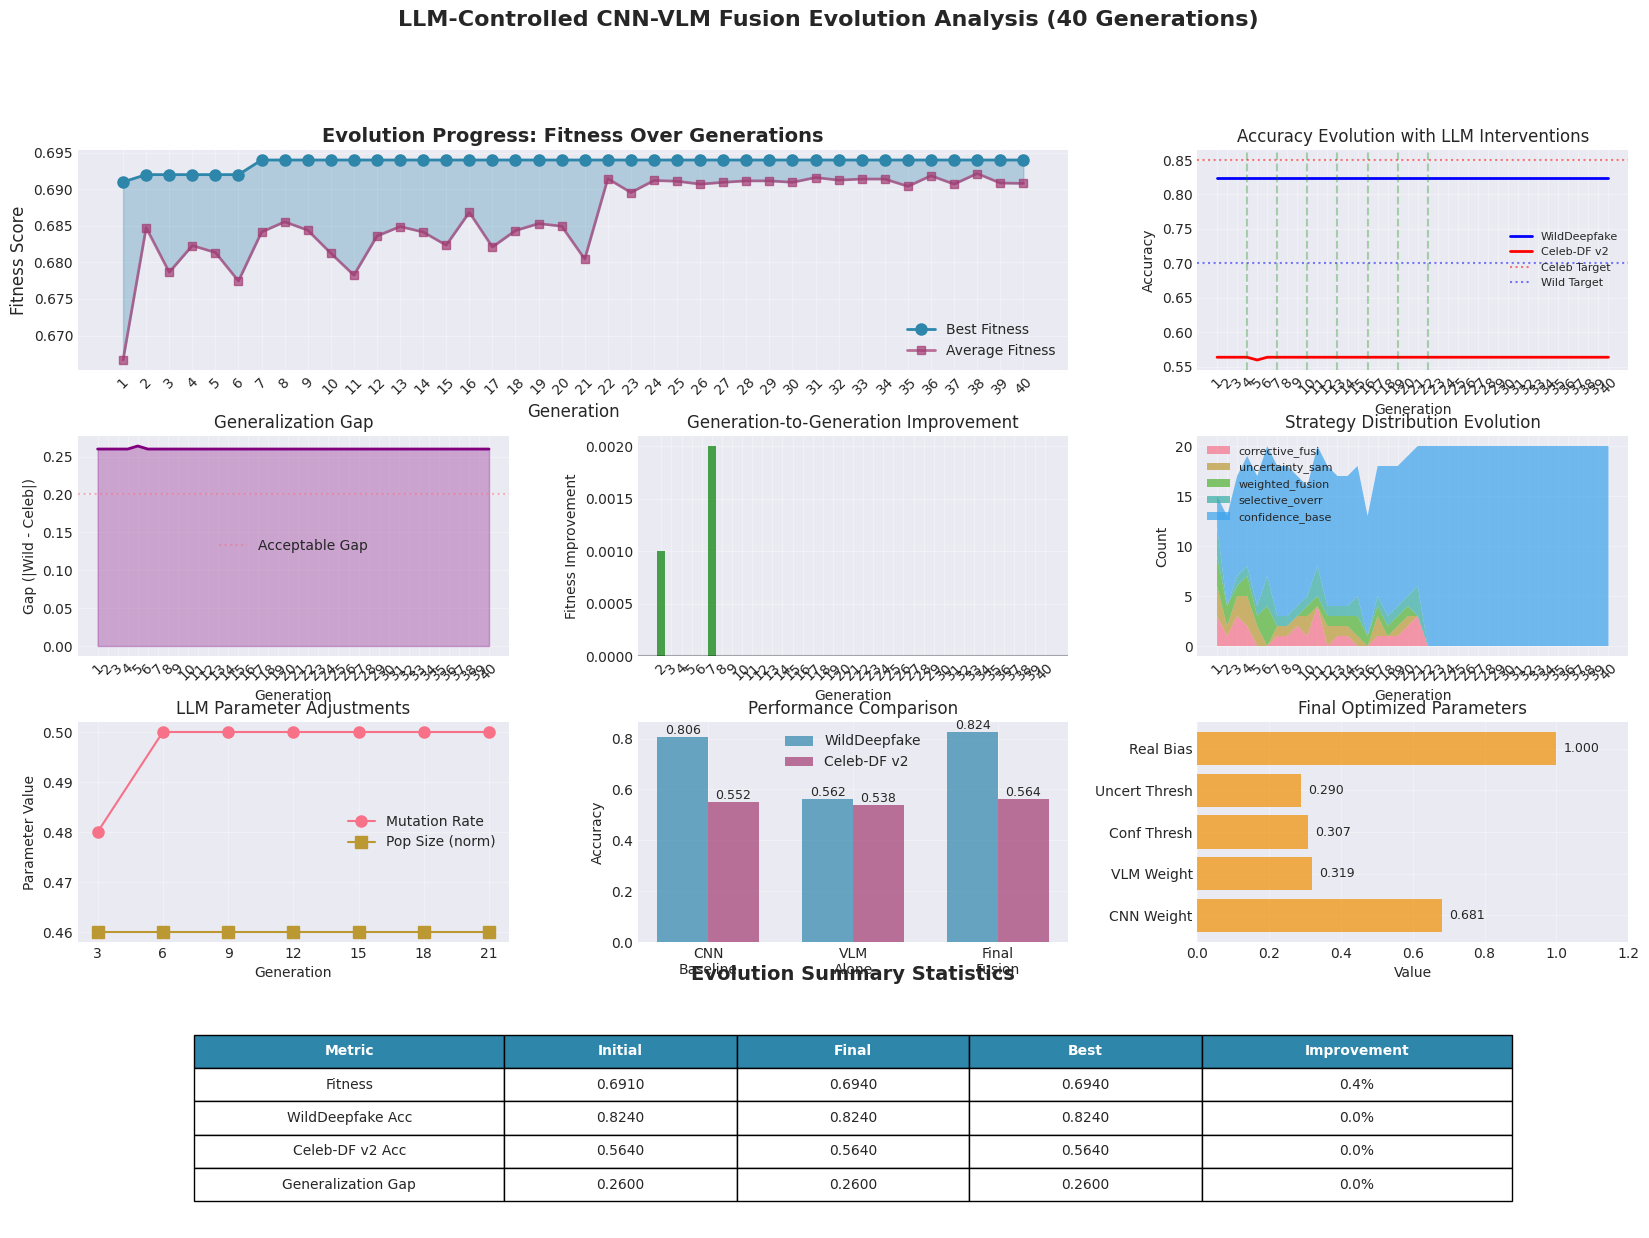


Visualization saved to: evolution_analysis_20251021_084031.png

EVOLUTION SUMMARY
Total Generations Completed: 40
Best Fitness Achieved: 0.6940
Final Fitness: 0.6940
Fitness Improvement: 0.4%

Best Performance Achieved:
  WildDeepfake: 0.8240 (Target: ≥0.70)
  Celeb-DF v2: 0.5640 (Target: ≥0.85)
  Min Gap: 0.2600 (Target: ≤0.20)

Best Generation: 7
  Fitness: 0.6940
  WildDeepfake: 0.8240
  Celeb-DF v2: 0.5640
  Gap: 0.2600

LLM Controller Contribution:
  Total Interventions: 7
  Model: gpt-5

  Intervention 1 (Gen 3):
    Population: 23
    Mutation: 0.48
    Reasoning: Adaptive - gaps: Wild 0.026, Celeb 0.140...

  Intervention 2 (Gen 6):
    Population: 23
    Mutation: 0.5
    Reasoning: Adaptive - gaps: Wild 0.026, Celeb 0.136...

  Intervention 3 (Gen 9):
    Population: 23
    Mutation: 0.5
    Reasoning: Adaptive - gaps: Wild 0.026, Celeb 0.136...

ANALYSIS COMPLETE


In [ ]:
print("\n" + "="*80)
print("VISUALISATION AND ANALYSIS")
print("="*80)

if 'results' in globals() and results and 'evolution' in globals() and evolution.metrics_history:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.gridspec import GridSpec

    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    # Use the lightweight metrics_history for visualization
    metrics_history = evolution.metrics_history

    # Extract evolution data from metrics history
    generations = [m['generation'] for m in metrics_history]
    best_fitness = [m['best_fitness'] for m in metrics_history]
    avg_fitness = [m['avg_fitness'] for m in metrics_history]
    best_wild = [m['best_wild'] for m in metrics_history]
    best_celeb = [m['best_celeb'] for m in metrics_history]

    print(f"Visualising {len(generations)} generations of evolution data...")

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 14))
    gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)

    # 1. Fitness Evolution
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(generations, best_fitness,
             'o-', linewidth=2, markersize=8, label='Best Fitness', color='#2E86AB')
    ax1.plot(generations, avg_fitness,
             's-', linewidth=2, markersize=6, label='Average Fitness', alpha=0.7, color='#A23B72')
    ax1.fill_between(generations,
                      avg_fitness,
                      best_fitness,
                      alpha=0.3, color='#2E86AB')
    ax1.set_xlabel('Generation', fontsize=12)
    ax1.set_ylabel('Fitness Score', fontsize=12)
    ax1.set_title('Evolution Progress: Fitness Over Generations', fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.set_xticks(generations)
    ax1.set_xticklabels([str(g+1) for g in generations], rotation=45 if len(generations) > 15 else 0)
    ax1.grid(True, alpha=0.3)

    # 2. Accuracy Evolution
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(generations, best_wild, 'b-', label='WildDeepfake', linewidth=2)
    ax2.plot(generations, best_celeb, 'r-', label='Celeb-DF v2', linewidth=2)
    ax2.axhline(y=FUSION_CONFIG['target_celeb_accuracy'], color='r', linestyle=':', alpha=0.5, label='Celeb Target')
    ax2.axhline(y=FUSION_CONFIG['target_kaggle_accuracy'], color='b', linestyle=':', alpha=0.5, label='Wild Target')

    # Mark LLM decisions if available
    if results.get('llm_decisions'):
        for i, decision in enumerate(results['llm_decisions']):
            gen = (i + 1) * 3
            if gen < len(generations):
                # Find the closest generation in our metrics
                closest_gen = min(generations, key=lambda x: abs(x - gen))
                ax2.axvline(x=closest_gen, color='green', linestyle='--', alpha=0.3)

    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Evolution with LLM Interventions')
    ax2.legend(fontsize=8)
    ax2.set_xticks(generations)
    ax2.set_xticklabels([str(g+1) for g in generations], rotation=45 if len(generations) > 10 else 0)
    ax2.grid(True, alpha=0.3)

    # 3. Generalization Gap
    ax3 = fig.add_subplot(gs[1, 0])
    gen_gaps = [abs(w - c) for w, c in zip(best_wild, best_celeb)]
    ax3.plot(generations, gen_gaps, 'purple', linewidth=2)
    ax3.fill_between(generations, 0, gen_gaps, alpha=0.3, color='purple')
    ax3.axhline(y=FUSION_CONFIG['acceptable_gap'], linestyle=':', alpha=0.5, label='Acceptable Gap')
    ax3.set_xlabel('Generation')
    ax3.set_ylabel('Gap (|Wild - Celeb|)')
    ax3.set_title('Generalization Gap')
    ax3.legend()
    ax3.set_xticks(generations)
    ax3.set_xticklabels([str(g+1) for g in generations], rotation=45 if len(generations) > 10 else 0)
    ax3.grid(True, alpha=0.3)

    # 4. Fitness Improvement Rate
    ax4 = fig.add_subplot(gs[1, 1])
    if len(best_fitness) > 1:
        improvement = np.diff(best_fitness)
        colors = ['green' if x > 0 else 'red' for x in improvement]
        ax4.bar(generations[1:], improvement, color=colors, alpha=0.7)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax4.set_xlabel('Generation')
        ax4.set_ylabel('Fitness Improvement')
        ax4.set_title('Generation-to-Generation Improvement')
        ax4.set_xticks(generations[1:])
        ax4.set_xticklabels([str(g+1) for g in generations[1:]], rotation=45 if len(generations) > 10 else 0)
        ax4.grid(True, alpha=0.3)

    # 5. Strategy Distribution Over Time
    ax5 = fig.add_subplot(gs[1, 2])

    # Extract strategy counts from metrics_history
    all_strategies = list(set(s for m in metrics_history for s in m['strategy_counts'].keys()))
    strategy_data = {s: [] for s in all_strategies}

    for m in metrics_history:
        for strategy in all_strategies:
            strategy_data[strategy].append(m['strategy_counts'].get(strategy, 0))

    # Stack the data
    bottom = np.zeros(len(generations))
    for strategy in all_strategies[:5]:  # Limit to top 5 for clarity
        if strategy in strategy_data:
            values = strategy_data[strategy]
            ax5.fill_between(generations, bottom, bottom + values, label=strategy[:15], alpha=0.7)
            bottom += values

    ax5.set_xlabel('Generation')
    ax5.set_ylabel('Count')
    ax5.set_title('Strategy Distribution Evolution')
    ax5.legend(loc='upper left', fontsize=8)
    ax5.set_xticks(generations)
    ax5.set_xticklabels([str(g+1) for g in generations], rotation=45 if len(generations) > 10 else 0)
    ax5.grid(True, alpha=0.3)

    # 6. LLM Parameter Adjustments
    ax6 = fig.add_subplot(gs[2, 0])
    if results.get('llm_decisions') and len(results['llm_decisions']) > 0:
        decision_gens = [(i+1) * 3 for i in range(len(results['llm_decisions']))]
        mutation_rates = [d.get('mutation_rate', 0.4) for d in results['llm_decisions']]
        pop_sizes = [d.get('population_size', 20) / 50 for d in results['llm_decisions']]  # Normalize

        ax6.plot(decision_gens, mutation_rates, 'o-', label='Mutation Rate', markersize=8)
        ax6.plot(decision_gens, pop_sizes, 's-', label='Pop Size (norm)', markersize=8)
        ax6.set_xlabel('Generation')
        ax6.set_ylabel('Parameter Value')
        ax6.set_title('LLM Parameter Adjustments')
        ax6.legend()
        # For LLM decisions, we use decision_gens for x-ticks
        ax6.set_xticks(decision_gens)
        ax6.set_xticklabels([str(g) for g in decision_gens])
        ax6.grid(True, alpha=0.3)
    else:
        # If no LLM decisions, just show an empty plot with message
        ax6.text(0.5, 0.5, 'No LLM Decisions', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_xlabel('Generation')
        ax6.set_ylabel('Parameter Value')
        ax6.set_title('LLM Parameter Adjustments')

    # 7. Performance Comparison
    ax7 = fig.add_subplot(gs[2, 1])
    categories = ['CNN\nBaseline', 'VLM\nAlone', 'Final\nFusion']
    wild_scores = [
        results['cnn_baseline']['wilddeepfake'],
        results['vlm_cache_stats']['wild_vlm_acc'],
        results['metrics']['wild_acc']
    ]
    celeb_scores = [
        results['cnn_baseline']['celeb_df_v2'],
        results['vlm_cache_stats']['celeb_vlm_acc'],
        results['metrics']['celeb_acc']
    ]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax7.bar(x - width/2, wild_scores, width, label='WildDeepfake', alpha=0.7, color='#2E86AB')
    bars2 = ax7.bar(x + width/2, celeb_scores, width, label='Celeb-DF v2', alpha=0.7, color='#A23B72')

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    ax7.set_ylabel('Accuracy')
    ax7.set_title('Performance Comparison')
    ax7.set_xticks(x)
    ax7.set_xticklabels(categories)
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # 8. Final Genome Parameters
    ax8 = fig.add_subplot(gs[2, 2])
    final_params = {
        'CNN Weight': results['genome'].cnn_weight,
        'VLM Weight': results['genome'].vlm_weight,
        'Conf Thresh': results['genome'].confidence_threshold,
        'Uncert Thresh': results['genome'].uncertainty_threshold,
        'Real Bias': results['genome'].real_bias_correction
    }

    params = list(final_params.keys())
    values = list(final_params.values())

    bars = ax8.barh(params, values, alpha=0.7, color='#F18F01')
    ax8.set_xlabel('Value')
    ax8.set_title('Final Optimized Parameters')
    ax8.set_xlim(0, max(1.2, max(values) * 1.1))

    # Add value labels
    for bar, value in zip(bars, values):
        ax8.text(value + 0.02, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', va='center', fontsize=9)

    ax8.grid(True, alpha=0.3)

    # 9. Evolution Summary Statistics Table
    ax9 = fig.add_subplot(gs[3, :])
    ax9.axis('tight')
    ax9.axis('off')

    # Calculate statistics
    initial_fitness = best_fitness[0]
    final_fitness = best_fitness[-1]
    max_fitness = max(best_fitness)
    improvement_pct = ((final_fitness - initial_fitness) / initial_fitness) * 100 if initial_fitness != 0 else 0

    stats_data = [
        ['Metric', 'Initial', 'Final', 'Best', 'Improvement'],
        ['Fitness', f"{initial_fitness:.4f}", f"{final_fitness:.4f}",
         f"{max_fitness:.4f}", f"{improvement_pct:.1f}%"],
        ['WildDeepfake Acc', f"{best_wild[0]:.4f}", f"{best_wild[-1]:.4f}",
         f"{max(best_wild):.4f}", f"{(max(best_wild) - best_wild[0])*100:.1f}%"],
        ['Celeb-DF v2 Acc', f"{best_celeb[0]:.4f}", f"{best_celeb[-1]:.4f}",
         f"{max(best_celeb):.4f}", f"{(max(best_celeb) - best_celeb[0])*100:.1f}%"],
        ['Generalization Gap', f"{gen_gaps[0]:.4f}", f"{gen_gaps[-1]:.4f}",
         f"{min(gen_gaps):.4f}", f"{(gen_gaps[0] - min(gen_gaps))*100:.1f}%"]
    ]

    table = ax9.table(cellText=stats_data[1:], colLabels=stats_data[0],
                     cellLoc='center', loc='center',
                     colWidths=[0.2, 0.15, 0.15, 0.15, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Color the header
    for i in range(len(stats_data[0])):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white')

    ax9.set_title('Evolution Summary Statistics', fontsize=14, fontweight='bold', pad=20)

    # Main title
    fig.suptitle(f'LLM-Controlled CNN-VLM Fusion Evolution Analysis ({len(generations)} Generations)',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()

    # Save figure
    fig_path = f'evolution_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nVisualization saved to: {fig_path}")

    # Print detailed summary
    print("\n" + "="*80)
    print("EVOLUTION SUMMARY")
    print("="*80)
    print(f"Total Generations Completed: {len(metrics_history)}")
    print(f"Best Fitness Achieved: {max_fitness:.4f}")
    print(f"Final Fitness: {final_fitness:.4f}")
    print(f"Fitness Improvement: {improvement_pct:.1f}%")

    print(f"\nBest Performance Achieved:")
    print(f"  WildDeepfake: {max(best_wild):.4f} (Target: ≥{FUSION_CONFIG['target_kaggle_accuracy']:.2f})")
    print(f"  Celeb-DF v2: {max(best_celeb):.4f} (Target: ≥{FUSION_CONFIG['target_celeb_accuracy']:.2f})")
    print(f"  Min Gap: {min(gen_gaps):.4f} (Target: ≤{FUSION_CONFIG['acceptable_gap']:.2f})")

    # Find the generation with best fitness
    best_gen_idx = np.argmax(best_fitness)
    print(f"\nBest Generation: {best_gen_idx + 1}")
    print(f"  Fitness: {best_fitness[best_gen_idx]:.4f}")
    print(f"  WildDeepfake: {best_wild[best_gen_idx]:.4f}")
    print(f"  Celeb-DF v2: {best_celeb[best_gen_idx]:.4f}")
    print(f"  Gap: {gen_gaps[best_gen_idx]:.4f}")

    # LLM Controller contribution
    if results.get('llm_decisions') and len(results['llm_decisions']) > 0:
        print(f"\nLLM Controller Contribution:")
        print(f"  Total Interventions: {len(results['llm_decisions'])}")
        print(f"  Model: {FUSION_CONFIG['llm_controller_model']}")

        # Analyze impact of LLM decisions
        for i, decision in enumerate(results['llm_decisions'][:3]):  # Show first 3
            print(f"\n  Intervention {i+1} (Gen {(i+1)*3}):")
            print(f"    Population: {decision.get('population_size', 'N/A')}")
            print(f"    Mutation: {decision.get('mutation_rate', 'N/A')}")
            if decision.get('reasoning'):
                print(f"    Reasoning: {decision['reasoning'][:80]}...")

    # Device and performance info
    if results.get('device_used'):
        print(f"\nCompute Device: {results['device_used']}")
        print(f"Final Batch Size: {results.get('final_batch_size', 'N/A')}")

    print("="*80)

else:
    print("No results available for visualization")
    print("Please ensure Cell 9 (evolution) has completed successfully")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)